# 0.初始化

In [1]:
# 导入所需的库
import os
import pickle
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"  # 在代码开头添加
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import spearmanr
import torch
from torch import nn
from torch.nn import functional as F
from transformers import (
    AutoTokenizer,
    AutoModel,
    T5Tokenizer, T5EncoderModel,
    AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModelForTokenClassification, AutoConfig, AutoModelForCausalLM
)
from vplm import TransformerForMaskedLM, TransformerConfig
from vplm import VPLMTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from inspect import signature
import logging
import warnings
import gc

warnings.simplefilter("ignore", category=FutureWarning)
# 配置日志
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# 创建模型保存文件夹
MODEL_FOLDER = "/nas_data/mingxuan_model"
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
    logger.info(f"Created a new folder: {MODEL_FOLDER}")
    # print(f"Created a new folder: {MODEL_FOLDER}")
else:
    logger.info(f"{MODEL_FOLDER} folder existed")
    
# 定义常量
BATCH_SIZE = 16  # 批次大小 batch size
MAX_LENGTH_AB = 512  # 抗体序列ab最大长度 Maximum length of substrate molecule sequence
MAX_LENGTH_AG = 512  # 抗原序列ag最大长度 Maximum length of amino acid sequence
RANDOM_STATE = 314
# 设置随机种子
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 在训练前调用
set_seed(RANDOM_STATE)

# 如果有多个GPU，选择其中一个进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:2")
        # 释放GPU内存
        torch.cuda.empty_cache()
        logger.info(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    logger.info("Using CPU")

# 定义亲和力损失函数为均方误差损失
affinity_loss_fn = nn.MSELoss()

# 设置环境变量以避免多线程问题
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

2025-09-03 08:51:13,446 - INFO - /nas_data/mingxuan_model folder existed
2025-09-03 08:51:15,189 - INFO - Using GPU: NVIDIA A800 80GB PCIe


In [2]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

class EsmcModel:
    def __init__(self, model_name="esmc_300m", max_length=512):
        # self.client = ESMC.from_pretrained(model_name)
        self.client = ESMC.from_pretrained(model_name).to(device)
        self.client.eval()  # 设置模型为评估模式
        self.max_length = max_length
        # 冻结预训练模型的参数
        for param in self.client.parameters():
            param.requires_grad = False

    def preprocess_sequence(self, sequence):
        # 替换非法字符并添加空格
        sequence = ''.join(sequence)  # 将list转换为str
        sequence = re.sub(r"[UZOB]", "X", sequence)  # 替换非常见氨基酸
        return sequence

    def pad_or_truncate(self, tensor, target_len):
        # 获取当前tensor的形状
        current_len = tensor.shape[1]
        if current_len >= target_len:
            # 如果当前长度大于目标长度，则进行截断
            return tensor[:, :target_len, :]
        else:
            # 如果当前长度小于目标长度，则进行补全
            padding_shape = (tensor.shape[0], target_len - current_len, tensor.shape[2])
            padding = torch.zeros(padding_shape, dtype=tensor.dtype, device=device)
            return torch.cat([tensor, padding], dim=1)

    def forward(self, sequences):
        all_embeddings = []
        for seq in sequences:
            # 预处理序列
            processed_seq = self.preprocess_sequence(seq)
            # 创建 ESMProtein 对象
            prot = ESMProtein(sequence=processed_seq)
            # 编码序列,采取截断/填充最大长度
            tensor = self.client.encode(prot)
            out = self.client.logits(
                tensor,
                LogitsConfig(
                    sequence=True, 
                    return_embeddings=True,
                )
            )
            embed = out.embeddings
            # 将embed的第1个维度截断或填充0为self.max_length长度
            embed = self.pad_or_truncate(embed, self.max_length)
            all_embeddings.append(embed)  # [1, max_length, 960]

        # Concatenate along the batch dimension
        batched_embeddings = torch.cat(all_embeddings, dim=0)
        return batched_embeddings

    def __call__(self, sequences):
        return self.forward(sequences)

In [3]:
from modelgenerator.tasks import Embed

class AidoProtein:
    def __init__(self, model_name, max_length=512):
        # self.model = Embed.from_config({"model.backbone": model_name})
        self.model = Embed.from_config({"model.backbone": model_name}).to(device)
        self.model.eval()
        self.max_length = max_length
        # Freeze the parameters of the pre-trained model
        for param in self.model.parameters():
            param.requires_grad = False

    def preprocess_sequence(self, sequence):
        sequence = ''.join(sequence)  # Convert list to string
        sequence = re.sub(r"[UZOB]", "X", sequence)  # Replace uncommon amino acids
        return sequence

    def pad_or_truncate(self, tensor, target_len):
        current_len = tensor.shape[1]
        if current_len >= target_len:
            return tensor[:, :target_len, :]
        else:
            padding_shape = (tensor.shape[0], target_len - current_len, tensor.shape[2])
            padding = torch.zeros(padding_shape, dtype=tensor.dtype, device=device)
            return torch.cat([tensor, padding], dim=1)

    def forward(self, sequences):
        sequences = [self.preprocess_sequence(seq) for seq in sequences]
        transformed_batch = self.model.transform({"sequences": sequences})
        embeddings = self.model(transformed_batch)
        embeddings = self.pad_or_truncate(embeddings, self.max_length)
        return embeddings

    def __call__(self, sequences):
        return self.forward(sequences)

2025-09-03 08:51:16,903 - INFO - PyTorch version 2.6.0 available.
2025-09-03 08:51:16,906 - INFO - Polars version 1.29.0 available.


In [4]:
def instantiate_model(net_name):
    """
    实例化单个模型的函数
    """
    prot_tokenizer = None
    prot_model = None
    use_hf_api = True

    try:
        if net_name in [
            'Rostlab/prot_bert', 'Rostlab/prot_bert_bfd', 
            'facebook/esm2_t33_650M_UR50D', 'facebook/esm2_t36_3B_UR50D', 'facebook/esm2_t30_150M_UR50D', 'facebook/esm2_t48_15B_UR50D',
            'biomap-research/proteinglm-3b-mlm', 'biomap-research/proteinglm-3b-clm', 'biomap-research/proteinglm-10b-mlm',
            'nferruz/ProtGPT2', 'jedwang/protein-binding-site-predictor', 'shashwatsaini/RoBERTa-MLM-For-Protein-Clustering',
        ]:
            try:
                prot_tokenizer = AutoTokenizer.from_pretrained(
                    net_name, local_files_only=True, trust_remote_code=True)
                prot_model = AutoModel.from_pretrained(
                    net_name, local_files_only=True, trust_remote_code=True)
            except Exception as e:
                print(f"Local files not found. Downloading model... Error: {e}")
                prot_tokenizer = AutoTokenizer.from_pretrained(net_name, trust_remote_code=True)
                prot_model = AutoModel.from_pretrained(net_name, trust_remote_code=True)

            if net_name in ['nferruz/ProtGPT2']:
                prot_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                prot_model.resize_token_embeddings(len(prot_tokenizer))

        elif net_name in [
            'AI4Protein/ProSST-1024', 'AI4Protein/ProSST-2048', 'AI4Protein/ProSST-4096', 
            'westlake-repl/SaProt_650M_PDB', 'westlake-repl/SaProt_650M_AF2', 'westlake-repl/SaProt_1.3B_AF2', 'westlake-repl/SaProt_35M_AF2',
            ]:
            try:
                prot_tokenizer = AutoTokenizer.from_pretrained(
                    net_name, local_files_only=True, trust_remote_code=True)
                prot_model = AutoModelForMaskedLM.from_pretrained(
                    net_name, local_files_only=True, trust_remote_code=True)
            except Exception as e:
                print(f"Local files not found. Downloading model... Error: {e}")
                prot_tokenizer = AutoTokenizer.from_pretrained(net_name, trust_remote_code=True)
                prot_model = AutoModelForMaskedLM.from_pretrained(net_name, trust_remote_code=True)

        elif net_name in ['Rostlab/prot_t5_xl_uniref50']:
            prot_tokenizer = T5Tokenizer.from_pretrained(
                net_name, local_files_only=True, trust_remote_code=True)
            prot_model = T5EncoderModel.from_pretrained(
                net_name, local_files_only=True, trust_remote_code=True)

        elif net_name in ['EvolutionaryScale/esmc-300m-2024-12', 'EvolutionaryScale/esmc-600m-2024-12']:
            net_name = re.search(r'esmc-(\d+).', net_name).group(0).replace('-', '_')
            prot_model = EsmcModel(model_name=net_name, max_length=MAX_LENGTH_AB)
            use_hf_api = False

        elif net_name in ['genbio-ai/AIDO.Protein-16B']:
            prot_model = AidoProtein(model_name='aido_protein_16b', max_length=MAX_LENGTH_AB)
            use_hf_api = False

        elif net_name in ['AI4Protein/VenusPLM-300M']:
            config = TransformerConfig.from_pretrained(net_name, attn_impl="sdpa") # or "flash_attn" if you have installed flash-attn
            prot_model = TransformerForMaskedLM.from_pretrained(net_name, config=config)
            prot_tokenizer = VPLMTokenizer.from_pretrained(net_name)
        # 新模型 (Progen2 全系列)
        elif net_name in [
            'hugohrban/progen2-small', 'hugohrban/progen2-medium', 'hugohrban/progen2-large',
            'hugohrban/progen2-base', 'hugohrban/progen2-xlarge', 'hugohrban/progen2-oas',
            'hugohrban/progen2-BFD90', 'hugohrban/progen2-small-mix7', 'hugohrban/progen2-small-mix7-bidi'
        ]:
            try:
                prot_tokenizer = AutoTokenizer.from_pretrained(net_name, local_files_only=True, trust_remote_code=True)
                prot_model = AutoModelForCausalLM.from_pretrained(net_name, local_files_only=True, trust_remote_code=True)
            except Exception as e:
                print(f"Local files not found. Downloading model... Error: {e}")
                prot_tokenizer = AutoTokenizer.from_pretrained(net_name, trust_remote_code=True)
                prot_model = AutoModelForCausalLM.from_pretrained(net_name, trust_remote_code=True)

            if prot_tokenizer.pad_token is None:
                if prot_tokenizer.eos_token:
                    prot_tokenizer.pad_token = prot_tokenizer.eos_token
                else:
                    prot_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                    prot_model.resize_token_embeddings(len(prot_tokenizer))
            use_hf_api = True

        else:
            raise ValueError(f"Unsupported model name: {net_name}")

        net = Net01(
            prot_model=prot_model,
            prot_tokenizer=prot_tokenizer,
            max_length_ab=MAX_LENGTH_AB,
            max_length_ag=MAX_LENGTH_AG,
            batch_size=BATCH_SIZE,
            use_hf_api=use_hf_api
        )
        return net

    finally:
        # 释放内存
        del prot_tokenizer, prot_model
        torch.cuda.empty_cache()

class MyDataset(Dataset):
    def __init__(self, data, prot_tokenizer, max_length_ab, max_length_ag, contain_label=True, use_hf_api=True):
        self.data = data
        self.prot_tokenizer = prot_tokenizer
        self.max_length_ab = max_length_ab
        self.max_length_ag = max_length_ag
        self.contain_label = contain_label
        self.use_hf_api = use_hf_api

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        sample = self.data.iloc[index]
        ab_input = self.tokenize_sequence(sample['Antibody'], self.max_length_ab)
        ag_input = self.tokenize_sequence(sample['Antigen'], self.max_length_ag)

        if self.contain_label:
            affinity = torch.tensor(sample['affinity'], dtype=torch.float32)
            return {
                'ab_input': ab_input,
                'ag_input': ag_input,
                'affinity': affinity,
                'idx': index
            }
        else:
            return {
                'ab_input': ab_input,
                'ag_input': ag_input,
                'idx': index
                # 'affinity': affinity,
            }

    def pad_or_truncate(self, tensor, target_len=200):
        # 获取当前tensor的形状
        current_len = tensor.shape[0]
        if current_len >= target_len:
            # 如果当前长度大于目标长度，则进行截断
            return tensor[:target_len]
        else:
            # 如果当前长度小于目标长度，则进行补全
            # 计算需要补全的部分
            padding_shape = [target_len - current_len] + list(tensor.shape[1:])
            padding = torch.zeros(padding_shape, dtype=tensor.dtype)
            return torch.cat([tensor, padding], dim=0)

    def tokenize_sequence(self, sequence, max_length):
        if self.use_hf_api:
            sequence = ''.join(sequence)  # 将list转换为str
            sequences = [" ".join(re.sub(r"[UZOB]", "X", sequence))]
            sequence_tokens = self.prot_tokenizer.batch_encode_plus(
                sequences,
                add_special_tokens=True,
                padding="max_length",
                return_tensors="pt",
                max_length=max_length,
                truncation=True,
            )
            return {
                'input_ids': sequence_tokens["input_ids"],
                'attention_mask': sequence_tokens["attention_mask"],
            }
        else:
            return {
                'input_ids': sequence,
                'attention_mask': torch.tensor([]),
            }
            
def save_checkpoint(model, optimizer, epoch, best_test_loss, path_savemodel):
    '''
    检查点保存函数
    '''
    print("=> Saving checkpoint")
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'best_test_loss': best_test_loss
    }
    torch.save(state, path_savemodel)

def load_checkpoint(model, optimizer, path_savemodel, device=device):
    '''
    检查点加载函数
    '''
    print("=> Loading checkpoint")
    checkpoint = torch.load(
        path_savemodel, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint.get('epoch', 0)
    best_test_loss = checkpoint.get('best_test_loss', float("inf"))
    return (epoch, best_test_loss)

In [5]:
def train(train_data, test_data, model, path_savemodel, affinity_loss_fn=affinity_loss_fn, epochs=100, patience=20, lr=1e-3, num_gpu=1, load_best_test_loss=True):
    '''
    模型训练函数
    '''
    model.train()
    start_epoch = 0
    best_test_loss = float("inf")
    best_epoch = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    use_hf_api = getattr(model, 'module', model).use_hf_api
    if os.path.isfile(path_savemodel):
        start_epoch, best_test_loss = load_checkpoint(
            model, optimizer, path_savemodel)
        best_epoch = start_epoch
        if not load_best_test_loss:
            best_test_loss = float("inf")
    try:
        dataset = MyDataset(
            data=train_data,
            prot_tokenizer=getattr(model, 'module', model).prot_tokenizer,
            max_length_ab=getattr(model, 'module', model).max_length_ab,
            max_length_ag=getattr(model, 'module', model).max_length_ag,
            use_hf_api=use_hf_api,
        )

        dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=BATCH_SIZE,
            pin_memory=True,
        )
        # dataloader = DataLoader(
        #     dataset,
        #     batch_size=1,
        #     shuffle=False,
        #     num_workers=1,
        #     pin_memory=False,
        # )
        train_losses = torch.empty((0, 1), device=device, dtype=torch.float32)
        test_losses = torch.empty((0, 1), device=device, dtype=torch.float32)
        patience_counter = 0

        for epoch in range(start_epoch, epochs):
            loss_arr = torch.empty((0, 1), device=device, dtype=torch.float32)

            for batch in dataloader:
                ab_input = batch['ab_input']
                ag_input = batch['ag_input']
                affinity = batch['affinity'].to(device)
                if use_hf_api:
                    predicted_affinity = model(
                        ab_input['input_ids'].to(device),
                        ab_input['attention_mask'].to(device),
                        ag_input['input_ids'].to(device),
                        ag_input['attention_mask'].to(device),
                    )
                else:
                    predicted_affinity = model(
                        ab_input['input_ids'],
                        ab_input['attention_mask'],
                        ag_input['input_ids'],
                        ag_input['attention_mask'],
                    )

                predicted_affinity = predicted_affinity.view(-1)

                loss = affinity_loss_fn(predicted_affinity, affinity)

                loss_arr = torch.cat(
                    (
                        loss_arr,
                        torch.tensor(
                            [[loss.item()]], device=device, dtype=torch.float32
                        ),
                    ),
                    dim=0,
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # ========= 新增部分 =========
                del ab_input, ag_input, affinity, predicted_affinity
                torch.cuda.empty_cache()
                # ============================

            logger.info(f"Epoch {epoch+1}, train loss: {loss_arr.mean(dim=0).item():.4f}")

            train_losses = torch.cat(
                (train_losses, loss_arr.mean(dim=0).unsqueeze(0)), dim=0
            )

            test_loss = test(test_data, model,
                             affinity_loss_fn, num_gpu)[0]
            test_losses = torch.cat(
                (test_losses, test_loss.unsqueeze(0)), dim=0)

            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                best_epoch = epoch+1
                save_checkpoint(model, optimizer, epoch,
                                best_test_loss, path_savemodel)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"early stop at epoch {epoch+1}")
                    break
            torch.cuda.empty_cache()

        print(
            f'=> Training completed! Best loss is {best_test_loss.item():.4f} at epoch {best_epoch}')
        return (train_losses, test_losses)
    except KeyboardInterrupt:
        print(
            f"Training interrupted at epoch {epoch}. Best loss at epoch {best_epoch}.")
        raise

def test(train_data, model, affinity_loss_fn=affinity_loss_fn, num_gpu=1):
    '''
    模型测试函数
    '''
    model.eval()
    use_hf_api = getattr(model, 'module', model).use_hf_api
    dataset = MyDataset(
        data=train_data,
        prot_tokenizer=getattr(model, 'module', model).prot_tokenizer,
        max_length_ab=getattr(model, 'module', model).max_length_ab,
        max_length_ag=getattr(model, 'module', model).max_length_ag,
        use_hf_api=use_hf_api
    )

    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=BATCH_SIZE,
        pin_memory=True,
    )
    loss_arr = torch.empty((0, 1), device=device, dtype=torch.float32)

    for batch in dataloader:
        ab_input = batch['ab_input']
        ag_input = batch['ag_input']
        affinity = batch['affinity'].to(device)
        if use_hf_api:
            predicted_affinity = model(
                ab_input['input_ids'].to(device),
                ab_input['attention_mask'].to(device),
                ag_input['input_ids'].to(device),
                ag_input['attention_mask'].to(device),
            )
        else:
            predicted_affinity = model(
                ab_input['input_ids'],
                ab_input['attention_mask'],
                ag_input['input_ids'],
                ag_input['attention_mask'],
            )
        predicted_affinity = predicted_affinity.view(-1)

        loss = affinity_loss_fn(predicted_affinity, affinity)

        # 将损失值添加到损失数组中
        loss_arr = torch.cat(
            (
                loss_arr,
                torch.tensor(
                    [[loss.item()]], device=device, dtype=torch.float32
                ),
            ),
            dim=0,
        )
        # ========= 新增部分 =========
        del ab_input, ag_input, affinity, predicted_affinity
        torch.cuda.empty_cache()
        # ============================

    # 手动清理GPU内存
    torch.cuda.empty_cache()
    # 打印测试集的平均损失和评价指标
    logger.info(
        f"valid loss: {loss_arr.mean(dim=0).item():.4f}")
    return (
        loss_arr.mean(dim=0),
    )

def predict(model, data, batch_size=BATCH_SIZE//4, num_gpu=1, scaler=None):
    """
    预测函数，返回所有预测的亲和力值，确保返回数据的行索引与输入数据data的行索引一致
    """
    model.eval()
    all_predicted_affinity = []
    dataset = MyDataset(
        data=data,
        prot_tokenizer=getattr(model, 'module', model).prot_tokenizer,
        max_length_ab=getattr(model, 'module', model).max_length_ab,
        max_length_ag=getattr(model, 'module', model).max_length_ag,
        use_hf_api=getattr(model, 'module', model).use_hf_api,
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
    )
    # 使用模型进行预测
    with torch.no_grad():
        for batch in dataloader:
            ab_input = batch['ab_input']
            ag_input = batch['ag_input']

            ab_ids = ab_input['input_ids']
            ab_mask = ab_input['attention_mask']
            ag_ids = ag_input['input_ids']
            ag_mask = ag_input['attention_mask']

            if getattr(model, 'module', model).use_hf_api:
                ab_ids = ab_ids.to(device)
                ab_mask = ab_mask.to(device)
                ag_ids = ag_ids.to(device)
                ag_mask = ag_mask.to(device)
                predicted_affinity = model(
                    ab_ids,
                    ab_mask,
                    ag_ids,
                    ag_mask,
                )
            else:
                predicted_affinity = model(
                    ab_ids,
                    ab_mask,
                    ag_ids,
                    ag_mask,
                )

            predicted_affinity = predicted_affinity.view(-1)

            all_predicted_affinity.extend(predicted_affinity.cpu().tolist())
            # 手动清理GPU内存
            del ab_input, ag_input, ab_ids, ab_mask, ag_ids, ag_mask, predicted_affinity
            torch.cuda.empty_cache()
    
    if scaler is not None:
        # 如果提供了scaler，则使用scaler.inverse_transform将预测的亲和力值转换为原始值
        all_predicted_affinity = scaler.inverse_transform(np.array(all_predicted_affinity).reshape(-1, 1)).flatten()
    torch.cuda.empty_cache()
    
    # 确保返回数据的行索引与输入数据data的行索引一致
    predicted_series = pd.Series(all_predicted_affinity, index=data.index)
    return predicted_series

def model_test(test_data, net, folder_name, model_name, batch_size=BATCH_SIZE//4, num_gpu=1, scaler=None):
    """
    模型测试函数，计算 MSE 和 Spearman 相关系数
    """
    # 加载模型
    path_savemodel = f"{folder_name}/{model_name}"
    model = net.to(device)
    state_dict = torch.load(
        path_savemodel, map_location=device, weights_only=False)['state_dict']
    # 去除module.前缀并加载权重
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()

    all_affinity = test_data['affinity'].to_numpy()
    all_predicted_affinity = predict(model, test_data, batch_size=batch_size, num_gpu=num_gpu, scaler=scaler)
    
    # 计算 MSE
    mse = mean_squared_error(all_affinity, all_predicted_affinity)

    # 计算 Spearman 相关系数
    spearman_corr, p = spearmanr(all_affinity, all_predicted_affinity)

    print(f"Test MSE: {mse}, Spearman Correlation: {spearman_corr}, p-value: {p}")
    return mse, spearman_corr, p

def calculate_multi_model(test_data, model_names, net_names, scaler=None, device=device):
    """
    计算多个模型的测试精度
    """
    arr_mse = []
    for model_name, net_name in zip(model_names, net_names):
        print(f"Testing model: {model_name}")
        net = instantiate_model(net_name)
        mse_arr = model_test(
            test_data=test_data,
            net=net,
            folder_name=MODEL_FOLDER,
            model_name=f"{model_name}.pth",
            scaler=scaler,
        )
        arr_mse.append({net_name: mse_arr})

    return arr_mse

def draw_acc_scatter_combined_horizontal(list_x, dict_arr_acc):
    '''
    绘制模型测试精度散点图，每个指标单独绘制一个子图，Y轴为模型名称，X轴为数值
    '''
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']  # 不同模型的标记样式
    colors = plt.cm.tab10.colors  # 使用tab10调色板

    fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)  # 1行3列子图，共用Y轴

    for i, (key, value) in enumerate(dict_arr_acc.items()):
        ax = axes[i]
        for j, (model_name, val) in enumerate(zip(list_x, value)):
            ax.scatter([val], [model_name], marker='o', color=colors[j % len(colors)], s=100)

        # 设置X轴为对数刻度（如果需要）
        if any(abs(v) < 1e-3 for v in value):
            ax.set_xscale('log')
        else:
            ax.set_xscale('linear')

        ax.set_xlabel(f"{key.capitalize()}", fontsize=12)  # 将标题设置为X轴标签
        ax.grid(True, linestyle='--', alpha=0.6)

    # axes[0].set_ylabel("Model", fontsize=12)  # 仅设置第一个子图的Y轴标签
    plt.tight_layout()
    plt.show()

# 1.数据处理

In [6]:
# 加载数据集,重置索引
path_data = "./data/all_datasets_with_log10_affinity.csv"
dataset = pd.read_csv(path_data)

# 按照Antigen, KD(M)去除空值
dataset = dataset.dropna(subset=["Antigen", "KD(M)"], how="any")

# 去除不必要的列
dataset = dataset.drop(columns=["Affinity"], errors="ignore")
dataset = dataset.reset_index(drop=True)
dataset

Source Data Set   PDB  \
0                     SAbDab  4IDJ   
1                     SAbDab  5ANM   
2                     SAbDab  6CWT   
3                     SAbDab  5K59   
4                     SAbDab  5F3B   
..                       ...   ...   
760  Affinity Benchmark v5.5  3U7Y   
761  Affinity Benchmark v5.5  6B0S   
762  Affinity Benchmark v5.5  4FP8   
763  Affinity Benchmark v5.5  1S78   
764  Affinity Benchmark v5.5  3HI6   

                                                    HC  \
0    QVQLVQSGAEVKKPGSSVKVSCKTSGGTFNNVAINWVRQAPGQGLE...   
1    EVQLVQSGAEVKKPGATVKISCKVYGYIFTDYNIYWVRQAPGKGLE...   
2    EGRLVTPGTPLTLTCTGSGFSLSTYAMIWVRQAPGQGVEYIGIINT...   
3    ELQLQESGPGLVKPSETLSLTCTVSGGSISSGSYYWDWIRQPPGKG...   
4    EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYAMSWVRQTPEKRLE...   
..                                                 ...   
760  VRLSQSGGQMKKPGESMRLSCRASGYEFLNCPINWIRLAPGRRPEW...   
761  EVQLQESGGGLVKPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...   
762  VQLQESGGGLVQPGESLRLSCVGSGSSFGESTLSYYAVSWVRQAPG...   
763  EVQLVESGGGLVQPGGSLRLSCAASGFTFTDYTMDWVRQAPGKGLE...   
764  EVQLLESGGGLVQPGGSLRLSCAASGFTFSRYVMWWVRQAPGKGLE...   

                                                    LC         HCDR1  \
0    ETTLTQSPGTLSLSPGERATLSCRASQTISNNFVAWYQQKPGQAPR...      GGTFNNVA   
1    SVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAPK...      GYIFTDYN   
2    ELVMTQTPSSTSAAVGGTVTINCQASQSIGNALAWYQQKPGQPPKL...      GFSLSTYA   
3    DIQMTQSPSSLSASVGDRVTITCRASQSINSYLNWYQQKPGKAPKL...    GGSISSGSYY   
4    DIEMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKL...      GFTFSSYA   
..                                                 ...           ...   
760  VLTQSPATLSLSPGETAIISCRTSQSGSLAWYQQRPGQAPRLVIYS...      GYEFLNCP   
761  YELTQPPSVSVSPGQTASITCSGDKLGDKYACWYQQKPGQSPVVVI...      GFTFSSYS   
762  DIQLTQSPSSLSASVGDRVTLTCQASQDIRKFLNWYQQKPGKGPKL...  GSSFGETLSYYA   
763  DIQMTQSPSSLSASVGDRVTITCKASQDVSIGVAWYQQKPGKAPKL...      GFTFTDYT   
764  IQMTQSPSSLSASVGDRVTITCRASQSIGSYLNWYQQKTGKAPKAL...      GFTFSRYV   

        HCDR2          HCDR3      LCDR1 LCDR2        LCDR3  \
0    IIPGLDTP  AREMEVRTEAFEI    QTISNNF   GAS    QQYGSSPYT   
1    IDPDNGET  ATVMGKWKGGYDY  SSNIGAGYD   DNF  QSYDSPTLTSP   
2     INTGGSA  ARTRGVDEHAFDP     QSIGNA   AGS   LGTYSAIDRA   
3     IYKSGST    ARERGMHYMDV     QSINSY   AAS    QQQFDPPFT   
4    ISSGGSYT      ARQDYAMNY     QDVSTA   SAS    QQHYSTPWT   
..        ...            ...        ...   ...          ...   
760  LKPRGGAV  TRGKYCRNWDFEH       QSGS   SGS        QQYEF   
761  ITSSSSYI  ARDPGIANHWFDP     KLGDKY   QDT    QAWDSSTVV   
762  INAGGGDI  AKHMSMGGDAFDV     QDIRKF   DAS    QQYDGLPFT   
763  VNPNSGGS   ARNLGPSFYFDY     QDVSIG   SAS    QQYYIYPYT   
764  IWPSGGNT  ASSYDFWSNAFDI     QSIGSY   AAS     QQSYSTPS   

                                               Antigen         KD(M)  \
0    IKTGTTDIGSNTTVKTGDLVTYDKENGMLKKVFYSFIDDKNHNKKL...  1.700000e-12   
1    VSAYLSRPSPFDLFIRKSPTITCLVVDLAPSKGTVNLTWSRASGKP...  1.950000e-12   
2                                    EGRLVTPGTPLTLTCTG  2.000000e-12   
3    NGKITKRTETVYDEKTNILQNLQFDFIDDPTYDKNVLLVKKQGSIH...  2.500000e-12   
4                                             DFGLDCDE  3.000000e-12   
..                                                 ...           ...   
760  VWKDADTTLFCASDAKAHETECHNVWATHACVPTDPNPQEIHLENV...  1.600000e-07   
761  EPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPK...  1.780000e-07   
762  VQSSSTGKICNNPHRILDGIDCTLIDALLGDPHCDVFQNETWDLFV...  4.300000e-07   
763  TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...  5.000000e-07   
764  GNVDLVFLFDGSMSLQPDEFQKILDFMKDVMKKCSNTSYQFAAVQF...  4.700000e-06   

    Affinity Method      KD(nM)  
0           Unknown     0.00170  
1             Other     0.00195  
2             Other     0.00200  
3               SPR     0.00250  
4               SPR     0.00300  
..              ...         ...  
760             NaN   160.00000  
761             NaN   178.00000  
762             NaN   430.00000  
763             NaN   500.00000  
764       

In [7]:
# 将亲和力KD(M)的单位转换为kcal/mol
R = 8.314 / 4184  # kcal/(mol*K)
T = 298.15  # K
def convert_kd_to_kcal(kd):
    return R * T * np.log(kd)  # kcal/mol
# 将亲和力转换为kcal/mol
dataset['affinity'] = dataset['KD(M)'].apply(convert_kd_to_kcal)
dataset

Source Data Set   PDB  \
0                     SAbDab  4IDJ   
1                     SAbDab  5ANM   
2                     SAbDab  6CWT   
3                     SAbDab  5K59   
4                     SAbDab  5F3B   
..                       ...   ...   
760  Affinity Benchmark v5.5  3U7Y   
761  Affinity Benchmark v5.5  6B0S   
762  Affinity Benchmark v5.5  4FP8   
763  Affinity Benchmark v5.5  1S78   
764  Affinity Benchmark v5.5  3HI6   

                                                    HC  \
0    QVQLVQSGAEVKKPGSSVKVSCKTSGGTFNNVAINWVRQAPGQGLE...   
1    EVQLVQSGAEVKKPGATVKISCKVYGYIFTDYNIYWVRQAPGKGLE...   
2    EGRLVTPGTPLTLTCTGSGFSLSTYAMIWVRQAPGQGVEYIGIINT...   
3    ELQLQESGPGLVKPSETLSLTCTVSGGSISSGSYYWDWIRQPPGKG...   
4    EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYAMSWVRQTPEKRLE...   
..                                                 ...   
760  VRLSQSGGQMKKPGESMRLSCRASGYEFLNCPINWIRLAPGRRPEW...   
761  EVQLQESGGGLVKPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...   
762  VQLQESGGGLVQPGESLRLSCVGSGSSFGESTLSYYAVSWVRQAPG...   
763  EVQLVESGGGLVQPGGSLRLSCAASGFTFTDYTMDWVRQAPGKGLE...   
764  EVQLLESGGGLVQPGGSLRLSCAASGFTFSRYVMWWVRQAPGKGLE...   

                                                    LC         HCDR1  \
0    ETTLTQSPGTLSLSPGERATLSCRASQTISNNFVAWYQQKPGQAPR...      GGTFNNVA   
1    SVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAPK...      GYIFTDYN   
2    ELVMTQTPSSTSAAVGGTVTINCQASQSIGNALAWYQQKPGQPPKL...      GFSLSTYA   
3    DIQMTQSPSSLSASVGDRVTITCRASQSINSYLNWYQQKPGKAPKL...    GGSISSGSYY   
4    DIEMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKL...      GFTFSSYA   
..                                                 ...           ...   
760  VLTQSPATLSLSPGETAIISCRTSQSGSLAWYQQRPGQAPRLVIYS...      GYEFLNCP   
761  YELTQPPSVSVSPGQTASITCSGDKLGDKYACWYQQKPGQSPVVVI...      GFTFSSYS   
762  DIQLTQSPSSLSASVGDRVTLTCQASQDIRKFLNWYQQKPGKGPKL...  GSSFGETLSYYA   
763  DIQMTQSPSSLSASVGDRVTITCKASQDVSIGVAWYQQKPGKAPKL...      GFTFTDYT   
764  IQMTQSPSSLSASVGDRVTITCRASQSIGSYLNWYQQKTGKAPKAL...      GFTFSRYV   

        HCDR2          HCDR3      LCDR1 LCDR2        LCDR3  \
0    IIPGLDTP  AREMEVRTEAFEI    QTISNNF   GAS    QQYGSSPYT   
1    IDPDNGET  ATVMGKWKGGYDY  SSNIGAGYD   DNF  QSYDSPTLTSP   
2     INTGGSA  ARTRGVDEHAFDP     QSIGNA   AGS   LGTYSAIDRA   
3     IYKSGST    ARERGMHYMDV     QSINSY   AAS    QQQFDPPFT   
4    ISSGGSYT      ARQDYAMNY     QDVSTA   SAS    QQHYSTPWT   
..        ...            ...        ...   ...          ...   
760  LKPRGGAV  TRGKYCRNWDFEH       QSGS   SGS        QQYEF   
761  ITSSSSYI  ARDPGIANHWFDP     KLGDKY   QDT    QAWDSSTVV   
762  INAGGGDI  AKHMSMGGDAFDV     QDIRKF   DAS    QQYDGLPFT   
763  VNPNSGGS   ARNLGPSFYFDY     QDVSIG   SAS    QQYYIYPYT   
764  IWPSGGNT  ASSYDFWSNAFDI     QSIGSY   AAS     QQSYSTPS   

                                               Antigen         KD(M)  \
0    IKTGTTDIGSNTTVKTGDLVTYDKENGMLKKVFYSFIDDKNHNKKL...  1.700000e-12   
1    VSAYLSRPSPFDLFIRKSPTITCLVVDLAPSKGTVNLTWSRASGKP...  1.950000e-12   
2                                    EGRLVTPGTPLTLTCTG  2.000000e-12   
3    NGKITKRTETVYDEKTNILQNLQFDFIDDPTYDKNVLLVKKQGSIH...  2.500000e-12   
4                                             DFGLDCDE  3.000000e-12   
..                                                 ...           ...   
760  VWKDADTTLFCASDAKAHETECHNVWATHACVPTDPNPQEIHLENV...  1.600000e-07   
761  EPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPK...  1.780000e-07   
762  VQSSSTGKICNNPHRILDGIDCTLIDALLGDPHCDVFQNETWDLFV...  4.300000e-07   
763  TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...  5.000000e-07   
764  GNVDLVFLFDGSMSLQPDEFQKILDFMKDVMKKCSNTSYQFAAVQF...  4.700000e-06   

    Affinity Method      KD(nM)   affinity  
0           Unknown     0.00170 -16.055682  
1             Other     0.00195 -15.974396  
2             Other     0.00200 -15.959397  
3               SPR     0.00250 -15.827195  
4               SPR     0.00300 -15.719178  
..              ...         ...        ...  
760             NaN   160.00000  -9.270743  
761             NaN   17

In [ ]:
# 将HC, LC拼接起来为Antibody
dataset['Antibody'] = dataset['HC'] + '|' + dataset['LC']
# 去除重复行
dataset = dataset.drop_duplicates(subset=['Antibody', 'Antigen'], keep='first')
# 重置索引
dataset = dataset.reset_index(drop=True)
dataset

Source Data Set   PDB  \
0                     SAbDab  4IDJ   
1                     SAbDab  5ANM   
2                     SAbDab  6CWT   
3                     SAbDab  5K59   
4                     SAbDab  5F3B   
..                       ...   ...   
514  Affinity Benchmark v5.5  3RVW   
515  Affinity Benchmark v5.5  2FJG   
516  Affinity Benchmark v5.5  3U7Y   
517  Affinity Benchmark v5.5  4FP8   
518  Affinity Benchmark v5.5  1S78   

                                                    HC  \
0    QVQLVQSGAEVKKPGSSVKVSCKTSGGTFNNVAINWVRQAPGQGLE...   
1    EVQLVQSGAEVKKPGATVKISCKVYGYIFTDYNIYWVRQAPGKGLE...   
2    EGRLVTPGTPLTLTCTGSGFSLSTYAMIWVRQAPGQGVEYIGIINT...   
3    ELQLQESGPGLVKPSETLSLTCTVSGGSISSGSYYWDWIRQPPGKG...   
4    EVQLVESGGGLVKPGGSLKLSCAASGFTFSSYAMSWVRQTPEKRLE...   
..                                                 ...   
514  EVQLQESGPGLVKPSQSLSLTCTVTGYSITSDYAWNWIRQFPGNKL...   
515  EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...   
516  VRLSQSGGQMKKPGESMRLSCRASGYEFLNCPINWIRLAPGRRPEW...   
517  VQLQESGGGLVQPGESLRLSCVGSGSSFGESTLSYYAVSWVRQAPG...   
518  EVQLVESGGGLVQPGGSLRLSCAASGFTFTDYTMDWVRQAPGKGLE...   

                                                    LC         HCDR1  \
0    ETTLTQSPGTLSLSPGERATLSCRASQTISNNFVAWYQQKPGQAPR...      GGTFNNVA   
1    SVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAPK...      GYIFTDYN   
2    ELVMTQTPSSTSAAVGGTVTINCQASQSIGNALAWYQQKPGQPPKL...      GFSLSTYA   
3    DIQMTQSPSSLSASVGDRVTITCRASQSINSYLNWYQQKPGKAPKL...    GGSISSGSYY   
4    DIEMTQSHKFMSTSVGDRVSITCKASQDVSTAVAWYQQKPGQSPKL...      GFTFSSYA   
..                                                 ...           ...   
514  QIVMTQSPFSMYATLGERVTITCKASQDIYSYLSWLQQKPGKSLKT...     GYSITSDYA   
515  DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...      GFTISDYW   
516  VLTQSPATLSLSPGETAIISCRTSQSGSLAWYQQRPGQAPRLVIYS...      GYEFLNCP   
517  DIQLTQSPSSLSASVGDRVTLTCQASQDIRKFLNWYQQKPGKGPKL...  GSSFGETLSYYA   
518  DIQMTQSPSSLSASVGDRVTITCKASQDVSIGVAWYQQKPGKAPKL...      GFTFTDYT   

        HCDR2          HCDR3      LCDR1 LCDR2        LCDR3  \
0    IIPGLDTP  AREMEVRTEAFEI    QTISNNF   GAS    QQYGSSPYT   
1    IDPDNGET  ATVMGKWKGGYDY  SSNIGAGYD   DNF  QSYDSPTLTSP   
2     INTGGSA  ARTRGVDEHAFDP     QSIGNA   AGS   LGTYSAIDRA   
3     IYKSGST    ARERGMHYMDV     QSINSY   AAS    QQQFDPPFT   
4    ISSGGSYT      ARQDYAMNY     QDVSTA   SAS    QQHYSTPWT   
..        ...            ...        ...   ...          ...   
514   ISYSGTT  GRTGVYRPERAPY     QDIYSY   RAN    LQYDEFPYT   
515  ITPAGGYT  ARFVFFLPYAMDY     QDVSTA   SAS    QQSYTTPPT   
516  LKPRGGAV  TRGKYCRNWDFEH       QSGS   SGS        QQYEF   
517  INAGGGDI  AKHMSMGGDAFDV     QDIRKF   DAS    QQYDGLPFT   
518  VNPNSGGS   ARNLGPSFYFDY     QDVSIG   SAS    QQYYIYPYT   

                                               Antigen         KD(M)  \
0    IKTGTTDIGSNTTVKTGDLVTYDKENGMLKKVFYSFIDDKNHNKKL...  1.700000e-12   
1    VSAYLSRPSPFDLFIRKSPTITCLVVDLAPSKGTVNLTWSRASGKP...  1.950000e-12   
2                                    EGRLVTPGTPLTLTCTG  2.000000e-12   
3    NGKITKRTETVYDEKTNILQNLQFDFIDDPTYDKNVLLVKKQGSIH...  2.500000e-12   
4                                             DFGLDCDE  3.000000e-12   
..                                                 ...           ...   
514  TNACSINGNAPAEIDLRQMRTVTPIRMQGGCGSCWAFSGVAATESA...  1.900000e-08   
515  VVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVPLMRCGG...  2.000000e-08   
516  VWKDADTTLFCASDAKAHETECHNVWATHACVPTDPNPQEIHLENV...  1.600000e-07   
517  VQSSSTGKICNNPHRILDGIDCTLIDALLGDPHCDVFQNETWDLFV...  4.300000e-07   
518  TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...  5.000000e-07   

    Affinity Method     KD(nM)   affinity  \
0           Unknown    0.00170 -16.055682   
1             Other    0.00195 -15.974396   
2             Other    0.00200 -15.959397   
3               SPR    0.00250 -15.827195   
4               SPR    0.00300 -15.719178   
..              ...        ...        ...   
514             NaN   19.00000 -10.533101   
515             NaN   20

In [9]:
# 拆分训练集、验证集和测试集
train_data, test_data = train_test_split(dataset,
                                          test_size=0.1,
                                          random_state=RANDOM_STATE)
train_data, valid_data = train_test_split(train_data,
                                        test_size=0.1/0.9,
                                        random_state=RANDOM_STATE)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# 对 affinity 标签进行归一化
scaler = StandardScaler()
# 初始化train_data_scaler和valid_data_scaler
train_data_scaler = train_data.copy()
valid_data_scaler = valid_data.copy()
train_data_scaler['affinity'] = scaler.fit_transform(train_data[['affinity']])
valid_data_scaler['affinity'] = scaler.transform(valid_data[['affinity']])
# test_data['affinity'] = scaler.transform(test_data[['affinity']])

print(f"train_data shape: {train_data.shape}")
print(f"valid_data shape: {valid_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (415, 16)
valid_data shape: (52, 16)
test_data shape: (52, 16)


# 2.定义模型

In [10]:
class Net01(nn.Module):
    def __init__(
        self,
        prot_model,
        prot_tokenizer,
        max_length_ab,
        max_length_ag,
        batch_size,
        dropout=0.5,
        use_hf_api=True,
    ):
        super(Net01, self).__init__()
        self.prot_model = prot_model
        self.prot_tokenizer = prot_tokenizer
        self.max_length_ab = max_length_ab
        self.max_length_ag = max_length_ag
        self.batch_size = batch_size
        self.dropout = dropout
        self.use_hf_api = use_hf_api

        # 冻结预训练模型的参数
        if self.use_hf_api:
            for param in self.prot_model.parameters():
                param.requires_grad = False

        # 最终输出层
        self.fc_final_affinity = nn.Sequential(
            nn.LazyLinear(128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
        )

    def forward(
        self,
        sequence_input_ids_ab,
        sequence_attention_mask_ab,
        sequence_input_ids_ag,
        sequence_attention_mask_ag,
    ):
        x_ab = self.seq_forward(sequence_input_ids_ab,
                                sequence_attention_mask_ab)
        x_ag = self.seq_forward(sequence_input_ids_ag,
                                sequence_attention_mask_ag)

        # 对抗体和抗原的序列嵌入取均值
        x_ab_mean = x_ab.mean(dim=2)
        x_ag_mean = x_ag.mean(dim=2)

        # 拼接抗体和抗原的均值嵌入
        combined_mean = torch.cat((x_ab_mean, x_ag_mean), dim=1)

        # 最终输出层
        final_affinity = self.fc_final_affinity(combined_mean)
        return final_affinity

    def seq_forward(
        self,
        sequence_input_ids,
        sequence_attention_mask,
    ):
        if self.use_hf_api:
            # 调整输入形状
            sequence_input_ids = sequence_input_ids.squeeze(1)
            sequence_attention_mask = sequence_attention_mask.squeeze(1)

            # prot_model部分处理序列信息
            with torch.no_grad():
                # 准备基础的前向参数
                forward_kwargs = {
                    "input_ids": sequence_input_ids,
                    "attention_mask": sequence_attention_mask,
                    "output_hidden_states": True,
                    "return_dict": True,
                }

                # 针对含有 ss_vocab_size 的模型，动态添加 ss_input_ids
                #    这样就不需要把两次调用写在分支里，也不需 try/except 捕获各种签名不匹配
                if (
                    hasattr(self.prot_model, "config")
                    and hasattr(self.prot_model.config, "ss_vocab_size")
                ):
                    # ss_input_ids 大小必须与 sequence_input_ids 相同
                    ss_input_ids = torch.zeros_like(sequence_input_ids, device=sequence_input_ids.device)
                    forward_kwargs["ss_input_ids"] = ss_input_ids
                # 检查模型 forward 是否接受 'return_dict'
                #    inspect.signature 可以拿到方法签名并检查参数列表
                sig = signature(self.prot_model.forward)
                if "return_dict" not in sig.parameters:
                    # 如果不支持，就删除该键，改用 tuple 输出
                    forward_kwargs.pop("return_dict", None)
                # 调用模型前向
                sequence_output = self.prot_model(**forward_kwargs)

            # 获取最后的隐藏状态
            # print(sequence_output.hidden_states[-1].shape)
            sequence_embedding = sequence_output.hidden_states[-1].detach()
            # 如果第0个维度为length，则转换0，1位置为[batch_size, length, embed_dim]
            if sequence_embedding.shape[0] == self.max_length_ab:
                sequence_embedding = sequence_embedding.permute(1, 0, 2)
        else:
            sequence_embedding = self.prot_model(sequence_input_ids).detach()

        # 调整形状为 [batch_size, embed_dim, length]
        return sequence_embedding.permute(0, 2, 1).to(device)

In [ ]:
# 定义模型名称和对应的预训练模型名称
model_names = [
    'prot_bert_01', 'prot_bert_bfd_01', 'prot_t5_01',
    'esm2_t30_150m_01', 'esm2_t33_650m_01', 'esm2_t36_3b_01', 
    'esmc_300m_01', 'esmc_600m_01', 
    'ai4protein_prosst_1024_01', 'ai4protein_prosst_2048_01', 'ai4protein_prosst_4096_01', 'venusplm_300m_01', 
    'protgpt2_01', 'protein_binding_site_predictor_01', 'roberta_mlm_for_protein_clustering_01', 
    'saprot_1_3b_af2_01', 'saprot_650m_pdb_01', 'saprot_650m_af2_01', 'saprot_35m_af2_01',
    'proteinglm_3b_mlm_01', 'proteinglm_3b_clm_01', 
    'aido_protein_16b_01',
    'hugohrban_progen2-small_01',
    'hugohrban_progen2-medium_01',
    'hugohrban_progen2-large_01',
    'hugohrban_progen2-base_01',
    'hugohrban_progen2-oas_01',
    'hugohrban_progen2-BFD90_01',
    'hugohrban_progen2-small-mix7_01',
    'hugohrban_progen2-small-mix7-bidi_01',
    ]

net_names = [
    'Rostlab/prot_bert', 'Rostlab/prot_bert_bfd', 'Rostlab/prot_t5_xl_uniref50', 
    'facebook/esm2_t30_150M_UR50D', 'facebook/esm2_t33_650M_UR50D', 'facebook/esm2_t36_3B_UR50D', 
    'EvolutionaryScale/esmc-300m-2024-12', 'EvolutionaryScale/esmc-600m-2024-12', 
    'AI4Protein/ProSST-1024', 'AI4Protein/ProSST-2048', 'AI4Protein/ProSST-4096', 'AI4Protein/VenusPLM-300M', 
    'nferruz/ProtGPT2', 'jedwang/protein-binding-site-predictor', 'shashwatsaini/RoBERTa-MLM-For-Protein-Clustering', 
    'westlake-repl/SaProt_1.3B_AF2', 'westlake-repl/SaProt_650M_PDB', 'westlake-repl/SaProt_650M_AF2', 'westlake-repl/SaProt_35M_AF2',
    'biomap-research/proteinglm-3b-mlm', 'biomap-research/proteinglm-3b-clm', 
    'genbio-ai/AIDO.Protein-16B',
    'hugohrban/progen2-small',
    'hugohrban/progen2-medium',
    'hugohrban/progen2-large',
    'hugohrban/progen2-base',
    'hugohrban/progen2-oas',
    'hugohrban/progen2-BFD90',
    'hugohrban/progen2-small-mix7',
    'hugohrban/progen2-small-mix7-bidi',
    ]

# 3.交叉验证

In [12]:
def cross_validate_fold(dataset, model_name, net_name, n_splits=5, epochs=100*2, patience=30, lr=1e-3, scaler=None, num_gpu=1, rm_model=False):
    '''
    进行n折交叉验证，并返回平均测试MSE,Spearman,pvalue
    '''
    # 初始化KFold，进行n折划分
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    # 存储每次测试的MSE,correlation,pvalue
    test_result = []

    # 遍历每一折的训练和测试数据索引
    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold}')

        # 根据索引划分训练集,验证集和测试集
        train_data = dataset.iloc[train_idx]
        train_data, valid_data = train_test_split(
            train_data, train_size=0.8, random_state=RANDOM_STATE)
        test_data = dataset.iloc[test_idx]
        # 重置索引
        train_data.reset_index(drop=True, inplace=True)
        valid_data.reset_index(drop=True, inplace=True)
        test_data.reset_index(drop=True, inplace=True)

        # 初始化模型，保证每一折都从头开始训练
        net = instantiate_model(net_name)
        if num_gpu > 1:
            net = nn.DataParallel(net, device_ids=[
                                         0, 1, 2, 3]).to(device)
        else:
            net.to(device)

        # 定义保存模型路径, MODEL_FOLDER+model_name.lower()_fold_{fold}
        path_savemodel = os.path.join(MODEL_FOLDER, f'{model_name.lower()}_fold_{fold}.pth' )

        # 判断是否已经存在模型文件，如果存在则加载
        if os.path.isfile(path_savemodel):
            print(f"模型文件 {path_savemodel} 已存在!")
        else:
            # 调用训练函数，训练当前折的模型
            train(train_data, valid_data, net,
                  path_savemodel=path_savemodel, epochs=epochs, patience=patience, lr=lr, num_gpu=num_gpu)

        # 将test_data的affinity进行inverse_transform为原始值
        if scaler is not None:
            test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])
        # 测试该折的模型
        test_arr = model_test(
            test_data=test_data,
            net=net,
            folder_name=MODEL_FOLDER,
            model_name=f"{model_name.lower()}_fold_{fold}.pth",
            scaler=scaler,
        )

        print(f"Fold {fold} Test MSE: {test_arr}")

        # 检查test_arr[1]是否为无效值，比如nan, none, inf等
        if np.isnan(test_arr[1]) or test_arr[1] is None or np.isinf(test_arr[1]):
            print("结果无效，返回None")
            return None
        # 保存每次测试的result
        test_result.append(test_arr)

        # 删除已经保存的模型文件
        if rm_model:
            try:
                os.remove(path_savemodel)
                print(f"模型文件 {path_savemodel} 已删除")
            except OSError as e:
                print(f"删除模型文件 {path_savemodel} 失败: {e}")
        # 释放不再使用的内存变量
        del train_data, valid_data, test_data, net
        # 强制垃圾回收
        gc.collect()
        # 手动清理GPU内存
        torch.cuda.empty_cache()

    # 计算多折测试result的平均值
    avg_test_mse = np.mean(test_result, axis=0)
    print(f"{n_splits}-Fold Cross Validation Average Test MSE: {avg_test_mse}")

    return test_result

def calculate_cross_validate(dataset, model_names, net_names, n_splits=5, epochs=100*2, patience=30, lr=1e-3, scaler=None, num_gpu=1, rm_model=False):
    results = []
    # 遍历model_names, net_names
    for model_name, net_name in zip(model_names, net_names):
        this_result = cross_validate_fold(
            dataset, model_name, net_name, 
            n_splits=n_splits, epochs=epochs, patience=patience, lr=lr, 
            scaler=scaler, num_gpu=num_gpu, rm_model=rm_model
            )
        dict_result = {
            'model_name': model_name,
            'net_name': net_name,
            'results': this_result
        }
        results.append(dict_result)
    return results

In [13]:
# 上下合并train_data, valid_data为dataset
dataset_cross = pd.concat([train_data_scaler, valid_data_scaler], axis=0, ignore_index=True)
# 确保dataset的索引从0开始
dataset_cross = dataset_cross.reset_index(drop=True)

# 执行交叉验证calculate_cross_validate
results_cross = calculate_cross_validate(
    dataset_cross, model_names, net_names, 
    n_splits=10, epochs=200, patience=30, lr=1e-4,
    scaler=scaler
)

Fold 0
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6429867417196498, Spearman Correlation: 0.31175739367194755, p-value: 0.03290577617994765
Fold 0 Test MSE: (3.6429867417196498, 0.31175739367194755, 0.03290577617994765)
Fold 1
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 5.70710096902269, Spearman Correlation: 0.19022289042668908, p-value: 0.20029302136800747
Fold 1 Test MSE: (5.70710096902269, 0.19022289042668908, 0.20029302136800747)
Fold 2
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.7581968144530036, Spearman Correlation: 0.33738074644427335, p-value: 0.02038753186395829
Fold 2 Test MSE: (3.7581968144530036, 0.33738074644427335, 0.02038753186395829)
Fold 3
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.494202058885261, Spearman Correlation: 0.330162769752057, p-value: 0.023420627011640237
Fold 3 Test MSE: (2.494202058885261, 0.330162769752057, 0.023420627011640237)
Fold 4
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.349708881398012, Spearman Correlation: 0.3814975432800884, p-value: 0.008147784565175557
Fold 4 Test MSE: (3.349708881398012, 0.3814975432800884, 0.008147784565175557)
Fold 5
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.6896943686304144, Spearman Correlation: 0.4262958574820603, p-value: 0.0028095660752526274
Fold 5 Test MSE: (4.6896943686304144, 0.4262958574820603, 0.0028095660752526274)
Fold 6
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.973484396784891, Spearman Correlation: 0.40832610649348045, p-value: 0.004381338115618913
Fold 6 Test MSE: (3.973484396784891, 0.40832610649348045, 0.004381338115618913)
Fold 7
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.1842021780351244, Spearman Correlation: 0.4771185404411722, p-value: 0.000800581665025953
Fold 7 Test MSE: (3.1842021780351244, 0.4771185404411722, 0.000800581665025953)
Fold 8
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.7104811957565262, Spearman Correlation: 0.1514740350728437, p-value: 0.31495119242001046
Fold 8 Test MSE: (3.7104811957565262, 0.1514740350728437, 0.31495119242001046)
Fold 9
模型文件 /nas_data/mingxuan_model/prot_bert_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.16867522904519, Spearman Correlation: 0.20446555389023752, p-value: 0.17287034384792888
Fold 9 Test MSE: (4.16867522904519, 0.20446555389023752, 0.17287034384792888)
10-Fold Cross Validation Average Test MSE: [3.86787328 0.32187014 0.07809678]
Fold 0
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.272774747489607, Spearman Correlation: 0.3053973578218151, p-value: 0.036844749052472724
Fold 0 Test MSE: (4.272774747489607, 0.3053973578218151, 0.036844749052472724)
Fold 1
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 5.075374836399394, Spearman Correlation: 0.38987019761311986, p-value: 0.006749493742833829
Fold 1 Test MSE: (5.075374836399394, 0.38987019761311986, 0.006749493742833829)
Fold 2
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.4437292725474715, Spearman Correlation: 0.44880023203092534, p-value: 0.001555425302089815
Fold 2 Test MSE: (3.4437292725474715, 0.44880023203092534, 0.001555425302089815)
Fold 3
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.526222425712586, Spearman Correlation: 0.35022695208199817, p-value: 0.015806025178385818
Fold 3 Test MSE: (2.526222425712586, 0.35022695208199817, 0.015806025178385818)
Fold 4
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.5511323467267197, Spearman Correlation: 0.36438277019568305, p-value: 0.011800738346533874
Fold 4 Test MSE: (3.5511323467267197, 0.36438277019568305, 0.011800738346533874)
Fold 5
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.627631579749221, Spearman Correlation: 0.4650342576601399, p-value: 0.0009897485494211576
Fold 5 Test MSE: (4.627631579749221, 0.4650342576601399, 0.0009897485494211576)
Fold 6
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.829277737324965, Spearman Correlation: 0.22902573036259924, p-value: 0.1215008924788576
Fold 6 Test MSE: (3.829277737324965, 0.22902573036259924, 0.1215008924788576)
Fold 7
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.709234742447053, Spearman Correlation: 0.5679042813317364, p-value: 3.847969454639403e-05
Fold 7 Test MSE: (2.709234742447053, 0.5679042813317364, 3.847969454639403e-05)
Fold 8
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.9847452998454416, Spearman Correlation: 0.1813864564939875, p-value: 0.2276615856580586
Fold 8 Test MSE: (3.9847452998454416, 0.1813864564939875, 0.2276615856580586)
Fold 9
模型文件 /nas_data/mingxuan_model/prot_bert_bfd_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.185106787834961, Spearman Correlation: 0.31055326209271367, p-value: 0.03567996788082533
Fold 9 Test MSE: (4.185106787834961, 0.31055326209271367, 0.03567996788082533)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


10-Fold Cross Validation Average Test MSE: [3.82052298 0.36125815 0.04586271]
Fold 0
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.141540037743956, Spearman Correlation: 0.2582174555153779, p-value: 0.07969886214445229
Fold 0 Test MSE: (4.141540037743956, 0.2582174555153779, 0.07969886214445229)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 1
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 5.746040526420089, Spearman Correlation: 0.27134225676974216, p-value: 0.06504935554669246
Fold 1 Test MSE: (5.746040526420089, 0.27134225676974216, 0.06504935554669246)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 2
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.4219778652584845, Spearman Correlation: 0.42416883563242325, p-value: 0.0029650076146024327
Fold 2 Test MSE: (3.4219778652584845, 0.42416883563242325, 0.0029650076146024327)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 3
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.189593171657301, Spearman Correlation: 0.43846309685286317, p-value: 0.002050959873682474
Fold 3 Test MSE: (2.189593171657301, 0.43846309685286317, 0.002050959873682474)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 4
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6852584490844684, Spearman Correlation: 0.3759468060635245, p-value: 0.009207147477479322
Fold 4 Test MSE: (3.6852584490844684, 0.3759468060635245, 0.009207147477479322)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 5
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.272763711348467, Spearman Correlation: 0.49764389601900083, p-value: 0.0003722114441166443
Fold 5 Test MSE: (4.272763711348467, 0.49764389601900083, 0.0003722114441166443)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 6
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.4652813452617535, Spearman Correlation: 0.3305579652822469, p-value: 0.02324529106187992
Fold 6 Test MSE: (4.4652813452617535, 0.3305579652822469, 0.02324529106187992)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 7
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.902235990246832, Spearman Correlation: 0.5626618981960722, p-value: 4.699227936693921e-05
Fold 7 Test MSE: (2.902235990246832, 0.5626618981960722, 4.699227936693921e-05)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 8
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.5676112031058076, Spearman Correlation: 0.1521524611256944, p-value: 0.31276319822165743
Fold 8 Test MSE: (3.5676112031058076, 0.1521524611256944, 0.31276319822165743)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Fold 9
模型文件 /nas_data/mingxuan_model/prot_t5_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.089850441589705, Spearman Correlation: 0.48572133842703474, p-value: 0.0006219236437708718
Fold 9 Test MSE: (3.089850441589705, 0.48572133842703474, 0.0006219236437708718)
10-Fold Cross Validation Average Test MSE: [3.74821527 0.3796876  0.04960209]
Fold 0


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6565010815656067, Spearman Correlation: 0.34454048755399397, p-value: 0.017712873946018056
Fold 0 Test MSE: (3.6565010815656067, 0.34454048755399397, 0.017712873946018056)
Fold 1


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 5.897094757063735, Spearman Correlation: 0.17958428500464932, p-value: 0.22709936149283605
Fold 1 Test MSE: (5.897094757063735, 0.17958428500464932, 0.22709936149283605)
Fold 2


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.297928887545665, Spearman Correlation: 0.4571841580351105, p-value: 0.001234974221874129
Fold 2 Test MSE: (3.297928887545665, 0.4571841580351105, 0.001234974221874129)
Fold 3


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.3910738767654593, Spearman Correlation: 0.19601607521181671, p-value: 0.18667323825948323
Fold 3 Test MSE: (2.3910738767654593, 0.19601607521181671, 0.18667323825948323)
Fold 4


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.5293691938219585, Spearman Correlation: 0.4041630535810576, p-value: 0.004840041628446581
Fold 4 Test MSE: (3.5293691938219585, 0.4041630535810576, 0.004840041628446581)
Fold 5


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.377583744764646, Spearman Correlation: 0.4386111996282259, p-value: 0.0020429725278791
Fold 5 Test MSE: (4.377583744764646, 0.4386111996282259, 0.0020429725278791)
Fold 6


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.785280217457319, Spearman Correlation: 0.27597571598603543, p-value: 0.06042292312841954
Fold 6 Test MSE: (3.785280217457319, 0.27597571598603543, 0.06042292312841954)
Fold 7


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.2881601094109585, Spearman Correlation: 0.43881830600296534, p-value: 0.0022832182922415205
Fold 7 Test MSE: (3.2881601094109585, 0.43881830600296534, 0.0022832182922415205)
Fold 8


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.720935041250142, Spearman Correlation: 0.35580362717232716, p-value: 0.015234063959063411
Fold 8 Test MSE: (3.720935041250142, 0.35580362717232716, 0.015234063959063411)
Fold 9


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t30_150m_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6900257405760266, Spearman Correlation: 0.37358909801302215, p-value: 0.010545377239314913
Fold 9 Test MSE: (3.6900257405760266, 0.37358909801302215, 0.010545377239314913)
10-Fold Cross Validation Average Test MSE: [3.76339527 0.3464286  0.0528089 ]
Fold 0


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.373122793560142, Spearman Correlation: 0.2931976526911064, p-value: 0.04548601924598315
Fold 0 Test MSE: (4.373122793560142, 0.2931976526911064, 0.04548601924598315)
Fold 1


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 6.4553451531652595, Spearman Correlation: 0.13165274209774194, p-value: 0.3777173189961912
Fold 1 Test MSE: (6.4553451531652595, 0.13165274209774194, 0.3777173189961912)
Fold 2


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.4400312566471176, Spearman Correlation: 0.4652211629632602, p-value: 0.0009844828538549627
Fold 2 Test MSE: (3.4400312566471176, 0.4652211629632602, 0.0009844828538549627)
Fold 3


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.4216658743847717, Spearman Correlation: 0.27419121789216366, p-value: 0.06217248172024385
Fold 3 Test MSE: (2.4216658743847717, 0.27419121789216366, 0.06217248172024385)
Fold 4


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.635473726168013, Spearman Correlation: 0.30060711238453763, p-value: 0.040060993847439136
Fold 4 Test MSE: (4.635473726168013, 0.30060711238453763, 0.040060993847439136)
Fold 5


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 5.1683105691312745, Spearman Correlation: 0.30869301276233824, p-value: 0.034757810623182936
Fold 5 Test MSE: (5.1683105691312745, 0.30869301276233824, 0.034757810623182936)
Fold 6


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.588076151581363, Spearman Correlation: 0.3086441173126874, p-value: 0.03478804462885089
Fold 6 Test MSE: (4.588076151581363, 0.3086441173126874, 0.03478804462885089)
Fold 7


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.0523959115936132, Spearman Correlation: 0.5191192806222009, p-value: 0.00021857809760081608
Fold 7 Test MSE: (3.0523959115936132, 0.5191192806222009, 0.00021857809760081608)
Fold 8


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.401460660112549, Spearman Correlation: 0.1293326757116259, p-value: 0.39164247721524936
Fold 8 Test MSE: (4.401460660112549, 0.1293326757116259, 0.39164247721524936)
Fold 9


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t33_650m_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.765996567932606, Spearman Correlation: 0.3376919781445099, p-value: 0.021722365996950703
Fold 9 Test MSE: (3.765996567932606, 0.3376919781445099, 0.021722365996950703)
10-Fold Cross Validation Average Test MSE: [4.23018787 0.3068351  0.10095506]
Fold 0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_0.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.092467472041237, Spearman Correlation: 0.4040935505143252, p-value: 0.004848043067948678
Fold 0 Test MSE: (4.092467472041237, 0.4040935505143252, 0.004848043067948678)
Fold 1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_1.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 6.960042370397389, Spearman Correlation: 0.04076204794857623, p-value: 0.7855923225271245
Fold 1 Test MSE: (6.960042370397389, 0.04076204794857623, 0.7855923225271245)
Fold 2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_2.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6841205715412033, Spearman Correlation: 0.40346921142898706, p-value: 0.004920439070474853
Fold 2 Test MSE: (3.6841205715412033, 0.40346921142898706, 0.004920439070474853)
Fold 3


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_3.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 2.476684624482867, Spearman Correlation: 0.2600248643739055, p-value: 0.07754006498958838
Fold 3 Test MSE: (2.476684624482867, 0.2600248643739055, 0.07754006498958838)
Fold 4


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_4.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.149600168975022, Spearman Correlation: 0.28678808952246715, p-value: 0.05064821053211568
Fold 4 Test MSE: (4.149600168975022, 0.28678808952246715, 0.05064821053211568)
Fold 5


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_5.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.148829935224129, Spearman Correlation: 0.5311208119937889, p-value: 0.00012253613219651715
Fold 5 Test MSE: (4.148829935224129, 0.5311208119937889, 0.00012253613219651715)
Fold 6


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_6.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 4.691732204031137, Spearman Correlation: 0.16004625641092524, p-value: 0.282543982728812
Fold 6 Test MSE: (4.691732204031137, 0.16004625641092524, 0.282543982728812)
Fold 7


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_7.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.636451582536892, Spearman Correlation: 0.43813987995011466, p-value: 0.0023235238025824958
Fold 7 Test MSE: (3.636451582536892, 0.43813987995011466, 0.0023235238025824958)
Fold 8


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_8.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.808261838825895, Spearman Correlation: 0.16590600746984915, p-value: 0.2704963023307448
Fold 8 Test MSE: (3.808261838825895, 0.16590600746984915, 0.2704963023307448)
Fold 9


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型文件 /nas_data/mingxuan_model/esm2_t36_3b_01_fold_9.pth 已存在!


/tmp/ipykernel_1227933/1169341278.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['affinity'] = scaler.inverse_transform(test_data[['affinity']])


Test MSE: 3.6627322586542292, Spearman Correlation: 0.4410658147418065, p-value: 0.0021540729192091076
Fold 9 Test MSE: (3.6627322586542292, 0.4410658147418065, 0.0021540729192091076)
10-Fold Cross Validation Average Test MSE: [4.1310923  0.31314165 0.14811895]


In [ ]:
# 保存results_cross到results_cross.pkl文件
path_results_cross = "./data/results_cross.pkl"
with open(path_results_cross, 'wb') as f:
    pickle.dump(results_cross, f)
# 读取results_cross.pkl文件
if os.path.exists(path_results_cross):
    with open(path_results_cross, 'rb') as f:
        results_cross = pickle.load(f)
else:
    results_cross = []
results_cross

[{'model_name': 'prot_bert_01',
  'net_name': 'Rostlab/prot_bert',
  'results': [(3.6429867417196498, 0.31175739367194755, 0.03290577617994765),
   (5.70710096902269, 0.19022289042668908, 0.20029302136800747),
   (3.7581968144530036, 0.33738074644427335, 0.02038753186395829),
   (2.494202058885261, 0.330162769752057, 0.023420627011640237),
   (3.349708881398012, 0.3814975432800884, 0.008147784565175557),
   (4.6896943686304144, 0.4262958574820603, 0.0028095660752526274),
   (3.973484396784891, 0.40832610649348045, 0.004381338115618913),
   (3.1842047555175568, 0.4771185404411722, 0.000800581665025953),
   (3.7104811902999226, 0.1514740350728437, 0.31495119242001046),
   (4.1686746952425775, 0.20446555389023752, 0.17287034384792888)]},
 {'model_name': 'prot_bert_bfd_01',
  'net_name': 'Rostlab/prot_bert_bfd',
  'results': [(4.272774747489607, 0.3053973578218151, 0.036844749052472724),
   (5.075374836399394, 0.38987019761311986, 0.006749493742833829),
   (3.4437292725474715, 0.4488002320

可视化展示

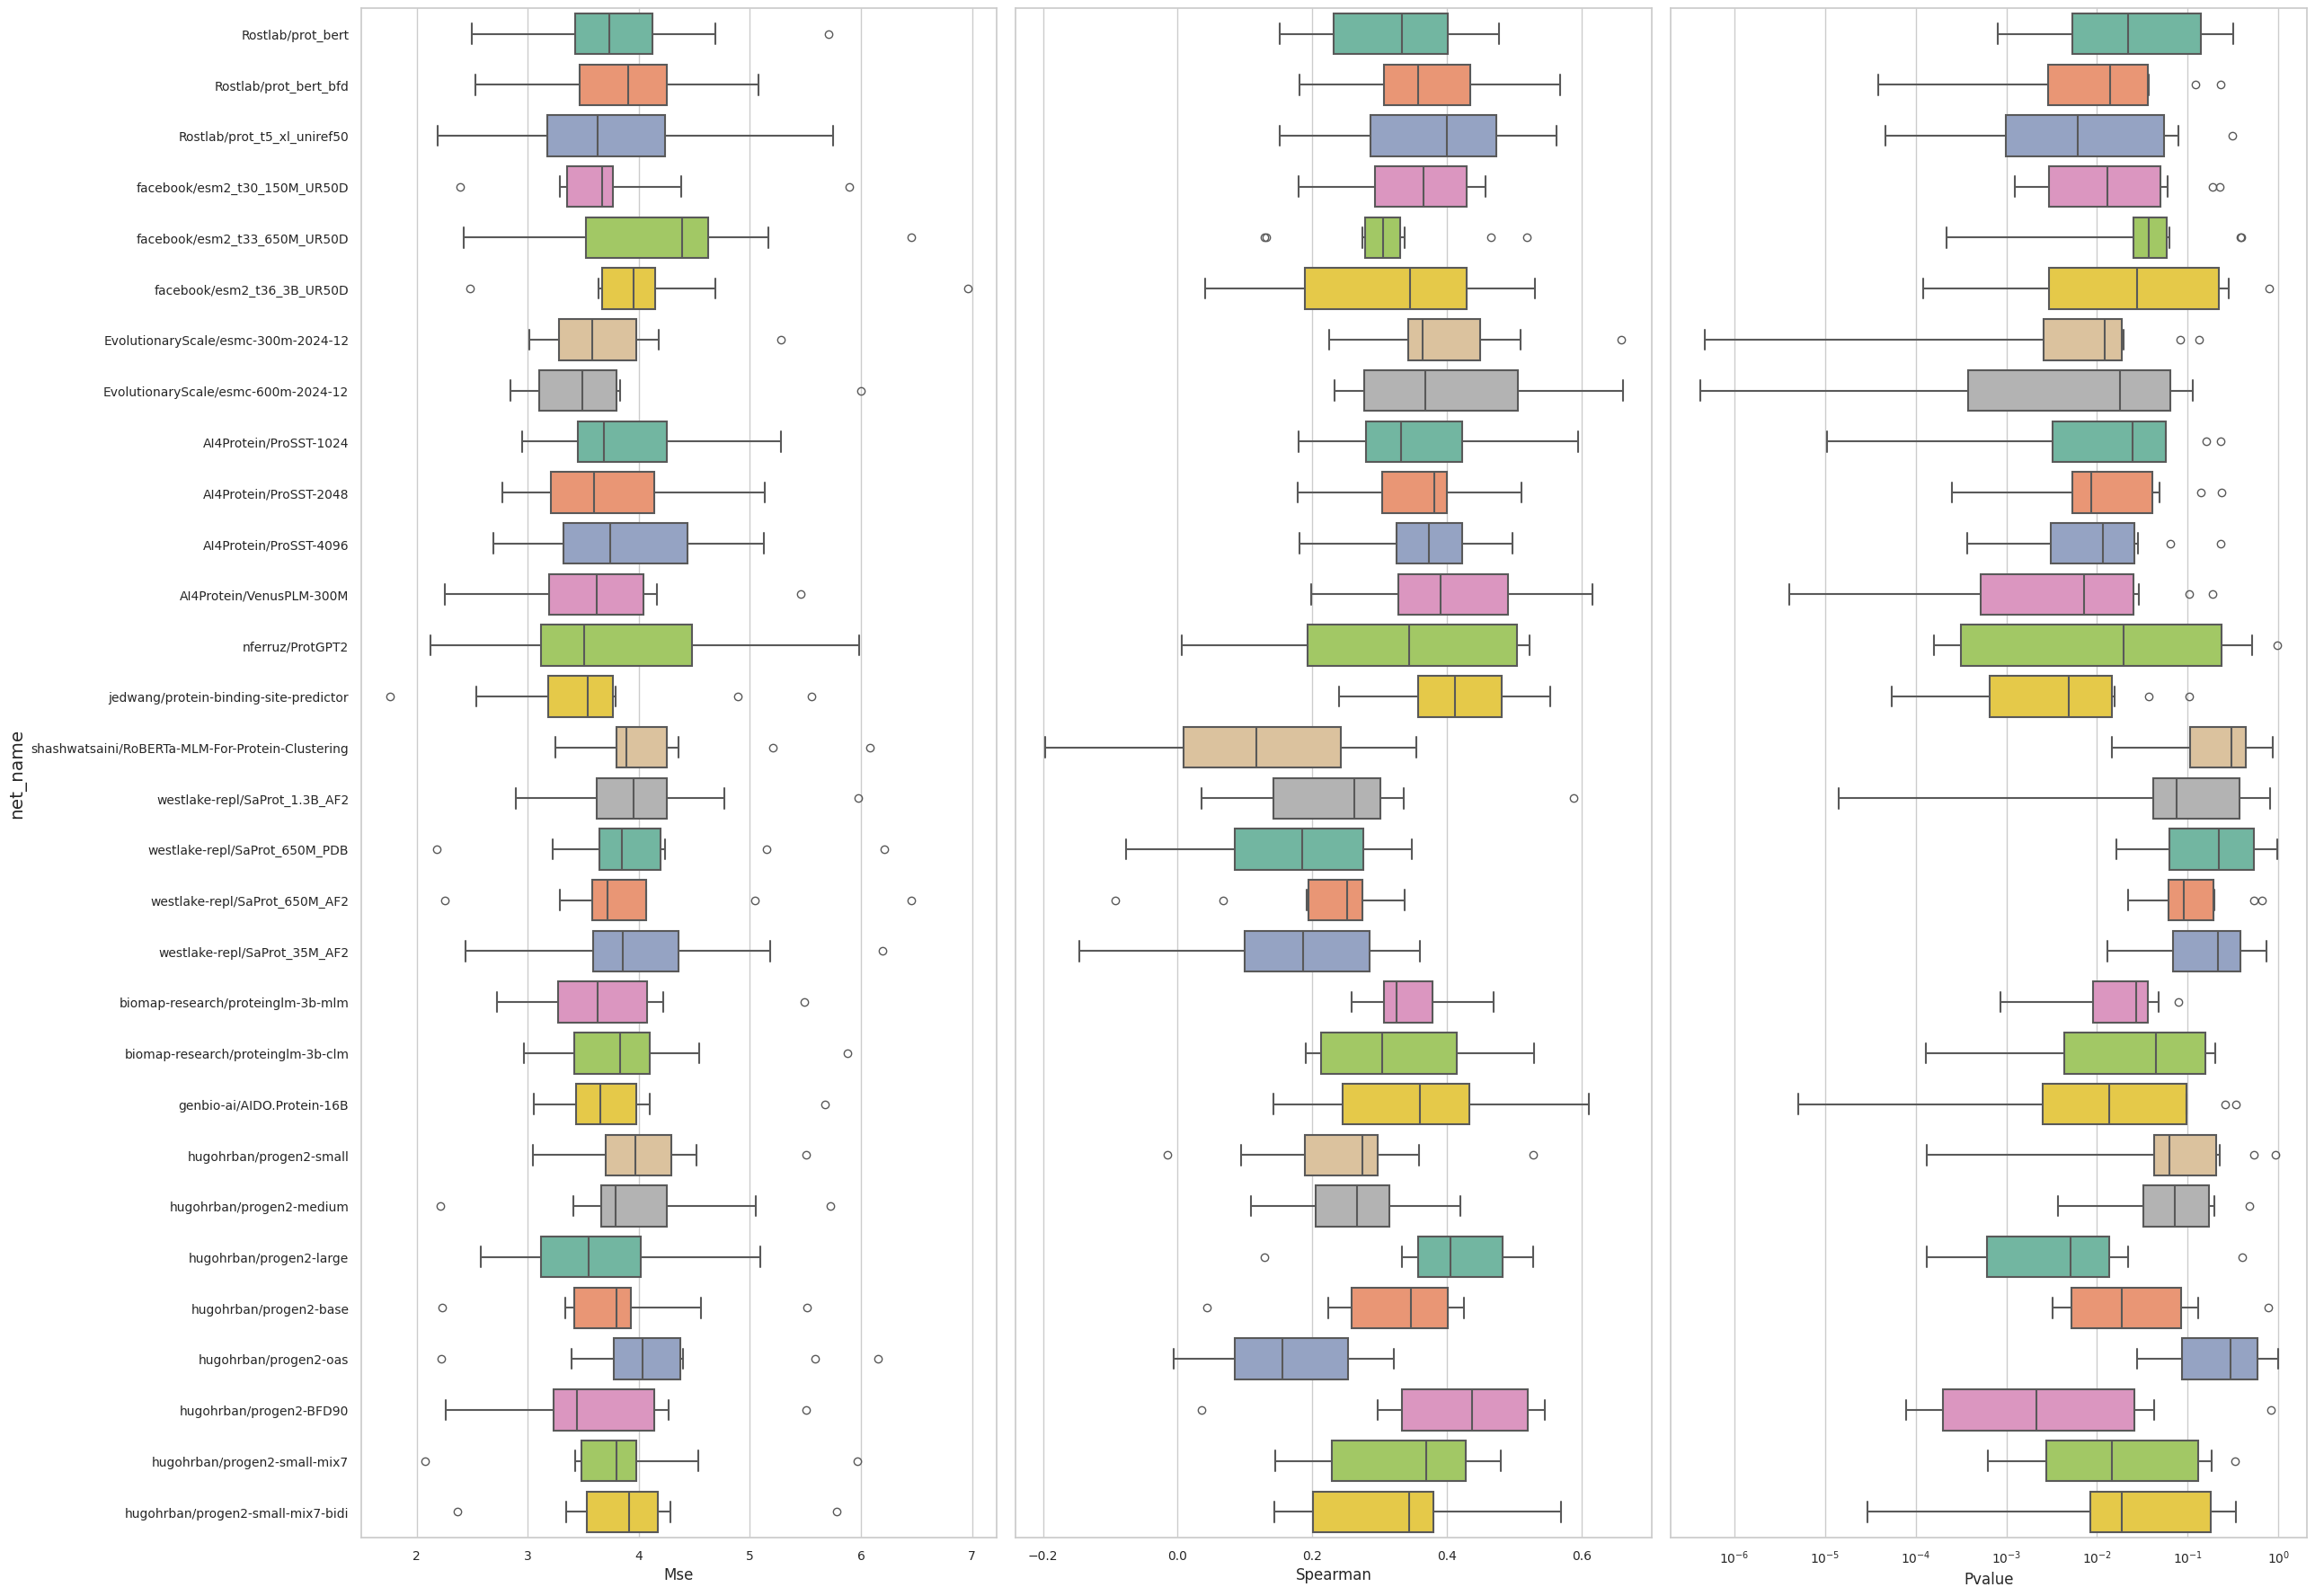

In [17]:
# === 构建 DataFrame ===
records = []
for model in results_cross:
    net_name = model["net_name"]
    for fold_idx, (mse, spearman, pvalue) in enumerate(model["results"]):
        records.append({
            "net_name": net_name,
            "fold": fold_idx + 1,
            "mse": mse,
            "spearman": spearman,
            "pvalue": pvalue
        })

df = pd.DataFrame(records)

# === 设置绘图风格 ===
sns.set(style="whitegrid", font_scale=1.2)
metrics = ["mse", "spearman", "pvalue"]
titles = ["MSE", "Spearman Correlation", "P-value"]

# === 创建子图（共享y轴） ===
fig, axes = plt.subplots(1, 3, figsize=(26, len(df["net_name"].unique()) * 0.6), sharey=True)

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=df,
        y="net_name",       # 模型名称作为纵坐标
        x=metric,           # 指标作为横坐标
        ax=axes[i],
        orient="h",         # 水平箱线图
        palette="Set2",     # 使用更柔和的调色板
        linewidth=1.5       # 增加线条宽度
    )
    # axes[i].set_title(titles[i], fontsize=14, weight="bold")
    axes[i].set_xlabel(metric.capitalize(), fontsize=12)
    axes[i].tick_params(axis="x", labelsize=10)
    axes[i].tick_params(axis="y", labelsize=10)
    if metric == "pvalue":
        axes[i].set_xscale("log")  # 对pvalue采用对数刻度
    if i != 0:
        axes[i].set_ylabel("")  # 只在第一个子图显示模型名

# === 调整布局 ===
plt.tight_layout()
plt.show()

# 4.模型训练

path_savemodel: /nas_data/mingxuan_model/prot_bert_01.pth


2025-07-14 02:39:08,985 - INFO - Epoch 1, train loss: 1.1345
2025-07-14 02:39:15,196 - INFO - valid loss: 0.8198


=> Saving checkpoint


2025-07-14 02:39:57,840 - INFO - Epoch 2, train loss: 0.9456
2025-07-14 02:40:04,125 - INFO - valid loss: 0.9073
2025-07-14 02:40:30,289 - INFO - Epoch 3, train loss: 0.8860
2025-07-14 02:40:36,539 - INFO - valid loss: 0.8471
2025-07-14 02:41:02,743 - INFO - Epoch 4, train loss: 0.8532
2025-07-14 02:41:09,186 - INFO - valid loss: 0.8428
2025-07-14 02:41:35,424 - INFO - Epoch 5, train loss: 0.8318
2025-07-14 02:41:41,720 - INFO - valid loss: 0.8171


=> Saving checkpoint


2025-07-14 02:42:24,988 - INFO - Epoch 6, train loss: 0.8045
2025-07-14 02:42:31,292 - INFO - valid loss: 0.8174
2025-07-14 02:42:57,536 - INFO - Epoch 7, train loss: 0.7768
2025-07-14 02:43:03,821 - INFO - valid loss: 0.7899


=> Saving checkpoint


2025-07-14 02:43:47,056 - INFO - Epoch 8, train loss: 0.7437
2025-07-14 02:43:53,252 - INFO - valid loss: 0.7484


=> Saving checkpoint


2025-07-14 02:44:36,467 - INFO - Epoch 9, train loss: 0.7044
2025-07-14 02:44:42,752 - INFO - valid loss: 0.8649
2025-07-14 02:45:09,013 - INFO - Epoch 10, train loss: 0.6692
2025-07-14 02:45:15,261 - INFO - valid loss: 0.8453
2025-07-14 02:45:41,459 - INFO - Epoch 11, train loss: 0.6199
2025-07-14 02:45:47,741 - INFO - valid loss: 0.7609
2025-07-14 02:46:13,986 - INFO - Epoch 12, train loss: 0.5821
2025-07-14 02:46:20,292 - INFO - valid loss: 0.8243
2025-07-14 02:46:46,527 - INFO - Epoch 13, train loss: 0.5531
2025-07-14 02:46:52,811 - INFO - valid loss: 0.7739
2025-07-14 02:47:19,083 - INFO - Epoch 14, train loss: 0.5246
2025-07-14 02:47:25,427 - INFO - valid loss: 0.9877
2025-07-14 02:47:51,703 - INFO - Epoch 15, train loss: 0.4881
2025-07-14 02:47:57,965 - INFO - valid loss: 0.7156


=> Saving checkpoint


2025-07-14 02:48:41,295 - INFO - Epoch 16, train loss: 0.4298
2025-07-14 02:48:47,550 - INFO - valid loss: 0.8785
2025-07-14 02:49:13,804 - INFO - Epoch 17, train loss: 0.3812
2025-07-14 02:49:20,061 - INFO - valid loss: 0.9965
2025-07-14 02:49:46,272 - INFO - Epoch 18, train loss: 0.3817
2025-07-14 02:49:52,522 - INFO - valid loss: 0.8416
2025-07-14 02:50:18,743 - INFO - Epoch 19, train loss: 0.3707
2025-07-14 02:50:25,101 - INFO - valid loss: 0.8427
2025-07-14 02:50:51,369 - INFO - Epoch 20, train loss: 0.3446
2025-07-14 02:50:57,699 - INFO - valid loss: 0.7385
2025-07-14 02:51:23,908 - INFO - Epoch 21, train loss: 0.2743
2025-07-14 02:51:30,193 - INFO - valid loss: 0.7632
2025-07-14 02:51:56,502 - INFO - Epoch 22, train loss: 0.2649
2025-07-14 02:52:02,783 - INFO - valid loss: 0.9171
2025-07-14 02:52:29,031 - INFO - Epoch 23, train loss: 0.2439
2025-07-14 02:52:35,322 - INFO - valid loss: 0.7774
2025-07-14 02:53:01,501 - INFO - Epoch 24, train loss: 0.2051
2025-07-14 02:53:07,789 - 

early stop at epoch 55
=> Training completed! Best loss is 0.7156 at epoch 15


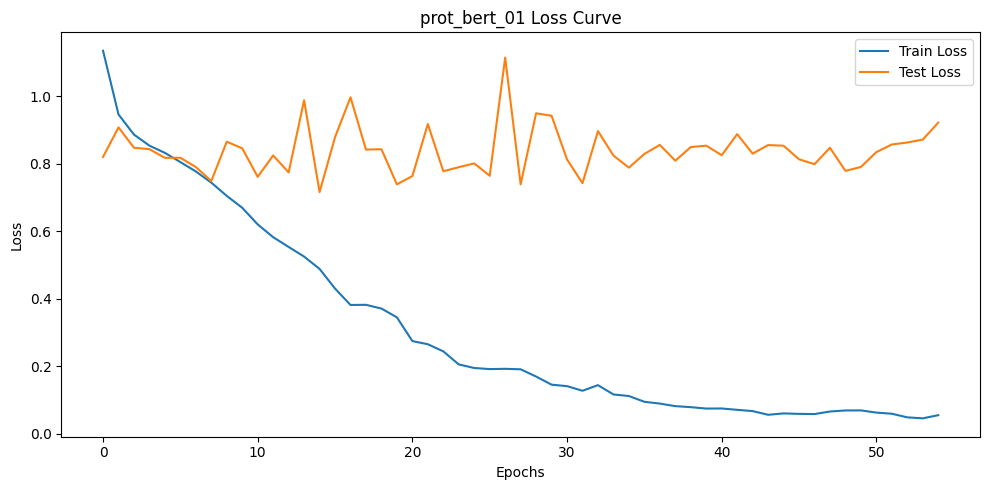

path_savemodel: /nas_data/mingxuan_model/prot_bert_bfd_01.pth


2025-07-14 03:10:30,286 - INFO - Epoch 1, train loss: 1.0861
2025-07-14 03:10:36,745 - INFO - valid loss: 0.8361


=> Saving checkpoint


2025-07-14 03:11:19,716 - INFO - Epoch 2, train loss: 0.8583
2025-07-14 03:11:26,191 - INFO - valid loss: 0.7807


=> Saving checkpoint


2025-07-14 03:12:09,591 - INFO - Epoch 3, train loss: 0.8019
2025-07-14 03:12:16,128 - INFO - valid loss: 0.8124
2025-07-14 03:12:42,524 - INFO - Epoch 4, train loss: 0.7356
2025-07-14 03:12:49,028 - INFO - valid loss: 0.8321
2025-07-14 03:13:15,448 - INFO - Epoch 5, train loss: 0.6944
2025-07-14 03:13:21,973 - INFO - valid loss: 0.7488


=> Saving checkpoint


2025-07-14 03:14:05,443 - INFO - Epoch 6, train loss: 0.6295
2025-07-14 03:14:11,922 - INFO - valid loss: 0.7861
2025-07-14 03:14:38,357 - INFO - Epoch 7, train loss: 0.6094
2025-07-14 03:14:44,856 - INFO - valid loss: 0.7672
2025-07-14 03:15:11,296 - INFO - Epoch 8, train loss: 0.5240
2025-07-14 03:15:17,796 - INFO - valid loss: 0.7622
2025-07-14 03:15:44,329 - INFO - Epoch 9, train loss: 0.4647
2025-07-14 03:15:50,843 - INFO - valid loss: 0.7941
2025-07-14 03:16:17,261 - INFO - Epoch 10, train loss: 0.4259
2025-07-14 03:16:23,806 - INFO - valid loss: 0.7283


=> Saving checkpoint


2025-07-14 03:17:07,266 - INFO - Epoch 11, train loss: 0.3833
2025-07-14 03:17:13,756 - INFO - valid loss: 0.7183


=> Saving checkpoint


2025-07-14 03:17:57,225 - INFO - Epoch 12, train loss: 0.3598
2025-07-14 03:18:03,689 - INFO - valid loss: 0.7192
2025-07-14 03:18:30,106 - INFO - Epoch 13, train loss: 0.3078
2025-07-14 03:18:36,679 - INFO - valid loss: 0.7763
2025-07-14 03:19:03,352 - INFO - Epoch 14, train loss: 0.2870
2025-07-14 03:19:09,912 - INFO - valid loss: 0.8688
2025-07-14 03:19:36,418 - INFO - Epoch 15, train loss: 0.2845
2025-07-14 03:19:42,946 - INFO - valid loss: 0.7501
2025-07-14 03:20:09,413 - INFO - Epoch 16, train loss: 0.2325
2025-07-14 03:20:15,927 - INFO - valid loss: 0.8480
2025-07-14 03:20:42,326 - INFO - Epoch 17, train loss: 0.2114
2025-07-14 03:20:48,849 - INFO - valid loss: 0.9186
2025-07-14 03:21:15,249 - INFO - Epoch 18, train loss: 0.2459
2025-07-14 03:21:21,793 - INFO - valid loss: 0.7241
2025-07-14 03:21:48,254 - INFO - Epoch 19, train loss: 0.1927
2025-07-14 03:21:54,725 - INFO - valid loss: 0.9459
2025-07-14 03:22:21,179 - INFO - Epoch 20, train loss: 0.1883
2025-07-14 03:22:27,754 - 

early stop at epoch 51
=> Training completed! Best loss is 0.7183 at epoch 11


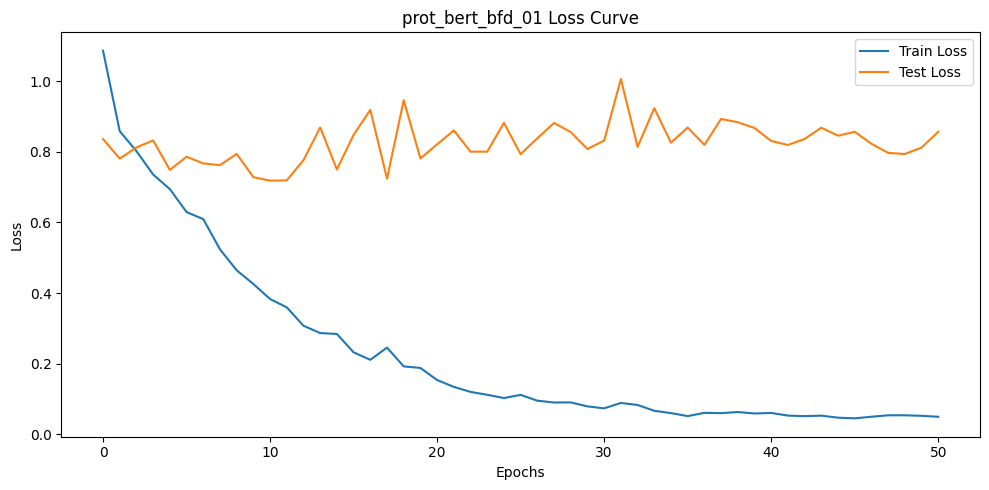

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


path_savemodel: /nas_data/mingxuan_model/prot_t5_01.pth


2025-07-14 03:41:05,662 - INFO - Epoch 1, train loss: 1.1521
2025-07-14 03:41:18,509 - INFO - valid loss: 0.8873


=> Saving checkpoint


2025-07-14 03:43:17,455 - INFO - Epoch 2, train loss: 0.8669
2025-07-14 03:43:30,316 - INFO - valid loss: 0.9988
2025-07-14 03:44:43,104 - INFO - Epoch 3, train loss: 0.8067
2025-07-14 03:44:55,939 - INFO - valid loss: 0.8411


=> Saving checkpoint


2025-07-14 03:46:55,540 - INFO - Epoch 4, train loss: 0.7505
2025-07-14 03:47:08,310 - INFO - valid loss: 0.9041
2025-07-14 03:48:20,989 - INFO - Epoch 5, train loss: 0.6889
2025-07-14 03:48:33,778 - INFO - valid loss: 0.8972
2025-07-14 03:49:46,450 - INFO - Epoch 6, train loss: 0.6195
2025-07-14 03:49:59,272 - INFO - valid loss: 0.8403


=> Saving checkpoint


2025-07-14 03:51:58,713 - INFO - Epoch 7, train loss: 0.5534
2025-07-14 03:52:11,430 - INFO - valid loss: 0.7863


=> Saving checkpoint


2025-07-14 03:54:10,872 - INFO - Epoch 8, train loss: 0.5139
2025-07-14 03:54:23,629 - INFO - valid loss: 0.7758


=> Saving checkpoint


2025-07-14 03:56:23,041 - INFO - Epoch 9, train loss: 0.4487
2025-07-14 03:56:35,846 - INFO - valid loss: 0.7841
2025-07-14 03:57:48,515 - INFO - Epoch 10, train loss: 0.3882
2025-07-14 03:58:01,327 - INFO - valid loss: 0.9192
2025-07-14 03:59:13,958 - INFO - Epoch 11, train loss: 0.3557
2025-07-14 03:59:26,742 - INFO - valid loss: 0.9158
2025-07-14 04:00:39,481 - INFO - Epoch 12, train loss: 0.3496
2025-07-14 04:00:52,301 - INFO - valid loss: 0.7477


=> Saving checkpoint


2025-07-14 04:02:51,421 - INFO - Epoch 13, train loss: 0.2727
2025-07-14 04:03:04,177 - INFO - valid loss: 0.7303


=> Saving checkpoint


2025-07-14 04:05:04,484 - INFO - Epoch 14, train loss: 0.2432
2025-07-14 04:05:17,273 - INFO - valid loss: 0.8169
2025-07-14 04:06:29,971 - INFO - Epoch 15, train loss: 0.2277
2025-07-14 04:06:42,731 - INFO - valid loss: 0.7943
2025-07-14 04:07:55,374 - INFO - Epoch 16, train loss: 0.1967
2025-07-14 04:08:08,164 - INFO - valid loss: 0.8045
2025-07-14 04:09:20,935 - INFO - Epoch 17, train loss: 0.1773
2025-07-14 04:09:33,731 - INFO - valid loss: 0.7716
2025-07-14 04:10:46,595 - INFO - Epoch 18, train loss: 0.1575
2025-07-14 04:10:59,374 - INFO - valid loss: 0.8366
2025-07-14 04:12:12,127 - INFO - Epoch 19, train loss: 0.1513
2025-07-14 04:12:24,913 - INFO - valid loss: 0.7895
2025-07-14 04:13:37,683 - INFO - Epoch 20, train loss: 0.1554
2025-07-14 04:13:50,506 - INFO - valid loss: 0.8303
2025-07-14 04:15:03,288 - INFO - Epoch 21, train loss: 0.1398
2025-07-14 04:15:16,035 - INFO - valid loss: 0.8321
2025-07-14 04:16:28,717 - INFO - Epoch 22, train loss: 0.1315
2025-07-14 04:16:41,576 - 

early stop at epoch 53
=> Training completed! Best loss is 0.7303 at epoch 13


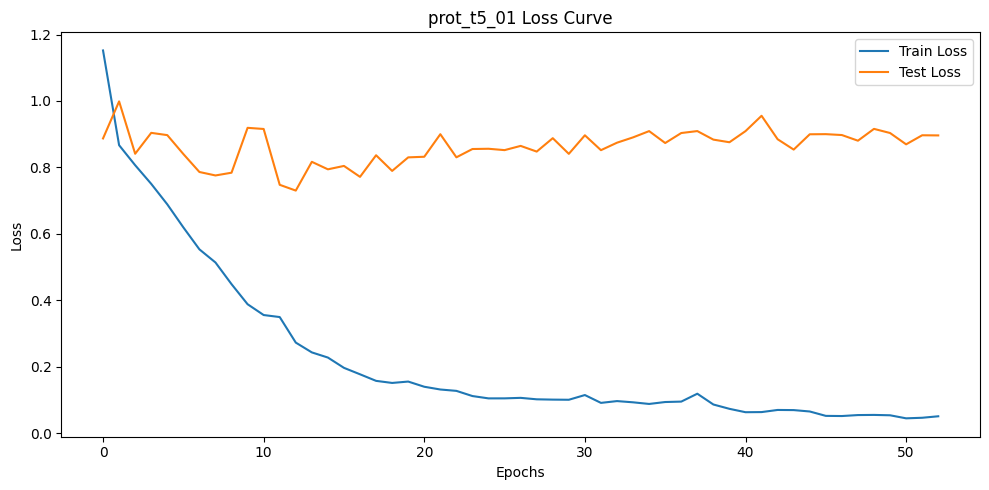

path_savemodel: /nas_data/mingxuan_model/esm2_t30_150m_01.pth


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 05:01:12,077 - INFO - Epoch 1, train loss: 1.1671
2025-07-14 05:01:17,894 - INFO - valid loss: 0.9687


=> Saving checkpoint


2025-07-14 05:01:51,654 - INFO - Epoch 2, train loss: 0.9458
2025-07-14 05:01:57,484 - INFO - valid loss: 0.8740


=> Saving checkpoint


2025-07-14 05:02:20,607 - INFO - Epoch 3, train loss: 0.9214
2025-07-14 05:02:26,499 - INFO - valid loss: 0.9177
2025-07-14 05:02:43,632 - INFO - Epoch 4, train loss: 0.8995
2025-07-14 05:02:49,477 - INFO - valid loss: 0.8509


=> Saving checkpoint


2025-07-14 05:03:12,707 - INFO - Epoch 5, train loss: 0.8782
2025-07-14 05:03:18,608 - INFO - valid loss: 0.8529
2025-07-14 05:03:35,633 - INFO - Epoch 6, train loss: 0.8683
2025-07-14 05:03:41,455 - INFO - valid loss: 0.9871
2025-07-14 05:03:58,502 - INFO - Epoch 7, train loss: 0.8723
2025-07-14 05:04:04,359 - INFO - valid loss: 0.8182


=> Saving checkpoint


2025-07-14 05:04:27,419 - INFO - Epoch 8, train loss: 0.8152
2025-07-14 05:04:33,284 - INFO - valid loss: 0.7931


=> Saving checkpoint


2025-07-14 05:04:56,434 - INFO - Epoch 9, train loss: 0.7849
2025-07-14 05:05:02,366 - INFO - valid loss: 0.9062
2025-07-14 05:05:19,337 - INFO - Epoch 10, train loss: 0.7539
2025-07-14 05:05:25,179 - INFO - valid loss: 0.9146
2025-07-14 05:05:42,326 - INFO - Epoch 11, train loss: 0.7166
2025-07-14 05:05:48,226 - INFO - valid loss: 0.9043
2025-07-14 05:06:05,250 - INFO - Epoch 12, train loss: 0.6938
2025-07-14 05:06:11,139 - INFO - valid loss: 0.7401


=> Saving checkpoint


2025-07-14 05:06:34,255 - INFO - Epoch 13, train loss: 0.6406
2025-07-14 05:06:40,116 - INFO - valid loss: 0.7686
2025-07-14 05:06:57,186 - INFO - Epoch 14, train loss: 0.5620
2025-07-14 05:07:03,052 - INFO - valid loss: 0.8612
2025-07-14 05:07:20,087 - INFO - Epoch 15, train loss: 0.5392
2025-07-14 05:07:25,913 - INFO - valid loss: 0.7937
2025-07-14 05:07:42,988 - INFO - Epoch 16, train loss: 0.5664
2025-07-14 05:07:48,852 - INFO - valid loss: 0.7787
2025-07-14 05:08:05,931 - INFO - Epoch 17, train loss: 0.5316
2025-07-14 05:08:11,840 - INFO - valid loss: 0.7499
2025-07-14 05:08:28,898 - INFO - Epoch 18, train loss: 0.4761
2025-07-14 05:08:34,718 - INFO - valid loss: 0.8806
2025-07-14 05:08:52,313 - INFO - Epoch 19, train loss: 0.4273
2025-07-14 05:08:58,227 - INFO - valid loss: 0.7580
2025-07-14 05:09:15,352 - INFO - Epoch 20, train loss: 0.4047
2025-07-14 05:09:21,220 - INFO - valid loss: 0.7833
2025-07-14 05:09:38,281 - INFO - Epoch 21, train loss: 0.4056
2025-07-14 05:09:44,076 - 

=> Saving checkpoint


2025-07-14 05:10:53,510 - INFO - Epoch 24, train loss: 0.3784
2025-07-14 05:10:59,377 - INFO - valid loss: 0.7507
2025-07-14 05:11:16,425 - INFO - Epoch 25, train loss: 0.3579
2025-07-14 05:11:22,283 - INFO - valid loss: 0.8782
2025-07-14 05:11:39,334 - INFO - Epoch 26, train loss: 0.3153
2025-07-14 05:11:45,189 - INFO - valid loss: 0.7099


=> Saving checkpoint


2025-07-14 05:12:08,273 - INFO - Epoch 27, train loss: 0.3031
2025-07-14 05:12:14,106 - INFO - valid loss: 0.7344
2025-07-14 05:12:31,147 - INFO - Epoch 28, train loss: 0.3118
2025-07-14 05:12:37,030 - INFO - valid loss: 0.7990
2025-07-14 05:12:54,118 - INFO - Epoch 29, train loss: 0.2632
2025-07-14 05:13:00,000 - INFO - valid loss: 0.7338
2025-07-14 05:13:17,029 - INFO - Epoch 30, train loss: 0.2550
2025-07-14 05:13:22,868 - INFO - valid loss: 0.6849


=> Saving checkpoint


2025-07-14 05:13:46,044 - INFO - Epoch 31, train loss: 0.2570
2025-07-14 05:13:51,895 - INFO - valid loss: 0.8693
2025-07-14 05:14:08,897 - INFO - Epoch 32, train loss: 0.2570
2025-07-14 05:14:14,790 - INFO - valid loss: 0.6947
2025-07-14 05:14:31,802 - INFO - Epoch 33, train loss: 0.2270
2025-07-14 05:14:37,655 - INFO - valid loss: 0.7511
2025-07-14 05:14:54,674 - INFO - Epoch 34, train loss: 0.2329
2025-07-14 05:15:00,489 - INFO - valid loss: 0.7215
2025-07-14 05:15:17,531 - INFO - Epoch 35, train loss: 0.2119
2025-07-14 05:15:23,407 - INFO - valid loss: 0.7208
2025-07-14 05:15:40,483 - INFO - Epoch 36, train loss: 0.1830
2025-07-14 05:15:46,366 - INFO - valid loss: 0.6968
2025-07-14 05:16:03,431 - INFO - Epoch 37, train loss: 0.1777
2025-07-14 05:16:09,257 - INFO - valid loss: 0.7590
2025-07-14 05:16:26,274 - INFO - Epoch 38, train loss: 0.1796
2025-07-14 05:16:32,202 - INFO - valid loss: 0.7168
2025-07-14 05:16:49,204 - INFO - Epoch 39, train loss: 0.1943
2025-07-14 05:16:55,109 - 

=> Saving checkpoint


2025-07-14 05:17:18,303 - INFO - Epoch 40, train loss: 0.1706
2025-07-14 05:17:24,160 - INFO - valid loss: 0.7258
2025-07-14 05:17:41,231 - INFO - Epoch 41, train loss: 0.1508
2025-07-14 05:17:47,071 - INFO - valid loss: 0.6840
2025-07-14 05:18:04,029 - INFO - Epoch 42, train loss: 0.1635
2025-07-14 05:18:09,908 - INFO - valid loss: 0.7303
2025-07-14 05:18:26,992 - INFO - Epoch 43, train loss: 0.1512
2025-07-14 05:18:32,900 - INFO - valid loss: 0.7098
2025-07-14 05:18:49,932 - INFO - Epoch 44, train loss: 0.1697
2025-07-14 05:18:55,858 - INFO - valid loss: 0.7111
2025-07-14 05:19:12,908 - INFO - Epoch 45, train loss: 0.1411
2025-07-14 05:19:18,775 - INFO - valid loss: 0.6662
2025-07-14 05:19:35,815 - INFO - Epoch 46, train loss: 0.1266
2025-07-14 05:19:41,656 - INFO - valid loss: 0.7613
2025-07-14 05:19:58,661 - INFO - Epoch 47, train loss: 0.1184
2025-07-14 05:20:04,551 - INFO - valid loss: 0.6767
2025-07-14 05:20:21,608 - INFO - Epoch 48, train loss: 0.1216
2025-07-14 05:20:27,500 - 

early stop at epoch 79
=> Training completed! Best loss is 0.6658 at epoch 39


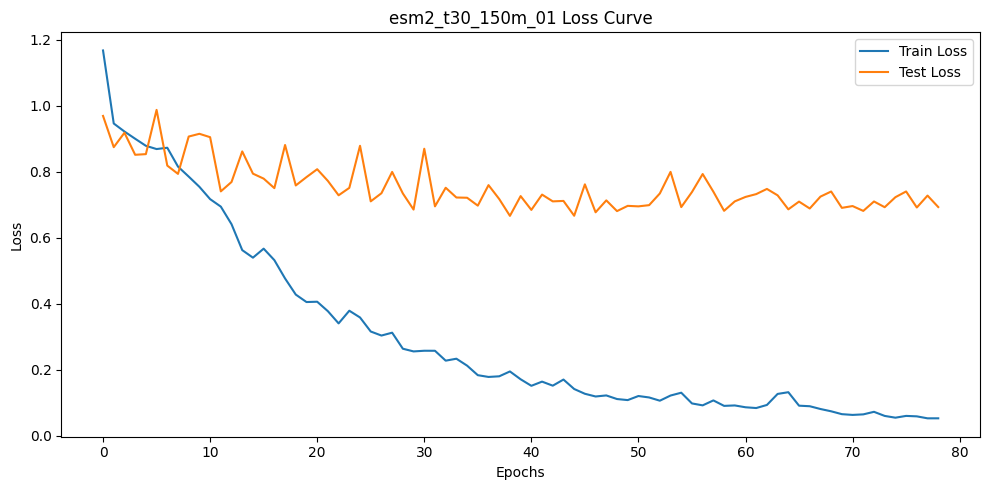

path_savemodel: /nas_data/mingxuan_model/esm2_t33_650m_01.pth


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 05:33:09,650 - INFO - Epoch 1, train loss: 1.0972
2025-07-14 05:33:18,878 - INFO - valid loss: 1.0238


=> Saving checkpoint


2025-07-14 05:34:28,497 - INFO - Epoch 2, train loss: 0.9225
2025-07-14 05:34:37,627 - INFO - valid loss: 0.9236


=> Saving checkpoint


2025-07-14 05:35:47,800 - INFO - Epoch 3, train loss: 0.9001
2025-07-14 05:35:57,046 - INFO - valid loss: 1.0405
2025-07-14 05:36:41,052 - INFO - Epoch 4, train loss: 0.8715
2025-07-14 05:36:50,267 - INFO - valid loss: 0.8607


=> Saving checkpoint


2025-07-14 05:38:00,632 - INFO - Epoch 5, train loss: 0.8347
2025-07-14 05:38:09,884 - INFO - valid loss: 0.8507


=> Saving checkpoint


2025-07-14 05:39:20,177 - INFO - Epoch 6, train loss: 0.7836
2025-07-14 05:39:29,466 - INFO - valid loss: 0.9210
2025-07-14 05:40:13,528 - INFO - Epoch 7, train loss: 0.7294
2025-07-14 05:40:22,803 - INFO - valid loss: 0.8178


=> Saving checkpoint


2025-07-14 05:41:33,096 - INFO - Epoch 8, train loss: 0.6739
2025-07-14 05:41:42,367 - INFO - valid loss: 0.9500
2025-07-14 05:42:26,442 - INFO - Epoch 9, train loss: 0.6363
2025-07-14 05:42:35,669 - INFO - valid loss: 0.7435


=> Saving checkpoint


2025-07-14 05:43:45,925 - INFO - Epoch 10, train loss: 0.5857
2025-07-14 05:43:55,113 - INFO - valid loss: 0.8882
2025-07-14 05:44:39,159 - INFO - Epoch 11, train loss: 0.5314
2025-07-14 05:44:48,406 - INFO - valid loss: 0.8546
2025-07-14 05:45:32,441 - INFO - Epoch 12, train loss: 0.5065
2025-07-14 05:45:41,672 - INFO - valid loss: 1.0229
2025-07-14 05:46:25,808 - INFO - Epoch 13, train loss: 0.5001
2025-07-14 05:46:35,045 - INFO - valid loss: 0.8522
2025-07-14 05:47:19,231 - INFO - Epoch 14, train loss: 0.4129
2025-07-14 05:47:28,431 - INFO - valid loss: 0.7336


=> Saving checkpoint


2025-07-14 05:48:38,634 - INFO - Epoch 15, train loss: 0.3637
2025-07-14 05:48:47,769 - INFO - valid loss: 1.0641
2025-07-14 05:49:31,882 - INFO - Epoch 16, train loss: 0.3767
2025-07-14 05:49:41,054 - INFO - valid loss: 0.7574
2025-07-14 05:50:25,248 - INFO - Epoch 17, train loss: 0.3014
2025-07-14 05:50:34,594 - INFO - valid loss: 0.7258


=> Saving checkpoint


2025-07-14 05:51:44,907 - INFO - Epoch 18, train loss: 0.2898
2025-07-14 05:51:54,100 - INFO - valid loss: 0.7490
2025-07-14 05:52:38,171 - INFO - Epoch 19, train loss: 0.3429
2025-07-14 05:52:47,435 - INFO - valid loss: 0.7030


=> Saving checkpoint


2025-07-14 05:53:57,669 - INFO - Epoch 20, train loss: 0.3488
2025-07-14 05:54:06,850 - INFO - valid loss: 1.2242
2025-07-14 05:54:50,876 - INFO - Epoch 21, train loss: 0.3958
2025-07-14 05:55:00,057 - INFO - valid loss: 0.7439
2025-07-14 05:55:44,212 - INFO - Epoch 22, train loss: 0.2695
2025-07-14 05:55:53,472 - INFO - valid loss: 0.9719
2025-07-14 05:56:37,614 - INFO - Epoch 23, train loss: 0.2411
2025-07-14 05:56:46,834 - INFO - valid loss: 0.8001
2025-07-14 05:57:31,008 - INFO - Epoch 24, train loss: 0.1996
2025-07-14 05:57:40,173 - INFO - valid loss: 0.7648
2025-07-14 05:58:24,218 - INFO - Epoch 25, train loss: 0.1787
2025-07-14 05:58:33,480 - INFO - valid loss: 0.7843
2025-07-14 05:59:17,569 - INFO - Epoch 26, train loss: 0.1706
2025-07-14 05:59:26,884 - INFO - valid loss: 0.7828
2025-07-14 06:00:11,089 - INFO - Epoch 27, train loss: 0.1625
2025-07-14 06:00:20,343 - INFO - valid loss: 0.6914


=> Saving checkpoint


2025-07-14 06:01:30,694 - INFO - Epoch 28, train loss: 0.1412
2025-07-14 06:01:39,854 - INFO - valid loss: 0.7676
2025-07-14 06:02:23,839 - INFO - Epoch 29, train loss: 0.1508
2025-07-14 06:02:33,046 - INFO - valid loss: 0.7941
2025-07-14 06:03:17,116 - INFO - Epoch 30, train loss: 0.1384
2025-07-14 06:03:26,338 - INFO - valid loss: 0.7081
2025-07-14 06:04:10,500 - INFO - Epoch 31, train loss: 0.1413
2025-07-14 06:04:19,684 - INFO - valid loss: 0.7000
2025-07-14 06:05:03,779 - INFO - Epoch 32, train loss: 0.1247
2025-07-14 06:05:13,044 - INFO - valid loss: 0.8220
2025-07-14 06:05:57,203 - INFO - Epoch 33, train loss: 0.1426
2025-07-14 06:06:06,424 - INFO - valid loss: 0.7023
2025-07-14 06:06:50,586 - INFO - Epoch 34, train loss: 0.1442
2025-07-14 06:06:59,752 - INFO - valid loss: 0.8102
2025-07-14 06:07:43,861 - INFO - Epoch 35, train loss: 0.1154
2025-07-14 06:07:53,155 - INFO - valid loss: 0.7528
2025-07-14 06:08:37,456 - INFO - Epoch 36, train loss: 0.1201
2025-07-14 06:08:46,698 - 

early stop at epoch 67
=> Training completed! Best loss is 0.6914 at epoch 27


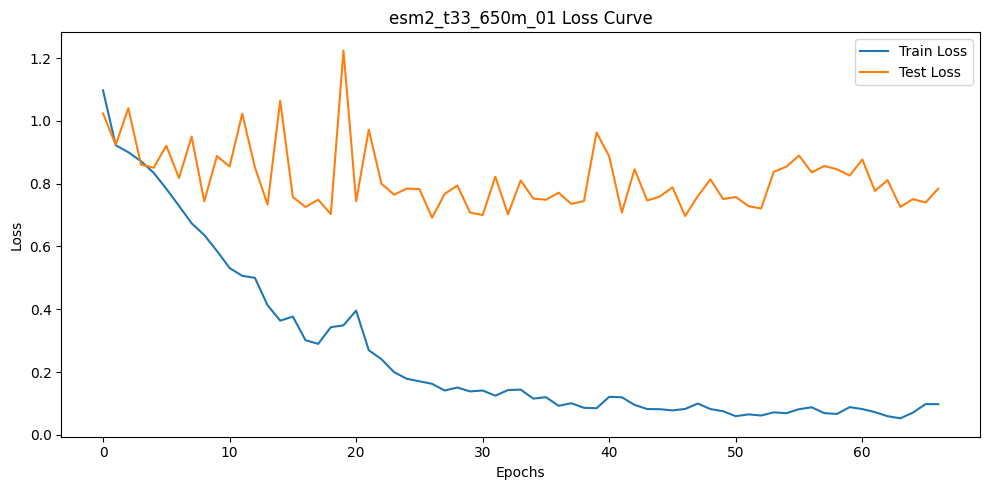

path_savemodel: /nas_data/mingxuan_model/esm2_t36_3b_01.pth


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 06:39:31,510 - INFO - Epoch 1, train loss: 1.1238
2025-07-14 06:39:56,241 - INFO - valid loss: 0.9618


=> Saving checkpoint


2025-07-14 06:44:22,549 - INFO - Epoch 2, train loss: 0.9234
2025-07-14 06:44:47,304 - INFO - valid loss: 0.9709
2025-07-14 06:47:25,955 - INFO - Epoch 3, train loss: 0.9080
2025-07-14 06:47:50,765 - INFO - valid loss: 0.8398


=> Saving checkpoint


2025-07-14 06:52:16,632 - INFO - Epoch 4, train loss: 0.8521
2025-07-14 06:52:41,542 - INFO - valid loss: 0.8488
2025-07-14 06:55:20,230 - INFO - Epoch 5, train loss: 0.8024
2025-07-14 06:55:44,980 - INFO - valid loss: 0.8336


=> Saving checkpoint


2025-07-14 07:00:10,515 - INFO - Epoch 6, train loss: 0.7550
2025-07-14 07:00:35,234 - INFO - valid loss: 0.8400
2025-07-14 07:03:13,774 - INFO - Epoch 7, train loss: 0.6889
2025-07-14 07:03:38,588 - INFO - valid loss: 0.7699


=> Saving checkpoint


2025-07-14 07:08:04,186 - INFO - Epoch 8, train loss: 0.6167
2025-07-14 07:08:28,981 - INFO - valid loss: 0.6970


=> Saving checkpoint


2025-07-14 07:12:58,178 - INFO - Epoch 9, train loss: 0.5617
2025-07-14 07:13:22,880 - INFO - valid loss: 0.9930
2025-07-14 07:16:01,514 - INFO - Epoch 10, train loss: 0.5350
2025-07-14 07:16:26,346 - INFO - valid loss: 0.9095
2025-07-14 07:19:05,022 - INFO - Epoch 11, train loss: 0.4780
2025-07-14 07:19:29,860 - INFO - valid loss: 0.8430
2025-07-14 07:22:08,636 - INFO - Epoch 12, train loss: 0.4504
2025-07-14 07:22:33,489 - INFO - valid loss: 0.7419
2025-07-14 07:25:12,201 - INFO - Epoch 13, train loss: 0.4112
2025-07-14 07:25:37,052 - INFO - valid loss: 0.8637
2025-07-14 07:28:15,760 - INFO - Epoch 14, train loss: 0.5268
2025-07-14 07:28:40,486 - INFO - valid loss: 1.1411
2025-07-14 07:31:19,100 - INFO - Epoch 15, train loss: 0.5233
2025-07-14 07:31:43,868 - INFO - valid loss: 1.0325
2025-07-14 07:34:22,637 - INFO - Epoch 16, train loss: 0.3723
2025-07-14 07:34:47,446 - INFO - valid loss: 0.7960
2025-07-14 07:37:26,074 - INFO - Epoch 17, train loss: 0.3013
2025-07-14 07:37:50,789 - I

early stop at epoch 48
=> Training completed! Best loss is 0.6970 at epoch 8


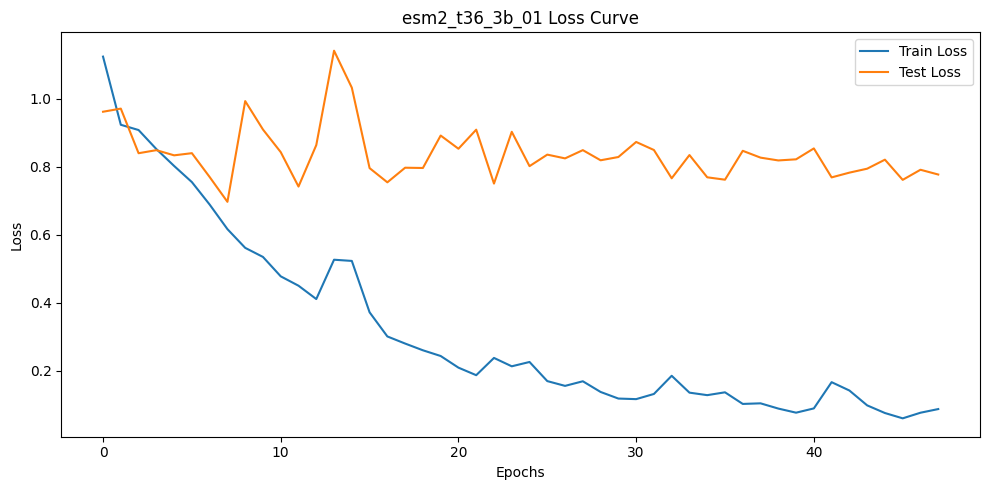

path_savemodel: /nas_data/mingxuan_model/esmc_300m_01.pth


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-14 09:13:24,954 - INFO - Epoch 1, train loss: 1.0953
2025-07-14 09:13:34,908 - INFO - valid loss: 0.9837


=> Saving checkpoint


2025-07-14 09:14:14,430 - INFO - Epoch 2, train loss: 0.9861
2025-07-14 09:14:24,283 - INFO - valid loss: 1.0116
2025-07-14 09:15:04,097 - INFO - Epoch 3, train loss: 0.9546
2025-07-14 09:15:14,025 - INFO - valid loss: 0.9631


=> Saving checkpoint


2025-07-14 09:15:54,413 - INFO - Epoch 4, train loss: 0.9274
2025-07-14 09:16:04,352 - INFO - valid loss: 0.9364


=> Saving checkpoint


2025-07-14 09:16:44,077 - INFO - Epoch 5, train loss: 0.9029
2025-07-14 09:16:54,010 - INFO - valid loss: 0.9541
2025-07-14 09:17:34,257 - INFO - Epoch 6, train loss: 0.8789
2025-07-14 09:17:44,138 - INFO - valid loss: 0.8794


=> Saving checkpoint


2025-07-14 09:18:23,951 - INFO - Epoch 7, train loss: 0.8530
2025-07-14 09:18:33,821 - INFO - valid loss: 0.9512
2025-07-14 09:19:13,558 - INFO - Epoch 8, train loss: 0.8404
2025-07-14 09:19:23,453 - INFO - valid loss: 1.0037
2025-07-14 09:20:03,437 - INFO - Epoch 9, train loss: 0.8370
2025-07-14 09:20:13,769 - INFO - valid loss: 0.9338
2025-07-14 09:20:53,123 - INFO - Epoch 10, train loss: 0.8051
2025-07-14 09:21:02,990 - INFO - valid loss: 0.8466


=> Saving checkpoint


2025-07-14 09:21:43,346 - INFO - Epoch 11, train loss: 0.7593
2025-07-14 09:21:53,161 - INFO - valid loss: 0.7606


=> Saving checkpoint


2025-07-14 09:22:32,327 - INFO - Epoch 12, train loss: 0.7857
2025-07-14 09:22:42,116 - INFO - valid loss: 0.7507


=> Saving checkpoint


2025-07-14 09:23:22,974 - INFO - Epoch 13, train loss: 0.7205
2025-07-14 09:23:32,946 - INFO - valid loss: 0.7383


=> Saving checkpoint


2025-07-14 09:24:14,189 - INFO - Epoch 14, train loss: 0.7479
2025-07-14 09:24:24,118 - INFO - valid loss: 0.7747
2025-07-14 09:25:04,304 - INFO - Epoch 15, train loss: 0.6648
2025-07-14 09:25:14,178 - INFO - valid loss: 0.8597
2025-07-14 09:25:53,832 - INFO - Epoch 16, train loss: 0.6550
2025-07-14 09:26:03,688 - INFO - valid loss: 0.7746
2025-07-14 09:26:43,405 - INFO - Epoch 17, train loss: 0.6205
2025-07-14 09:26:53,166 - INFO - valid loss: 0.8174
2025-07-14 09:27:34,258 - INFO - Epoch 18, train loss: 0.6355
2025-07-14 09:27:44,091 - INFO - valid loss: 0.7328


=> Saving checkpoint


2025-07-14 09:28:23,616 - INFO - Epoch 19, train loss: 0.5977
2025-07-14 09:28:33,524 - INFO - valid loss: 0.8238
2025-07-14 09:29:14,062 - INFO - Epoch 20, train loss: 0.5762
2025-07-14 09:29:23,955 - INFO - valid loss: 0.7212


=> Saving checkpoint


2025-07-14 09:30:03,540 - INFO - Epoch 21, train loss: 0.5567
2025-07-14 09:30:13,432 - INFO - valid loss: 0.7242
2025-07-14 09:30:52,984 - INFO - Epoch 22, train loss: 0.5442
2025-07-14 09:31:02,793 - INFO - valid loss: 0.7464
2025-07-14 09:31:43,176 - INFO - Epoch 23, train loss: 0.6058
2025-07-14 09:31:53,019 - INFO - valid loss: 1.0159
2025-07-14 09:32:32,583 - INFO - Epoch 24, train loss: 0.6334
2025-07-14 09:32:42,492 - INFO - valid loss: 0.9594
2025-07-14 09:33:21,944 - INFO - Epoch 25, train loss: 0.5216
2025-07-14 09:33:31,774 - INFO - valid loss: 0.7160


=> Saving checkpoint


2025-07-14 09:34:12,265 - INFO - Epoch 26, train loss: 0.5047
2025-07-14 09:34:22,064 - INFO - valid loss: 0.7744
2025-07-14 09:35:01,045 - INFO - Epoch 27, train loss: 0.4813
2025-07-14 09:35:11,038 - INFO - valid loss: 0.7655
2025-07-14 09:35:50,269 - INFO - Epoch 28, train loss: 0.4599
2025-07-14 09:36:00,233 - INFO - valid loss: 0.8294
2025-07-14 09:36:39,867 - INFO - Epoch 29, train loss: 0.4685
2025-07-14 09:36:49,748 - INFO - valid loss: 0.7260
2025-07-14 09:37:29,357 - INFO - Epoch 30, train loss: 0.4447
2025-07-14 09:37:39,335 - INFO - valid loss: 0.7289
2025-07-14 09:38:18,821 - INFO - Epoch 31, train loss: 0.4523
2025-07-14 09:38:28,603 - INFO - valid loss: 0.7156


=> Saving checkpoint


2025-07-14 09:39:07,765 - INFO - Epoch 32, train loss: 0.4138
2025-07-14 09:39:17,622 - INFO - valid loss: 0.7808
2025-07-14 09:39:56,884 - INFO - Epoch 33, train loss: 0.4120
2025-07-14 09:40:06,824 - INFO - valid loss: 0.7145


=> Saving checkpoint


2025-07-14 09:40:46,601 - INFO - Epoch 34, train loss: 0.4090
2025-07-14 09:40:56,392 - INFO - valid loss: 0.7183
2025-07-14 09:41:36,209 - INFO - Epoch 35, train loss: 0.4020
2025-07-14 09:41:46,091 - INFO - valid loss: 0.7203
2025-07-14 09:42:25,843 - INFO - Epoch 36, train loss: 0.4061
2025-07-14 09:42:35,892 - INFO - valid loss: 0.7689
2025-07-14 09:43:15,275 - INFO - Epoch 37, train loss: 0.3806
2025-07-14 09:43:25,227 - INFO - valid loss: 0.7856
2025-07-14 09:44:04,698 - INFO - Epoch 38, train loss: 0.3741
2025-07-14 09:44:14,510 - INFO - valid loss: 0.7333
2025-07-14 09:44:54,037 - INFO - Epoch 39, train loss: 0.3810
2025-07-14 09:45:03,888 - INFO - valid loss: 0.7815
2025-07-14 09:45:43,149 - INFO - Epoch 40, train loss: 0.3519
2025-07-14 09:45:53,045 - INFO - valid loss: 0.7844
2025-07-14 09:46:32,343 - INFO - Epoch 41, train loss: 0.3379
2025-07-14 09:46:42,206 - INFO - valid loss: 0.7345
2025-07-14 09:47:21,732 - INFO - Epoch 42, train loss: 0.3333
2025-07-14 09:47:31,676 - 

early stop at epoch 73
=> Training completed! Best loss is 0.7145 at epoch 33


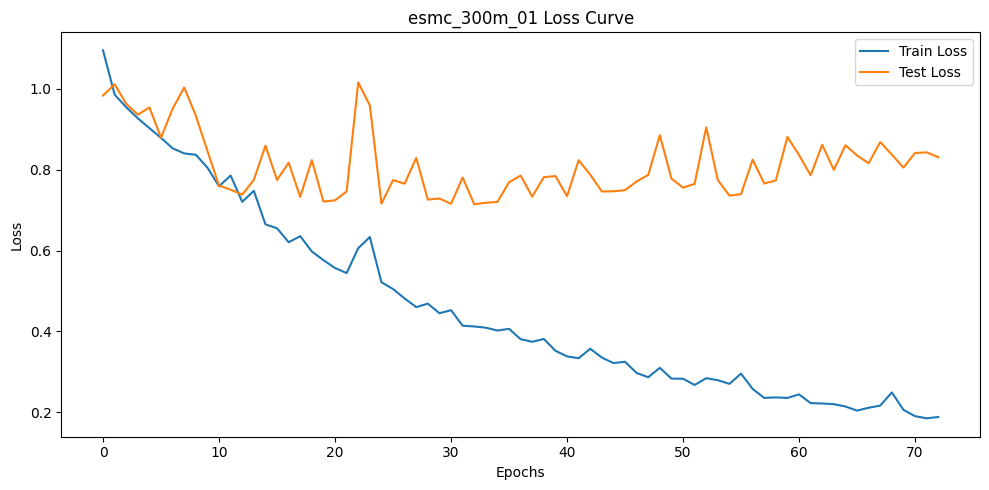

path_savemodel: /nas_data/mingxuan_model/esmc_600m_01.pth


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-14 10:13:58,685 - INFO - Epoch 1, train loss: 1.1999
2025-07-14 10:14:09,525 - INFO - valid loss: 1.0048


=> Saving checkpoint


2025-07-14 10:14:55,849 - INFO - Epoch 2, train loss: 0.9598
2025-07-14 10:15:06,687 - INFO - valid loss: 0.9067


=> Saving checkpoint


2025-07-14 10:15:53,089 - INFO - Epoch 3, train loss: 0.9360
2025-07-14 10:16:03,873 - INFO - valid loss: 0.9902
2025-07-14 10:16:49,834 - INFO - Epoch 4, train loss: 0.9008
2025-07-14 10:17:00,572 - INFO - valid loss: 0.8727


=> Saving checkpoint


2025-07-14 10:17:46,815 - INFO - Epoch 5, train loss: 0.8726
2025-07-14 10:17:57,785 - INFO - valid loss: 0.9111
2025-07-14 10:18:43,966 - INFO - Epoch 6, train loss: 0.8533
2025-07-14 10:18:54,711 - INFO - valid loss: 0.7927


=> Saving checkpoint


2025-07-14 10:19:41,251 - INFO - Epoch 7, train loss: 0.8187
2025-07-14 10:19:52,042 - INFO - valid loss: 0.9565
2025-07-14 10:20:38,016 - INFO - Epoch 8, train loss: 0.8109
2025-07-14 10:20:48,631 - INFO - valid loss: 0.8609
2025-07-14 10:21:34,770 - INFO - Epoch 9, train loss: 0.8001
2025-07-14 10:21:45,555 - INFO - valid loss: 0.8511
2025-07-14 10:22:31,924 - INFO - Epoch 10, train loss: 0.7698
2025-07-14 10:22:42,759 - INFO - valid loss: 0.9334
2025-07-14 10:23:29,127 - INFO - Epoch 11, train loss: 0.8128
2025-07-14 10:23:39,936 - INFO - valid loss: 1.1916
2025-07-14 10:24:26,112 - INFO - Epoch 12, train loss: 0.7672
2025-07-14 10:24:36,849 - INFO - valid loss: 0.7783


=> Saving checkpoint


2025-07-14 10:25:22,756 - INFO - Epoch 13, train loss: 0.6992
2025-07-14 10:25:33,522 - INFO - valid loss: 0.7529


=> Saving checkpoint


2025-07-14 10:26:19,278 - INFO - Epoch 14, train loss: 0.6769
2025-07-14 10:26:30,004 - INFO - valid loss: 0.7412


=> Saving checkpoint


2025-07-14 10:27:15,887 - INFO - Epoch 15, train loss: 0.6407
2025-07-14 10:27:26,536 - INFO - valid loss: 0.7133


=> Saving checkpoint


2025-07-14 10:28:12,450 - INFO - Epoch 16, train loss: 0.6275
2025-07-14 10:28:23,037 - INFO - valid loss: 0.7229
2025-07-14 10:29:09,427 - INFO - Epoch 17, train loss: 0.6237
2025-07-14 10:29:20,274 - INFO - valid loss: 0.8560
2025-07-14 10:30:09,277 - INFO - Epoch 18, train loss: 0.6182
2025-07-14 10:30:19,975 - INFO - valid loss: 0.9768
2025-07-14 10:31:05,787 - INFO - Epoch 19, train loss: 0.5991
2025-07-14 10:31:16,457 - INFO - valid loss: 0.7204
2025-07-14 10:32:03,137 - INFO - Epoch 20, train loss: 0.5599
2025-07-14 10:32:13,991 - INFO - valid loss: 0.7150
2025-07-14 10:32:59,891 - INFO - Epoch 21, train loss: 0.5473
2025-07-14 10:33:10,561 - INFO - valid loss: 0.7947
2025-07-14 10:33:56,418 - INFO - Epoch 22, train loss: 0.5286
2025-07-14 10:34:07,047 - INFO - valid loss: 0.8405
2025-07-14 10:34:53,107 - INFO - Epoch 23, train loss: 0.5491
2025-07-14 10:35:03,724 - INFO - valid loss: 0.7992
2025-07-14 10:35:49,682 - INFO - Epoch 24, train loss: 0.4802
2025-07-14 10:36:00,338 - 

=> Saving checkpoint


2025-07-14 10:38:40,844 - INFO - Epoch 27, train loss: 0.4626
2025-07-14 10:38:51,516 - INFO - valid loss: 0.8599
2025-07-14 10:39:38,045 - INFO - Epoch 28, train loss: 0.4328
2025-07-14 10:39:48,840 - INFO - valid loss: 0.8164
2025-07-14 10:40:35,499 - INFO - Epoch 29, train loss: 0.4418
2025-07-14 10:40:46,065 - INFO - valid loss: 0.7550
2025-07-14 10:41:31,770 - INFO - Epoch 30, train loss: 0.4161
2025-07-14 10:41:42,264 - INFO - valid loss: 0.7397
2025-07-14 10:42:28,189 - INFO - Epoch 31, train loss: 0.4213
2025-07-14 10:42:38,755 - INFO - valid loss: 0.7440
2025-07-14 10:43:25,381 - INFO - Epoch 32, train loss: 0.4330
2025-07-14 10:43:35,901 - INFO - valid loss: 0.8090
2025-07-14 10:44:21,519 - INFO - Epoch 33, train loss: 0.3886
2025-07-14 10:44:32,077 - INFO - valid loss: 0.7368
2025-07-14 10:45:18,003 - INFO - Epoch 34, train loss: 0.4057
2025-07-14 10:45:28,583 - INFO - valid loss: 0.8813
2025-07-14 10:46:14,691 - INFO - Epoch 35, train loss: 0.3712
2025-07-14 10:46:25,300 - 

early stop at epoch 66
=> Training completed! Best loss is 0.7099 at epoch 26


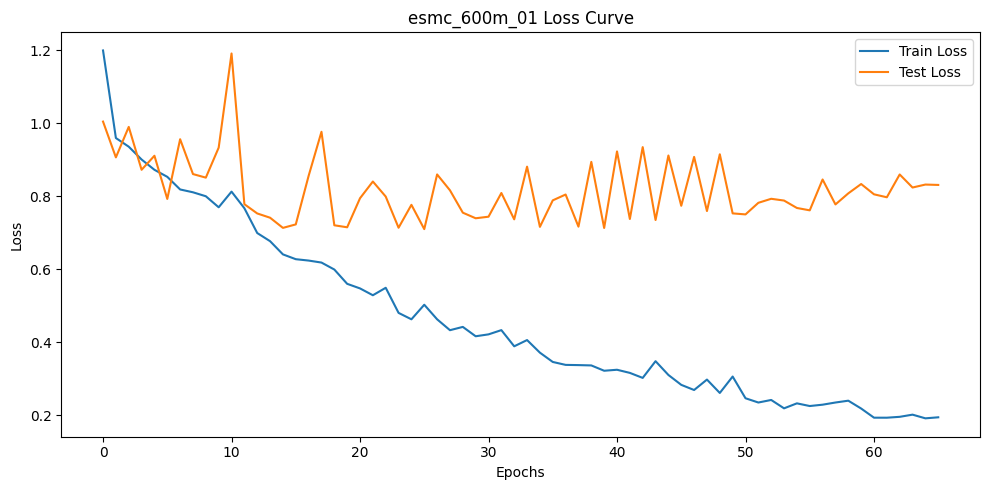

path_savemodel: /nas_data/mingxuan_model/ai4protein_prosst_1024_01.pth


2025-07-14 11:16:00,341 - INFO - Epoch 1, train loss: 1.1443
2025-07-14 11:16:06,123 - INFO - valid loss: 0.9521


=> Saving checkpoint


2025-07-14 11:16:25,828 - INFO - Epoch 2, train loss: 0.9951
2025-07-14 11:16:31,617 - INFO - valid loss: 1.0326
2025-07-14 11:16:46,696 - INFO - Epoch 3, train loss: 0.9840
2025-07-14 11:16:52,498 - INFO - valid loss: 0.9890
2025-07-14 11:17:07,695 - INFO - Epoch 4, train loss: 0.9841
2025-07-14 11:17:13,466 - INFO - valid loss: 0.9657
2025-07-14 11:17:28,571 - INFO - Epoch 5, train loss: 0.9762
2025-07-14 11:17:34,473 - INFO - valid loss: 0.9849
2025-07-14 11:17:49,571 - INFO - Epoch 6, train loss: 0.9526
2025-07-14 11:17:55,412 - INFO - valid loss: 0.9591
2025-07-14 11:18:10,510 - INFO - Epoch 7, train loss: 0.9414
2025-07-14 11:18:16,413 - INFO - valid loss: 0.9301


=> Saving checkpoint


2025-07-14 11:18:36,378 - INFO - Epoch 8, train loss: 0.9263
2025-07-14 11:18:42,201 - INFO - valid loss: 0.9853
2025-07-14 11:18:57,235 - INFO - Epoch 9, train loss: 0.9074
2025-07-14 11:19:03,074 - INFO - valid loss: 0.9476
2025-07-14 11:19:18,080 - INFO - Epoch 10, train loss: 0.8953
2025-07-14 11:19:23,857 - INFO - valid loss: 0.8891


=> Saving checkpoint


2025-07-14 11:19:43,601 - INFO - Epoch 11, train loss: 0.9270
2025-07-14 11:19:49,365 - INFO - valid loss: 0.9023
2025-07-14 11:20:04,420 - INFO - Epoch 12, train loss: 0.9141
2025-07-14 11:20:10,230 - INFO - valid loss: 0.8897
2025-07-14 11:20:25,333 - INFO - Epoch 13, train loss: 0.8564
2025-07-14 11:20:31,126 - INFO - valid loss: 0.9222
2025-07-14 11:20:46,156 - INFO - Epoch 14, train loss: 0.8333
2025-07-14 11:20:52,033 - INFO - valid loss: 0.9279
2025-07-14 11:21:07,121 - INFO - Epoch 15, train loss: 0.8193
2025-07-14 11:21:12,879 - INFO - valid loss: 1.3659
2025-07-14 11:21:27,859 - INFO - Epoch 16, train loss: 0.9099
2025-07-14 11:21:33,670 - INFO - valid loss: 1.0652
2025-07-14 11:21:48,712 - INFO - Epoch 17, train loss: 0.8332
2025-07-14 11:21:54,723 - INFO - valid loss: 1.0644
2025-07-14 11:22:09,810 - INFO - Epoch 18, train loss: 0.8161
2025-07-14 11:22:15,655 - INFO - valid loss: 0.8635


=> Saving checkpoint


2025-07-14 11:22:35,527 - INFO - Epoch 19, train loss: 0.8010
2025-07-14 11:22:41,372 - INFO - valid loss: 1.1499
2025-07-14 11:22:56,504 - INFO - Epoch 20, train loss: 0.8190
2025-07-14 11:23:02,312 - INFO - valid loss: 1.0865
2025-07-14 11:23:17,331 - INFO - Epoch 21, train loss: 0.8440
2025-07-14 11:23:23,129 - INFO - valid loss: 0.9620
2025-07-14 11:23:38,243 - INFO - Epoch 22, train loss: 0.8481
2025-07-14 11:23:44,057 - INFO - valid loss: 0.9642
2025-07-14 11:23:59,113 - INFO - Epoch 23, train loss: 0.8137
2025-07-14 11:24:04,917 - INFO - valid loss: 1.0198
2025-07-14 11:24:20,050 - INFO - Epoch 24, train loss: 0.8034
2025-07-14 11:24:25,865 - INFO - valid loss: 1.0495
2025-07-14 11:24:40,874 - INFO - Epoch 25, train loss: 0.8039
2025-07-14 11:24:46,646 - INFO - valid loss: 1.0647
2025-07-14 11:25:01,705 - INFO - Epoch 26, train loss: 0.7629
2025-07-14 11:25:07,534 - INFO - valid loss: 0.9088
2025-07-14 11:25:22,633 - INFO - Epoch 27, train loss: 0.7559
2025-07-14 11:25:28,410 - 

=> Saving checkpoint


2025-07-14 11:26:50,847 - INFO - Epoch 31, train loss: 0.7408
2025-07-14 11:26:56,596 - INFO - valid loss: 0.8390
2025-07-14 11:27:11,697 - INFO - Epoch 32, train loss: 0.7843
2025-07-14 11:27:17,494 - INFO - valid loss: 0.9489
2025-07-14 11:27:32,513 - INFO - Epoch 33, train loss: 0.8027
2025-07-14 11:27:38,306 - INFO - valid loss: 0.9167
2025-07-14 11:27:53,322 - INFO - Epoch 34, train loss: 0.7241
2025-07-14 11:27:59,116 - INFO - valid loss: 0.8356


=> Saving checkpoint


2025-07-14 11:28:18,993 - INFO - Epoch 35, train loss: 0.7286
2025-07-14 11:28:24,749 - INFO - valid loss: 0.9075
2025-07-14 11:28:39,762 - INFO - Epoch 36, train loss: 0.6770
2025-07-14 11:28:45,527 - INFO - valid loss: 0.9093
2025-07-14 11:29:00,547 - INFO - Epoch 37, train loss: 0.6677
2025-07-14 11:29:06,383 - INFO - valid loss: 0.8234


=> Saving checkpoint


2025-07-14 11:29:26,221 - INFO - Epoch 38, train loss: 0.6600
2025-07-14 11:29:32,047 - INFO - valid loss: 0.8802
2025-07-14 11:29:47,112 - INFO - Epoch 39, train loss: 0.6814
2025-07-14 11:29:52,929 - INFO - valid loss: 0.7526


=> Saving checkpoint


2025-07-14 11:30:12,797 - INFO - Epoch 40, train loss: 0.7136
2025-07-14 11:30:18,646 - INFO - valid loss: 0.7949
2025-07-14 11:30:33,711 - INFO - Epoch 41, train loss: 0.6589
2025-07-14 11:30:39,534 - INFO - valid loss: 1.0852
2025-07-14 11:30:54,594 - INFO - Epoch 42, train loss: 0.6658
2025-07-14 11:31:00,451 - INFO - valid loss: 0.8636
2025-07-14 11:31:15,538 - INFO - Epoch 43, train loss: 0.6361
2025-07-14 11:31:21,329 - INFO - valid loss: 0.8973
2025-07-14 11:31:36,374 - INFO - Epoch 44, train loss: 0.7005
2025-07-14 11:31:42,178 - INFO - valid loss: 1.0929
2025-07-14 11:31:57,247 - INFO - Epoch 45, train loss: 0.6697
2025-07-14 11:32:03,067 - INFO - valid loss: 0.8584
2025-07-14 11:32:18,155 - INFO - Epoch 46, train loss: 0.6161
2025-07-14 11:32:23,992 - INFO - valid loss: 1.0923
2025-07-14 11:32:39,011 - INFO - Epoch 47, train loss: 0.6625
2025-07-14 11:32:44,822 - INFO - valid loss: 0.8128
2025-07-14 11:32:59,852 - INFO - Epoch 48, train loss: 0.6491
2025-07-14 11:33:05,843 - 

=> Saving checkpoint


2025-07-14 11:35:51,921 - INFO - Epoch 56, train loss: 0.5609
2025-07-14 11:35:57,719 - INFO - valid loss: 1.0684
2025-07-14 11:36:12,853 - INFO - Epoch 57, train loss: 0.5893
2025-07-14 11:36:18,674 - INFO - valid loss: 0.7819
2025-07-14 11:36:33,771 - INFO - Epoch 58, train loss: 0.6011
2025-07-14 11:36:39,611 - INFO - valid loss: 0.8856
2025-07-14 11:36:54,617 - INFO - Epoch 59, train loss: 0.5911
2025-07-14 11:37:00,440 - INFO - valid loss: 0.9993
2025-07-14 11:37:15,537 - INFO - Epoch 60, train loss: 0.5650
2025-07-14 11:37:21,320 - INFO - valid loss: 0.7414
2025-07-14 11:37:36,406 - INFO - Epoch 61, train loss: 0.5561
2025-07-14 11:37:42,217 - INFO - valid loss: 0.8413
2025-07-14 11:37:57,271 - INFO - Epoch 62, train loss: 0.5314
2025-07-14 11:38:03,028 - INFO - valid loss: 0.8077
2025-07-14 11:38:17,971 - INFO - Epoch 63, train loss: 0.5235
2025-07-14 11:38:23,850 - INFO - valid loss: 0.8522
2025-07-14 11:38:38,887 - INFO - Epoch 64, train loss: 0.6121
2025-07-14 11:38:44,689 - 

=> Saving checkpoint


2025-07-14 11:41:09,658 - INFO - Epoch 71, train loss: 0.5413
2025-07-14 11:41:15,519 - INFO - valid loss: 0.8857
2025-07-14 11:41:30,593 - INFO - Epoch 72, train loss: 0.4826
2025-07-14 11:41:36,409 - INFO - valid loss: 0.7408
2025-07-14 11:41:51,531 - INFO - Epoch 73, train loss: 0.5808
2025-07-14 11:41:57,314 - INFO - valid loss: 0.7286
2025-07-14 11:42:12,387 - INFO - Epoch 74, train loss: 0.5307
2025-07-14 11:42:18,180 - INFO - valid loss: 0.9386
2025-07-14 11:42:33,173 - INFO - Epoch 75, train loss: 0.5389
2025-07-14 11:42:39,014 - INFO - valid loss: 0.6885


=> Saving checkpoint


2025-07-14 11:42:58,901 - INFO - Epoch 76, train loss: 0.5320
2025-07-14 11:43:04,698 - INFO - valid loss: 1.0941
2025-07-14 11:43:19,798 - INFO - Epoch 77, train loss: 0.5630
2025-07-14 11:43:25,619 - INFO - valid loss: 0.8150
2025-07-14 11:43:40,688 - INFO - Epoch 78, train loss: 0.4747
2025-07-14 11:43:46,569 - INFO - valid loss: 0.7596
2025-07-14 11:44:01,659 - INFO - Epoch 79, train loss: 0.4468
2025-07-14 11:44:07,417 - INFO - valid loss: 0.7900
2025-07-14 11:44:22,461 - INFO - Epoch 80, train loss: 0.4520
2025-07-14 11:44:28,321 - INFO - valid loss: 0.7872
2025-07-14 11:44:43,375 - INFO - Epoch 81, train loss: 0.4972
2025-07-14 11:44:49,160 - INFO - valid loss: 0.7848
2025-07-14 11:45:04,220 - INFO - Epoch 82, train loss: 0.4603
2025-07-14 11:45:10,079 - INFO - valid loss: 0.7583
2025-07-14 11:45:25,191 - INFO - Epoch 83, train loss: 0.4584
2025-07-14 11:45:31,068 - INFO - valid loss: 0.9434
2025-07-14 11:45:46,114 - INFO - Epoch 84, train loss: 0.4217
2025-07-14 11:45:51,886 - 

=> Saving checkpoint


2025-07-14 11:46:53,664 - INFO - Epoch 87, train loss: 0.4572
2025-07-14 11:46:59,530 - INFO - valid loss: 0.7790
2025-07-14 11:47:14,619 - INFO - Epoch 88, train loss: 0.4492
2025-07-14 11:47:20,560 - INFO - valid loss: 0.8917
2025-07-14 11:47:35,659 - INFO - Epoch 89, train loss: 0.4599
2025-07-14 11:47:41,499 - INFO - valid loss: 0.7494
2025-07-14 11:47:56,584 - INFO - Epoch 90, train loss: 0.4192
2025-07-14 11:48:02,406 - INFO - valid loss: 0.7079
2025-07-14 11:48:17,520 - INFO - Epoch 91, train loss: 0.4041
2025-07-14 11:48:23,405 - INFO - valid loss: 0.8940
2025-07-14 11:48:38,443 - INFO - Epoch 92, train loss: 0.4608
2025-07-14 11:48:44,255 - INFO - valid loss: 0.7177
2025-07-14 11:48:59,364 - INFO - Epoch 93, train loss: 0.5159
2025-07-14 11:49:05,141 - INFO - valid loss: 0.9502
2025-07-14 11:49:20,188 - INFO - Epoch 94, train loss: 0.4197
2025-07-14 11:49:26,022 - INFO - valid loss: 0.7480
2025-07-14 11:49:41,097 - INFO - Epoch 95, train loss: 0.4318
2025-07-14 11:49:46,867 - 

=> Saving checkpoint


2025-07-14 11:57:26,849 - INFO - Epoch 117, train loss: 0.3639
2025-07-14 11:57:32,612 - INFO - valid loss: 0.7027
2025-07-14 11:57:47,721 - INFO - Epoch 118, train loss: 0.3153
2025-07-14 11:57:53,590 - INFO - valid loss: 0.7233
2025-07-14 11:58:08,751 - INFO - Epoch 119, train loss: 0.3001
2025-07-14 11:58:14,561 - INFO - valid loss: 0.7995
2025-07-14 11:58:29,673 - INFO - Epoch 120, train loss: 0.2952
2025-07-14 11:58:35,461 - INFO - valid loss: 0.7762
2025-07-14 11:58:50,573 - INFO - Epoch 121, train loss: 0.2773
2025-07-14 11:58:56,409 - INFO - valid loss: 0.7925
2025-07-14 11:59:11,527 - INFO - Epoch 122, train loss: 0.2985
2025-07-14 11:59:17,338 - INFO - valid loss: 0.7694
2025-07-14 11:59:32,432 - INFO - Epoch 123, train loss: 0.2627
2025-07-14 11:59:38,272 - INFO - valid loss: 0.8196
2025-07-14 11:59:53,336 - INFO - Epoch 124, train loss: 0.2853
2025-07-14 11:59:59,083 - INFO - valid loss: 0.8387
2025-07-14 12:00:14,115 - INFO - Epoch 125, train loss: 0.2754
2025-07-14 12:00:

early stop at epoch 156
=> Training completed! Best loss is 0.6353 at epoch 116


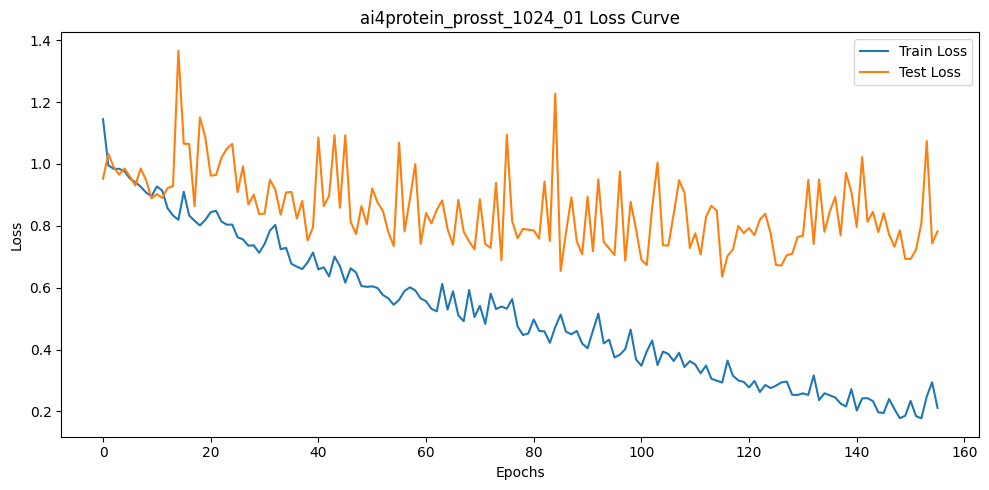

path_savemodel: /nas_data/mingxuan_model/ai4protein_prosst_2048_01.pth


2025-07-14 12:11:26,858 - INFO - Epoch 1, train loss: 1.1499
2025-07-14 12:11:32,649 - INFO - valid loss: 0.9660


=> Saving checkpoint


2025-07-14 12:11:52,455 - INFO - Epoch 2, train loss: 1.0115
2025-07-14 12:11:58,295 - INFO - valid loss: 1.0350
2025-07-14 12:12:13,425 - INFO - Epoch 3, train loss: 1.0031
2025-07-14 12:12:19,198 - INFO - valid loss: 0.9278


=> Saving checkpoint


2025-07-14 12:12:39,067 - INFO - Epoch 4, train loss: 0.9915
2025-07-14 12:12:44,867 - INFO - valid loss: 1.0298
2025-07-14 12:12:59,843 - INFO - Epoch 5, train loss: 0.9791
2025-07-14 12:13:05,559 - INFO - valid loss: 0.9658
2025-07-14 12:13:20,648 - INFO - Epoch 6, train loss: 0.9663
2025-07-14 12:13:26,521 - INFO - valid loss: 1.0096
2025-07-14 12:13:41,555 - INFO - Epoch 7, train loss: 0.9585
2025-07-14 12:13:47,361 - INFO - valid loss: 0.9400
2025-07-14 12:14:02,463 - INFO - Epoch 8, train loss: 0.9508
2025-07-14 12:14:08,312 - INFO - valid loss: 1.0283
2025-07-14 12:14:23,447 - INFO - Epoch 9, train loss: 0.9423
2025-07-14 12:14:29,266 - INFO - valid loss: 1.0218
2025-07-14 12:14:44,399 - INFO - Epoch 10, train loss: 0.9355
2025-07-14 12:14:50,337 - INFO - valid loss: 0.8988


=> Saving checkpoint


2025-07-14 12:15:10,247 - INFO - Epoch 11, train loss: 0.9299
2025-07-14 12:15:16,118 - INFO - valid loss: 0.8955


=> Saving checkpoint


2025-07-14 12:15:36,069 - INFO - Epoch 12, train loss: 0.9090
2025-07-14 12:15:41,890 - INFO - valid loss: 0.8848


=> Saving checkpoint


2025-07-14 12:16:01,801 - INFO - Epoch 13, train loss: 0.9380
2025-07-14 12:16:07,604 - INFO - valid loss: 0.8621


=> Saving checkpoint


2025-07-14 12:16:27,489 - INFO - Epoch 14, train loss: 0.8809
2025-07-14 12:16:33,291 - INFO - valid loss: 0.9897
2025-07-14 12:16:48,322 - INFO - Epoch 15, train loss: 0.8560
2025-07-14 12:16:54,109 - INFO - valid loss: 1.0046
2025-07-14 12:17:09,144 - INFO - Epoch 16, train loss: 0.8236
2025-07-14 12:17:15,041 - INFO - valid loss: 0.9408
2025-07-14 12:17:30,133 - INFO - Epoch 17, train loss: 0.8237
2025-07-14 12:17:35,889 - INFO - valid loss: 1.0094
2025-07-14 12:17:50,939 - INFO - Epoch 18, train loss: 0.7806
2025-07-14 12:17:56,779 - INFO - valid loss: 0.9771
2025-07-14 12:18:11,878 - INFO - Epoch 19, train loss: 0.7716
2025-07-14 12:18:17,661 - INFO - valid loss: 0.8274


=> Saving checkpoint


2025-07-14 12:18:37,589 - INFO - Epoch 20, train loss: 0.7627
2025-07-14 12:18:43,399 - INFO - valid loss: 1.0681
2025-07-14 12:18:58,530 - INFO - Epoch 21, train loss: 0.7918
2025-07-14 12:19:04,383 - INFO - valid loss: 0.8211


=> Saving checkpoint


2025-07-14 12:19:24,355 - INFO - Epoch 22, train loss: 0.7422
2025-07-14 12:19:30,212 - INFO - valid loss: 1.0067
2025-07-14 12:19:45,213 - INFO - Epoch 23, train loss: 0.7139
2025-07-14 12:19:50,977 - INFO - valid loss: 0.8388
2025-07-14 12:20:06,002 - INFO - Epoch 24, train loss: 0.7272
2025-07-14 12:20:11,828 - INFO - valid loss: 0.7927


=> Saving checkpoint


2025-07-14 12:20:31,777 - INFO - Epoch 25, train loss: 0.7041
2025-07-14 12:20:37,577 - INFO - valid loss: 0.8290
2025-07-14 12:20:52,691 - INFO - Epoch 26, train loss: 0.6822
2025-07-14 12:20:58,512 - INFO - valid loss: 1.0244
2025-07-14 12:21:13,631 - INFO - Epoch 27, train loss: 0.6788
2025-07-14 12:21:19,543 - INFO - valid loss: 0.8670
2025-07-14 12:21:34,574 - INFO - Epoch 28, train loss: 0.6647
2025-07-14 12:21:40,427 - INFO - valid loss: 0.7947
2025-07-14 12:21:55,484 - INFO - Epoch 29, train loss: 0.6629
2025-07-14 12:22:01,347 - INFO - valid loss: 0.7963
2025-07-14 12:22:16,403 - INFO - Epoch 30, train loss: 0.6758
2025-07-14 12:22:22,214 - INFO - valid loss: 0.8905
2025-07-14 12:22:37,290 - INFO - Epoch 31, train loss: 0.7183
2025-07-14 12:22:43,076 - INFO - valid loss: 0.7800


=> Saving checkpoint


2025-07-14 12:23:02,955 - INFO - Epoch 32, train loss: 0.6518
2025-07-14 12:23:08,788 - INFO - valid loss: 0.9142
2025-07-14 12:23:23,822 - INFO - Epoch 33, train loss: 0.6423
2025-07-14 12:23:29,601 - INFO - valid loss: 1.2335
2025-07-14 12:23:44,719 - INFO - Epoch 34, train loss: 0.6667
2025-07-14 12:23:50,570 - INFO - valid loss: 0.8789
2025-07-14 12:24:05,706 - INFO - Epoch 35, train loss: 0.6324
2025-07-14 12:24:11,594 - INFO - valid loss: 0.7835
2025-07-14 12:24:26,704 - INFO - Epoch 36, train loss: 0.6540
2025-07-14 12:24:32,516 - INFO - valid loss: 0.9411
2025-07-14 12:24:47,596 - INFO - Epoch 37, train loss: 0.5845
2025-07-14 12:24:53,451 - INFO - valid loss: 0.8149
2025-07-14 12:25:08,506 - INFO - Epoch 38, train loss: 0.5841
2025-07-14 12:25:14,294 - INFO - valid loss: 0.8114
2025-07-14 12:25:29,380 - INFO - Epoch 39, train loss: 0.6148
2025-07-14 12:25:35,233 - INFO - valid loss: 1.0568
2025-07-14 12:25:50,296 - INFO - Epoch 40, train loss: 0.7005
2025-07-14 12:25:56,092 - 

early stop at epoch 71
=> Training completed! Best loss is 0.7800 at epoch 31


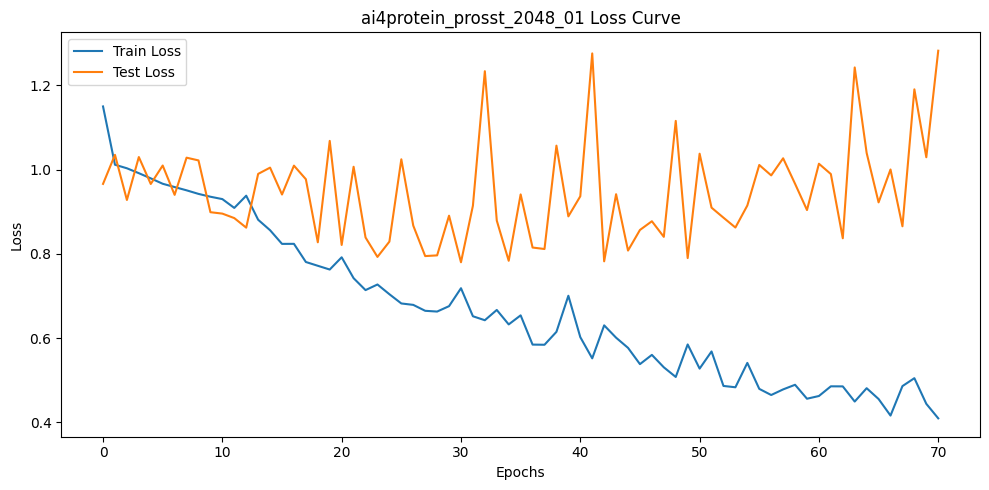

path_savemodel: /nas_data/mingxuan_model/ai4protein_prosst_4096_01.pth


2025-07-14 12:37:02,382 - INFO - Epoch 1, train loss: 1.5204
2025-07-14 12:37:08,232 - INFO - valid loss: 0.9191


=> Saving checkpoint


2025-07-14 12:37:28,068 - INFO - Epoch 2, train loss: 1.0237
2025-07-14 12:37:33,936 - INFO - valid loss: 1.1257
2025-07-14 12:37:49,086 - INFO - Epoch 3, train loss: 1.0048
2025-07-14 12:37:54,912 - INFO - valid loss: 0.9814
2025-07-14 12:38:09,956 - INFO - Epoch 4, train loss: 0.9891
2025-07-14 12:38:15,779 - INFO - valid loss: 1.0122
2025-07-14 12:38:30,953 - INFO - Epoch 5, train loss: 0.9861
2025-07-14 12:38:36,862 - INFO - valid loss: 1.0037
2025-07-14 12:38:52,019 - INFO - Epoch 6, train loss: 0.9782
2025-07-14 12:38:57,812 - INFO - valid loss: 0.9736
2025-07-14 12:39:12,821 - INFO - Epoch 7, train loss: 0.9716
2025-07-14 12:39:18,653 - INFO - valid loss: 1.0031
2025-07-14 12:39:33,714 - INFO - Epoch 8, train loss: 0.9729
2025-07-14 12:39:39,538 - INFO - valid loss: 1.0339
2025-07-14 12:39:54,659 - INFO - Epoch 9, train loss: 0.9699
2025-07-14 12:40:00,600 - INFO - valid loss: 0.9592
2025-07-14 12:40:15,707 - INFO - Epoch 10, train loss: 0.9595
2025-07-14 12:40:21,517 - INFO - v

=> Saving checkpoint


2025-07-14 12:44:32,198 - INFO - Epoch 22, train loss: 0.8563
2025-07-14 12:44:38,021 - INFO - valid loss: 0.9280
2025-07-14 12:44:53,118 - INFO - Epoch 23, train loss: 0.8449
2025-07-14 12:44:58,931 - INFO - valid loss: 1.1089
2025-07-14 12:45:13,949 - INFO - Epoch 24, train loss: 0.8416
2025-07-14 12:45:19,777 - INFO - valid loss: 1.0538
2025-07-14 12:45:34,864 - INFO - Epoch 25, train loss: 0.8400
2025-07-14 12:45:40,678 - INFO - valid loss: 0.9227
2025-07-14 12:45:55,787 - INFO - Epoch 26, train loss: 0.8413
2025-07-14 12:46:01,665 - INFO - valid loss: 1.0748
2025-07-14 12:46:16,735 - INFO - Epoch 27, train loss: 0.8503
2025-07-14 12:46:22,599 - INFO - valid loss: 1.2989
2025-07-14 12:46:37,708 - INFO - Epoch 28, train loss: 0.8159
2025-07-14 12:46:43,524 - INFO - valid loss: 1.0118
2025-07-14 12:46:58,669 - INFO - Epoch 29, train loss: 0.7945
2025-07-14 12:47:04,472 - INFO - valid loss: 0.9309
2025-07-14 12:47:19,515 - INFO - Epoch 30, train loss: 0.8046
2025-07-14 12:47:25,384 - 

=> Saving checkpoint


2025-07-14 12:53:20,156 - INFO - Epoch 47, train loss: 0.7429
2025-07-14 12:53:26,086 - INFO - valid loss: 1.0355
2025-07-14 12:53:41,222 - INFO - Epoch 48, train loss: 0.7040
2025-07-14 12:53:47,104 - INFO - valid loss: 0.9455
2025-07-14 12:54:02,197 - INFO - Epoch 49, train loss: 0.6925
2025-07-14 12:54:08,087 - INFO - valid loss: 0.9877
2025-07-14 12:54:23,218 - INFO - Epoch 50, train loss: 0.6844
2025-07-14 12:54:29,024 - INFO - valid loss: 1.0105
2025-07-14 12:54:44,183 - INFO - Epoch 51, train loss: 0.6747
2025-07-14 12:54:50,047 - INFO - valid loss: 0.9302
2025-07-14 12:55:05,168 - INFO - Epoch 52, train loss: 0.6766
2025-07-14 12:55:10,976 - INFO - valid loss: 0.9616
2025-07-14 12:55:26,117 - INFO - Epoch 53, train loss: 0.6466
2025-07-14 12:55:31,992 - INFO - valid loss: 1.0435
2025-07-14 12:55:47,048 - INFO - Epoch 54, train loss: 0.6598
2025-07-14 12:55:52,902 - INFO - valid loss: 1.0437
2025-07-14 12:56:07,963 - INFO - Epoch 55, train loss: 0.6572
2025-07-14 12:56:13,789 - 

=> Saving checkpoint


2025-07-14 12:58:39,936 - INFO - Epoch 62, train loss: 0.6149
2025-07-14 12:58:45,767 - INFO - valid loss: 0.9689
2025-07-14 12:59:00,891 - INFO - Epoch 63, train loss: 0.6544
2025-07-14 12:59:06,643 - INFO - valid loss: 0.9515
2025-07-14 12:59:21,677 - INFO - Epoch 64, train loss: 0.6108
2025-07-14 12:59:27,492 - INFO - valid loss: 0.8814
2025-07-14 12:59:42,562 - INFO - Epoch 65, train loss: 0.6721
2025-07-14 12:59:48,374 - INFO - valid loss: 1.0488
2025-07-14 13:00:03,553 - INFO - Epoch 66, train loss: 0.6489
2025-07-14 13:00:09,473 - INFO - valid loss: 0.9131
2025-07-14 13:00:24,675 - INFO - Epoch 67, train loss: 0.6370
2025-07-14 13:00:30,539 - INFO - valid loss: 1.1033
2025-07-14 13:00:45,643 - INFO - Epoch 68, train loss: 0.6634
2025-07-14 13:00:51,454 - INFO - valid loss: 0.8617
2025-07-14 13:01:06,708 - INFO - Epoch 69, train loss: 0.6603
2025-07-14 13:01:12,571 - INFO - valid loss: 1.1925
2025-07-14 13:01:27,728 - INFO - Epoch 70, train loss: 0.5945
2025-07-14 13:01:33,557 - 

=> Saving checkpoint


2025-07-14 13:05:02,103 - INFO - Epoch 80, train loss: 0.5407
2025-07-14 13:05:08,008 - INFO - valid loss: 1.0263
2025-07-14 13:05:23,128 - INFO - Epoch 81, train loss: 0.5381
2025-07-14 13:05:28,875 - INFO - valid loss: 0.9337
2025-07-14 13:05:43,945 - INFO - Epoch 82, train loss: 0.5939
2025-07-14 13:05:49,833 - INFO - valid loss: 0.9240
2025-07-14 13:06:05,345 - INFO - Epoch 83, train loss: 0.6040
2025-07-14 13:06:11,139 - INFO - valid loss: 0.8631
2025-07-14 13:06:26,144 - INFO - Epoch 84, train loss: 0.5736
2025-07-14 13:06:31,944 - INFO - valid loss: 0.9993
2025-07-14 13:06:46,975 - INFO - Epoch 85, train loss: 0.5703
2025-07-14 13:06:52,827 - INFO - valid loss: 0.9093
2025-07-14 13:07:07,919 - INFO - Epoch 86, train loss: 0.5232
2025-07-14 13:07:13,683 - INFO - valid loss: 1.0300
2025-07-14 13:07:28,751 - INFO - Epoch 87, train loss: 0.4949
2025-07-14 13:07:34,522 - INFO - valid loss: 1.0013
2025-07-14 13:07:49,570 - INFO - Epoch 88, train loss: 0.5781
2025-07-14 13:07:55,420 - 

=> Saving checkpoint


2025-07-14 13:10:42,048 - INFO - Epoch 96, train loss: 0.4731
2025-07-14 13:10:47,827 - INFO - valid loss: 0.8829
2025-07-14 13:11:02,887 - INFO - Epoch 97, train loss: 0.4445
2025-07-14 13:11:08,722 - INFO - valid loss: 0.9014
2025-07-14 13:11:23,690 - INFO - Epoch 98, train loss: 0.4508
2025-07-14 13:11:29,529 - INFO - valid loss: 0.9337
2025-07-14 13:11:44,590 - INFO - Epoch 99, train loss: 0.5271
2025-07-14 13:11:50,415 - INFO - valid loss: 1.0263
2025-07-14 13:12:05,571 - INFO - Epoch 100, train loss: 0.4602
2025-07-14 13:12:11,443 - INFO - valid loss: 1.1320
2025-07-14 13:12:26,527 - INFO - Epoch 101, train loss: 0.4270
2025-07-14 13:12:32,348 - INFO - valid loss: 0.7974


=> Saving checkpoint


2025-07-14 13:12:52,312 - INFO - Epoch 102, train loss: 0.4531
2025-07-14 13:12:58,149 - INFO - valid loss: 0.9806
2025-07-14 13:13:13,307 - INFO - Epoch 103, train loss: 0.4210
2025-07-14 13:13:19,144 - INFO - valid loss: 0.8096
2025-07-14 13:13:34,200 - INFO - Epoch 104, train loss: 0.5581
2025-07-14 13:13:40,011 - INFO - valid loss: 1.3753
2025-07-14 13:13:55,048 - INFO - Epoch 105, train loss: 0.5093
2025-07-14 13:14:00,895 - INFO - valid loss: 0.8491
2025-07-14 13:14:15,990 - INFO - Epoch 106, train loss: 0.4208
2025-07-14 13:14:21,794 - INFO - valid loss: 0.8748
2025-07-14 13:14:36,882 - INFO - Epoch 107, train loss: 0.4833
2025-07-14 13:14:42,691 - INFO - valid loss: 0.8946
2025-07-14 13:14:57,759 - INFO - Epoch 108, train loss: 0.4273
2025-07-14 13:15:03,579 - INFO - valid loss: 0.9000
2025-07-14 13:15:18,648 - INFO - Epoch 109, train loss: 0.3835
2025-07-14 13:15:24,463 - INFO - valid loss: 0.8504
2025-07-14 13:15:39,486 - INFO - Epoch 110, train loss: 0.4200
2025-07-14 13:15:

=> Saving checkpoint


2025-07-14 13:20:16,280 - INFO - Epoch 123, train loss: 0.4221
2025-07-14 13:20:22,089 - INFO - valid loss: 1.0425
2025-07-14 13:20:37,083 - INFO - Epoch 124, train loss: 0.4159
2025-07-14 13:20:42,908 - INFO - valid loss: 1.0912
2025-07-14 13:20:57,953 - INFO - Epoch 125, train loss: 0.3784
2025-07-14 13:21:03,828 - INFO - valid loss: 0.8919
2025-07-14 13:21:18,909 - INFO - Epoch 126, train loss: 0.3272
2025-07-14 13:21:24,788 - INFO - valid loss: 0.7976
2025-07-14 13:21:39,895 - INFO - Epoch 127, train loss: 0.3337
2025-07-14 13:21:45,858 - INFO - valid loss: 0.9857
2025-07-14 13:22:00,897 - INFO - Epoch 128, train loss: 0.3948
2025-07-14 13:22:06,722 - INFO - valid loss: 1.2538
2025-07-14 13:22:21,776 - INFO - Epoch 129, train loss: 0.4046
2025-07-14 13:22:27,635 - INFO - valid loss: 0.8720
2025-07-14 13:22:42,676 - INFO - Epoch 130, train loss: 0.3677
2025-07-14 13:22:48,503 - INFO - valid loss: 0.9047
2025-07-14 13:23:03,604 - INFO - Epoch 131, train loss: 0.3603
2025-07-14 13:23:

early stop at epoch 162
=> Training completed! Best loss is 0.7776 at epoch 122


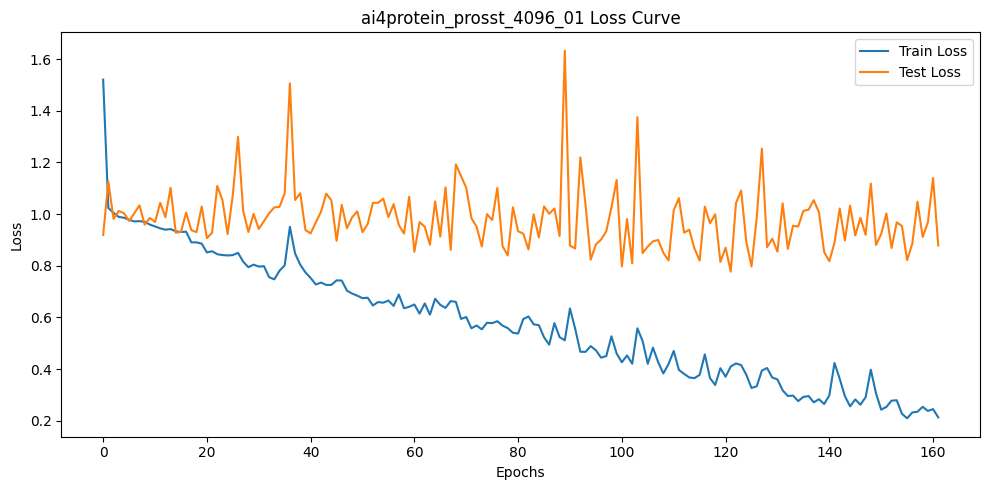

path_savemodel: /nas_data/mingxuan_model/venusplm_300m_01.pth


2025-07-14 13:34:51,248 - INFO - Epoch 1, train loss: 1.1281
2025-07-14 13:35:00,945 - INFO - valid loss: 0.8981


=> Saving checkpoint


2025-07-14 13:36:00,456 - INFO - Epoch 2, train loss: 0.9743
2025-07-14 13:36:10,658 - INFO - valid loss: 1.0733
2025-07-14 13:36:58,284 - INFO - Epoch 3, train loss: 0.9784
2025-07-14 13:37:08,335 - INFO - valid loss: 0.9385
2025-07-14 13:37:54,614 - INFO - Epoch 4, train loss: 0.9467
2025-07-14 13:38:04,670 - INFO - valid loss: 0.9707
2025-07-14 13:38:50,908 - INFO - Epoch 5, train loss: 0.9325
2025-07-14 13:39:00,919 - INFO - valid loss: 1.0102
2025-07-14 13:39:47,496 - INFO - Epoch 6, train loss: 0.9303
2025-07-14 13:39:57,243 - INFO - valid loss: 0.9053
2025-07-14 13:40:44,163 - INFO - Epoch 7, train loss: 0.9056
2025-07-14 13:40:54,321 - INFO - valid loss: 0.9894
2025-07-14 13:41:42,229 - INFO - Epoch 8, train loss: 0.9035
2025-07-14 13:41:52,097 - INFO - valid loss: 1.0936
2025-07-14 13:42:39,685 - INFO - Epoch 9, train loss: 0.8875
2025-07-14 13:42:49,982 - INFO - valid loss: 0.9495
2025-07-14 13:43:37,620 - INFO - Epoch 10, train loss: 0.8577
2025-07-14 13:43:47,582 - INFO - v

=> Saving checkpoint


2025-07-14 13:44:46,028 - INFO - Epoch 11, train loss: 0.9502
2025-07-14 13:44:56,136 - INFO - valid loss: 0.8615
2025-07-14 13:45:43,177 - INFO - Epoch 12, train loss: 0.9130
2025-07-14 13:45:53,000 - INFO - valid loss: 0.9586
2025-07-14 13:46:39,048 - INFO - Epoch 13, train loss: 0.9094
2025-07-14 13:46:49,101 - INFO - valid loss: 1.0634
2025-07-14 13:47:36,126 - INFO - Epoch 14, train loss: 0.8697
2025-07-14 13:47:45,872 - INFO - valid loss: 0.8909
2025-07-14 13:48:32,297 - INFO - Epoch 15, train loss: 0.8576
2025-07-14 13:48:42,196 - INFO - valid loss: 0.9023
2025-07-14 13:49:28,591 - INFO - Epoch 16, train loss: 0.8239
2025-07-14 13:49:38,512 - INFO - valid loss: 0.9306
2025-07-14 13:50:24,656 - INFO - Epoch 17, train loss: 0.8171
2025-07-14 13:50:34,633 - INFO - valid loss: 0.9784
2025-07-14 13:51:23,702 - INFO - Epoch 18, train loss: 0.8121
2025-07-14 13:51:33,671 - INFO - valid loss: 0.8913
2025-07-14 13:52:22,082 - INFO - Epoch 19, train loss: 0.7962
2025-07-14 13:52:32,272 - 

=> Saving checkpoint


2025-07-14 13:56:21,388 - INFO - Epoch 23, train loss: 0.7803
2025-07-14 13:56:31,300 - INFO - valid loss: 0.9575
2025-07-14 13:57:18,816 - INFO - Epoch 24, train loss: 0.7727
2025-07-14 13:57:28,920 - INFO - valid loss: 0.8255


=> Saving checkpoint


2025-07-14 13:58:28,115 - INFO - Epoch 25, train loss: 0.8246
2025-07-14 13:58:38,377 - INFO - valid loss: 0.8159


=> Saving checkpoint


2025-07-14 13:59:38,191 - INFO - Epoch 26, train loss: 0.7865
2025-07-14 13:59:48,069 - INFO - valid loss: 0.8742
2025-07-14 14:00:35,933 - INFO - Epoch 27, train loss: 0.7981
2025-07-14 14:00:46,126 - INFO - valid loss: 0.8143


=> Saving checkpoint


2025-07-14 14:01:44,240 - INFO - Epoch 28, train loss: 0.7543
2025-07-14 14:01:54,389 - INFO - valid loss: 0.8263
2025-07-14 14:02:41,828 - INFO - Epoch 29, train loss: 0.7544
2025-07-14 14:02:51,982 - INFO - valid loss: 1.0721
2025-07-14 14:03:37,939 - INFO - Epoch 30, train loss: 0.7404
2025-07-14 14:03:47,848 - INFO - valid loss: 0.8282
2025-07-14 14:04:34,167 - INFO - Epoch 31, train loss: 0.7195
2025-07-14 14:04:44,210 - INFO - valid loss: 0.8410
2025-07-14 14:05:31,801 - INFO - Epoch 32, train loss: 0.8079
2025-07-14 14:05:41,966 - INFO - valid loss: 0.7841


=> Saving checkpoint


2025-07-14 14:06:41,200 - INFO - Epoch 33, train loss: 0.7941
2025-07-14 14:06:51,160 - INFO - valid loss: 0.8347
2025-07-14 14:07:37,423 - INFO - Epoch 34, train loss: 0.7776
2025-07-14 14:07:47,434 - INFO - valid loss: 0.8375
2025-07-14 14:08:33,267 - INFO - Epoch 35, train loss: 0.7275
2025-07-14 14:08:44,623 - INFO - valid loss: 0.9059
2025-07-14 14:09:32,508 - INFO - Epoch 36, train loss: 0.6953
2025-07-14 14:09:42,852 - INFO - valid loss: 0.8369
2025-07-14 14:10:29,626 - INFO - Epoch 37, train loss: 0.6911
2025-07-14 14:10:39,620 - INFO - valid loss: 0.8189
2025-07-14 14:11:26,824 - INFO - Epoch 38, train loss: 0.7344
2025-07-14 14:11:36,834 - INFO - valid loss: 0.9461
2025-07-14 14:12:23,263 - INFO - Epoch 39, train loss: 0.7022
2025-07-14 14:12:33,555 - INFO - valid loss: 1.0025
2025-07-14 14:13:19,877 - INFO - Epoch 40, train loss: 0.7539
2025-07-14 14:13:29,928 - INFO - valid loss: 0.7830


=> Saving checkpoint


2025-07-14 14:14:30,787 - INFO - Epoch 41, train loss: 0.7118
2025-07-14 14:14:41,028 - INFO - valid loss: 0.7974
2025-07-14 14:15:29,419 - INFO - Epoch 42, train loss: 0.6891
2025-07-14 14:15:39,334 - INFO - valid loss: 0.9343
2025-07-14 14:16:26,647 - INFO - Epoch 43, train loss: 0.6990
2025-07-14 14:16:36,683 - INFO - valid loss: 0.7582


=> Saving checkpoint


2025-07-14 14:17:36,240 - INFO - Epoch 44, train loss: 0.6876
2025-07-14 14:17:46,131 - INFO - valid loss: 0.7920
2025-07-14 14:18:32,812 - INFO - Epoch 45, train loss: 0.6610
2025-07-14 14:18:42,827 - INFO - valid loss: 0.9431
2025-07-14 14:19:30,067 - INFO - Epoch 46, train loss: 0.6493
2025-07-14 14:19:40,051 - INFO - valid loss: 0.7737
2025-07-14 14:20:27,561 - INFO - Epoch 47, train loss: 0.6673
2025-07-14 14:20:37,707 - INFO - valid loss: 0.7898
2025-07-14 14:21:26,123 - INFO - Epoch 48, train loss: 0.7820
2025-07-14 14:21:36,223 - INFO - valid loss: 0.8010
2025-07-14 14:22:23,766 - INFO - Epoch 49, train loss: 0.7377
2025-07-14 14:22:33,955 - INFO - valid loss: 0.7843
2025-07-14 14:23:21,380 - INFO - Epoch 50, train loss: 0.6998
2025-07-14 14:23:31,396 - INFO - valid loss: 0.9351
2025-07-14 14:24:19,097 - INFO - Epoch 51, train loss: 0.6990
2025-07-14 14:24:29,272 - INFO - valid loss: 0.7719
2025-07-14 14:25:18,386 - INFO - Epoch 52, train loss: 0.6797
2025-07-14 14:25:28,547 - 

=> Saving checkpoint


2025-07-14 14:46:02,419 - INFO - Epoch 73, train loss: 0.6094
2025-07-14 14:46:12,690 - INFO - valid loss: 1.0590
2025-07-14 14:46:59,136 - INFO - Epoch 74, train loss: 0.6629
2025-07-14 14:47:09,127 - INFO - valid loss: 0.8438
2025-07-14 14:47:55,859 - INFO - Epoch 75, train loss: 0.6365
2025-07-14 14:48:06,424 - INFO - valid loss: 0.7342


=> Saving checkpoint


2025-07-14 14:49:07,116 - INFO - Epoch 76, train loss: 0.6109
2025-07-14 14:49:17,410 - INFO - valid loss: 0.9494
2025-07-14 14:50:08,533 - INFO - Epoch 77, train loss: 0.6212
2025-07-14 14:50:18,979 - INFO - valid loss: 0.8159
2025-07-14 14:51:05,676 - INFO - Epoch 78, train loss: 0.5731
2025-07-14 14:51:16,063 - INFO - valid loss: 0.7787
2025-07-14 14:52:03,307 - INFO - Epoch 79, train loss: 0.6069
2025-07-14 14:52:13,582 - INFO - valid loss: 0.9092
2025-07-14 14:52:59,370 - INFO - Epoch 80, train loss: 0.5761
2025-07-14 14:53:09,491 - INFO - valid loss: 0.8443
2025-07-14 14:53:56,054 - INFO - Epoch 81, train loss: 0.5645
2025-07-14 14:54:06,203 - INFO - valid loss: 0.7360
2025-07-14 14:54:53,777 - INFO - Epoch 82, train loss: 0.5942
2025-07-14 14:55:03,743 - INFO - valid loss: 0.8021
2025-07-14 14:55:50,478 - INFO - Epoch 83, train loss: 0.6358
2025-07-14 14:56:00,763 - INFO - valid loss: 0.7531
2025-07-14 14:56:50,289 - INFO - Epoch 84, train loss: 0.5666
2025-07-14 14:57:00,501 - 

=> Saving checkpoint


2025-07-14 15:05:44,727 - INFO - Epoch 93, train loss: 0.5549
2025-07-14 15:05:55,125 - INFO - valid loss: 0.9940
2025-07-14 15:06:42,671 - INFO - Epoch 94, train loss: 0.5639
2025-07-14 15:06:53,175 - INFO - valid loss: 0.7648
2025-07-14 15:07:40,546 - INFO - Epoch 95, train loss: 0.5689
2025-07-14 15:07:50,952 - INFO - valid loss: 0.7457
2025-07-14 15:08:38,402 - INFO - Epoch 96, train loss: 0.5425
2025-07-14 15:08:48,525 - INFO - valid loss: 0.9298
2025-07-14 15:09:36,190 - INFO - Epoch 97, train loss: 0.5771
2025-07-14 15:09:46,689 - INFO - valid loss: 0.7507
2025-07-14 15:10:34,369 - INFO - Epoch 98, train loss: 0.6125
2025-07-14 15:10:44,566 - INFO - valid loss: 0.7432
2025-07-14 15:11:31,790 - INFO - Epoch 99, train loss: 0.6472
2025-07-14 15:11:42,044 - INFO - valid loss: 0.9134
2025-07-14 15:12:29,082 - INFO - Epoch 100, train loss: 0.6587
2025-07-14 15:12:39,135 - INFO - valid loss: 0.8719
2025-07-14 15:13:26,668 - INFO - Epoch 101, train loss: 0.5830
2025-07-14 15:13:36,882 

=> Saving checkpoint


2025-07-14 15:22:22,663 - INFO - Epoch 110, train loss: 0.5731
2025-07-14 15:22:32,851 - INFO - valid loss: 0.8311
2025-07-14 15:23:20,655 - INFO - Epoch 111, train loss: 0.5281
2025-07-14 15:23:30,817 - INFO - valid loss: 0.7814
2025-07-14 15:24:19,280 - INFO - Epoch 112, train loss: 0.5115
2025-07-14 15:24:29,711 - INFO - valid loss: 0.8330
2025-07-14 15:25:17,172 - INFO - Epoch 113, train loss: 0.5145
2025-07-14 15:25:27,428 - INFO - valid loss: 0.7462
2025-07-14 15:26:15,782 - INFO - Epoch 114, train loss: 0.4830
2025-07-14 15:26:26,168 - INFO - valid loss: 0.8292
2025-07-14 15:27:14,072 - INFO - Epoch 115, train loss: 0.5038
2025-07-14 15:27:24,064 - INFO - valid loss: 0.7622
2025-07-14 15:28:12,989 - INFO - Epoch 116, train loss: 0.5025
2025-07-14 15:28:24,103 - INFO - valid loss: 0.8712
2025-07-14 15:29:12,899 - INFO - Epoch 117, train loss: 0.4954
2025-07-14 15:29:23,254 - INFO - valid loss: 0.8368
2025-07-14 15:30:13,259 - INFO - Epoch 118, train loss: 0.4736
2025-07-14 15:30:

early stop at epoch 149
=> Training completed! Best loss is 0.7107 at epoch 109


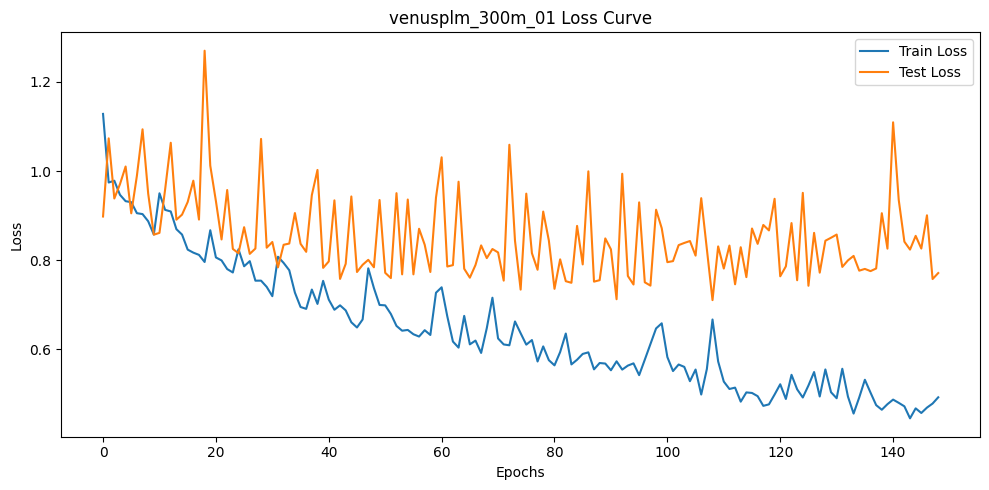

path_savemodel: /nas_data/mingxuan_model/protgpt2_01.pth


2025-07-14 16:01:21,724 - INFO - Epoch 1, train loss: 1.0568
2025-07-14 16:01:32,335 - INFO - valid loss: 0.9166


=> Saving checkpoint


2025-07-14 16:03:00,588 - INFO - Epoch 2, train loss: 0.9498
2025-07-14 16:03:11,193 - INFO - valid loss: 0.9335
2025-07-14 16:04:00,486 - INFO - Epoch 3, train loss: 0.9312
2025-07-14 16:04:11,174 - INFO - valid loss: 0.9739
2025-07-14 16:05:00,487 - INFO - Epoch 4, train loss: 0.9146
2025-07-14 16:05:11,070 - INFO - valid loss: 0.8635


=> Saving checkpoint


2025-07-14 16:06:31,371 - INFO - Epoch 5, train loss: 0.9030
2025-07-14 16:06:41,997 - INFO - valid loss: 0.9251
2025-07-14 16:07:31,289 - INFO - Epoch 6, train loss: 0.9053
2025-07-14 16:07:42,387 - INFO - valid loss: 0.8250


=> Saving checkpoint


2025-07-14 16:09:02,654 - INFO - Epoch 7, train loss: 0.8864
2025-07-14 16:09:13,187 - INFO - valid loss: 0.8508
2025-07-14 16:10:02,394 - INFO - Epoch 8, train loss: 0.8753
2025-07-14 16:10:13,021 - INFO - valid loss: 0.7942


=> Saving checkpoint


2025-07-14 16:11:33,262 - INFO - Epoch 9, train loss: 0.8601
2025-07-14 16:11:43,926 - INFO - valid loss: 0.8752
2025-07-14 16:12:33,188 - INFO - Epoch 10, train loss: 0.8247
2025-07-14 16:12:43,865 - INFO - valid loss: 0.8571
2025-07-14 16:13:33,201 - INFO - Epoch 11, train loss: 0.8178
2025-07-14 16:13:43,841 - INFO - valid loss: 0.7640


=> Saving checkpoint


2025-07-14 16:15:04,203 - INFO - Epoch 12, train loss: 0.8722
2025-07-14 16:15:14,814 - INFO - valid loss: 0.8283
2025-07-14 16:16:04,129 - INFO - Epoch 13, train loss: 0.8659
2025-07-14 16:16:14,770 - INFO - valid loss: 0.9133
2025-07-14 16:17:04,050 - INFO - Epoch 14, train loss: 0.8163
2025-07-14 16:17:14,710 - INFO - valid loss: 0.9850
2025-07-14 16:18:04,060 - INFO - Epoch 15, train loss: 0.8481
2025-07-14 16:18:14,691 - INFO - valid loss: 0.8900
2025-07-14 16:19:03,979 - INFO - Epoch 16, train loss: 0.7859
2025-07-14 16:19:14,575 - INFO - valid loss: 0.7716
2025-07-14 16:20:03,963 - INFO - Epoch 17, train loss: 0.7307
2025-07-14 16:20:14,600 - INFO - valid loss: 0.7335


=> Saving checkpoint


2025-07-14 16:21:35,067 - INFO - Epoch 18, train loss: 0.7220
2025-07-14 16:21:45,673 - INFO - valid loss: 0.8070
2025-07-14 16:22:34,859 - INFO - Epoch 19, train loss: 0.7294
2025-07-14 16:22:45,429 - INFO - valid loss: 0.7566
2025-07-14 16:23:34,732 - INFO - Epoch 20, train loss: 0.8272
2025-07-14 16:23:45,343 - INFO - valid loss: 0.7780
2025-07-14 16:24:34,672 - INFO - Epoch 21, train loss: 0.7795
2025-07-14 16:24:45,295 - INFO - valid loss: 0.7350
2025-07-14 16:25:34,616 - INFO - Epoch 22, train loss: 0.7264
2025-07-14 16:25:45,260 - INFO - valid loss: 0.8532
2025-07-14 16:26:34,553 - INFO - Epoch 23, train loss: 0.6475
2025-07-14 16:26:45,158 - INFO - valid loss: 0.9150
2025-07-14 16:27:34,417 - INFO - Epoch 24, train loss: 0.6345
2025-07-14 16:27:45,047 - INFO - valid loss: 0.9900
2025-07-14 16:28:34,332 - INFO - Epoch 25, train loss: 0.6099
2025-07-14 16:28:44,983 - INFO - valid loss: 0.9119
2025-07-14 16:29:34,379 - INFO - Epoch 26, train loss: 0.6611
2025-07-14 16:29:45,008 - 

=> Saving checkpoint


2025-07-14 16:48:11,707 - INFO - Epoch 44, train loss: 0.5767
2025-07-14 16:48:22,252 - INFO - valid loss: 0.7744
2025-07-14 16:49:11,432 - INFO - Epoch 45, train loss: 0.5365
2025-07-14 16:49:22,080 - INFO - valid loss: 0.7309
2025-07-14 16:50:11,348 - INFO - Epoch 46, train loss: 0.4593
2025-07-14 16:50:21,978 - INFO - valid loss: 0.8262
2025-07-14 16:51:11,380 - INFO - Epoch 47, train loss: 0.4554
2025-07-14 16:51:21,960 - INFO - valid loss: 0.8830
2025-07-14 16:52:11,266 - INFO - Epoch 48, train loss: 0.4558
2025-07-14 16:52:21,851 - INFO - valid loss: 0.8029
2025-07-14 16:53:11,144 - INFO - Epoch 49, train loss: 0.4139
2025-07-14 16:53:21,781 - INFO - valid loss: 0.9802
2025-07-14 16:54:11,081 - INFO - Epoch 50, train loss: 0.5007
2025-07-14 16:54:21,731 - INFO - valid loss: 1.2304
2025-07-14 16:55:11,083 - INFO - Epoch 51, train loss: 0.5276
2025-07-14 16:55:21,679 - INFO - valid loss: 0.7814
2025-07-14 16:56:10,972 - INFO - Epoch 52, train loss: 0.4322
2025-07-14 16:56:21,604 - 

=> Saving checkpoint


2025-07-14 17:02:41,885 - INFO - Epoch 58, train loss: 0.4312
2025-07-14 17:02:52,450 - INFO - valid loss: 0.7892
2025-07-14 17:03:41,655 - INFO - Epoch 59, train loss: 0.5223
2025-07-14 17:03:52,235 - INFO - valid loss: 0.8814
2025-07-14 17:04:41,487 - INFO - Epoch 60, train loss: 0.4304
2025-07-14 17:04:52,154 - INFO - valid loss: 0.8896
2025-07-14 17:05:41,412 - INFO - Epoch 61, train loss: 0.4178
2025-07-14 17:05:51,988 - INFO - valid loss: 0.8126
2025-07-14 17:06:41,255 - INFO - Epoch 62, train loss: 0.4451
2025-07-14 17:06:51,811 - INFO - valid loss: 0.7162
2025-07-14 17:07:41,168 - INFO - Epoch 63, train loss: 0.4477
2025-07-14 17:07:51,751 - INFO - valid loss: 1.1046
2025-07-14 17:08:41,031 - INFO - Epoch 64, train loss: 0.4132
2025-07-14 17:08:51,598 - INFO - valid loss: 0.7645
2025-07-14 17:09:40,984 - INFO - Epoch 65, train loss: 0.3662
2025-07-14 17:09:51,635 - INFO - valid loss: 0.7300
2025-07-14 17:10:40,883 - INFO - Epoch 66, train loss: 0.3750
2025-07-14 17:10:51,505 - 

early stop at epoch 97
=> Training completed! Best loss is 0.7052 at epoch 57


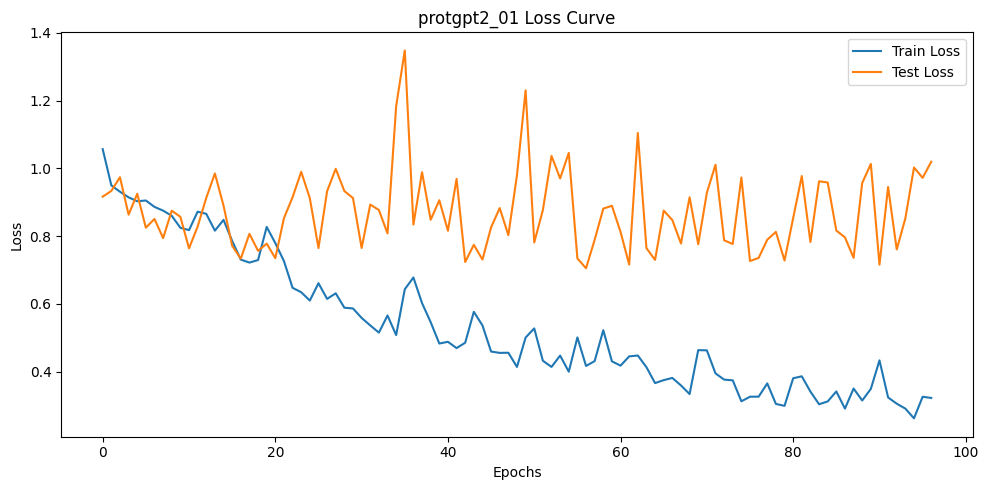

path_savemodel: /nas_data/mingxuan_model/protein_binding_site_predictor_01.pth


Some weights of RobertaModel were not initialized from the model checkpoint at jedwang/protein-binding-site-predictor and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 17:41:58,283 - INFO - Epoch 1, train loss: 1.0912
2025-07-14 17:42:03,339 - INFO - valid loss: 1.0258


=> Saving checkpoint


2025-07-14 17:42:14,393 - INFO - Epoch 2, train loss: 1.0138
2025-07-14 17:42:19,520 - INFO - valid loss: 1.0852
2025-07-14 17:42:27,081 - INFO - Epoch 3, train loss: 0.9920
2025-07-14 17:42:32,175 - INFO - valid loss: 0.9568


=> Saving checkpoint


2025-07-14 17:42:43,189 - INFO - Epoch 4, train loss: 0.9795
2025-07-14 17:42:48,273 - INFO - valid loss: 0.9646
2025-07-14 17:42:55,863 - INFO - Epoch 5, train loss: 0.9722
2025-07-14 17:43:00,895 - INFO - valid loss: 0.9795
2025-07-14 17:43:08,438 - INFO - Epoch 6, train loss: 0.9617
2025-07-14 17:43:13,470 - INFO - valid loss: 0.9848
2025-07-14 17:43:21,024 - INFO - Epoch 7, train loss: 0.9546
2025-07-14 17:43:26,106 - INFO - valid loss: 0.9870
2025-07-14 17:43:33,651 - INFO - Epoch 8, train loss: 0.9592
2025-07-14 17:43:38,733 - INFO - valid loss: 0.9531


=> Saving checkpoint


2025-07-14 17:43:49,676 - INFO - Epoch 9, train loss: 0.9473
2025-07-14 17:43:54,725 - INFO - valid loss: 0.8830


=> Saving checkpoint


2025-07-14 17:44:05,710 - INFO - Epoch 10, train loss: 0.9494
2025-07-14 17:44:10,817 - INFO - valid loss: 0.9218
2025-07-14 17:44:18,343 - INFO - Epoch 11, train loss: 0.9390
2025-07-14 17:44:23,436 - INFO - valid loss: 0.9232
2025-07-14 17:44:30,980 - INFO - Epoch 12, train loss: 0.9220
2025-07-14 17:44:35,969 - INFO - valid loss: 0.9554
2025-07-14 17:44:43,517 - INFO - Epoch 13, train loss: 0.9196
2025-07-14 17:44:48,518 - INFO - valid loss: 0.8597


=> Saving checkpoint


2025-07-14 17:44:59,481 - INFO - Epoch 14, train loss: 0.9054
2025-07-14 17:45:04,515 - INFO - valid loss: 0.8551


=> Saving checkpoint


2025-07-14 17:45:15,523 - INFO - Epoch 15, train loss: 0.9304
2025-07-14 17:45:20,598 - INFO - valid loss: 0.8706
2025-07-14 17:45:28,094 - INFO - Epoch 16, train loss: 0.8792
2025-07-14 17:45:33,185 - INFO - valid loss: 0.8794
2025-07-14 17:45:40,754 - INFO - Epoch 17, train loss: 0.8750
2025-07-14 17:45:45,806 - INFO - valid loss: 0.8994
2025-07-14 17:45:53,331 - INFO - Epoch 18, train loss: 0.8675
2025-07-14 17:45:58,381 - INFO - valid loss: 1.1177
2025-07-14 17:46:05,926 - INFO - Epoch 19, train loss: 0.8632
2025-07-14 17:46:11,013 - INFO - valid loss: 1.0459
2025-07-14 17:46:18,544 - INFO - Epoch 20, train loss: 0.8879
2025-07-14 17:46:23,525 - INFO - valid loss: 0.8235


=> Saving checkpoint


2025-07-14 17:46:34,498 - INFO - Epoch 21, train loss: 0.8757
2025-07-14 17:46:39,520 - INFO - valid loss: 0.8713
2025-07-14 17:46:47,097 - INFO - Epoch 22, train loss: 0.8413
2025-07-14 17:46:52,115 - INFO - valid loss: 1.0877
2025-07-14 17:46:59,691 - INFO - Epoch 23, train loss: 0.8777
2025-07-14 17:47:04,699 - INFO - valid loss: 0.9681
2025-07-14 17:47:12,188 - INFO - Epoch 24, train loss: 0.8811
2025-07-14 17:47:17,230 - INFO - valid loss: 0.8732
2025-07-14 17:47:24,764 - INFO - Epoch 25, train loss: 0.8361
2025-07-14 17:47:29,780 - INFO - valid loss: 1.0081
2025-07-14 17:47:37,329 - INFO - Epoch 26, train loss: 0.8241
2025-07-14 17:47:42,388 - INFO - valid loss: 0.8370
2025-07-14 17:47:49,936 - INFO - Epoch 27, train loss: 0.8210
2025-07-14 17:47:55,006 - INFO - valid loss: 0.9839
2025-07-14 17:48:02,584 - INFO - Epoch 28, train loss: 0.7979
2025-07-14 17:48:07,632 - INFO - valid loss: 0.9793
2025-07-14 17:48:15,242 - INFO - Epoch 29, train loss: 0.7943
2025-07-14 17:48:20,361 - 

=> Saving checkpoint


2025-07-14 17:48:44,006 - INFO - Epoch 31, train loss: 0.8059
2025-07-14 17:48:49,017 - INFO - valid loss: 0.8290
2025-07-14 17:48:56,479 - INFO - Epoch 32, train loss: 0.8499
2025-07-14 17:49:01,529 - INFO - valid loss: 0.8906
2025-07-14 17:49:09,022 - INFO - Epoch 33, train loss: 0.8369
2025-07-14 17:49:14,083 - INFO - valid loss: 0.8682
2025-07-14 17:49:21,588 - INFO - Epoch 34, train loss: 0.7885
2025-07-14 17:49:26,700 - INFO - valid loss: 0.8713
2025-07-14 17:49:34,284 - INFO - Epoch 35, train loss: 0.7904
2025-07-14 17:49:39,382 - INFO - valid loss: 1.2265
2025-07-14 17:49:46,895 - INFO - Epoch 36, train loss: 0.8326
2025-07-14 17:49:51,946 - INFO - valid loss: 1.0778
2025-07-14 17:49:59,452 - INFO - Epoch 37, train loss: 0.8075
2025-07-14 17:50:04,514 - INFO - valid loss: 1.0524
2025-07-14 17:50:12,050 - INFO - Epoch 38, train loss: 0.8191
2025-07-14 17:50:17,093 - INFO - valid loss: 0.9998
2025-07-14 17:50:24,642 - INFO - Epoch 39, train loss: 0.7794
2025-07-14 17:50:29,631 - 

=> Saving checkpoint


2025-07-14 17:50:40,593 - INFO - Epoch 40, train loss: 0.8172
2025-07-14 17:50:45,640 - INFO - valid loss: 1.0498
2025-07-14 17:50:53,221 - INFO - Epoch 41, train loss: 0.7668
2025-07-14 17:50:58,305 - INFO - valid loss: 0.9779
2025-07-14 17:51:05,879 - INFO - Epoch 42, train loss: 0.7978
2025-07-14 17:51:10,956 - INFO - valid loss: 0.8448
2025-07-14 17:51:18,464 - INFO - Epoch 43, train loss: 0.7931
2025-07-14 17:51:23,512 - INFO - valid loss: 0.8657
2025-07-14 17:51:31,061 - INFO - Epoch 44, train loss: 0.9071
2025-07-14 17:51:36,064 - INFO - valid loss: 0.8296
2025-07-14 17:51:43,631 - INFO - Epoch 45, train loss: 0.8909
2025-07-14 17:51:48,728 - INFO - valid loss: 0.8873
2025-07-14 17:51:56,355 - INFO - Epoch 46, train loss: 0.8186
2025-07-14 17:52:01,470 - INFO - valid loss: 0.9045
2025-07-14 17:52:09,020 - INFO - Epoch 47, train loss: 0.7946
2025-07-14 17:52:14,069 - INFO - valid loss: 0.8536
2025-07-14 17:52:21,640 - INFO - Epoch 48, train loss: 0.7631
2025-07-14 17:52:26,683 - 

=> Saving checkpoint


2025-07-14 17:52:50,320 - INFO - Epoch 50, train loss: 0.8718
2025-07-14 17:52:55,417 - INFO - valid loss: 0.8655
2025-07-14 17:53:02,947 - INFO - Epoch 51, train loss: 0.7857
2025-07-14 17:53:08,049 - INFO - valid loss: 0.8149
2025-07-14 17:53:15,657 - INFO - Epoch 52, train loss: 0.7939
2025-07-14 17:53:20,756 - INFO - valid loss: 0.8042
2025-07-14 17:53:28,258 - INFO - Epoch 53, train loss: 0.8046
2025-07-14 17:53:33,359 - INFO - valid loss: 0.8558
2025-07-14 17:53:40,855 - INFO - Epoch 54, train loss: 0.7586
2025-07-14 17:53:45,949 - INFO - valid loss: 1.0444
2025-07-14 17:53:53,424 - INFO - Epoch 55, train loss: 0.7473
2025-07-14 17:53:58,518 - INFO - valid loss: 0.8316
2025-07-14 17:54:06,193 - INFO - Epoch 56, train loss: 0.7555
2025-07-14 17:54:11,396 - INFO - valid loss: 1.0525
2025-07-14 17:54:19,028 - INFO - Epoch 57, train loss: 0.7319
2025-07-14 17:54:24,112 - INFO - valid loss: 0.9330
2025-07-14 17:54:31,697 - INFO - Epoch 58, train loss: 0.7798
2025-07-14 17:54:36,827 - 

=> Saving checkpoint


2025-07-14 17:56:28,945 - INFO - Epoch 67, train loss: 0.8010
2025-07-14 17:56:33,952 - INFO - valid loss: 0.8183
2025-07-14 17:56:41,468 - INFO - Epoch 68, train loss: 0.7880
2025-07-14 17:56:46,554 - INFO - valid loss: 0.8797
2025-07-14 17:56:54,183 - INFO - Epoch 69, train loss: 0.7312
2025-07-14 17:56:59,189 - INFO - valid loss: 1.0186
2025-07-14 17:57:06,741 - INFO - Epoch 70, train loss: 0.7291
2025-07-14 17:57:11,849 - INFO - valid loss: 0.8575
2025-07-14 17:57:19,459 - INFO - Epoch 71, train loss: 0.7066
2025-07-14 17:57:24,565 - INFO - valid loss: 1.0335
2025-07-14 17:57:32,127 - INFO - Epoch 72, train loss: 0.6811
2025-07-14 17:57:37,237 - INFO - valid loss: 1.0665
2025-07-14 17:57:44,735 - INFO - Epoch 73, train loss: 0.6934
2025-07-14 17:57:49,747 - INFO - valid loss: 0.9545
2025-07-14 17:57:57,277 - INFO - Epoch 74, train loss: 0.7229
2025-07-14 17:58:02,362 - INFO - valid loss: 0.8525
2025-07-14 17:58:09,952 - INFO - Epoch 75, train loss: 0.7577
2025-07-14 17:58:15,123 - 

=> Saving checkpoint


2025-07-14 17:58:26,165 - INFO - Epoch 76, train loss: 0.7057
2025-07-14 17:58:31,259 - INFO - valid loss: 0.8810
2025-07-14 17:58:38,756 - INFO - Epoch 77, train loss: 0.7463
2025-07-14 17:58:43,811 - INFO - valid loss: 1.1409
2025-07-14 17:58:51,411 - INFO - Epoch 78, train loss: 0.8602
2025-07-14 17:58:56,471 - INFO - valid loss: 1.3292
2025-07-14 17:59:03,993 - INFO - Epoch 79, train loss: 0.8534
2025-07-14 17:59:09,056 - INFO - valid loss: 0.9221
2025-07-14 17:59:16,651 - INFO - Epoch 80, train loss: 0.7918
2025-07-14 17:59:21,727 - INFO - valid loss: 0.8477
2025-07-14 17:59:29,302 - INFO - Epoch 81, train loss: 0.7251
2025-07-14 17:59:34,383 - INFO - valid loss: 0.8354
2025-07-14 17:59:41,920 - INFO - Epoch 82, train loss: 0.7745
2025-07-14 17:59:46,930 - INFO - valid loss: 0.8706
2025-07-14 17:59:54,468 - INFO - Epoch 83, train loss: 0.7114
2025-07-14 17:59:59,553 - INFO - valid loss: 0.8463
2025-07-14 18:00:07,093 - INFO - Epoch 84, train loss: 0.6731
2025-07-14 18:00:12,131 - 

early stop at epoch 115
=> Training completed! Best loss is 0.7902 at epoch 75


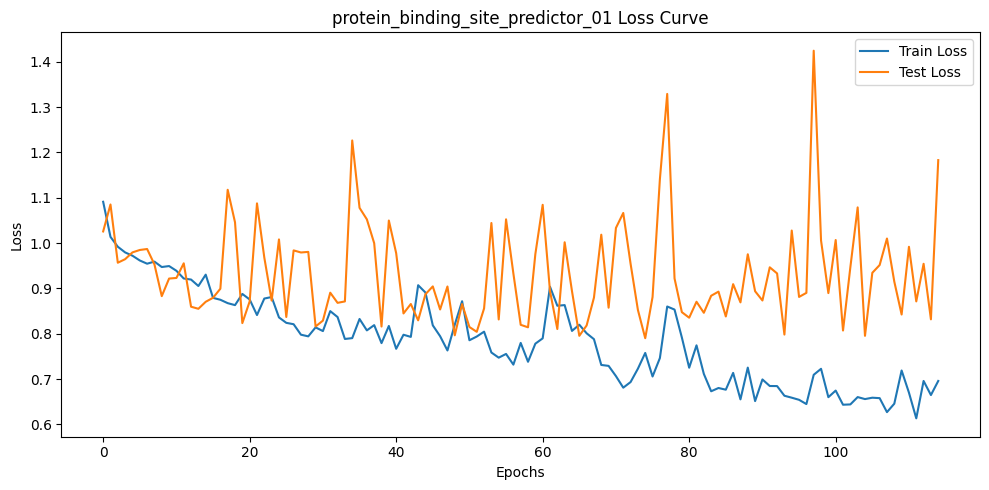

path_savemodel: /nas_data/mingxuan_model/roberta_mlm_for_protein_clustering_01.pth


Some weights of RobertaModel were not initialized from the model checkpoint at shashwatsaini/RoBERTa-MLM-For-Protein-Clustering and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 18:06:53,022 - INFO - Epoch 1, train loss: 1.1241
2025-07-14 18:06:58,068 - INFO - valid loss: 0.9326


=> Saving checkpoint


2025-07-14 18:07:09,001 - INFO - Epoch 2, train loss: 0.9970
2025-07-14 18:07:14,103 - INFO - valid loss: 0.9863
2025-07-14 18:07:21,721 - INFO - Epoch 3, train loss: 0.9948
2025-07-14 18:07:26,793 - INFO - valid loss: 1.0328
2025-07-14 18:07:34,356 - INFO - Epoch 4, train loss: 0.9930
2025-07-14 18:07:39,443 - INFO - valid loss: 0.9246


=> Saving checkpoint


2025-07-14 18:07:50,461 - INFO - Epoch 5, train loss: 0.9809
2025-07-14 18:07:55,546 - INFO - valid loss: 0.9814
2025-07-14 18:08:03,092 - INFO - Epoch 6, train loss: 0.9718
2025-07-14 18:08:08,143 - INFO - valid loss: 0.9377
2025-07-14 18:08:15,674 - INFO - Epoch 7, train loss: 0.9839
2025-07-14 18:08:20,751 - INFO - valid loss: 0.9885
2025-07-14 18:08:28,273 - INFO - Epoch 8, train loss: 0.9776
2025-07-14 18:08:33,470 - INFO - valid loss: 0.9177


=> Saving checkpoint


2025-07-14 18:08:44,921 - INFO - Epoch 9, train loss: 0.9758
2025-07-14 18:08:50,034 - INFO - valid loss: 0.9892
2025-07-14 18:08:57,636 - INFO - Epoch 10, train loss: 0.9701
2025-07-14 18:09:02,697 - INFO - valid loss: 0.9843
2025-07-14 18:09:10,296 - INFO - Epoch 11, train loss: 0.9613
2025-07-14 18:09:15,357 - INFO - valid loss: 0.8970


=> Saving checkpoint


2025-07-14 18:09:26,455 - INFO - Epoch 12, train loss: 0.9598
2025-07-14 18:09:31,518 - INFO - valid loss: 1.0603
2025-07-14 18:09:39,136 - INFO - Epoch 13, train loss: 1.0085
2025-07-14 18:09:44,300 - INFO - valid loss: 0.9554
2025-07-14 18:09:51,867 - INFO - Epoch 14, train loss: 0.9822
2025-07-14 18:09:56,930 - INFO - valid loss: 0.9177
2025-07-14 18:10:04,473 - INFO - Epoch 15, train loss: 0.9637
2025-07-14 18:10:09,567 - INFO - valid loss: 0.9516
2025-07-14 18:10:17,138 - INFO - Epoch 16, train loss: 0.9621
2025-07-14 18:10:22,192 - INFO - valid loss: 0.9322
2025-07-14 18:10:29,761 - INFO - Epoch 17, train loss: 0.9621
2025-07-14 18:10:34,741 - INFO - valid loss: 0.9305
2025-07-14 18:10:42,233 - INFO - Epoch 18, train loss: 0.9624
2025-07-14 18:10:47,351 - INFO - valid loss: 0.9526
2025-07-14 18:10:54,981 - INFO - Epoch 19, train loss: 0.9667
2025-07-14 18:11:00,054 - INFO - valid loss: 0.9540
2025-07-14 18:11:07,586 - INFO - Epoch 20, train loss: 0.9655
2025-07-14 18:11:12,708 - 

=> Saving checkpoint


2025-07-14 18:15:11,607 - INFO - Epoch 39, train loss: 0.9438
2025-07-14 18:15:16,721 - INFO - valid loss: 0.9944
2025-07-14 18:15:24,354 - INFO - Epoch 40, train loss: 0.9415
2025-07-14 18:15:29,399 - INFO - valid loss: 0.9018
2025-07-14 18:15:37,000 - INFO - Epoch 41, train loss: 0.9598
2025-07-14 18:15:42,020 - INFO - valid loss: 0.9161
2025-07-14 18:15:49,629 - INFO - Epoch 42, train loss: 0.9452
2025-07-14 18:15:54,634 - INFO - valid loss: 0.9348
2025-07-14 18:16:02,291 - INFO - Epoch 43, train loss: 0.9499
2025-07-14 18:16:07,362 - INFO - valid loss: 0.8924
2025-07-14 18:16:14,909 - INFO - Epoch 44, train loss: 0.9547
2025-07-14 18:16:20,006 - INFO - valid loss: 1.0081
2025-07-14 18:16:27,608 - INFO - Epoch 45, train loss: 0.9533
2025-07-14 18:16:32,657 - INFO - valid loss: 0.9192
2025-07-14 18:16:40,311 - INFO - Epoch 46, train loss: 0.9515
2025-07-14 18:16:45,405 - INFO - valid loss: 0.9126
2025-07-14 18:16:53,029 - INFO - Epoch 47, train loss: 0.9466
2025-07-14 18:16:58,135 - 

=> Saving checkpoint


2025-07-14 18:18:38,163 - INFO - Epoch 55, train loss: 0.9460
2025-07-14 18:18:43,177 - INFO - valid loss: 0.9401
2025-07-14 18:18:50,702 - INFO - Epoch 56, train loss: 0.9496
2025-07-14 18:18:55,814 - INFO - valid loss: 0.9391
2025-07-14 18:19:03,381 - INFO - Epoch 57, train loss: 0.9382
2025-07-14 18:19:08,406 - INFO - valid loss: 0.9339
2025-07-14 18:19:16,006 - INFO - Epoch 58, train loss: 0.9374
2025-07-14 18:19:21,007 - INFO - valid loss: 0.9402
2025-07-14 18:19:28,617 - INFO - Epoch 59, train loss: 0.9519
2025-07-14 18:19:33,606 - INFO - valid loss: 0.9517
2025-07-14 18:19:41,226 - INFO - Epoch 60, train loss: 0.9408
2025-07-14 18:19:46,387 - INFO - valid loss: 0.9478
2025-07-14 18:19:54,016 - INFO - Epoch 61, train loss: 0.9426
2025-07-14 18:19:59,077 - INFO - valid loss: 0.9512
2025-07-14 18:20:06,656 - INFO - Epoch 62, train loss: 0.9389
2025-07-14 18:20:11,765 - INFO - valid loss: 0.9246
2025-07-14 18:20:19,336 - INFO - Epoch 63, train loss: 0.9484
2025-07-14 18:20:24,366 - 

early stop at epoch 94
=> Training completed! Best loss is 0.8883 at epoch 54


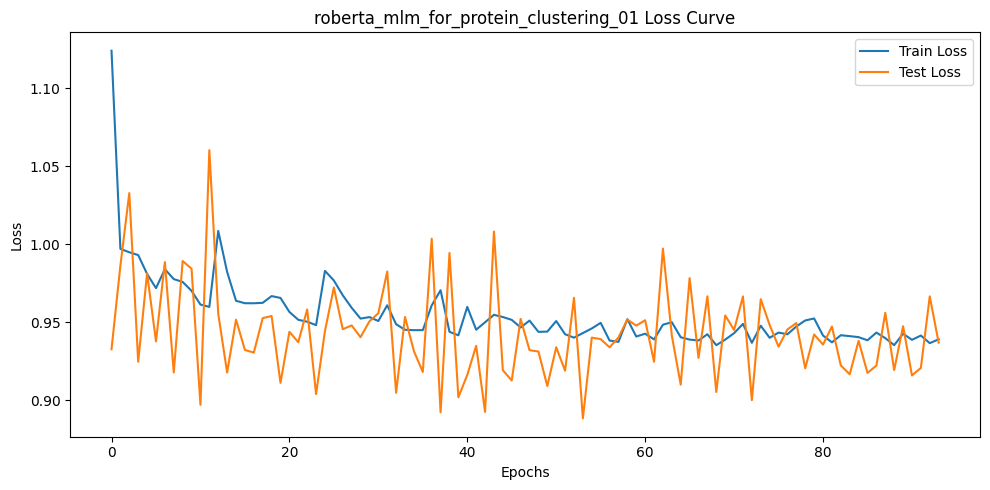

path_savemodel: /nas_data/mingxuan_model/saprot_1_3b_af2_01.pth


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_1.3B_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 18:28:37,568 - INFO - Epoch 1, train loss: 1.1403
2025-07-14 18:28:53,520 - INFO - valid loss: 1.0132


=> Saving checkpoint


2025-07-14 18:31:08,564 - INFO - Epoch 2, train loss: 0.9998
2025-07-14 18:31:24,537 - INFO - valid loss: 0.8976


=> Saving checkpoint


2025-07-14 18:33:41,203 - INFO - Epoch 3, train loss: 0.9753
2025-07-14 18:33:57,212 - INFO - valid loss: 1.0440
2025-07-14 18:35:22,693 - INFO - Epoch 4, train loss: 0.9848
2025-07-14 18:35:38,768 - INFO - valid loss: 0.8780


=> Saving checkpoint


2025-07-14 18:37:54,868 - INFO - Epoch 5, train loss: 0.9456
2025-07-14 18:38:10,798 - INFO - valid loss: 0.9236
2025-07-14 18:39:36,256 - INFO - Epoch 6, train loss: 0.9346
2025-07-14 18:39:52,195 - INFO - valid loss: 0.8927
2025-07-14 18:41:17,678 - INFO - Epoch 7, train loss: 0.9393
2025-07-14 18:41:33,652 - INFO - valid loss: 0.9340
2025-07-14 18:42:59,080 - INFO - Epoch 8, train loss: 0.9410
2025-07-14 18:43:15,063 - INFO - valid loss: 0.8404


=> Saving checkpoint


2025-07-14 18:45:31,110 - INFO - Epoch 9, train loss: 0.9264
2025-07-14 18:45:47,043 - INFO - valid loss: 1.0845
2025-07-14 18:47:12,431 - INFO - Epoch 10, train loss: 0.9325
2025-07-14 18:47:28,429 - INFO - valid loss: 0.8980
2025-07-14 18:48:53,915 - INFO - Epoch 11, train loss: 0.9172
2025-07-14 18:49:09,849 - INFO - valid loss: 0.8382


=> Saving checkpoint


2025-07-14 18:51:25,340 - INFO - Epoch 12, train loss: 0.8952
2025-07-14 18:51:41,277 - INFO - valid loss: 1.0028
2025-07-14 18:53:06,735 - INFO - Epoch 13, train loss: 0.9159
2025-07-14 18:53:22,712 - INFO - valid loss: 0.8664
2025-07-14 18:54:48,216 - INFO - Epoch 14, train loss: 0.9027
2025-07-14 18:55:04,240 - INFO - valid loss: 0.8898
2025-07-14 18:56:29,700 - INFO - Epoch 15, train loss: 0.9146
2025-07-14 18:56:46,205 - INFO - valid loss: 0.8508
2025-07-14 18:58:11,716 - INFO - Epoch 16, train loss: 0.9015
2025-07-14 18:58:27,761 - INFO - valid loss: 0.9663
2025-07-14 18:59:53,198 - INFO - Epoch 17, train loss: 0.9224
2025-07-14 19:00:09,211 - INFO - valid loss: 0.9476
2025-07-14 19:01:34,598 - INFO - Epoch 18, train loss: 0.8962
2025-07-14 19:01:50,564 - INFO - valid loss: 0.8714
2025-07-14 19:03:16,032 - INFO - Epoch 19, train loss: 0.9009
2025-07-14 19:03:31,967 - INFO - valid loss: 0.9218
2025-07-14 19:04:57,554 - INFO - Epoch 20, train loss: 0.9051
2025-07-14 19:05:13,533 - 

=> Saving checkpoint


2025-07-14 19:09:10,906 - INFO - Epoch 22, train loss: 0.9136
2025-07-14 19:09:26,838 - INFO - valid loss: 0.8735
2025-07-14 19:10:52,306 - INFO - Epoch 23, train loss: 0.8965
2025-07-14 19:11:08,238 - INFO - valid loss: 0.8594
2025-07-14 19:12:33,714 - INFO - Epoch 24, train loss: 0.9082
2025-07-14 19:12:49,701 - INFO - valid loss: 0.7966


=> Saving checkpoint


2025-07-14 19:15:05,666 - INFO - Epoch 25, train loss: 0.8910
2025-07-14 19:15:21,543 - INFO - valid loss: 0.9350
2025-07-14 19:16:46,879 - INFO - Epoch 26, train loss: 0.8857
2025-07-14 19:17:02,821 - INFO - valid loss: 0.8912
2025-07-14 19:18:28,340 - INFO - Epoch 27, train loss: 0.8864
2025-07-14 19:18:44,378 - INFO - valid loss: 1.0119
2025-07-14 19:20:10,250 - INFO - Epoch 28, train loss: 0.9034
2025-07-14 19:20:26,153 - INFO - valid loss: 0.8421
2025-07-14 19:21:51,658 - INFO - Epoch 29, train loss: 0.8879
2025-07-14 19:22:07,631 - INFO - valid loss: 0.8070
2025-07-14 19:23:33,227 - INFO - Epoch 30, train loss: 0.8780
2025-07-14 19:23:49,252 - INFO - valid loss: 1.0942
2025-07-14 19:25:14,717 - INFO - Epoch 31, train loss: 0.9183
2025-07-14 19:25:30,781 - INFO - valid loss: 0.8520
2025-07-14 19:26:56,269 - INFO - Epoch 32, train loss: 0.8788
2025-07-14 19:27:12,271 - INFO - valid loss: 0.9023
2025-07-14 19:28:37,807 - INFO - Epoch 33, train loss: 0.8802
2025-07-14 19:28:53,673 - 

early stop at epoch 64
=> Training completed! Best loss is 0.7966 at epoch 24


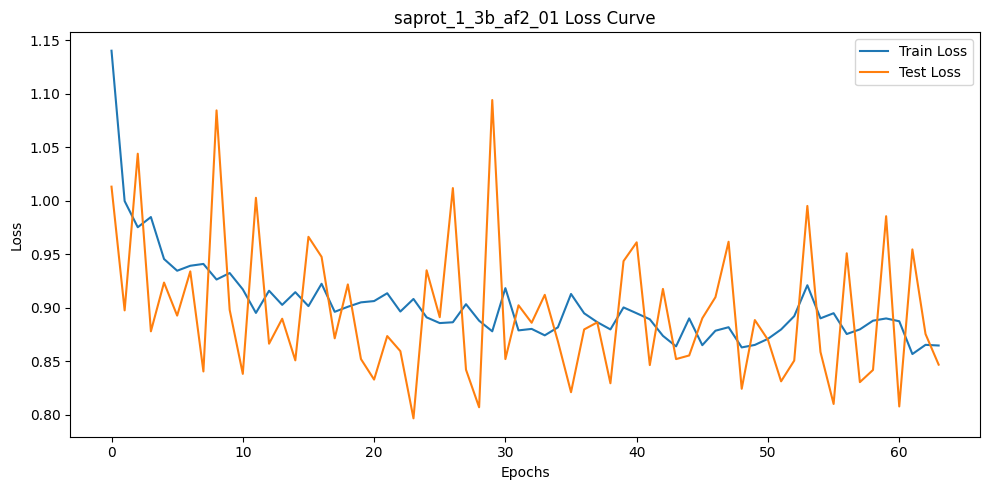

path_savemodel: /nas_data/mingxuan_model/saprot_650m_pdb_01.pth


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_PDB and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 20:22:16,207 - INFO - Epoch 1, train loss: 1.1354
2025-07-14 20:22:27,254 - INFO - valid loss: 0.9267


=> Saving checkpoint


2025-07-14 20:23:48,367 - INFO - Epoch 2, train loss: 0.9722
2025-07-14 20:23:59,378 - INFO - valid loss: 1.0497
2025-07-14 20:24:45,365 - INFO - Epoch 3, train loss: 0.9641
2025-07-14 20:24:56,433 - INFO - valid loss: 0.9752
2025-07-14 20:25:42,448 - INFO - Epoch 4, train loss: 0.9618
2025-07-14 20:25:53,620 - INFO - valid loss: 0.8798


=> Saving checkpoint


2025-07-14 20:27:05,858 - INFO - Epoch 5, train loss: 0.9567
2025-07-14 20:27:16,878 - INFO - valid loss: 0.9385
2025-07-14 20:28:02,924 - INFO - Epoch 6, train loss: 0.9731
2025-07-14 20:28:13,973 - INFO - valid loss: 1.0165
2025-07-14 20:29:00,021 - INFO - Epoch 7, train loss: 0.9585
2025-07-14 20:29:11,008 - INFO - valid loss: 0.9049
2025-07-14 20:29:57,108 - INFO - Epoch 8, train loss: 0.9450
2025-07-14 20:30:08,275 - INFO - valid loss: 0.9183
2025-07-14 20:30:54,280 - INFO - Epoch 9, train loss: 0.9376
2025-07-14 20:31:05,319 - INFO - valid loss: 0.9270
2025-07-14 20:31:51,345 - INFO - Epoch 10, train loss: 0.9369
2025-07-14 20:32:02,418 - INFO - valid loss: 0.8975
2025-07-14 20:32:48,497 - INFO - Epoch 11, train loss: 0.9331
2025-07-14 20:32:59,530 - INFO - valid loss: 0.9117
2025-07-14 20:33:45,681 - INFO - Epoch 12, train loss: 0.9325
2025-07-14 20:33:56,719 - INFO - valid loss: 0.8961
2025-07-14 20:34:42,801 - INFO - Epoch 13, train loss: 0.9421
2025-07-14 20:34:53,825 - INFO 

=> Saving checkpoint


2025-07-14 20:42:47,063 - INFO - Epoch 21, train loss: 0.9273
2025-07-14 20:42:58,159 - INFO - valid loss: 0.9025
2025-07-14 20:43:44,111 - INFO - Epoch 22, train loss: 0.9343
2025-07-14 20:43:55,125 - INFO - valid loss: 0.8663


=> Saving checkpoint


2025-07-14 20:45:07,271 - INFO - Epoch 23, train loss: 0.9360
2025-07-14 20:45:18,261 - INFO - valid loss: 0.8614


=> Saving checkpoint


2025-07-14 20:46:30,309 - INFO - Epoch 24, train loss: 0.9359
2025-07-14 20:46:41,272 - INFO - valid loss: 0.9185
2025-07-14 20:47:27,402 - INFO - Epoch 25, train loss: 0.9604
2025-07-14 20:47:38,556 - INFO - valid loss: 0.8385


=> Saving checkpoint


2025-07-14 20:48:50,725 - INFO - Epoch 26, train loss: 0.9453
2025-07-14 20:49:01,743 - INFO - valid loss: 0.9219
2025-07-14 20:49:47,843 - INFO - Epoch 27, train loss: 0.9293
2025-07-14 20:49:58,887 - INFO - valid loss: 0.8805
2025-07-14 20:50:44,968 - INFO - Epoch 28, train loss: 0.9269
2025-07-14 20:50:56,062 - INFO - valid loss: 0.8980
2025-07-14 20:51:42,124 - INFO - Epoch 29, train loss: 0.9312
2025-07-14 20:51:53,175 - INFO - valid loss: 0.9303
2025-07-14 20:52:39,244 - INFO - Epoch 30, train loss: 0.9353
2025-07-14 20:52:50,221 - INFO - valid loss: 0.9184
2025-07-14 20:53:36,362 - INFO - Epoch 31, train loss: 0.9398
2025-07-14 20:53:47,453 - INFO - valid loss: 0.8464
2025-07-14 20:54:33,566 - INFO - Epoch 32, train loss: 0.9526
2025-07-14 20:54:44,562 - INFO - valid loss: 0.9365
2025-07-14 20:55:30,629 - INFO - Epoch 33, train loss: 0.9289
2025-07-14 20:55:41,778 - INFO - valid loss: 0.9102
2025-07-14 20:56:27,864 - INFO - Epoch 34, train loss: 0.9311
2025-07-14 20:56:38,939 - 

=> Saving checkpoint


2025-07-14 21:06:25,098 - INFO - Epoch 44, train loss: 0.9368
2025-07-14 21:06:36,019 - INFO - valid loss: 0.9114
2025-07-14 21:07:21,963 - INFO - Epoch 45, train loss: 0.9197
2025-07-14 21:07:32,973 - INFO - valid loss: 0.8636
2025-07-14 21:08:19,086 - INFO - Epoch 46, train loss: 0.9246
2025-07-14 21:08:30,112 - INFO - valid loss: 0.8894
2025-07-14 21:09:16,139 - INFO - Epoch 47, train loss: 0.9312
2025-07-14 21:09:27,204 - INFO - valid loss: 0.9206
2025-07-14 21:10:13,345 - INFO - Epoch 48, train loss: 0.9303
2025-07-14 21:10:24,484 - INFO - valid loss: 0.8772
2025-07-14 21:11:10,619 - INFO - Epoch 49, train loss: 0.9256
2025-07-14 21:11:21,705 - INFO - valid loss: 0.8673
2025-07-14 21:12:07,713 - INFO - Epoch 50, train loss: 0.9243
2025-07-14 21:12:18,821 - INFO - valid loss: 0.8981
2025-07-14 21:13:04,867 - INFO - Epoch 51, train loss: 0.9223
2025-07-14 21:13:16,037 - INFO - valid loss: 0.8979
2025-07-14 21:14:02,161 - INFO - Epoch 52, train loss: 0.9165
2025-07-14 21:14:13,165 - 

=> Saving checkpoint


2025-07-14 21:21:08,784 - INFO - Epoch 59, train loss: 0.9213
2025-07-14 21:21:19,876 - INFO - valid loss: 0.9072
2025-07-14 21:22:05,826 - INFO - Epoch 60, train loss: 0.9132
2025-07-14 21:22:16,880 - INFO - valid loss: 0.8342
2025-07-14 21:23:02,961 - INFO - Epoch 61, train loss: 0.9204
2025-07-14 21:23:13,956 - INFO - valid loss: 0.8865
2025-07-14 21:24:00,065 - INFO - Epoch 62, train loss: 0.9123
2025-07-14 21:24:11,089 - INFO - valid loss: 0.8641
2025-07-14 21:24:57,223 - INFO - Epoch 63, train loss: 0.9214
2025-07-14 21:25:08,313 - INFO - valid loss: 0.8425
2025-07-14 21:25:54,388 - INFO - Epoch 64, train loss: 0.9347
2025-07-14 21:26:05,443 - INFO - valid loss: 0.7935


=> Saving checkpoint


2025-07-14 21:27:17,652 - INFO - Epoch 65, train loss: 0.9504
2025-07-14 21:27:28,662 - INFO - valid loss: 0.9397
2025-07-14 21:28:14,713 - INFO - Epoch 66, train loss: 0.9178
2025-07-14 21:28:25,717 - INFO - valid loss: 0.8654
2025-07-14 21:29:11,759 - INFO - Epoch 67, train loss: 0.9353
2025-07-14 21:29:22,791 - INFO - valid loss: 0.8443
2025-07-14 21:30:08,978 - INFO - Epoch 68, train loss: 0.9220
2025-07-14 21:30:20,046 - INFO - valid loss: 0.9347
2025-07-14 21:31:06,137 - INFO - Epoch 69, train loss: 0.9232
2025-07-14 21:31:17,138 - INFO - valid loss: 0.8848
2025-07-14 21:32:03,261 - INFO - Epoch 70, train loss: 0.9143
2025-07-14 21:32:14,223 - INFO - valid loss: 0.8569
2025-07-14 21:33:00,238 - INFO - Epoch 71, train loss: 0.9226
2025-07-14 21:33:11,293 - INFO - valid loss: 0.9400
2025-07-14 21:33:57,434 - INFO - Epoch 72, train loss: 0.9132
2025-07-14 21:34:08,501 - INFO - valid loss: 0.8428
2025-07-14 21:34:54,573 - INFO - Epoch 73, train loss: 0.9065
2025-07-14 21:35:05,564 - 

early stop at epoch 104
=> Training completed! Best loss is 0.7935 at epoch 64


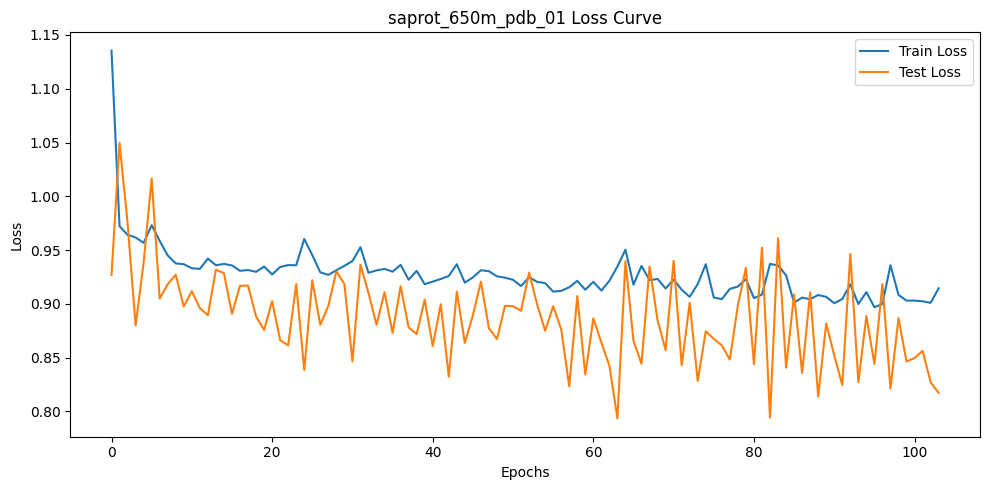

path_savemodel: /nas_data/mingxuan_model/saprot_650m_af2_01.pth


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-07-14 22:05:30,389 - INFO - Epoch 1, train loss: 1.0842
2025-07-14 22:05:41,978 - INFO - valid loss: 0.9413


=> Saving checkpoint


2025-07-14 22:07:02,513 - INFO - Epoch 2, train loss: 0.9563
2025-07-14 22:07:13,515 - INFO - valid loss: 1.1197
2025-07-14 22:07:59,505 - INFO - Epoch 3, train loss: 0.9735
2025-07-14 22:08:10,623 - INFO - valid loss: 0.9235


=> Saving checkpoint


2025-07-14 22:09:22,721 - INFO - Epoch 4, train loss: 0.9373
2025-07-14 22:09:33,725 - INFO - valid loss: 0.9183


=> Saving checkpoint


2025-07-14 22:10:45,888 - INFO - Epoch 5, train loss: 0.9302
2025-07-14 22:10:56,923 - INFO - valid loss: 0.9168


=> Saving checkpoint


2025-07-14 22:12:08,964 - INFO - Epoch 6, train loss: 0.9318
2025-07-14 22:12:20,023 - INFO - valid loss: 1.0044
2025-07-14 22:13:06,016 - INFO - Epoch 7, train loss: 0.9478
2025-07-14 22:13:16,994 - INFO - valid loss: 0.8699


=> Saving checkpoint


2025-07-14 22:14:29,035 - INFO - Epoch 8, train loss: 0.9389
2025-07-14 22:14:40,089 - INFO - valid loss: 0.9764
2025-07-14 22:15:26,104 - INFO - Epoch 9, train loss: 0.9305
2025-07-14 22:15:37,112 - INFO - valid loss: 0.8984
2025-07-14 22:16:23,179 - INFO - Epoch 10, train loss: 0.9283
2025-07-14 22:16:34,235 - INFO - valid loss: 0.8847
2025-07-14 22:17:20,367 - INFO - Epoch 11, train loss: 0.9249
2025-07-14 22:17:31,400 - INFO - valid loss: 0.8699
2025-07-14 22:18:17,492 - INFO - Epoch 12, train loss: 0.9302
2025-07-14 22:18:28,560 - INFO - valid loss: 0.8734
2025-07-14 22:19:14,741 - INFO - Epoch 13, train loss: 0.9408
2025-07-14 22:19:25,811 - INFO - valid loss: 1.0133
2025-07-14 22:20:11,989 - INFO - Epoch 14, train loss: 0.9444
2025-07-14 22:20:23,010 - INFO - valid loss: 0.8369


=> Saving checkpoint


2025-07-14 22:21:35,197 - INFO - Epoch 15, train loss: 0.9222
2025-07-14 22:21:46,217 - INFO - valid loss: 0.9246
2025-07-14 22:22:32,271 - INFO - Epoch 16, train loss: 0.9153
2025-07-14 22:22:43,322 - INFO - valid loss: 0.8750
2025-07-14 22:23:29,465 - INFO - Epoch 17, train loss: 0.9239
2025-07-14 22:23:40,461 - INFO - valid loss: 0.9676
2025-07-14 22:24:26,649 - INFO - Epoch 18, train loss: 0.9282
2025-07-14 22:24:37,733 - INFO - valid loss: 0.9114
2025-07-14 22:25:23,781 - INFO - Epoch 19, train loss: 0.9126
2025-07-14 22:25:34,795 - INFO - valid loss: 0.8326


=> Saving checkpoint


2025-07-14 22:26:46,969 - INFO - Epoch 20, train loss: 0.9162
2025-07-14 22:26:58,023 - INFO - valid loss: 0.8822
2025-07-14 22:27:44,091 - INFO - Epoch 21, train loss: 0.9147
2025-07-14 22:27:55,129 - INFO - valid loss: 0.8401
2025-07-14 22:28:41,238 - INFO - Epoch 22, train loss: 0.9196
2025-07-14 22:28:52,264 - INFO - valid loss: 0.9072
2025-07-14 22:29:38,418 - INFO - Epoch 23, train loss: 0.9203
2025-07-14 22:29:49,535 - INFO - valid loss: 0.9423
2025-07-14 22:30:35,685 - INFO - Epoch 24, train loss: 0.9121
2025-07-14 22:30:46,762 - INFO - valid loss: 0.8442
2025-07-14 22:31:32,971 - INFO - Epoch 25, train loss: 0.9133
2025-07-14 22:31:44,039 - INFO - valid loss: 0.9253
2025-07-14 22:32:30,095 - INFO - Epoch 26, train loss: 0.9103
2025-07-14 22:32:41,142 - INFO - valid loss: 0.8417
2025-07-14 22:33:27,196 - INFO - Epoch 27, train loss: 0.9102
2025-07-14 22:33:38,213 - INFO - valid loss: 0.8488
2025-07-14 22:34:24,416 - INFO - Epoch 28, train loss: 0.9147
2025-07-14 22:34:35,393 - 

=> Saving checkpoint


2025-07-14 22:35:47,499 - INFO - Epoch 29, train loss: 0.9178
2025-07-14 22:35:58,506 - INFO - valid loss: 0.8285
2025-07-14 22:36:44,508 - INFO - Epoch 30, train loss: 0.9289
2025-07-14 22:36:55,502 - INFO - valid loss: 0.8705
2025-07-14 22:37:41,620 - INFO - Epoch 31, train loss: 0.9080
2025-07-14 22:37:52,729 - INFO - valid loss: 0.8820
2025-07-14 22:38:38,838 - INFO - Epoch 32, train loss: 0.9115
2025-07-14 22:38:49,888 - INFO - valid loss: 0.8877
2025-07-14 22:39:36,083 - INFO - Epoch 33, train loss: 0.9070
2025-07-14 22:39:47,141 - INFO - valid loss: 0.9046
2025-07-14 22:40:33,288 - INFO - Epoch 34, train loss: 0.9142
2025-07-14 22:40:44,384 - INFO - valid loss: 0.8879
2025-07-14 22:41:30,508 - INFO - Epoch 35, train loss: 0.9186
2025-07-14 22:41:41,566 - INFO - valid loss: 0.8108


=> Saving checkpoint


2025-07-14 22:42:53,672 - INFO - Epoch 36, train loss: 0.9288
2025-07-14 22:43:04,648 - INFO - valid loss: 0.9062
2025-07-14 22:43:50,748 - INFO - Epoch 37, train loss: 0.9042
2025-07-14 22:44:01,898 - INFO - valid loss: 0.8535
2025-07-14 22:44:47,959 - INFO - Epoch 38, train loss: 0.9046
2025-07-14 22:44:59,081 - INFO - valid loss: 0.8697
2025-07-14 22:45:45,159 - INFO - Epoch 39, train loss: 0.9060
2025-07-14 22:45:56,235 - INFO - valid loss: 0.8629
2025-07-14 22:46:42,245 - INFO - Epoch 40, train loss: 0.9063
2025-07-14 22:46:53,244 - INFO - valid loss: 0.8251
2025-07-14 22:47:39,321 - INFO - Epoch 41, train loss: 0.9045
2025-07-14 22:47:50,370 - INFO - valid loss: 0.8740
2025-07-14 22:48:36,394 - INFO - Epoch 42, train loss: 0.9050
2025-07-14 22:48:47,435 - INFO - valid loss: 0.8626
2025-07-14 22:49:33,510 - INFO - Epoch 43, train loss: 0.9015
2025-07-14 22:49:44,566 - INFO - valid loss: 0.8369
2025-07-14 22:50:30,703 - INFO - Epoch 44, train loss: 0.8975
2025-07-14 22:50:41,825 - 

=> Saving checkpoint


2025-07-14 22:53:48,297 - INFO - Epoch 47, train loss: 0.9031
2025-07-14 22:53:59,344 - INFO - valid loss: 0.8457
2025-07-14 22:54:45,389 - INFO - Epoch 48, train loss: 0.8972
2025-07-14 22:54:56,428 - INFO - valid loss: 0.9368
2025-07-14 22:55:42,505 - INFO - Epoch 49, train loss: 0.8841
2025-07-14 22:55:53,595 - INFO - valid loss: 0.7914
2025-07-14 22:56:39,635 - INFO - Epoch 50, train loss: 0.9384
2025-07-14 22:56:50,689 - INFO - valid loss: 0.8629
2025-07-14 22:57:36,767 - INFO - Epoch 51, train loss: 0.8957
2025-07-14 22:57:47,766 - INFO - valid loss: 0.8520
2025-07-14 22:58:33,875 - INFO - Epoch 52, train loss: 0.8985
2025-07-14 22:58:44,908 - INFO - valid loss: 0.8217
2025-07-14 22:59:31,055 - INFO - Epoch 53, train loss: 0.8974
2025-07-14 22:59:42,138 - INFO - valid loss: 0.9039
2025-07-14 23:00:28,345 - INFO - Epoch 54, train loss: 0.9287
2025-07-14 23:00:40,111 - INFO - valid loss: 0.7777


=> Saving checkpoint


2025-07-14 23:01:52,292 - INFO - Epoch 55, train loss: 0.8921
2025-07-14 23:02:03,364 - INFO - valid loss: 0.9681
2025-07-14 23:02:49,424 - INFO - Epoch 56, train loss: 0.9096
2025-07-14 23:03:00,567 - INFO - valid loss: 0.7964
2025-07-14 23:03:46,656 - INFO - Epoch 57, train loss: 0.9206
2025-07-14 23:03:57,702 - INFO - valid loss: 0.8375
2025-07-14 23:04:43,821 - INFO - Epoch 58, train loss: 0.8921
2025-07-14 23:04:54,968 - INFO - valid loss: 0.8795
2025-07-14 23:05:41,005 - INFO - Epoch 59, train loss: 0.8956
2025-07-14 23:05:52,090 - INFO - valid loss: 0.7865
2025-07-14 23:06:38,308 - INFO - Epoch 60, train loss: 0.9002
2025-07-14 23:06:49,304 - INFO - valid loss: 0.9524
2025-07-14 23:07:35,582 - INFO - Epoch 61, train loss: 0.8912
2025-07-14 23:07:46,644 - INFO - valid loss: 0.8293
2025-07-14 23:08:32,717 - INFO - Epoch 62, train loss: 0.8937
2025-07-14 23:08:43,846 - INFO - valid loss: 0.8799
2025-07-14 23:09:29,980 - INFO - Epoch 63, train loss: 0.8955
2025-07-14 23:09:41,041 - 

=> Saving checkpoint


2025-07-14 23:21:22,594 - INFO - Epoch 75, train loss: 0.8802
2025-07-14 23:21:33,591 - INFO - valid loss: 0.9158
2025-07-14 23:22:19,641 - INFO - Epoch 76, train loss: 0.8964
2025-07-14 23:22:30,659 - INFO - valid loss: 0.7864
2025-07-14 23:23:16,820 - INFO - Epoch 77, train loss: 0.8937
2025-07-14 23:23:27,914 - INFO - valid loss: 0.9046
2025-07-14 23:24:14,023 - INFO - Epoch 78, train loss: 0.8831
2025-07-14 23:24:25,068 - INFO - valid loss: 0.8576
2025-07-14 23:25:11,158 - INFO - Epoch 79, train loss: 0.8786
2025-07-14 23:25:22,195 - INFO - valid loss: 0.8268
2025-07-14 23:26:08,371 - INFO - Epoch 80, train loss: 0.8765
2025-07-14 23:26:19,345 - INFO - valid loss: 0.8156
2025-07-14 23:27:05,513 - INFO - Epoch 81, train loss: 0.8847
2025-07-14 23:27:16,655 - INFO - valid loss: 0.9808
2025-07-14 23:28:02,824 - INFO - Epoch 82, train loss: 0.8948
2025-07-14 23:28:13,870 - INFO - valid loss: 0.8686
2025-07-14 23:28:59,859 - INFO - Epoch 83, train loss: 0.8746
2025-07-14 23:29:10,945 - 

=> Saving checkpoint


2025-07-14 23:33:14,643 - INFO - Epoch 87, train loss: 0.9111
2025-07-14 23:33:25,668 - INFO - valid loss: 0.8283
2025-07-14 23:34:11,763 - INFO - Epoch 88, train loss: 0.8720
2025-07-14 23:34:22,797 - INFO - valid loss: 0.8381
2025-07-14 23:35:08,907 - INFO - Epoch 89, train loss: 0.8744
2025-07-14 23:35:20,117 - INFO - valid loss: 0.8542
2025-07-14 23:36:06,244 - INFO - Epoch 90, train loss: 0.8668
2025-07-14 23:36:17,317 - INFO - valid loss: 0.8088
2025-07-14 23:37:03,587 - INFO - Epoch 91, train loss: 0.8604
2025-07-14 23:37:14,651 - INFO - valid loss: 0.9513
2025-07-14 23:38:00,784 - INFO - Epoch 92, train loss: 0.9134
2025-07-14 23:38:11,795 - INFO - valid loss: 0.7598


=> Saving checkpoint


2025-07-14 23:39:24,001 - INFO - Epoch 93, train loss: 0.8900
2025-07-14 23:39:35,060 - INFO - valid loss: 0.8387
2025-07-14 23:40:21,094 - INFO - Epoch 94, train loss: 0.8699
2025-07-14 23:40:32,159 - INFO - valid loss: 0.8516
2025-07-14 23:41:18,316 - INFO - Epoch 95, train loss: 0.8627
2025-07-14 23:41:29,370 - INFO - valid loss: 0.8702
2025-07-14 23:42:15,467 - INFO - Epoch 96, train loss: 0.8754
2025-07-14 23:42:26,505 - INFO - valid loss: 0.8499
2025-07-14 23:43:12,559 - INFO - Epoch 97, train loss: 0.8723
2025-07-14 23:43:23,645 - INFO - valid loss: 0.7626
2025-07-14 23:44:09,768 - INFO - Epoch 98, train loss: 0.8668
2025-07-14 23:44:20,768 - INFO - valid loss: 0.7990
2025-07-14 23:45:06,942 - INFO - Epoch 99, train loss: 0.8758
2025-07-14 23:45:17,951 - INFO - valid loss: 0.8807
2025-07-14 23:46:04,059 - INFO - Epoch 100, train loss: 0.8646
2025-07-14 23:46:15,068 - INFO - valid loss: 0.8822
2025-07-14 23:47:01,172 - INFO - Epoch 101, train loss: 0.8843
2025-07-14 23:47:12,282 

early stop at epoch 132
=> Training completed! Best loss is 0.7598 at epoch 92


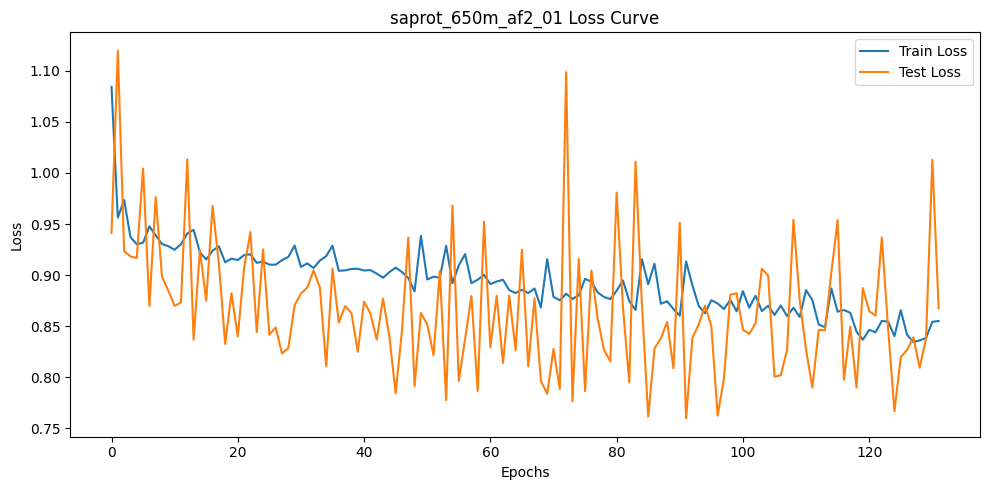

path_savemodel: /nas_data/mingxuan_model/saprot_35m_af2_01.pth


2025-07-15 00:16:58,352 - INFO - Epoch 1, train loss: 1.1571
2025-07-15 00:17:04,818 - INFO - valid loss: 0.9171


=> Saving checkpoint


2025-07-15 00:17:16,013 - INFO - Epoch 2, train loss: 0.9952
2025-07-15 00:17:22,495 - INFO - valid loss: 1.0473
2025-07-15 00:17:32,413 - INFO - Epoch 3, train loss: 0.9557
2025-07-15 00:17:38,866 - INFO - valid loss: 0.9221
2025-07-15 00:17:48,778 - INFO - Epoch 4, train loss: 0.9804
2025-07-15 00:17:55,261 - INFO - valid loss: 0.9551
2025-07-15 00:18:05,077 - INFO - Epoch 5, train loss: 0.9710
2025-07-15 00:18:11,605 - INFO - valid loss: 0.9408
2025-07-15 00:18:21,538 - INFO - Epoch 6, train loss: 0.9458
2025-07-15 00:18:27,916 - INFO - valid loss: 0.9018


=> Saving checkpoint


2025-07-15 00:18:39,241 - INFO - Epoch 7, train loss: 0.9490
2025-07-15 00:18:45,713 - INFO - valid loss: 0.9360
2025-07-15 00:18:55,547 - INFO - Epoch 8, train loss: 0.9470
2025-07-15 00:19:02,023 - INFO - valid loss: 0.9278
2025-07-15 00:19:11,879 - INFO - Epoch 9, train loss: 0.9491
2025-07-15 00:19:18,334 - INFO - valid loss: 0.9553
2025-07-15 00:19:28,123 - INFO - Epoch 10, train loss: 0.9530
2025-07-15 00:19:34,558 - INFO - valid loss: 0.9061
2025-07-15 00:19:44,532 - INFO - Epoch 11, train loss: 0.9530
2025-07-15 00:19:50,956 - INFO - valid loss: 0.8890


=> Saving checkpoint


2025-07-15 00:20:02,043 - INFO - Epoch 12, train loss: 0.9410
2025-07-15 00:20:08,493 - INFO - valid loss: 0.9260
2025-07-15 00:20:18,339 - INFO - Epoch 13, train loss: 0.9434
2025-07-15 00:20:24,779 - INFO - valid loss: 0.9261
2025-07-15 00:20:34,626 - INFO - Epoch 14, train loss: 0.9422
2025-07-15 00:20:41,088 - INFO - valid loss: 0.9046
2025-07-15 00:20:51,042 - INFO - Epoch 15, train loss: 0.9389
2025-07-15 00:20:57,535 - INFO - valid loss: 0.9053
2025-07-15 00:21:07,414 - INFO - Epoch 16, train loss: 0.9500
2025-07-15 00:21:13,910 - INFO - valid loss: 0.9220
2025-07-15 00:21:23,758 - INFO - Epoch 17, train loss: 0.9363
2025-07-15 00:21:30,231 - INFO - valid loss: 0.9082
2025-07-15 00:21:40,088 - INFO - Epoch 18, train loss: 0.9427
2025-07-15 00:21:46,579 - INFO - valid loss: 0.9408
2025-07-15 00:21:56,503 - INFO - Epoch 19, train loss: 0.9411
2025-07-15 00:22:02,980 - INFO - valid loss: 0.8682


=> Saving checkpoint


2025-07-15 00:22:14,190 - INFO - Epoch 20, train loss: 0.9385
2025-07-15 00:22:20,627 - INFO - valid loss: 0.9740
2025-07-15 00:22:30,586 - INFO - Epoch 21, train loss: 0.9509
2025-07-15 00:22:37,023 - INFO - valid loss: 0.8873
2025-07-15 00:22:46,881 - INFO - Epoch 22, train loss: 0.9460
2025-07-15 00:22:53,410 - INFO - valid loss: 0.9105
2025-07-15 00:23:03,287 - INFO - Epoch 23, train loss: 0.9413
2025-07-15 00:23:09,789 - INFO - valid loss: 0.9157
2025-07-15 00:23:19,716 - INFO - Epoch 24, train loss: 0.9422
2025-07-15 00:23:26,155 - INFO - valid loss: 0.8934
2025-07-15 00:23:35,985 - INFO - Epoch 25, train loss: 0.9364
2025-07-15 00:23:42,464 - INFO - valid loss: 0.9300
2025-07-15 00:23:52,256 - INFO - Epoch 26, train loss: 0.9388
2025-07-15 00:23:58,660 - INFO - valid loss: 0.9171
2025-07-15 00:24:08,593 - INFO - Epoch 27, train loss: 0.9411
2025-07-15 00:24:15,041 - INFO - valid loss: 0.9143
2025-07-15 00:24:24,875 - INFO - Epoch 28, train loss: 0.9342
2025-07-15 00:24:31,325 - 

=> Saving checkpoint


2025-07-15 00:24:58,807 - INFO - Epoch 30, train loss: 0.9413
2025-07-15 00:25:05,258 - INFO - valid loss: 0.9256
2025-07-15 00:25:15,157 - INFO - Epoch 31, train loss: 0.9318
2025-07-15 00:25:21,621 - INFO - valid loss: 0.8804
2025-07-15 00:25:31,498 - INFO - Epoch 32, train loss: 0.9379
2025-07-15 00:25:37,958 - INFO - valid loss: 0.9029
2025-07-15 00:25:47,851 - INFO - Epoch 33, train loss: 0.9339
2025-07-15 00:25:54,305 - INFO - valid loss: 0.8924
2025-07-15 00:26:04,113 - INFO - Epoch 34, train loss: 0.9322
2025-07-15 00:26:10,567 - INFO - valid loss: 0.8658
2025-07-15 00:26:20,383 - INFO - Epoch 35, train loss: 0.9347
2025-07-15 00:26:26,831 - INFO - valid loss: 0.9598
2025-07-15 00:26:36,614 - INFO - Epoch 36, train loss: 0.9423
2025-07-15 00:26:43,095 - INFO - valid loss: 0.8643
2025-07-15 00:26:52,902 - INFO - Epoch 37, train loss: 0.9426
2025-07-15 00:26:59,417 - INFO - valid loss: 0.8990
2025-07-15 00:27:09,206 - INFO - Epoch 38, train loss: 0.9316
2025-07-15 00:27:15,651 - 

=> Saving checkpoint


2025-07-15 00:30:10,447 - INFO - Epoch 49, train loss: 0.9651
2025-07-15 00:30:16,920 - INFO - valid loss: 0.9537
2025-07-15 00:30:26,761 - INFO - Epoch 50, train loss: 0.9398
2025-07-15 00:30:33,188 - INFO - valid loss: 0.8625
2025-07-15 00:30:42,970 - INFO - Epoch 51, train loss: 0.9321
2025-07-15 00:30:49,447 - INFO - valid loss: 0.9506
2025-07-15 00:30:59,215 - INFO - Epoch 52, train loss: 0.9345
2025-07-15 00:31:05,663 - INFO - valid loss: 0.8708
2025-07-15 00:31:15,557 - INFO - Epoch 53, train loss: 0.9295
2025-07-15 00:31:22,016 - INFO - valid loss: 0.9182
2025-07-15 00:31:31,903 - INFO - Epoch 54, train loss: 0.9314
2025-07-15 00:31:38,442 - INFO - valid loss: 0.8688
2025-07-15 00:31:48,203 - INFO - Epoch 55, train loss: 0.9296
2025-07-15 00:31:54,700 - INFO - valid loss: 0.9102
2025-07-15 00:32:04,536 - INFO - Epoch 56, train loss: 0.9267
2025-07-15 00:32:11,044 - INFO - valid loss: 0.8843
2025-07-15 00:32:20,960 - INFO - Epoch 57, train loss: 0.9275
2025-07-15 00:32:27,406 - 

=> Saving checkpoint


2025-07-15 00:34:16,529 - INFO - Epoch 64, train loss: 0.9243
2025-07-15 00:34:23,100 - INFO - valid loss: 0.9485
2025-07-15 00:34:32,967 - INFO - Epoch 65, train loss: 0.9345
2025-07-15 00:34:39,465 - INFO - valid loss: 0.8411


=> Saving checkpoint


2025-07-15 00:34:50,766 - INFO - Epoch 66, train loss: 0.9526
2025-07-15 00:34:57,198 - INFO - valid loss: 0.9301
2025-07-15 00:35:07,184 - INFO - Epoch 67, train loss: 0.9276
2025-07-15 00:35:13,722 - INFO - valid loss: 0.8831
2025-07-15 00:35:23,592 - INFO - Epoch 68, train loss: 0.9310
2025-07-15 00:35:30,015 - INFO - valid loss: 0.9375
2025-07-15 00:35:39,853 - INFO - Epoch 69, train loss: 0.9320
2025-07-15 00:35:46,269 - INFO - valid loss: 0.8682
2025-07-15 00:35:56,009 - INFO - Epoch 70, train loss: 0.9292
2025-07-15 00:36:02,444 - INFO - valid loss: 0.8539
2025-07-15 00:36:12,342 - INFO - Epoch 71, train loss: 0.9269
2025-07-15 00:36:18,755 - INFO - valid loss: 0.8932
2025-07-15 00:36:28,685 - INFO - Epoch 72, train loss: 0.9248
2025-07-15 00:36:35,101 - INFO - valid loss: 0.8876
2025-07-15 00:36:44,998 - INFO - Epoch 73, train loss: 0.9261
2025-07-15 00:36:51,526 - INFO - valid loss: 0.8832
2025-07-15 00:37:01,324 - INFO - Epoch 74, train loss: 0.9229
2025-07-15 00:37:07,745 - 

=> Saving checkpoint


2025-07-15 00:39:13,502 - INFO - Epoch 82, train loss: 0.9413
2025-07-15 00:39:20,006 - INFO - valid loss: 0.9599
2025-07-15 00:39:29,770 - INFO - Epoch 83, train loss: 0.9387
2025-07-15 00:39:36,916 - INFO - valid loss: 0.8601
2025-07-15 00:39:46,896 - INFO - Epoch 84, train loss: 0.9308
2025-07-15 00:39:53,412 - INFO - valid loss: 0.8855
2025-07-15 00:40:03,258 - INFO - Epoch 85, train loss: 0.9289
2025-07-15 00:40:09,656 - INFO - valid loss: 0.8762
2025-07-15 00:40:19,511 - INFO - Epoch 86, train loss: 0.9323
2025-07-15 00:40:25,866 - INFO - valid loss: 0.8903
2025-07-15 00:40:35,719 - INFO - Epoch 87, train loss: 0.9271
2025-07-15 00:40:42,175 - INFO - valid loss: 0.8874
2025-07-15 00:40:52,048 - INFO - Epoch 88, train loss: 0.9280
2025-07-15 00:40:58,469 - INFO - valid loss: 0.8654
2025-07-15 00:41:08,397 - INFO - Epoch 89, train loss: 0.9268
2025-07-15 00:41:14,794 - INFO - valid loss: 0.8952
2025-07-15 00:41:24,623 - INFO - Epoch 90, train loss: 0.9250
2025-07-15 00:41:31,056 - 

=> Saving checkpoint


2025-07-15 00:44:26,431 - INFO - Epoch 101, train loss: 0.9343
2025-07-15 00:44:32,905 - INFO - valid loss: 0.8929
2025-07-15 00:44:42,753 - INFO - Epoch 102, train loss: 0.9547
2025-07-15 00:44:49,228 - INFO - valid loss: 0.8707
2025-07-15 00:44:59,093 - INFO - Epoch 103, train loss: 0.9344
2025-07-15 00:45:05,567 - INFO - valid loss: 0.8808
2025-07-15 00:45:15,468 - INFO - Epoch 104, train loss: 0.9274
2025-07-15 00:45:21,939 - INFO - valid loss: 0.8952
2025-07-15 00:45:31,850 - INFO - Epoch 105, train loss: 0.9239
2025-07-15 00:45:38,359 - INFO - valid loss: 0.8713
2025-07-15 00:45:48,215 - INFO - Epoch 106, train loss: 0.9227
2025-07-15 00:45:54,750 - INFO - valid loss: 0.9027
2025-07-15 00:46:04,691 - INFO - Epoch 107, train loss: 0.9277
2025-07-15 00:46:11,172 - INFO - valid loss: 0.8492
2025-07-15 00:46:20,937 - INFO - Epoch 108, train loss: 0.9233
2025-07-15 00:46:27,285 - INFO - valid loss: 0.9109
2025-07-15 00:46:37,081 - INFO - Epoch 109, train loss: 0.9223
2025-07-15 00:46:

=> Saving checkpoint


2025-07-15 00:52:21,318 - INFO - Epoch 130, train loss: 0.9386
2025-07-15 00:52:27,755 - INFO - valid loss: 0.9251
2025-07-15 00:52:37,663 - INFO - Epoch 131, train loss: 0.9263
2025-07-15 00:52:44,146 - INFO - valid loss: 0.8772
2025-07-15 00:52:53,985 - INFO - Epoch 132, train loss: 0.9223
2025-07-15 00:53:00,475 - INFO - valid loss: 0.8448
2025-07-15 00:53:10,298 - INFO - Epoch 133, train loss: 0.9307
2025-07-15 00:53:16,778 - INFO - valid loss: 0.8929
2025-07-15 00:53:26,691 - INFO - Epoch 134, train loss: 0.9222
2025-07-15 00:53:33,197 - INFO - valid loss: 0.8574
2025-07-15 00:53:43,048 - INFO - Epoch 135, train loss: 0.9233
2025-07-15 00:53:49,520 - INFO - valid loss: 0.9249
2025-07-15 00:53:59,292 - INFO - Epoch 136, train loss: 0.9301
2025-07-15 00:54:05,749 - INFO - valid loss: 0.8542
2025-07-15 00:54:15,628 - INFO - Epoch 137, train loss: 0.9235
2025-07-15 00:54:22,040 - INFO - valid loss: 0.9173
2025-07-15 00:54:31,867 - INFO - Epoch 138, train loss: 0.9188
2025-07-15 00:54:

early stop at epoch 169
=> Training completed! Best loss is 0.8280 at epoch 129


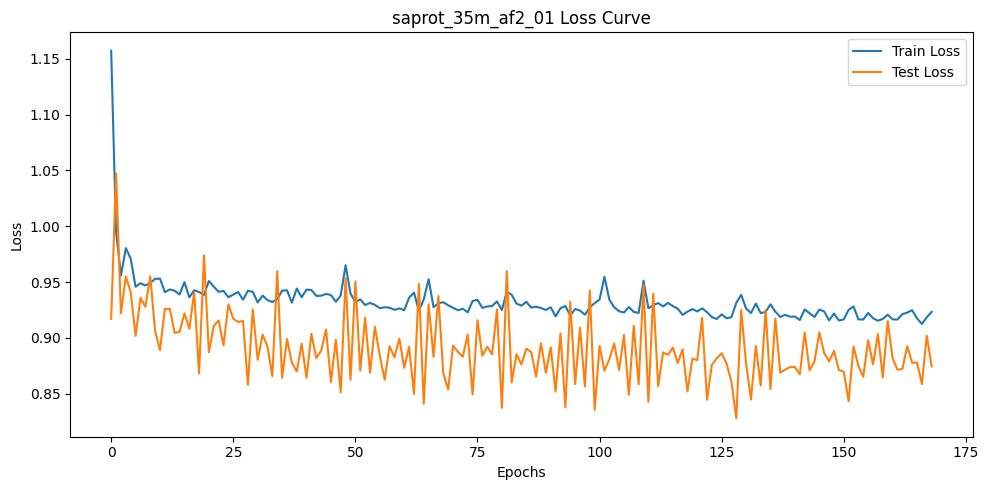

path_savemodel: /nas_data/mingxuan_model/proteinglm_3b_mlm_01.pth
[2025-07-15 01:03:05,133] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-07-15 01:03:05,239 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat -fno-strict-overflow -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -c /tmp/tmpndaqqv8p/test.c -o /tmp/tmpndaqqv8p/test.o
2025-07-15 01:03:05,353 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat /tmp/tmpndaqqv8p/test.o -laio -o /tmp/tmpndaqqv8p/a.out
2025-07-15 01:03:06,021 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat -fno-strict-overflow -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -c /tmp/tmp72uhnow2/test.c -o /tmp/tmp72uhnow2/test.o
2025-07-15 01:03:06,061 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat /tmp/tmp72uhnow2/test.o -L

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-15 01:06:34,639 - INFO - Epoch 1, train loss: 1.1017
2025-07-15 01:07:03,636 - INFO - valid loss: 1.0490


=> Saving checkpoint


2025-07-15 01:11:50,375 - INFO - Epoch 2, train loss: 0.9536
2025-07-15 01:12:19,328 - INFO - valid loss: 1.0046


=> Saving checkpoint


2025-07-15 01:17:09,350 - INFO - Epoch 3, train loss: 0.9332
2025-07-15 01:17:38,332 - INFO - valid loss: 1.0033


=> Saving checkpoint


2025-07-15 01:22:26,881 - INFO - Epoch 4, train loss: 0.9178
2025-07-15 01:22:55,870 - INFO - valid loss: 1.0282
2025-07-15 01:25:56,733 - INFO - Epoch 5, train loss: 0.9189
2025-07-15 01:26:25,692 - INFO - valid loss: 1.0656
2025-07-15 01:29:26,745 - INFO - Epoch 6, train loss: 0.9053
2025-07-15 01:29:55,762 - INFO - valid loss: 1.0162
2025-07-15 01:32:56,662 - INFO - Epoch 7, train loss: 0.8942
2025-07-15 01:33:25,618 - INFO - valid loss: 1.0619
2025-07-15 01:36:26,490 - INFO - Epoch 8, train loss: 0.8629
2025-07-15 01:36:55,603 - INFO - valid loss: 0.9586


=> Saving checkpoint


2025-07-15 01:41:44,911 - INFO - Epoch 9, train loss: 0.8812
2025-07-15 01:42:13,828 - INFO - valid loss: 1.2598
2025-07-15 01:45:14,651 - INFO - Epoch 10, train loss: 0.8989
2025-07-15 01:45:43,705 - INFO - valid loss: 1.0275
2025-07-15 01:48:44,625 - INFO - Epoch 11, train loss: 0.8421
2025-07-15 01:49:13,683 - INFO - valid loss: 0.9275


=> Saving checkpoint


2025-07-15 01:54:03,265 - INFO - Epoch 12, train loss: 0.8379
2025-07-15 01:54:32,260 - INFO - valid loss: 0.9191


=> Saving checkpoint


2025-07-15 01:59:20,373 - INFO - Epoch 13, train loss: 0.8156
2025-07-15 01:59:49,407 - INFO - valid loss: 0.9267
2025-07-15 02:02:50,191 - INFO - Epoch 14, train loss: 0.8100
2025-07-15 02:03:19,231 - INFO - valid loss: 0.9207
2025-07-15 02:06:20,040 - INFO - Epoch 15, train loss: 0.7833
2025-07-15 02:06:49,069 - INFO - valid loss: 0.9038


=> Saving checkpoint


2025-07-15 02:11:37,383 - INFO - Epoch 16, train loss: 0.7849
2025-07-15 02:12:06,469 - INFO - valid loss: 1.0904
2025-07-15 02:15:07,450 - INFO - Epoch 17, train loss: 0.7885
2025-07-15 02:15:36,559 - INFO - valid loss: 0.9478
2025-07-15 02:18:37,429 - INFO - Epoch 18, train loss: 0.8319
2025-07-15 02:19:06,461 - INFO - valid loss: 1.0418
2025-07-15 02:22:07,368 - INFO - Epoch 19, train loss: 0.7941
2025-07-15 02:22:36,427 - INFO - valid loss: 0.9636
2025-07-15 02:25:37,340 - INFO - Epoch 20, train loss: 0.7537
2025-07-15 02:26:06,390 - INFO - valid loss: 0.9417
2025-07-15 02:29:07,347 - INFO - Epoch 21, train loss: 0.7516
2025-07-15 02:29:36,339 - INFO - valid loss: 1.0250
2025-07-15 02:32:37,193 - INFO - Epoch 22, train loss: 0.7494
2025-07-15 02:33:06,237 - INFO - valid loss: 0.8718


=> Saving checkpoint


2025-07-15 02:37:56,412 - INFO - Epoch 23, train loss: 0.7212
2025-07-15 02:38:25,427 - INFO - valid loss: 0.8251


=> Saving checkpoint


2025-07-15 02:43:15,889 - INFO - Epoch 24, train loss: 0.8415
2025-07-15 02:43:44,959 - INFO - valid loss: 1.0795
2025-07-15 02:46:45,859 - INFO - Epoch 25, train loss: 0.8375
2025-07-15 02:47:14,944 - INFO - valid loss: 0.8391
2025-07-15 02:50:15,790 - INFO - Epoch 26, train loss: 0.7621
2025-07-15 02:50:44,706 - INFO - valid loss: 0.9107
2025-07-15 02:53:45,656 - INFO - Epoch 27, train loss: 0.7140
2025-07-15 02:54:14,690 - INFO - valid loss: 0.9599
2025-07-15 02:57:15,547 - INFO - Epoch 28, train loss: 0.7014
2025-07-15 02:57:44,718 - INFO - valid loss: 0.8352
2025-07-15 03:00:45,538 - INFO - Epoch 29, train loss: 0.6781
2025-07-15 03:01:14,566 - INFO - valid loss: 1.1048
2025-07-15 03:04:15,448 - INFO - Epoch 30, train loss: 0.6893
2025-07-15 03:04:44,382 - INFO - valid loss: 0.9324
2025-07-15 03:07:45,332 - INFO - Epoch 31, train loss: 0.6510
2025-07-15 03:08:14,392 - INFO - valid loss: 0.8248


=> Saving checkpoint


2025-07-15 03:13:04,659 - INFO - Epoch 32, train loss: 0.6520
2025-07-15 03:13:33,646 - INFO - valid loss: 0.9021
2025-07-15 03:16:34,536 - INFO - Epoch 33, train loss: 0.6338
2025-07-15 03:17:03,551 - INFO - valid loss: 0.8666
2025-07-15 03:20:04,506 - INFO - Epoch 34, train loss: 0.6744
2025-07-15 03:20:33,584 - INFO - valid loss: 0.8397
2025-07-15 03:23:34,558 - INFO - Epoch 35, train loss: 0.6833
2025-07-15 03:24:03,642 - INFO - valid loss: 1.0588
2025-07-15 03:27:04,515 - INFO - Epoch 36, train loss: 0.6971
2025-07-15 03:27:33,575 - INFO - valid loss: 1.0556
2025-07-15 03:30:34,514 - INFO - Epoch 37, train loss: 0.6880
2025-07-15 03:31:03,601 - INFO - valid loss: 0.8455
2025-07-15 03:34:04,618 - INFO - Epoch 38, train loss: 0.6509
2025-07-15 03:34:33,636 - INFO - valid loss: 0.9076
2025-07-15 03:37:34,617 - INFO - Epoch 39, train loss: 0.6254
2025-07-15 03:38:03,748 - INFO - valid loss: 0.9023
2025-07-15 03:41:04,747 - INFO - Epoch 40, train loss: 0.6290
2025-07-15 03:41:33,824 - 

=> Saving checkpoint


2025-07-15 03:56:52,309 - INFO - Epoch 44, train loss: 0.7095
2025-07-15 03:57:21,341 - INFO - valid loss: 0.7637


=> Saving checkpoint


2025-07-15 04:02:12,028 - INFO - Epoch 45, train loss: 0.7110
2025-07-15 04:02:41,056 - INFO - valid loss: 1.0759
2025-07-15 04:05:41,838 - INFO - Epoch 46, train loss: 0.7045
2025-07-15 04:06:10,891 - INFO - valid loss: 0.8378
2025-07-15 04:09:11,824 - INFO - Epoch 47, train loss: 0.6111
2025-07-15 04:09:40,809 - INFO - valid loss: 0.8265
2025-07-15 04:12:41,635 - INFO - Epoch 48, train loss: 0.5766
2025-07-15 04:13:10,681 - INFO - valid loss: 0.9403
2025-07-15 04:16:11,644 - INFO - Epoch 49, train loss: 0.5618
2025-07-15 04:16:40,729 - INFO - valid loss: 0.9786
2025-07-15 04:19:41,633 - INFO - Epoch 50, train loss: 0.5788
2025-07-15 04:20:10,770 - INFO - valid loss: 0.7637


=> Saving checkpoint


2025-07-15 04:24:59,295 - INFO - Epoch 51, train loss: 0.6205
2025-07-15 04:25:28,331 - INFO - valid loss: 1.0026
2025-07-15 04:28:29,319 - INFO - Epoch 52, train loss: 0.6593
2025-07-15 04:28:58,336 - INFO - valid loss: 1.0786
2025-07-15 04:31:59,221 - INFO - Epoch 53, train loss: 0.5699
2025-07-15 04:32:28,241 - INFO - valid loss: 0.8209
2025-07-15 04:35:29,268 - INFO - Epoch 54, train loss: 0.5720
2025-07-15 04:35:58,268 - INFO - valid loss: 0.8109
2025-07-15 04:38:59,230 - INFO - Epoch 55, train loss: 0.6423
2025-07-15 04:39:28,250 - INFO - valid loss: 0.8658
2025-07-15 04:42:29,200 - INFO - Epoch 56, train loss: 0.5855
2025-07-15 04:42:58,245 - INFO - valid loss: 0.8950
2025-07-15 04:45:59,156 - INFO - Epoch 57, train loss: 0.5435
2025-07-15 04:46:28,174 - INFO - valid loss: 0.9898
2025-07-15 04:49:29,050 - INFO - Epoch 58, train loss: 0.5249
2025-07-15 04:49:58,132 - INFO - valid loss: 1.0701
2025-07-15 04:52:59,124 - INFO - Epoch 59, train loss: 0.5940
2025-07-15 04:53:28,152 - 

=> Saving checkpoint


2025-07-15 05:19:20,538 - INFO - Epoch 66, train loss: 0.5280
2025-07-15 05:19:49,544 - INFO - valid loss: 0.9784
2025-07-15 05:22:50,437 - INFO - Epoch 67, train loss: 0.4812
2025-07-15 05:23:19,499 - INFO - valid loss: 0.9046
2025-07-15 05:26:20,408 - INFO - Epoch 68, train loss: 0.5368
2025-07-15 05:26:49,485 - INFO - valid loss: 1.0610
2025-07-15 05:29:50,300 - INFO - Epoch 69, train loss: 0.5960
2025-07-15 05:30:19,387 - INFO - valid loss: 0.8101
2025-07-15 05:33:20,360 - INFO - Epoch 70, train loss: 0.5250
2025-07-15 05:33:49,431 - INFO - valid loss: 0.9191
2025-07-15 05:36:50,288 - INFO - Epoch 71, train loss: 0.5005
2025-07-15 05:37:19,368 - INFO - valid loss: 0.7605
2025-07-15 05:40:20,380 - INFO - Epoch 72, train loss: 0.5203
2025-07-15 05:40:49,525 - INFO - valid loss: 0.8426
2025-07-15 05:43:50,414 - INFO - Epoch 73, train loss: 0.4661
2025-07-15 05:44:19,489 - INFO - valid loss: 0.7939
2025-07-15 05:47:20,379 - INFO - Epoch 74, train loss: 0.4671
2025-07-15 05:47:49,430 - 

early stop at epoch 105
=> Training completed! Best loss is 0.7420 at epoch 65


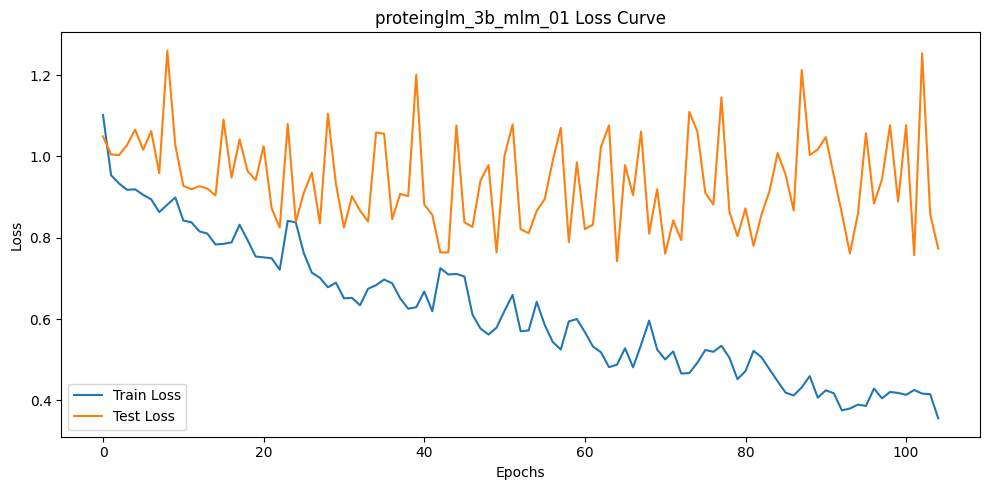

path_savemodel: /nas_data/mingxuan_model/proteinglm_3b_clm_01.pth


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-15 07:39:55,161 - INFO - Epoch 1, train loss: 1.1333
2025-07-15 07:40:24,232 - INFO - valid loss: 1.0289


=> Saving checkpoint


2025-07-15 07:45:19,676 - INFO - Epoch 2, train loss: 0.9959
2025-07-15 07:45:48,827 - INFO - valid loss: 1.0181


=> Saving checkpoint


2025-07-15 07:50:36,920 - INFO - Epoch 3, train loss: 0.9823
2025-07-15 07:51:05,943 - INFO - valid loss: 0.9035


=> Saving checkpoint


2025-07-15 07:55:54,181 - INFO - Epoch 4, train loss: 0.9605
2025-07-15 07:56:23,284 - INFO - valid loss: 1.0468
2025-07-15 07:59:23,906 - INFO - Epoch 5, train loss: 0.9934
2025-07-15 07:59:52,892 - INFO - valid loss: 0.8883


=> Saving checkpoint


2025-07-15 08:04:41,517 - INFO - Epoch 6, train loss: 0.9719
2025-07-15 08:05:10,457 - INFO - valid loss: 1.0090
2025-07-15 08:08:10,995 - INFO - Epoch 7, train loss: 0.9252
2025-07-15 08:08:39,942 - INFO - valid loss: 0.8976
2025-07-15 08:11:40,485 - INFO - Epoch 8, train loss: 0.9036
2025-07-15 08:12:09,526 - INFO - valid loss: 1.0371
2025-07-15 08:15:10,055 - INFO - Epoch 9, train loss: 0.9125
2025-07-15 08:15:38,991 - INFO - valid loss: 1.0160
2025-07-15 08:18:39,438 - INFO - Epoch 10, train loss: 0.9045
2025-07-15 08:19:08,411 - INFO - valid loss: 1.2025
2025-07-15 08:22:08,940 - INFO - Epoch 11, train loss: 0.8705
2025-07-15 08:22:37,993 - INFO - valid loss: 0.9839
2025-07-15 08:25:38,616 - INFO - Epoch 12, train loss: 0.8287
2025-07-15 08:26:07,613 - INFO - valid loss: 0.9580
2025-07-15 08:29:08,182 - INFO - Epoch 13, train loss: 0.8332
2025-07-15 08:29:37,166 - INFO - valid loss: 1.3107
2025-07-15 08:32:37,763 - INFO - Epoch 14, train loss: 0.8437
2025-07-15 08:33:06,880 - INFO

=> Saving checkpoint


2025-07-15 08:44:59,446 - INFO - Epoch 17, train loss: 0.7393
2025-07-15 08:45:28,515 - INFO - valid loss: 0.8558
2025-07-15 08:48:29,295 - INFO - Epoch 18, train loss: 0.7015
2025-07-15 08:48:58,414 - INFO - valid loss: 0.9325
2025-07-15 08:51:59,060 - INFO - Epoch 19, train loss: 0.6930
2025-07-15 08:52:28,136 - INFO - valid loss: 0.7905
2025-07-15 08:55:28,826 - INFO - Epoch 20, train loss: 0.7573
2025-07-15 08:55:57,885 - INFO - valid loss: 0.8676
2025-07-15 08:58:58,458 - INFO - Epoch 21, train loss: 0.8238
2025-07-15 08:59:27,494 - INFO - valid loss: 0.8013
2025-07-15 09:02:28,012 - INFO - Epoch 22, train loss: 0.7439
2025-07-15 09:02:57,028 - INFO - valid loss: 0.8070
2025-07-15 09:05:57,497 - INFO - Epoch 23, train loss: 0.6510
2025-07-15 09:06:26,562 - INFO - valid loss: 1.0420
2025-07-15 09:09:27,106 - INFO - Epoch 24, train loss: 0.6090
2025-07-15 09:09:56,116 - INFO - valid loss: 0.7630


=> Saving checkpoint


2025-07-15 09:14:48,795 - INFO - Epoch 25, train loss: 0.6264
2025-07-15 09:15:17,858 - INFO - valid loss: 0.7578


=> Saving checkpoint


2025-07-15 09:20:08,181 - INFO - Epoch 26, train loss: 0.6165
2025-07-15 09:20:37,289 - INFO - valid loss: 1.1458
2025-07-15 09:23:37,988 - INFO - Epoch 27, train loss: 0.6494
2025-07-15 09:24:06,994 - INFO - valid loss: 0.8965
2025-07-15 09:27:07,617 - INFO - Epoch 28, train loss: 0.5949
2025-07-15 09:27:36,693 - INFO - valid loss: 0.7661
2025-07-15 09:30:37,411 - INFO - Epoch 29, train loss: 0.6699
2025-07-15 09:31:06,438 - INFO - valid loss: 1.0942
2025-07-15 09:34:07,085 - INFO - Epoch 30, train loss: 0.6018
2025-07-15 09:34:36,118 - INFO - valid loss: 0.8807
2025-07-15 09:37:36,699 - INFO - Epoch 31, train loss: 0.5503
2025-07-15 09:38:05,726 - INFO - valid loss: 0.7711
2025-07-15 09:41:06,439 - INFO - Epoch 32, train loss: 0.5517
2025-07-15 09:41:35,534 - INFO - valid loss: 0.8327
2025-07-15 09:44:36,211 - INFO - Epoch 33, train loss: 0.5115
2025-07-15 09:45:05,198 - INFO - valid loss: 0.8711
2025-07-15 09:48:05,857 - INFO - Epoch 34, train loss: 0.4750
2025-07-15 09:48:34,907 - 

=> Saving checkpoint


2025-07-15 10:03:55,009 - INFO - Epoch 38, train loss: 0.4285
2025-07-15 10:04:23,992 - INFO - valid loss: 0.8631
2025-07-15 10:07:24,637 - INFO - Epoch 39, train loss: 0.5877
2025-07-15 10:07:53,608 - INFO - valid loss: 1.2142
2025-07-15 10:10:54,136 - INFO - Epoch 40, train loss: 0.4883
2025-07-15 10:11:23,068 - INFO - valid loss: 0.7916
2025-07-15 10:14:23,557 - INFO - Epoch 41, train loss: 0.4725
2025-07-15 10:14:52,481 - INFO - valid loss: 0.7890
2025-07-15 10:17:52,955 - INFO - Epoch 42, train loss: 0.4076
2025-07-15 10:18:21,914 - INFO - valid loss: 0.8301
2025-07-15 10:21:22,543 - INFO - Epoch 43, train loss: 0.4395
2025-07-15 10:21:51,433 - INFO - valid loss: 0.7617
2025-07-15 10:24:51,853 - INFO - Epoch 44, train loss: 0.3883
2025-07-15 10:25:20,813 - INFO - valid loss: 1.0180
2025-07-15 10:28:21,442 - INFO - Epoch 45, train loss: 0.3895
2025-07-15 10:28:50,359 - INFO - valid loss: 1.0311
2025-07-15 10:31:51,000 - INFO - Epoch 46, train loss: 0.3826
2025-07-15 10:32:20,024 - 

=> Saving checkpoint


2025-07-15 10:58:07,940 - INFO - Epoch 53, train loss: 0.3650
2025-07-15 10:58:36,901 - INFO - valid loss: 0.7025
2025-07-15 11:01:37,446 - INFO - Epoch 54, train loss: 0.3283
2025-07-15 11:02:06,410 - INFO - valid loss: 0.8828
2025-07-15 11:05:07,035 - INFO - Epoch 55, train loss: 0.3158
2025-07-15 11:05:35,974 - INFO - valid loss: 0.8476
2025-07-15 11:08:36,661 - INFO - Epoch 56, train loss: 0.3370
2025-07-15 11:09:05,634 - INFO - valid loss: 0.9815
2025-07-15 11:12:06,260 - INFO - Epoch 57, train loss: 0.2848
2025-07-15 11:12:35,213 - INFO - valid loss: 0.8028
2025-07-15 11:15:35,841 - INFO - Epoch 58, train loss: 0.2942
2025-07-15 11:16:04,801 - INFO - valid loss: 0.7501
2025-07-15 11:19:05,282 - INFO - Epoch 59, train loss: 0.2719
2025-07-15 11:19:34,229 - INFO - valid loss: 0.8048
2025-07-15 11:22:34,822 - INFO - Epoch 60, train loss: 0.2451
2025-07-15 11:23:03,788 - INFO - valid loss: 1.0042
2025-07-15 11:26:04,453 - INFO - Epoch 61, train loss: 0.2777
2025-07-15 11:26:33,465 - 

=> Saving checkpoint


2025-07-15 11:48:52,575 - INFO - Epoch 67, train loss: 0.3380
2025-07-15 11:49:21,585 - INFO - valid loss: 0.8251
2025-07-15 11:52:22,173 - INFO - Epoch 68, train loss: 0.3005
2025-07-15 11:52:51,171 - INFO - valid loss: 0.9272
2025-07-15 11:55:51,756 - INFO - Epoch 69, train loss: 0.3008
2025-07-15 11:56:20,827 - INFO - valid loss: 0.7867
2025-07-15 11:59:21,600 - INFO - Epoch 70, train loss: 0.2126
2025-07-15 11:59:50,580 - INFO - valid loss: 0.6890
2025-07-15 12:02:51,174 - INFO - Epoch 71, train loss: 0.1705
2025-07-15 12:03:20,049 - INFO - valid loss: 0.8570
2025-07-15 12:06:20,444 - INFO - Epoch 72, train loss: 0.1486
2025-07-15 12:06:49,418 - INFO - valid loss: 0.8881
2025-07-15 12:09:49,954 - INFO - Epoch 73, train loss: 0.1439
2025-07-15 12:10:18,860 - INFO - valid loss: 0.8322
2025-07-15 12:13:19,522 - INFO - Epoch 74, train loss: 0.1659
2025-07-15 12:13:48,476 - INFO - valid loss: 0.6783
2025-07-15 12:16:48,959 - INFO - Epoch 75, train loss: 0.2137
2025-07-15 12:17:17,882 - 

early stop at epoch 106
=> Training completed! Best loss is 0.6122 at epoch 66


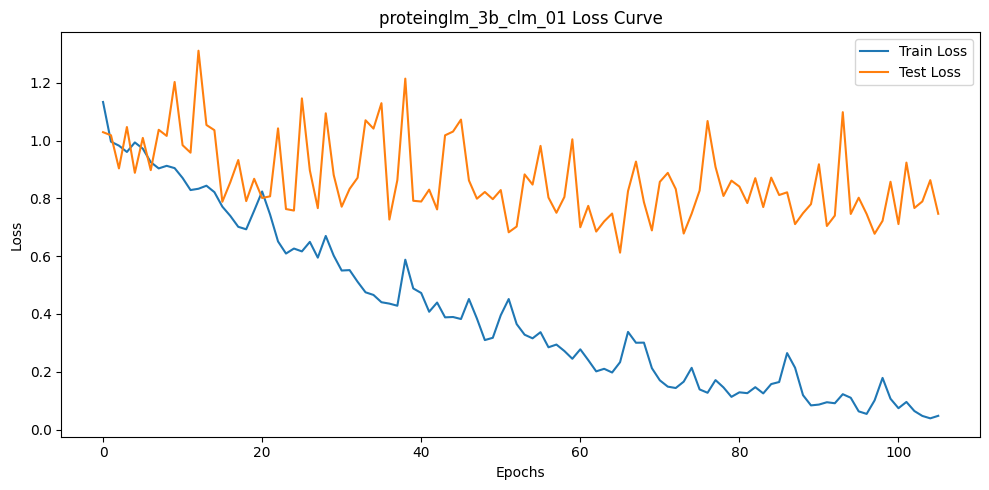

path_savemodel: /nas_data/mingxuan_model/aido_protein_16b_01.pth


Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

2025-07-15 14:13:50,032 - INFO - Epoch 1, train loss: 1.1276
2025-07-15 14:14:24,108 - INFO - valid loss: 0.9734


=> Saving checkpoint


2025-07-15 14:18:32,014 - INFO - Epoch 2, train loss: 1.0082
2025-07-15 14:19:06,041 - INFO - valid loss: 0.9953
2025-07-15 14:23:10,858 - INFO - Epoch 3, train loss: 0.9730
2025-07-15 14:23:44,800 - INFO - valid loss: 0.9667


=> Saving checkpoint


2025-07-15 14:27:53,196 - INFO - Epoch 4, train loss: 0.9612
2025-07-15 14:28:27,276 - INFO - valid loss: 1.0036
2025-07-15 14:32:35,433 - INFO - Epoch 5, train loss: 0.9487
2025-07-15 14:33:09,438 - INFO - valid loss: 0.9711
2025-07-15 14:37:14,614 - INFO - Epoch 6, train loss: 0.9438
2025-07-15 14:37:48,873 - INFO - valid loss: 0.9210


=> Saving checkpoint


2025-07-15 14:41:57,277 - INFO - Epoch 7, train loss: 0.9371
2025-07-15 14:42:31,371 - INFO - valid loss: 0.9357
2025-07-15 14:46:37,679 - INFO - Epoch 8, train loss: 0.9247
2025-07-15 14:47:11,790 - INFO - valid loss: 1.0197
2025-07-15 14:51:18,819 - INFO - Epoch 9, train loss: 0.9011
2025-07-15 14:51:53,136 - INFO - valid loss: 0.8089


=> Saving checkpoint


2025-07-15 14:55:56,364 - INFO - Epoch 10, train loss: 0.9291
2025-07-15 14:56:30,774 - INFO - valid loss: 0.9097
2025-07-15 15:00:35,626 - INFO - Epoch 11, train loss: 0.8810
2025-07-15 15:01:10,256 - INFO - valid loss: 0.8027


=> Saving checkpoint


2025-07-15 15:05:16,624 - INFO - Epoch 12, train loss: 0.9069
2025-07-15 15:05:51,094 - INFO - valid loss: 0.7909


=> Saving checkpoint


2025-07-15 15:10:02,572 - INFO - Epoch 13, train loss: 0.8909
2025-07-15 15:10:36,961 - INFO - valid loss: 0.8350
2025-07-15 15:14:41,555 - INFO - Epoch 14, train loss: 0.9070
2025-07-15 15:15:16,115 - INFO - valid loss: 0.8491
2025-07-15 15:19:17,806 - INFO - Epoch 15, train loss: 0.8811
2025-07-15 15:19:52,482 - INFO - valid loss: 0.9017
2025-07-15 15:23:58,562 - INFO - Epoch 16, train loss: 0.8654
2025-07-15 15:24:33,110 - INFO - valid loss: 1.1316
2025-07-15 15:28:31,193 - INFO - Epoch 17, train loss: 0.8604
2025-07-15 15:29:05,870 - INFO - valid loss: 0.8442
2025-07-15 15:33:17,132 - INFO - Epoch 18, train loss: 0.8430
2025-07-15 15:33:51,831 - INFO - valid loss: 0.7855


=> Saving checkpoint


2025-07-15 15:37:59,165 - INFO - Epoch 19, train loss: 0.8331
2025-07-15 15:38:33,777 - INFO - valid loss: 0.7948
2025-07-15 15:42:35,576 - INFO - Epoch 20, train loss: 0.8536
2025-07-15 15:43:10,232 - INFO - valid loss: 0.7946
2025-07-15 15:47:16,171 - INFO - Epoch 21, train loss: 0.8335
2025-07-15 15:47:50,884 - INFO - valid loss: 0.8061
2025-07-15 15:51:54,727 - INFO - Epoch 22, train loss: 0.8244
2025-07-15 15:52:29,483 - INFO - valid loss: 0.8984
2025-07-15 15:56:36,296 - INFO - Epoch 23, train loss: 0.8068
2025-07-15 15:57:10,885 - INFO - valid loss: 1.0152
2025-07-15 16:01:14,519 - INFO - Epoch 24, train loss: 0.7913
2025-07-15 16:01:49,157 - INFO - valid loss: 0.7546


=> Saving checkpoint


2025-07-15 16:05:57,372 - INFO - Epoch 25, train loss: 0.8215
2025-07-15 16:06:32,059 - INFO - valid loss: 0.9006
2025-07-15 16:10:42,588 - INFO - Epoch 26, train loss: 0.8887
2025-07-15 16:11:17,239 - INFO - valid loss: 1.0562
2025-07-15 16:15:27,617 - INFO - Epoch 27, train loss: 0.8373
2025-07-15 16:16:02,256 - INFO - valid loss: 0.8604
2025-07-15 16:20:11,055 - INFO - Epoch 28, train loss: 0.7915
2025-07-15 16:20:45,605 - INFO - valid loss: 0.7937
2025-07-15 16:24:50,972 - INFO - Epoch 29, train loss: 0.7681
2025-07-15 16:25:25,557 - INFO - valid loss: 0.8031
2025-07-15 16:29:31,823 - INFO - Epoch 30, train loss: 0.7785
2025-07-15 16:30:06,338 - INFO - valid loss: 0.8372
2025-07-15 16:34:06,346 - INFO - Epoch 31, train loss: 0.7899
2025-07-15 16:34:40,934 - INFO - valid loss: 0.8386
2025-07-15 16:38:45,344 - INFO - Epoch 32, train loss: 0.7626
2025-07-15 16:39:19,775 - INFO - valid loss: 0.7400


=> Saving checkpoint


2025-07-15 16:43:25,802 - INFO - Epoch 33, train loss: 0.8460
2025-07-15 16:44:00,121 - INFO - valid loss: 1.1311
2025-07-15 16:48:03,642 - INFO - Epoch 34, train loss: 0.8125
2025-07-15 16:48:38,124 - INFO - valid loss: 0.8865
2025-07-15 16:52:46,653 - INFO - Epoch 35, train loss: 0.8024
2025-07-15 16:53:21,118 - INFO - valid loss: 0.7950
2025-07-15 16:57:18,572 - INFO - Epoch 36, train loss: 0.7586
2025-07-15 16:57:53,076 - INFO - valid loss: 0.8506
2025-07-15 17:02:00,601 - INFO - Epoch 37, train loss: 0.7503
2025-07-15 17:02:35,100 - INFO - valid loss: 0.7570
2025-07-15 17:06:40,864 - INFO - Epoch 38, train loss: 0.7094
2025-07-15 17:07:15,312 - INFO - valid loss: 0.7117


=> Saving checkpoint


2025-07-15 17:11:13,479 - INFO - Epoch 39, train loss: 0.7124
2025-07-15 17:11:47,797 - INFO - valid loss: 0.7642
2025-07-15 17:15:50,844 - INFO - Epoch 40, train loss: 0.8296
2025-07-15 17:16:25,185 - INFO - valid loss: 0.8553
2025-07-15 17:20:23,336 - INFO - Epoch 41, train loss: 0.7214
2025-07-15 17:20:57,710 - INFO - valid loss: 0.7360
2025-07-15 17:25:04,584 - INFO - Epoch 42, train loss: 0.7789
2025-07-15 17:25:38,745 - INFO - valid loss: 0.9369
2025-07-15 17:29:39,024 - INFO - Epoch 43, train loss: 0.7654
2025-07-15 17:30:13,448 - INFO - valid loss: 0.7762
2025-07-15 17:34:20,226 - INFO - Epoch 44, train loss: 0.8493
2025-07-15 17:34:54,536 - INFO - valid loss: 0.7372
2025-07-15 17:38:58,695 - INFO - Epoch 45, train loss: 0.8370
2025-07-15 17:39:33,047 - INFO - valid loss: 0.7668
2025-07-15 17:43:36,475 - INFO - Epoch 46, train loss: 0.8338
2025-07-15 17:44:10,828 - INFO - valid loss: 0.8644
2025-07-15 17:48:17,455 - INFO - Epoch 47, train loss: 0.7691
2025-07-15 17:48:51,782 - 

=> Saving checkpoint


2025-07-15 17:57:36,179 - INFO - Epoch 49, train loss: 0.7450
2025-07-15 17:58:10,546 - INFO - valid loss: 0.7391
2025-07-15 18:02:09,231 - INFO - Epoch 50, train loss: 0.7262
2025-07-15 18:02:43,639 - INFO - valid loss: 0.7175
2025-07-15 18:06:43,188 - INFO - Epoch 51, train loss: 0.6793
2025-07-15 18:07:17,393 - INFO - valid loss: 0.7648
2025-07-15 18:11:18,468 - INFO - Epoch 52, train loss: 0.8447
2025-07-15 18:11:52,872 - INFO - valid loss: 1.1591
2025-07-15 18:16:02,431 - INFO - Epoch 53, train loss: 0.8455
2025-07-15 18:16:36,844 - INFO - valid loss: 0.8494
2025-07-15 18:20:43,863 - INFO - Epoch 54, train loss: 0.7557
2025-07-15 18:21:18,173 - INFO - valid loss: 0.8140
2025-07-15 18:25:21,063 - INFO - Epoch 55, train loss: 0.6929
2025-07-15 18:25:55,361 - INFO - valid loss: 0.8692
2025-07-15 18:29:59,071 - INFO - Epoch 56, train loss: 0.7234
2025-07-15 18:30:33,438 - INFO - valid loss: 1.1393
2025-07-15 18:34:27,917 - INFO - Epoch 57, train loss: 0.6716
2025-07-15 18:35:02,285 - 

=> Saving checkpoint


2025-07-15 18:43:47,773 - INFO - Epoch 59, train loss: 0.6953
2025-07-15 18:44:22,094 - INFO - valid loss: 0.6725


=> Saving checkpoint


2025-07-15 18:48:30,713 - INFO - Epoch 60, train loss: 0.6915
2025-07-15 18:49:05,005 - INFO - valid loss: 0.8274
2025-07-15 18:53:06,404 - INFO - Epoch 61, train loss: 0.7082
2025-07-15 18:53:40,807 - INFO - valid loss: 0.7800
2025-07-15 18:57:46,361 - INFO - Epoch 62, train loss: 0.6584
2025-07-15 18:58:20,732 - INFO - valid loss: 0.7006
2025-07-15 19:02:24,751 - INFO - Epoch 63, train loss: 0.6593
2025-07-15 19:02:59,020 - INFO - valid loss: 0.8017
2025-07-15 19:07:01,424 - INFO - Epoch 64, train loss: 0.7561
2025-07-15 19:07:35,804 - INFO - valid loss: 0.9260
2025-07-15 19:11:42,868 - INFO - Epoch 65, train loss: 0.6955
2025-07-15 19:12:17,236 - INFO - valid loss: 0.7295
2025-07-15 19:16:21,626 - INFO - Epoch 66, train loss: 0.6869
2025-07-15 19:16:55,964 - INFO - valid loss: 0.6833
2025-07-15 19:21:02,542 - INFO - Epoch 67, train loss: 0.6451
2025-07-15 19:21:36,937 - INFO - valid loss: 0.7356
2025-07-15 19:25:30,878 - INFO - Epoch 68, train loss: 0.6524
2025-07-15 19:26:05,239 - 

=> Saving checkpoint


2025-07-15 19:34:48,534 - INFO - Epoch 70, train loss: 0.6799
2025-07-15 19:35:22,894 - INFO - valid loss: 1.0313
2025-07-15 19:39:33,667 - INFO - Epoch 71, train loss: 0.8027
2025-07-15 19:40:08,109 - INFO - valid loss: 0.9910
2025-07-15 19:44:14,276 - INFO - Epoch 72, train loss: 0.7423
2025-07-15 19:44:48,634 - INFO - valid loss: 0.9126
2025-07-15 19:48:55,846 - INFO - Epoch 73, train loss: 0.6938
2025-07-15 19:49:30,150 - INFO - valid loss: 0.7543
2025-07-15 19:53:23,318 - INFO - Epoch 74, train loss: 0.6249
2025-07-15 19:53:57,658 - INFO - valid loss: 0.9768
2025-07-15 19:57:56,740 - INFO - Epoch 75, train loss: 0.6377
2025-07-15 19:58:31,032 - INFO - valid loss: 0.6787
2025-07-15 20:02:26,276 - INFO - Epoch 76, train loss: 0.7119
2025-07-15 20:03:00,637 - INFO - valid loss: 0.7648
2025-07-15 20:07:03,475 - INFO - Epoch 77, train loss: 0.7712
2025-07-15 20:07:37,773 - INFO - valid loss: 0.7151
2025-07-15 20:11:48,368 - INFO - Epoch 78, train loss: 0.6844
2025-07-15 20:12:22,814 - 

=> Saving checkpoint


2025-07-15 21:02:56,659 - INFO - Epoch 89, train loss: 0.5794
2025-07-15 21:03:31,030 - INFO - valid loss: 0.6829
2025-07-15 21:07:35,074 - INFO - Epoch 90, train loss: 0.5654
2025-07-15 21:08:09,448 - INFO - valid loss: 0.7085
2025-07-15 21:12:15,322 - INFO - Epoch 91, train loss: 0.5913
2025-07-15 21:12:50,206 - INFO - valid loss: 0.8466
2025-07-15 21:16:52,222 - INFO - Epoch 92, train loss: 0.6905
2025-07-15 21:17:26,581 - INFO - valid loss: 1.1290
2025-07-15 21:21:37,767 - INFO - Epoch 93, train loss: 0.7020
2025-07-15 21:22:12,145 - INFO - valid loss: 0.7860
2025-07-15 21:26:20,096 - INFO - Epoch 94, train loss: 0.7329
2025-07-15 21:26:54,353 - INFO - valid loss: 0.6706
2025-07-15 21:30:48,019 - INFO - Epoch 95, train loss: 0.6739
2025-07-15 21:31:22,324 - INFO - valid loss: 0.6642
2025-07-15 21:35:34,984 - INFO - Epoch 96, train loss: 0.6261
2025-07-15 21:36:09,330 - INFO - valid loss: 0.7431
2025-07-15 21:40:21,288 - INFO - Epoch 97, train loss: 0.5937
2025-07-15 21:40:55,597 - 

=> Saving checkpoint


2025-07-15 21:58:52,657 - INFO - Epoch 101, train loss: 0.5811
2025-07-15 21:59:26,920 - INFO - valid loss: 0.8750
2025-07-15 22:03:28,155 - INFO - Epoch 102, train loss: 0.6687
2025-07-15 22:04:02,538 - INFO - valid loss: 0.6512


=> Saving checkpoint


2025-07-15 22:08:11,488 - INFO - Epoch 103, train loss: 0.7010
2025-07-15 22:08:45,829 - INFO - valid loss: 0.6696
2025-07-15 22:12:46,442 - INFO - Epoch 104, train loss: 0.6716
2025-07-15 22:13:20,679 - INFO - valid loss: 0.6695
2025-07-15 22:17:21,662 - INFO - Epoch 105, train loss: 0.6751
2025-07-15 22:17:55,945 - INFO - valid loss: 0.6365


=> Saving checkpoint


2025-07-15 22:22:00,768 - INFO - Epoch 106, train loss: 0.5713
2025-07-15 22:22:35,899 - INFO - valid loss: 0.6617
2025-07-15 22:26:36,970 - INFO - Epoch 107, train loss: 0.5581
2025-07-15 22:27:11,346 - INFO - valid loss: 0.6775
2025-07-15 22:31:15,584 - INFO - Epoch 108, train loss: 0.7082
2025-07-15 22:31:49,918 - INFO - valid loss: 1.1552
2025-07-15 22:35:55,506 - INFO - Epoch 109, train loss: 0.7789
2025-07-15 22:36:29,962 - INFO - valid loss: 0.6993
2025-07-15 22:40:38,947 - INFO - Epoch 110, train loss: 0.6716
2025-07-15 22:41:13,380 - INFO - valid loss: 0.6785
2025-07-15 22:45:23,627 - INFO - Epoch 111, train loss: 0.6109
2025-07-15 22:45:57,941 - INFO - valid loss: 0.6091


=> Saving checkpoint


2025-07-15 22:50:04,340 - INFO - Epoch 112, train loss: 0.6160
2025-07-15 22:50:38,661 - INFO - valid loss: 0.6457
2025-07-15 22:54:46,458 - INFO - Epoch 113, train loss: 0.5641
2025-07-15 22:55:20,725 - INFO - valid loss: 0.8638
2025-07-15 22:59:28,654 - INFO - Epoch 114, train loss: 0.5577
2025-07-15 23:00:03,029 - INFO - valid loss: 0.6410
2025-07-15 23:04:07,192 - INFO - Epoch 115, train loss: 0.5543
2025-07-15 23:04:41,547 - INFO - valid loss: 0.7060
2025-07-15 23:08:45,288 - INFO - Epoch 116, train loss: 0.5833
2025-07-15 23:09:19,699 - INFO - valid loss: 0.6391
2025-07-15 23:13:20,723 - INFO - Epoch 117, train loss: 0.5760
2025-07-15 23:13:55,083 - INFO - valid loss: 0.9700
2025-07-15 23:18:02,226 - INFO - Epoch 118, train loss: 0.6000
2025-07-15 23:18:36,511 - INFO - valid loss: 0.6698
2025-07-15 23:22:43,831 - INFO - Epoch 119, train loss: 0.5433
2025-07-15 23:23:18,149 - INFO - valid loss: 0.6619
2025-07-15 23:27:21,907 - INFO - Epoch 120, train loss: 0.5451
2025-07-15 23:27:

early stop at epoch 151
=> Training completed! Best loss is 0.6091 at epoch 111


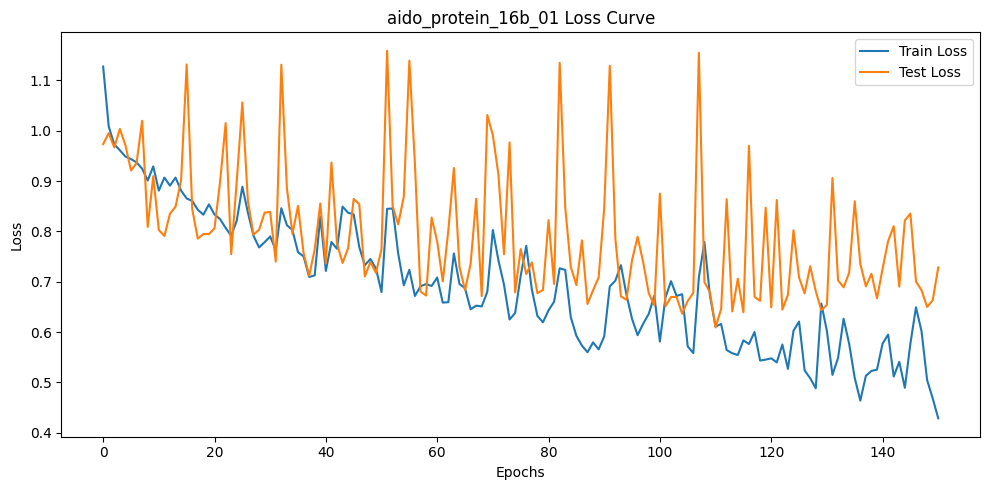

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-small_01.pth


2025-07-16 01:52:45,908 - INFO - Epoch 1, train loss: 1.1628
2025-07-16 01:52:54,229 - INFO - valid loss: 1.0254


=> Saving checkpoint


2025-07-16 01:53:17,848 - INFO - Epoch 2, train loss: 1.0111
2025-07-16 01:53:26,128 - INFO - valid loss: 1.0554
2025-07-16 01:53:43,497 - INFO - Epoch 3, train loss: 1.0026
2025-07-16 01:53:51,815 - INFO - valid loss: 0.9504


=> Saving checkpoint


2025-07-16 01:54:15,500 - INFO - Epoch 4, train loss: 0.9980
2025-07-16 01:54:23,765 - INFO - valid loss: 1.0106
2025-07-16 01:54:41,121 - INFO - Epoch 5, train loss: 0.9960
2025-07-16 01:54:49,445 - INFO - valid loss: 1.0073
2025-07-16 01:55:06,890 - INFO - Epoch 6, train loss: 0.9929
2025-07-16 01:55:15,204 - INFO - valid loss: 1.0054
2025-07-16 01:55:32,538 - INFO - Epoch 7, train loss: 1.0113
2025-07-16 01:55:40,834 - INFO - valid loss: 0.9749
2025-07-16 01:55:58,253 - INFO - Epoch 8, train loss: 1.0014
2025-07-16 01:56:06,608 - INFO - valid loss: 0.9438


=> Saving checkpoint


2025-07-16 01:56:30,306 - INFO - Epoch 9, train loss: 0.9945
2025-07-16 01:56:38,654 - INFO - valid loss: 1.1787
2025-07-16 01:56:56,125 - INFO - Epoch 10, train loss: 1.0242
2025-07-16 01:57:04,460 - INFO - valid loss: 0.9047


=> Saving checkpoint


2025-07-16 01:57:28,201 - INFO - Epoch 11, train loss: 1.0046
2025-07-16 01:57:36,599 - INFO - valid loss: 1.0525
2025-07-16 01:57:54,030 - INFO - Epoch 12, train loss: 0.9867
2025-07-16 01:58:02,446 - INFO - valid loss: 0.9559
2025-07-16 01:58:20,047 - INFO - Epoch 13, train loss: 0.9904
2025-07-16 01:58:28,361 - INFO - valid loss: 1.0564
2025-07-16 01:58:45,958 - INFO - Epoch 14, train loss: 0.9987
2025-07-16 01:58:54,262 - INFO - valid loss: 0.9978
2025-07-16 01:59:11,787 - INFO - Epoch 15, train loss: 0.9895
2025-07-16 01:59:20,090 - INFO - valid loss: 0.9790
2025-07-16 01:59:37,624 - INFO - Epoch 16, train loss: 0.9865
2025-07-16 01:59:45,964 - INFO - valid loss: 0.9790
2025-07-16 02:00:03,288 - INFO - Epoch 17, train loss: 0.9870
2025-07-16 02:00:11,650 - INFO - valid loss: 1.0032
2025-07-16 02:00:29,031 - INFO - Epoch 18, train loss: 0.9874
2025-07-16 02:00:37,361 - INFO - valid loss: 1.0045
2025-07-16 02:00:54,768 - INFO - Epoch 19, train loss: 0.9819
2025-07-16 02:01:03,076 - 

=> Saving checkpoint


2025-07-16 02:03:09,795 - INFO - Epoch 24, train loss: 1.0242
2025-07-16 02:03:18,161 - INFO - valid loss: 1.0526
2025-07-16 02:03:35,562 - INFO - Epoch 25, train loss: 0.9854
2025-07-16 02:03:43,877 - INFO - valid loss: 0.9520
2025-07-16 02:04:01,328 - INFO - Epoch 26, train loss: 0.9923
2025-07-16 02:04:09,650 - INFO - valid loss: 1.0187
2025-07-16 02:04:27,052 - INFO - Epoch 27, train loss: 1.0056
2025-07-16 02:04:35,311 - INFO - valid loss: 0.9749
2025-07-16 02:04:52,742 - INFO - Epoch 28, train loss: 0.9919
2025-07-16 02:05:01,105 - INFO - valid loss: 0.9845
2025-07-16 02:05:18,518 - INFO - Epoch 29, train loss: 0.9828
2025-07-16 02:05:26,835 - INFO - valid loss: 0.9908
2025-07-16 02:05:44,242 - INFO - Epoch 30, train loss: 0.9808
2025-07-16 02:05:52,568 - INFO - valid loss: 0.9499
2025-07-16 02:06:10,164 - INFO - Epoch 31, train loss: 0.9812
2025-07-16 02:06:18,508 - INFO - valid loss: 0.9864
2025-07-16 02:06:36,036 - INFO - Epoch 32, train loss: 0.9800
2025-07-16 02:06:44,490 - 

=> Saving checkpoint


2025-07-16 02:11:53,569 - INFO - Epoch 44, train loss: 0.9676
2025-07-16 02:12:01,896 - INFO - valid loss: 1.0443
2025-07-16 02:12:19,415 - INFO - Epoch 45, train loss: 0.9946
2025-07-16 02:12:27,838 - INFO - valid loss: 0.8943
2025-07-16 02:12:45,302 - INFO - Epoch 46, train loss: 0.9640
2025-07-16 02:12:53,695 - INFO - valid loss: 1.1575
2025-07-16 02:13:11,151 - INFO - Epoch 47, train loss: 1.0166
2025-07-16 02:13:19,497 - INFO - valid loss: 0.8958
2025-07-16 02:13:36,935 - INFO - Epoch 48, train loss: 0.9695
2025-07-16 02:13:45,315 - INFO - valid loss: 1.0481
2025-07-16 02:14:02,839 - INFO - Epoch 49, train loss: 0.9686
2025-07-16 02:14:11,247 - INFO - valid loss: 0.9600
2025-07-16 02:14:28,715 - INFO - Epoch 50, train loss: 0.9692
2025-07-16 02:14:37,030 - INFO - valid loss: 0.9867
2025-07-16 02:14:54,507 - INFO - Epoch 51, train loss: 0.9648
2025-07-16 02:15:02,856 - INFO - valid loss: 1.0009
2025-07-16 02:15:20,373 - INFO - Epoch 52, train loss: 0.9600
2025-07-16 02:15:28,728 - 

=> Saving checkpoint


2025-07-16 02:18:27,471 - INFO - Epoch 59, train loss: 0.9807
2025-07-16 02:18:35,725 - INFO - valid loss: 1.2080
2025-07-16 02:18:53,192 - INFO - Epoch 60, train loss: 1.0262
2025-07-16 02:19:01,579 - INFO - valid loss: 1.0364
2025-07-16 02:19:19,071 - INFO - Epoch 61, train loss: 0.9678
2025-07-16 02:19:27,438 - INFO - valid loss: 0.9590
2025-07-16 02:19:44,790 - INFO - Epoch 62, train loss: 0.9600
2025-07-16 02:19:53,218 - INFO - valid loss: 0.9934
2025-07-16 02:20:10,614 - INFO - Epoch 63, train loss: 0.9635
2025-07-16 02:20:18,908 - INFO - valid loss: 0.9225
2025-07-16 02:20:36,384 - INFO - Epoch 64, train loss: 0.9535
2025-07-16 02:20:44,685 - INFO - valid loss: 0.9905
2025-07-16 02:21:02,149 - INFO - Epoch 65, train loss: 0.9527
2025-07-16 02:21:10,515 - INFO - valid loss: 0.9508
2025-07-16 02:21:28,017 - INFO - Epoch 66, train loss: 0.9460
2025-07-16 02:21:36,349 - INFO - valid loss: 0.9336
2025-07-16 02:21:53,847 - INFO - Epoch 67, train loss: 0.9646
2025-07-16 02:22:02,200 - 

=> Saving checkpoint


2025-07-16 02:27:35,372 - INFO - Epoch 80, train loss: 0.9505
2025-07-16 02:27:43,675 - INFO - valid loss: 1.1706
2025-07-16 02:28:01,157 - INFO - Epoch 81, train loss: 0.9709
2025-07-16 02:28:09,372 - INFO - valid loss: 1.0539
2025-07-16 02:28:26,863 - INFO - Epoch 82, train loss: 0.9529
2025-07-16 02:28:35,238 - INFO - valid loss: 0.9034
2025-07-16 02:28:52,775 - INFO - Epoch 83, train loss: 0.9336
2025-07-16 02:29:01,080 - INFO - valid loss: 0.8944
2025-07-16 02:29:18,549 - INFO - Epoch 84, train loss: 0.9180
2025-07-16 02:29:26,896 - INFO - valid loss: 0.9069
2025-07-16 02:29:44,383 - INFO - Epoch 85, train loss: 0.9160
2025-07-16 02:29:52,713 - INFO - valid loss: 0.9396
2025-07-16 02:30:10,286 - INFO - Epoch 86, train loss: 0.9056
2025-07-16 02:30:18,601 - INFO - valid loss: 0.8478


=> Saving checkpoint


2025-07-16 02:30:42,330 - INFO - Epoch 87, train loss: 0.9232
2025-07-16 02:30:50,704 - INFO - valid loss: 0.9989
2025-07-16 02:31:08,138 - INFO - Epoch 88, train loss: 0.9324
2025-07-16 02:31:16,478 - INFO - valid loss: 1.0285
2025-07-16 02:31:33,990 - INFO - Epoch 89, train loss: 0.9374
2025-07-16 02:31:42,307 - INFO - valid loss: 1.0919
2025-07-16 02:31:59,858 - INFO - Epoch 90, train loss: 0.9126
2025-07-16 02:32:08,015 - INFO - valid loss: 0.8410


=> Saving checkpoint


2025-07-16 02:32:31,730 - INFO - Epoch 91, train loss: 0.9235
2025-07-16 02:32:40,091 - INFO - valid loss: 0.8480
2025-07-16 02:32:57,575 - INFO - Epoch 92, train loss: 0.9160
2025-07-16 02:33:05,956 - INFO - valid loss: 0.8590
2025-07-16 02:33:23,309 - INFO - Epoch 93, train loss: 0.9091
2025-07-16 02:33:31,722 - INFO - valid loss: 0.8903
2025-07-16 02:33:49,318 - INFO - Epoch 94, train loss: 0.9388
2025-07-16 02:33:57,659 - INFO - valid loss: 0.8600
2025-07-16 02:34:15,081 - INFO - Epoch 95, train loss: 1.0295
2025-07-16 02:34:23,451 - INFO - valid loss: 0.8534
2025-07-16 02:34:40,963 - INFO - Epoch 96, train loss: 0.9342
2025-07-16 02:34:49,264 - INFO - valid loss: 1.0145
2025-07-16 02:35:06,824 - INFO - Epoch 97, train loss: 0.9243
2025-07-16 02:35:15,112 - INFO - valid loss: 0.8948
2025-07-16 02:35:32,551 - INFO - Epoch 98, train loss: 0.9298
2025-07-16 02:35:40,816 - INFO - valid loss: 0.9313
2025-07-16 02:35:58,312 - INFO - Epoch 99, train loss: 0.9260
2025-07-16 02:36:06,602 - 

=> Saving checkpoint


2025-07-16 02:39:05,506 - INFO - Epoch 106, train loss: 0.9516
2025-07-16 02:39:13,863 - INFO - valid loss: 0.9847
2025-07-16 02:39:31,349 - INFO - Epoch 107, train loss: 0.9366
2025-07-16 02:39:39,711 - INFO - valid loss: 0.9265
2025-07-16 02:39:57,280 - INFO - Epoch 108, train loss: 0.8942
2025-07-16 02:40:05,592 - INFO - valid loss: 1.0423
2025-07-16 02:40:23,119 - INFO - Epoch 109, train loss: 0.9269
2025-07-16 02:40:31,440 - INFO - valid loss: 1.2767
2025-07-16 02:40:49,050 - INFO - Epoch 110, train loss: 0.9538
2025-07-16 02:40:57,434 - INFO - valid loss: 0.9257
2025-07-16 02:41:14,884 - INFO - Epoch 111, train loss: 0.9225
2025-07-16 02:41:23,179 - INFO - valid loss: 0.8475
2025-07-16 02:41:40,644 - INFO - Epoch 112, train loss: 0.9358
2025-07-16 02:41:49,084 - INFO - valid loss: 1.2082
2025-07-16 02:42:06,614 - INFO - Epoch 113, train loss: 0.9629
2025-07-16 02:42:15,063 - INFO - valid loss: 0.8555
2025-07-16 02:42:32,536 - INFO - Epoch 114, train loss: 0.9238
2025-07-16 02:42:

=> Saving checkpoint


2025-07-16 02:44:22,525 - INFO - Epoch 118, train loss: 0.9159
2025-07-16 02:44:30,922 - INFO - valid loss: 0.8530
2025-07-16 02:44:48,512 - INFO - Epoch 119, train loss: 0.9093
2025-07-16 02:44:56,916 - INFO - valid loss: 0.9112
2025-07-16 02:45:14,521 - INFO - Epoch 120, train loss: 0.8779
2025-07-16 02:45:22,908 - INFO - valid loss: 0.9043
2025-07-16 02:45:40,417 - INFO - Epoch 121, train loss: 0.8765
2025-07-16 02:45:48,801 - INFO - valid loss: 0.9288
2025-07-16 02:46:06,399 - INFO - Epoch 122, train loss: 0.8692
2025-07-16 02:46:14,846 - INFO - valid loss: 0.8635
2025-07-16 02:46:32,363 - INFO - Epoch 123, train loss: 0.8611
2025-07-16 02:46:40,727 - INFO - valid loss: 0.9703
2025-07-16 02:46:58,250 - INFO - Epoch 124, train loss: 0.8479
2025-07-16 02:47:06,584 - INFO - valid loss: 0.9890
2025-07-16 02:47:24,053 - INFO - Epoch 125, train loss: 0.8743
2025-07-16 02:47:32,537 - INFO - valid loss: 1.0816
2025-07-16 02:47:49,996 - INFO - Epoch 126, train loss: 0.8957
2025-07-16 02:47:

=> Saving checkpoint


2025-07-16 02:52:14,723 - INFO - Epoch 136, train loss: 0.8829
2025-07-16 02:52:23,061 - INFO - valid loss: 0.8987
2025-07-16 02:52:40,552 - INFO - Epoch 137, train loss: 0.9386
2025-07-16 02:52:48,990 - INFO - valid loss: 0.9351
2025-07-16 02:53:06,434 - INFO - Epoch 138, train loss: 0.8953
2025-07-16 02:53:14,791 - INFO - valid loss: 0.8856
2025-07-16 02:53:32,368 - INFO - Epoch 139, train loss: 0.8878
2025-07-16 02:53:40,703 - INFO - valid loss: 0.8935
2025-07-16 02:53:58,180 - INFO - Epoch 140, train loss: 0.8996
2025-07-16 02:54:06,580 - INFO - valid loss: 1.0123
2025-07-16 02:54:24,119 - INFO - Epoch 141, train loss: 0.8463
2025-07-16 02:54:32,481 - INFO - valid loss: 0.8622
2025-07-16 02:54:49,978 - INFO - Epoch 142, train loss: 0.8519
2025-07-16 02:54:58,428 - INFO - valid loss: 1.0797
2025-07-16 02:55:15,896 - INFO - Epoch 143, train loss: 0.8956
2025-07-16 02:55:24,211 - INFO - valid loss: 0.8281
2025-07-16 02:55:41,699 - INFO - Epoch 144, train loss: 0.8839
2025-07-16 02:55:

=> Saving checkpoint


2025-07-16 03:00:08,326 - INFO - Epoch 154, train loss: 0.9007
2025-07-16 03:00:16,764 - INFO - valid loss: 0.9707
2025-07-16 03:00:34,235 - INFO - Epoch 155, train loss: 0.8564
2025-07-16 03:00:42,642 - INFO - valid loss: 0.9489
2025-07-16 03:01:00,419 - INFO - Epoch 156, train loss: 0.8496
2025-07-16 03:01:08,834 - INFO - valid loss: 0.8188


=> Saving checkpoint


2025-07-16 03:01:32,611 - INFO - Epoch 157, train loss: 0.8484
2025-07-16 03:01:41,093 - INFO - valid loss: 1.1981
2025-07-16 03:01:58,645 - INFO - Epoch 158, train loss: 0.9172
2025-07-16 03:02:07,014 - INFO - valid loss: 1.0002
2025-07-16 03:02:24,478 - INFO - Epoch 159, train loss: 0.8349
2025-07-16 03:02:32,757 - INFO - valid loss: 0.8607
2025-07-16 03:02:50,309 - INFO - Epoch 160, train loss: 0.8392
2025-07-16 03:02:58,750 - INFO - valid loss: 0.8387
2025-07-16 03:03:16,175 - INFO - Epoch 161, train loss: 0.8149
2025-07-16 03:03:24,502 - INFO - valid loss: 0.8284
2025-07-16 03:03:41,876 - INFO - Epoch 162, train loss: 0.8928
2025-07-16 03:03:50,179 - INFO - valid loss: 0.8286
2025-07-16 03:04:07,693 - INFO - Epoch 163, train loss: 0.8428
2025-07-16 03:04:16,058 - INFO - valid loss: 0.8346
2025-07-16 03:04:33,606 - INFO - Epoch 164, train loss: 0.8746
2025-07-16 03:04:41,946 - INFO - valid loss: 0.8175


=> Saving checkpoint


2025-07-16 03:05:05,606 - INFO - Epoch 165, train loss: 0.9002
2025-07-16 03:05:13,894 - INFO - valid loss: 0.8297
2025-07-16 03:05:31,354 - INFO - Epoch 166, train loss: 0.8837
2025-07-16 03:05:39,776 - INFO - valid loss: 0.8958
2025-07-16 03:05:57,314 - INFO - Epoch 167, train loss: 0.8310
2025-07-16 03:06:05,696 - INFO - valid loss: 0.8294
2025-07-16 03:06:23,186 - INFO - Epoch 168, train loss: 0.8768
2025-07-16 03:06:31,631 - INFO - valid loss: 0.8561
2025-07-16 03:06:49,076 - INFO - Epoch 169, train loss: 0.8648
2025-07-16 03:06:57,450 - INFO - valid loss: 0.8379
2025-07-16 03:07:14,901 - INFO - Epoch 170, train loss: 0.8413
2025-07-16 03:07:23,238 - INFO - valid loss: 0.8363
2025-07-16 03:07:40,759 - INFO - Epoch 171, train loss: 0.8265
2025-07-16 03:07:49,074 - INFO - valid loss: 0.9232
2025-07-16 03:08:06,642 - INFO - Epoch 172, train loss: 0.9207
2025-07-16 03:08:14,983 - INFO - valid loss: 1.0515
2025-07-16 03:08:32,508 - INFO - Epoch 173, train loss: 1.0048
2025-07-16 03:08:

=> Training completed! Best loss is 0.8175 at epoch 164


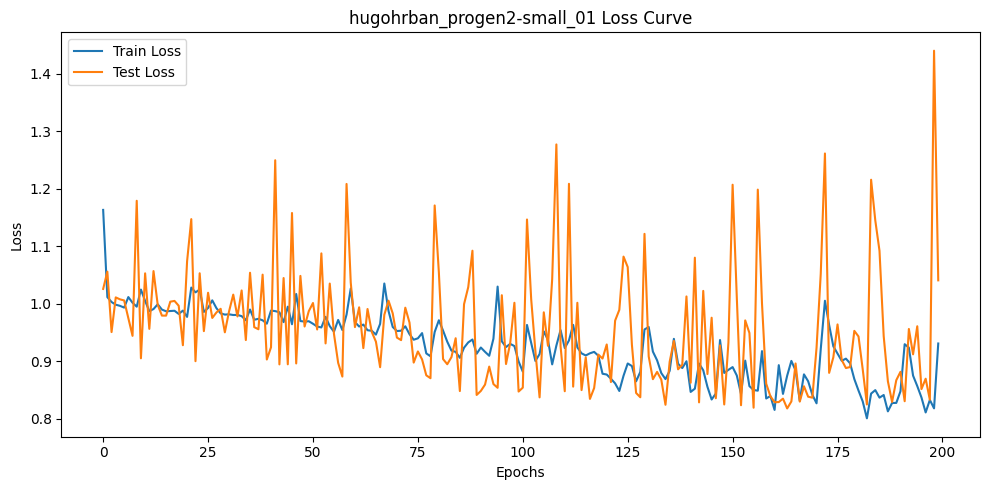

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-medium_01.pth


2025-07-16 03:21:20,324 - INFO - Epoch 1, train loss: 1.1915
2025-07-16 03:21:33,447 - INFO - valid loss: 0.9906


=> Saving checkpoint


2025-07-16 03:22:57,019 - INFO - Epoch 2, train loss: 1.0383
2025-07-16 03:23:10,153 - INFO - valid loss: 0.9757


=> Saving checkpoint


2025-07-16 03:24:34,594 - INFO - Epoch 3, train loss: 1.0025
2025-07-16 03:24:47,748 - INFO - valid loss: 1.0269
2025-07-16 03:25:41,111 - INFO - Epoch 4, train loss: 0.9907
2025-07-16 03:25:54,326 - INFO - valid loss: 0.9536


=> Saving checkpoint


2025-07-16 03:27:18,587 - INFO - Epoch 5, train loss: 0.9911
2025-07-16 03:27:31,697 - INFO - valid loss: 0.9494


=> Saving checkpoint


2025-07-16 03:28:56,070 - INFO - Epoch 6, train loss: 0.9906
2025-07-16 03:29:09,270 - INFO - valid loss: 0.9851
2025-07-16 03:30:02,595 - INFO - Epoch 7, train loss: 1.0001
2025-07-16 03:30:15,803 - INFO - valid loss: 0.9498
2025-07-16 03:31:09,203 - INFO - Epoch 8, train loss: 0.9924
2025-07-16 03:31:22,303 - INFO - valid loss: 0.9870
2025-07-16 03:32:15,681 - INFO - Epoch 9, train loss: 0.9863
2025-07-16 03:32:28,941 - INFO - valid loss: 0.9434


=> Saving checkpoint


2025-07-16 03:33:53,248 - INFO - Epoch 10, train loss: 0.9790
2025-07-16 03:34:06,488 - INFO - valid loss: 0.9740
2025-07-16 03:35:00,009 - INFO - Epoch 11, train loss: 0.9783
2025-07-16 03:35:13,243 - INFO - valid loss: 0.9503
2025-07-16 03:36:06,775 - INFO - Epoch 12, train loss: 0.9804
2025-07-16 03:36:19,961 - INFO - valid loss: 0.9223


=> Saving checkpoint


2025-07-16 03:37:44,371 - INFO - Epoch 13, train loss: 0.9767
2025-07-16 03:37:57,542 - INFO - valid loss: 0.8938


=> Saving checkpoint


2025-07-16 03:39:22,018 - INFO - Epoch 14, train loss: 0.9822
2025-07-16 03:39:35,127 - INFO - valid loss: 0.9758
2025-07-16 03:40:28,626 - INFO - Epoch 15, train loss: 0.9709
2025-07-16 03:40:41,767 - INFO - valid loss: 0.9563
2025-07-16 03:41:35,246 - INFO - Epoch 16, train loss: 0.9802
2025-07-16 03:41:48,521 - INFO - valid loss: 1.0498
2025-07-16 03:42:42,089 - INFO - Epoch 17, train loss: 0.9932
2025-07-16 03:42:55,218 - INFO - valid loss: 0.8596


=> Saving checkpoint


2025-07-16 03:44:19,734 - INFO - Epoch 18, train loss: 0.9581
2025-07-16 03:44:33,032 - INFO - valid loss: 1.0118
2025-07-16 03:45:26,391 - INFO - Epoch 19, train loss: 0.9611
2025-07-16 03:45:39,570 - INFO - valid loss: 0.8707
2025-07-16 03:46:33,016 - INFO - Epoch 20, train loss: 0.9857
2025-07-16 03:46:46,245 - INFO - valid loss: 0.9696
2025-07-16 03:47:39,833 - INFO - Epoch 21, train loss: 1.0085
2025-07-16 03:47:52,955 - INFO - valid loss: 1.0942
2025-07-16 03:48:46,606 - INFO - Epoch 22, train loss: 1.0097
2025-07-16 03:48:59,703 - INFO - valid loss: 0.8763
2025-07-16 03:49:53,172 - INFO - Epoch 23, train loss: 0.9726
2025-07-16 03:50:06,448 - INFO - valid loss: 1.0116
2025-07-16 03:50:59,981 - INFO - Epoch 24, train loss: 0.9659
2025-07-16 03:51:13,168 - INFO - valid loss: 0.9161
2025-07-16 03:52:06,607 - INFO - Epoch 25, train loss: 0.9602
2025-07-16 03:52:19,725 - INFO - valid loss: 0.9248
2025-07-16 03:53:13,285 - INFO - Epoch 26, train loss: 0.9595
2025-07-16 03:53:26,520 - 

=> Saving checkpoint


2025-07-16 03:58:11,179 - INFO - Epoch 30, train loss: 0.9559
2025-07-16 03:58:24,500 - INFO - valid loss: 0.9181
2025-07-16 03:59:18,317 - INFO - Epoch 31, train loss: 0.9471
2025-07-16 03:59:31,516 - INFO - valid loss: 0.8037


=> Saving checkpoint


2025-07-16 04:00:55,964 - INFO - Epoch 32, train loss: 0.9550
2025-07-16 04:01:09,145 - INFO - valid loss: 0.9834
2025-07-16 04:02:02,635 - INFO - Epoch 33, train loss: 0.9650
2025-07-16 04:02:15,799 - INFO - valid loss: 1.1246
2025-07-16 04:03:09,299 - INFO - Epoch 34, train loss: 0.9630
2025-07-16 04:03:22,472 - INFO - valid loss: 0.9188
2025-07-16 04:04:15,907 - INFO - Epoch 35, train loss: 0.9412
2025-07-16 04:04:29,040 - INFO - valid loss: 0.8471
2025-07-16 04:05:22,561 - INFO - Epoch 36, train loss: 0.9429
2025-07-16 04:05:35,716 - INFO - valid loss: 1.1386
2025-07-16 04:06:29,098 - INFO - Epoch 37, train loss: 1.0376
2025-07-16 04:06:42,308 - INFO - valid loss: 1.0524
2025-07-16 04:07:35,656 - INFO - Epoch 38, train loss: 0.9933
2025-07-16 04:07:48,922 - INFO - valid loss: 0.8662
2025-07-16 04:08:42,347 - INFO - Epoch 39, train loss: 0.9752
2025-07-16 04:08:55,519 - INFO - valid loss: 0.9266
2025-07-16 04:09:48,986 - INFO - Epoch 40, train loss: 0.9651
2025-07-16 04:10:02,101 - 

=> Saving checkpoint


2025-07-16 04:28:14,941 - INFO - Epoch 56, train loss: 0.9444
2025-07-16 04:28:28,080 - INFO - valid loss: 0.9300
2025-07-16 04:29:21,493 - INFO - Epoch 57, train loss: 0.9249
2025-07-16 04:29:34,684 - INFO - valid loss: 0.8861
2025-07-16 04:30:28,193 - INFO - Epoch 58, train loss: 0.9209
2025-07-16 04:30:41,433 - INFO - valid loss: 0.9040
2025-07-16 04:31:34,894 - INFO - Epoch 59, train loss: 0.9445
2025-07-16 04:31:48,063 - INFO - valid loss: 0.8407
2025-07-16 04:32:41,584 - INFO - Epoch 60, train loss: 0.9267
2025-07-16 04:32:54,735 - INFO - valid loss: 0.9900
2025-07-16 04:33:48,206 - INFO - Epoch 61, train loss: 0.9442
2025-07-16 04:34:01,732 - INFO - valid loss: 0.8650
2025-07-16 04:34:55,225 - INFO - Epoch 62, train loss: 0.9316
2025-07-16 04:35:08,401 - INFO - valid loss: 0.9343
2025-07-16 04:36:01,898 - INFO - Epoch 63, train loss: 0.9623
2025-07-16 04:36:15,075 - INFO - valid loss: 0.8014
2025-07-16 04:37:08,583 - INFO - Epoch 64, train loss: 0.9241
2025-07-16 04:37:21,721 - 

early stop at epoch 95
=> Training completed! Best loss is 0.7655 at epoch 55


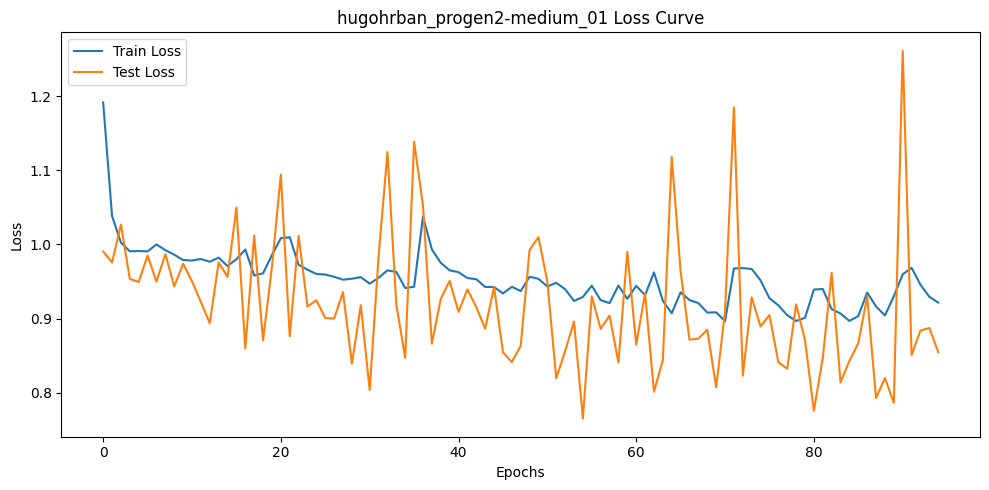

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-large_01.pth


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-07-16 05:14:37,276 - INFO - Epoch 1, train loss: 1.1655
2025-07-16 05:15:02,981 - INFO - valid loss: 0.9135


=> Saving checkpoint


2025-07-16 05:19:26,379 - INFO - Epoch 2, train loss: 0.9737
2025-07-16 05:19:52,006 - INFO - valid loss: 0.9228
2025-07-16 05:22:24,838 - INFO - Epoch 3, train loss: 0.9374
2025-07-16 05:22:50,461 - INFO - valid loss: 0.9920
2025-07-16 05:25:23,242 - INFO - Epoch 4, train loss: 0.9208
2025-07-16 05:25:48,914 - INFO - valid loss: 1.0121
2025-07-16 05:28:21,755 - INFO - Epoch 5, train loss: 0.9036
2025-07-16 05:28:47,393 - INFO - valid loss: 0.8437


=> Saving checkpoint


2025-07-16 05:33:07,948 - INFO - Epoch 6, train loss: 0.8734
2025-07-16 05:33:33,656 - INFO - valid loss: 0.8168


=> Saving checkpoint


2025-07-16 05:37:55,698 - INFO - Epoch 7, train loss: 0.8592
2025-07-16 05:38:21,339 - INFO - valid loss: 0.7835


=> Saving checkpoint


2025-07-16 05:42:43,888 - INFO - Epoch 8, train loss: 0.8256
2025-07-16 05:43:09,546 - INFO - valid loss: 0.7534


=> Saving checkpoint


2025-07-16 05:47:32,193 - INFO - Epoch 9, train loss: 0.8014
2025-07-16 05:47:57,931 - INFO - valid loss: 0.7117


=> Saving checkpoint


2025-07-16 05:52:18,957 - INFO - Epoch 10, train loss: 0.7809
2025-07-16 05:52:44,622 - INFO - valid loss: 0.7984
2025-07-16 05:55:17,426 - INFO - Epoch 11, train loss: 0.7498
2025-07-16 05:55:43,220 - INFO - valid loss: 0.8291
2025-07-16 05:58:16,124 - INFO - Epoch 12, train loss: 0.7244
2025-07-16 05:58:41,932 - INFO - valid loss: 0.6425


=> Saving checkpoint


2025-07-16 06:03:00,464 - INFO - Epoch 13, train loss: 0.7327
2025-07-16 06:03:26,130 - INFO - valid loss: 0.8674
2025-07-16 06:05:59,010 - INFO - Epoch 14, train loss: 0.6796
2025-07-16 06:06:24,639 - INFO - valid loss: 1.3393
2025-07-16 06:08:57,358 - INFO - Epoch 15, train loss: 0.8994
2025-07-16 06:09:23,084 - INFO - valid loss: 0.7838
2025-07-16 06:11:55,947 - INFO - Epoch 16, train loss: 0.8010
2025-07-16 06:12:21,607 - INFO - valid loss: 0.8793
2025-07-16 06:14:54,395 - INFO - Epoch 17, train loss: 0.7551
2025-07-16 06:15:20,144 - INFO - valid loss: 0.7932
2025-07-16 06:17:53,040 - INFO - Epoch 18, train loss: 0.6936
2025-07-16 06:18:18,649 - INFO - valid loss: 0.6732
2025-07-16 06:20:51,465 - INFO - Epoch 19, train loss: 0.6667
2025-07-16 06:21:17,180 - INFO - valid loss: 0.7276
2025-07-16 06:23:50,748 - INFO - Epoch 20, train loss: 0.6318
2025-07-16 06:24:16,349 - INFO - valid loss: 0.7477
2025-07-16 06:26:49,217 - INFO - Epoch 21, train loss: 0.5987
2025-07-16 06:27:14,964 - 

=> Saving checkpoint


2025-07-16 06:49:28,598 - INFO - Epoch 28, train loss: 0.5580
2025-07-16 06:49:54,161 - INFO - valid loss: 0.6544
2025-07-16 06:52:26,878 - INFO - Epoch 29, train loss: 0.5685
2025-07-16 06:52:52,478 - INFO - valid loss: 0.5811


=> Saving checkpoint


2025-07-16 06:57:11,279 - INFO - Epoch 30, train loss: 0.5794
2025-07-16 06:57:36,939 - INFO - valid loss: 0.7614
2025-07-16 07:00:09,431 - INFO - Epoch 31, train loss: 0.5861
2025-07-16 07:00:35,037 - INFO - valid loss: 1.2888
2025-07-16 07:03:07,603 - INFO - Epoch 32, train loss: 0.5861
2025-07-16 07:03:33,386 - INFO - valid loss: 0.6590
2025-07-16 07:06:06,307 - INFO - Epoch 33, train loss: 0.5044
2025-07-16 07:06:32,008 - INFO - valid loss: 0.7949
2025-07-16 07:09:04,776 - INFO - Epoch 34, train loss: 0.4281
2025-07-16 07:09:30,551 - INFO - valid loss: 1.0891
2025-07-16 07:12:03,310 - INFO - Epoch 35, train loss: 0.4759
2025-07-16 07:12:28,931 - INFO - valid loss: 0.6983
2025-07-16 07:15:01,620 - INFO - Epoch 36, train loss: 0.4247
2025-07-16 07:15:27,243 - INFO - valid loss: 0.6618
2025-07-16 07:17:59,870 - INFO - Epoch 37, train loss: 0.5939
2025-07-16 07:18:25,527 - INFO - valid loss: 0.7564
2025-07-16 07:20:58,181 - INFO - Epoch 38, train loss: 0.5766
2025-07-16 07:21:23,993 - 

=> Saving checkpoint


2025-07-16 07:49:33,531 - INFO - Epoch 47, train loss: 0.3679
2025-07-16 07:49:59,242 - INFO - valid loss: 0.6160
2025-07-16 07:52:31,805 - INFO - Epoch 48, train loss: 0.3573
2025-07-16 07:52:57,388 - INFO - valid loss: 0.6331
2025-07-16 07:55:30,034 - INFO - Epoch 49, train loss: 0.3663
2025-07-16 07:55:55,698 - INFO - valid loss: 0.6028
2025-07-16 07:58:28,376 - INFO - Epoch 50, train loss: 0.3981
2025-07-16 07:58:54,047 - INFO - valid loss: 0.6431
2025-07-16 08:01:26,688 - INFO - Epoch 51, train loss: 0.4495
2025-07-16 08:01:52,290 - INFO - valid loss: 0.5734


=> Saving checkpoint


2025-07-16 08:06:12,900 - INFO - Epoch 52, train loss: 0.3716
2025-07-16 08:06:38,555 - INFO - valid loss: 0.7403
2025-07-16 08:09:11,132 - INFO - Epoch 53, train loss: 0.2953
2025-07-16 08:09:36,814 - INFO - valid loss: 0.6787
2025-07-16 08:12:09,513 - INFO - Epoch 54, train loss: 0.2594
2025-07-16 08:12:35,217 - INFO - valid loss: 0.5880
2025-07-16 08:15:08,112 - INFO - Epoch 55, train loss: 0.2837
2025-07-16 08:15:34,562 - INFO - valid loss: 0.7510
2025-07-16 08:18:07,479 - INFO - Epoch 56, train loss: 0.2737
2025-07-16 08:18:33,157 - INFO - valid loss: 0.6317
2025-07-16 08:21:05,864 - INFO - Epoch 57, train loss: 0.2339
2025-07-16 08:21:31,645 - INFO - valid loss: 0.6454
2025-07-16 08:24:04,268 - INFO - Epoch 58, train loss: 0.2503
2025-07-16 08:24:29,872 - INFO - valid loss: 0.7060
2025-07-16 08:27:02,535 - INFO - Epoch 59, train loss: 0.2884
2025-07-16 08:27:28,153 - INFO - valid loss: 0.6091
2025-07-16 08:30:00,861 - INFO - Epoch 60, train loss: 0.2508
2025-07-16 08:30:26,706 - 

=> Saving checkpoint


2025-07-16 08:34:50,415 - INFO - Epoch 61, train loss: 0.3162
2025-07-16 08:35:16,074 - INFO - valid loss: 0.6331
2025-07-16 08:37:48,824 - INFO - Epoch 62, train loss: 0.2414
2025-07-16 08:38:14,466 - INFO - valid loss: 0.6402
2025-07-16 08:40:47,192 - INFO - Epoch 63, train loss: 0.1964
2025-07-16 08:41:12,784 - INFO - valid loss: 0.6443
2025-07-16 08:43:45,538 - INFO - Epoch 64, train loss: 0.1818
2025-07-16 08:44:11,182 - INFO - valid loss: 0.7185
2025-07-16 08:46:43,935 - INFO - Epoch 65, train loss: 0.1983
2025-07-16 08:47:09,544 - INFO - valid loss: 0.6892
2025-07-16 08:49:42,303 - INFO - Epoch 66, train loss: 0.1829
2025-07-16 08:50:07,931 - INFO - valid loss: 0.6030
2025-07-16 08:52:40,562 - INFO - Epoch 67, train loss: 0.2375
2025-07-16 08:53:06,331 - INFO - valid loss: 0.8092
2025-07-16 08:55:39,027 - INFO - Epoch 68, train loss: 0.2287
2025-07-16 08:56:04,782 - INFO - valid loss: 0.6380
2025-07-16 08:58:37,499 - INFO - Epoch 69, train loss: 0.2614
2025-07-16 08:59:03,202 - 

early stop at epoch 100
=> Training completed! Best loss is 0.5590 at epoch 60


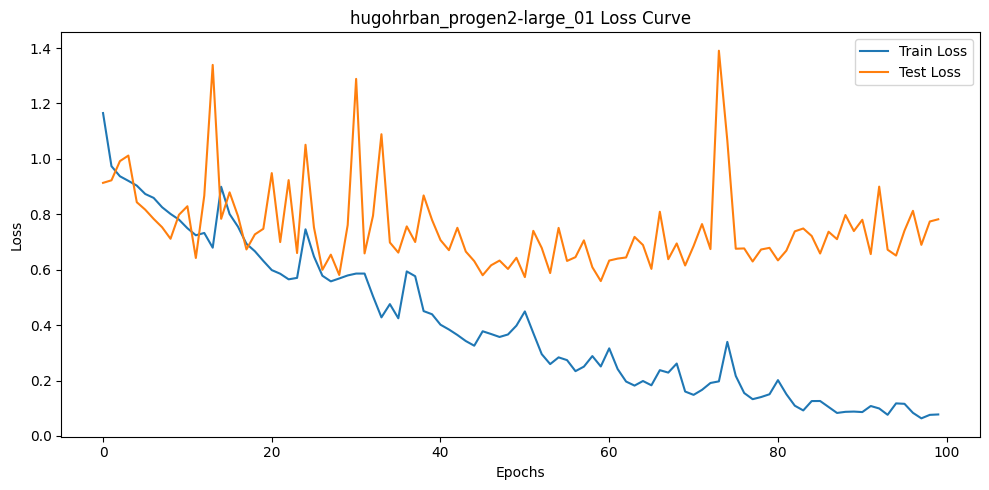

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-base_01.pth


2025-07-16 10:32:17,540 - INFO - Epoch 1, train loss: 1.1697
2025-07-16 10:32:30,780 - INFO - valid loss: 0.9628


=> Saving checkpoint


2025-07-16 10:34:02,547 - INFO - Epoch 2, train loss: 1.0009
2025-07-16 10:34:15,840 - INFO - valid loss: 1.0140
2025-07-16 10:35:08,944 - INFO - Epoch 3, train loss: 0.9969
2025-07-16 10:35:22,315 - INFO - valid loss: 1.0372
2025-07-16 10:36:15,480 - INFO - Epoch 4, train loss: 0.9828
2025-07-16 10:36:29,085 - INFO - valid loss: 0.9916
2025-07-16 10:37:22,287 - INFO - Epoch 5, train loss: 0.9746
2025-07-16 10:37:35,624 - INFO - valid loss: 1.0452
2025-07-16 10:38:28,885 - INFO - Epoch 6, train loss: 0.9601
2025-07-16 10:38:42,202 - INFO - valid loss: 0.9934
2025-07-16 10:39:35,429 - INFO - Epoch 7, train loss: 0.9559
2025-07-16 10:39:48,722 - INFO - valid loss: 1.0072
2025-07-16 10:40:42,008 - INFO - Epoch 8, train loss: 0.9419
2025-07-16 10:40:55,358 - INFO - valid loss: 1.0743
2025-07-16 10:41:48,714 - INFO - Epoch 9, train loss: 0.9787
2025-07-16 10:42:02,024 - INFO - valid loss: 1.2846
2025-07-16 10:42:55,383 - INFO - Epoch 10, train loss: 0.9933
2025-07-16 10:43:08,684 - INFO - v

=> Saving checkpoint


2025-07-16 10:47:52,872 - INFO - Epoch 14, train loss: 0.9205
2025-07-16 10:48:06,140 - INFO - valid loss: 1.0763
2025-07-16 10:48:59,388 - INFO - Epoch 15, train loss: 0.9111
2025-07-16 10:49:12,659 - INFO - valid loss: 1.0532
2025-07-16 10:50:05,873 - INFO - Epoch 16, train loss: 0.9152
2025-07-16 10:50:19,028 - INFO - valid loss: 1.0225
2025-07-16 10:51:12,233 - INFO - Epoch 17, train loss: 0.9029
2025-07-16 10:51:25,497 - INFO - valid loss: 0.9562
2025-07-16 10:52:18,659 - INFO - Epoch 18, train loss: 0.8927
2025-07-16 10:52:31,917 - INFO - valid loss: 1.1534
2025-07-16 10:53:25,199 - INFO - Epoch 19, train loss: 0.9106
2025-07-16 10:53:38,374 - INFO - valid loss: 0.9934
2025-07-16 10:54:31,612 - INFO - Epoch 20, train loss: 0.8994
2025-07-16 10:54:44,830 - INFO - valid loss: 1.0506
2025-07-16 10:55:38,125 - INFO - Epoch 21, train loss: 0.9138
2025-07-16 10:55:51,446 - INFO - valid loss: 1.2932
2025-07-16 10:56:44,573 - INFO - Epoch 22, train loss: 0.9125
2025-07-16 10:56:57,856 - 

=> Saving checkpoint


2025-07-16 10:58:22,155 - INFO - Epoch 23, train loss: 0.8886
2025-07-16 10:58:35,359 - INFO - valid loss: 0.9798
2025-07-16 10:59:28,513 - INFO - Epoch 24, train loss: 0.8854
2025-07-16 10:59:41,721 - INFO - valid loss: 0.9373


=> Saving checkpoint


2025-07-16 11:01:05,953 - INFO - Epoch 25, train loss: 0.8768
2025-07-16 11:01:19,135 - INFO - valid loss: 1.0129
2025-07-16 11:02:12,275 - INFO - Epoch 26, train loss: 0.8784
2025-07-16 11:02:25,481 - INFO - valid loss: 0.9030


=> Saving checkpoint


2025-07-16 11:03:49,694 - INFO - Epoch 27, train loss: 0.9615
2025-07-16 11:04:03,031 - INFO - valid loss: 0.9627
2025-07-16 11:04:56,219 - INFO - Epoch 28, train loss: 0.8918
2025-07-16 11:05:09,508 - INFO - valid loss: 0.9837
2025-07-16 11:06:02,721 - INFO - Epoch 29, train loss: 0.8946
2025-07-16 11:06:16,023 - INFO - valid loss: 0.9550
2025-07-16 11:07:09,245 - INFO - Epoch 30, train loss: 0.8812
2025-07-16 11:07:22,444 - INFO - valid loss: 0.9394
2025-07-16 11:08:15,627 - INFO - Epoch 31, train loss: 0.8764
2025-07-16 11:08:28,911 - INFO - valid loss: 1.0195
2025-07-16 11:09:22,052 - INFO - Epoch 32, train loss: 0.8764
2025-07-16 11:09:35,316 - INFO - valid loss: 1.1445
2025-07-16 11:10:28,545 - INFO - Epoch 33, train loss: 0.9064
2025-07-16 11:10:41,886 - INFO - valid loss: 1.0803
2025-07-16 11:11:35,040 - INFO - Epoch 34, train loss: 0.9378
2025-07-16 11:11:48,317 - INFO - valid loss: 0.9393
2025-07-16 11:12:41,532 - INFO - Epoch 35, train loss: 0.9038
2025-07-16 11:12:55,280 - 

=> Saving checkpoint


2025-07-16 11:14:19,569 - INFO - Epoch 36, train loss: 0.9091
2025-07-16 11:14:32,826 - INFO - valid loss: 1.0443
2025-07-16 11:15:25,994 - INFO - Epoch 37, train loss: 0.8888
2025-07-16 11:15:39,327 - INFO - valid loss: 1.0162
2025-07-16 11:16:32,529 - INFO - Epoch 38, train loss: 0.8980
2025-07-16 11:16:45,786 - INFO - valid loss: 1.0955
2025-07-16 11:17:39,027 - INFO - Epoch 39, train loss: 0.8672
2025-07-16 11:17:52,277 - INFO - valid loss: 0.9485
2025-07-16 11:18:45,520 - INFO - Epoch 40, train loss: 0.9090
2025-07-16 11:18:58,775 - INFO - valid loss: 0.9763
2025-07-16 11:19:52,051 - INFO - Epoch 41, train loss: 0.8879
2025-07-16 11:20:05,316 - INFO - valid loss: 1.0174
2025-07-16 11:20:58,482 - INFO - Epoch 42, train loss: 0.8778
2025-07-16 11:21:11,786 - INFO - valid loss: 1.0871
2025-07-16 11:22:04,975 - INFO - Epoch 43, train loss: 0.8593
2025-07-16 11:22:18,353 - INFO - valid loss: 0.8839


=> Saving checkpoint


2025-07-16 11:23:42,730 - INFO - Epoch 44, train loss: 0.8658
2025-07-16 11:23:55,959 - INFO - valid loss: 0.9609
2025-07-16 11:24:49,253 - INFO - Epoch 45, train loss: 0.9281
2025-07-16 11:25:02,537 - INFO - valid loss: 0.9395
2025-07-16 11:25:55,829 - INFO - Epoch 46, train loss: 0.8732
2025-07-16 11:26:09,154 - INFO - valid loss: 0.9368
2025-07-16 11:27:02,420 - INFO - Epoch 47, train loss: 0.8623
2025-07-16 11:27:15,743 - INFO - valid loss: 0.9071
2025-07-16 11:28:08,874 - INFO - Epoch 48, train loss: 0.8807
2025-07-16 11:28:22,216 - INFO - valid loss: 1.0280
2025-07-16 11:29:15,365 - INFO - Epoch 49, train loss: 0.8851
2025-07-16 11:29:28,605 - INFO - valid loss: 1.0157
2025-07-16 11:30:21,872 - INFO - Epoch 50, train loss: 0.8507
2025-07-16 11:30:35,214 - INFO - valid loss: 0.8621


=> Saving checkpoint


2025-07-16 11:31:59,663 - INFO - Epoch 51, train loss: 0.8843
2025-07-16 11:32:12,958 - INFO - valid loss: 0.8883
2025-07-16 11:33:06,149 - INFO - Epoch 52, train loss: 0.8621
2025-07-16 11:33:20,215 - INFO - valid loss: 0.9765
2025-07-16 11:34:13,434 - INFO - Epoch 53, train loss: 0.8563
2025-07-16 11:34:26,758 - INFO - valid loss: 0.8912
2025-07-16 11:35:19,982 - INFO - Epoch 54, train loss: 0.8449
2025-07-16 11:35:33,237 - INFO - valid loss: 0.9416
2025-07-16 11:36:26,378 - INFO - Epoch 55, train loss: 0.8383
2025-07-16 11:36:39,579 - INFO - valid loss: 1.0002
2025-07-16 11:37:32,698 - INFO - Epoch 56, train loss: 0.8419
2025-07-16 11:37:45,989 - INFO - valid loss: 0.9665
2025-07-16 11:38:39,379 - INFO - Epoch 57, train loss: 0.8460
2025-07-16 11:38:52,651 - INFO - valid loss: 1.1247
2025-07-16 11:39:46,086 - INFO - Epoch 58, train loss: 0.8461
2025-07-16 11:39:59,290 - INFO - valid loss: 1.0038
2025-07-16 11:40:52,480 - INFO - Epoch 59, train loss: 0.8464
2025-07-16 11:41:05,774 - 

=> Saving checkpoint


2025-07-16 11:43:36,440 - INFO - Epoch 61, train loss: 0.8260
2025-07-16 11:43:49,898 - INFO - valid loss: 0.8986
2025-07-16 11:44:43,166 - INFO - Epoch 62, train loss: 0.8335
2025-07-16 11:44:56,474 - INFO - valid loss: 0.8996
2025-07-16 11:45:49,751 - INFO - Epoch 63, train loss: 0.8174
2025-07-16 11:46:03,433 - INFO - valid loss: 1.0624
2025-07-16 11:46:56,715 - INFO - Epoch 64, train loss: 0.8123
2025-07-16 11:47:09,947 - INFO - valid loss: 0.8467


=> Saving checkpoint


2025-07-16 11:48:34,194 - INFO - Epoch 65, train loss: 0.8116
2025-07-16 11:48:47,512 - INFO - valid loss: 1.0261
2025-07-16 11:49:40,701 - INFO - Epoch 66, train loss: 0.8312
2025-07-16 11:49:54,162 - INFO - valid loss: 0.9828
2025-07-16 11:50:47,482 - INFO - Epoch 67, train loss: 0.8573
2025-07-16 11:51:00,752 - INFO - valid loss: 0.9171
2025-07-16 11:51:53,961 - INFO - Epoch 68, train loss: 0.9185
2025-07-16 11:52:07,389 - INFO - valid loss: 0.8516
2025-07-16 11:53:00,766 - INFO - Epoch 69, train loss: 0.9044
2025-07-16 11:53:14,152 - INFO - valid loss: 0.8462


=> Saving checkpoint


2025-07-16 11:54:38,328 - INFO - Epoch 70, train loss: 0.8774
2025-07-16 11:54:51,711 - INFO - valid loss: 0.9627
2025-07-16 11:55:44,866 - INFO - Epoch 71, train loss: 0.8450
2025-07-16 11:55:58,231 - INFO - valid loss: 0.8777
2025-07-16 11:56:51,460 - INFO - Epoch 72, train loss: 0.8264
2025-07-16 11:57:04,724 - INFO - valid loss: 0.8645
2025-07-16 11:57:57,949 - INFO - Epoch 73, train loss: 0.8148
2025-07-16 11:58:11,152 - INFO - valid loss: 0.8191


=> Saving checkpoint


2025-07-16 11:59:35,449 - INFO - Epoch 74, train loss: 0.8303
2025-07-16 11:59:48,828 - INFO - valid loss: 0.8119


=> Saving checkpoint


2025-07-16 12:01:13,153 - INFO - Epoch 75, train loss: 0.8309
2025-07-16 12:01:26,383 - INFO - valid loss: 0.8688
2025-07-16 12:02:19,612 - INFO - Epoch 76, train loss: 0.8126
2025-07-16 12:02:32,832 - INFO - valid loss: 0.9534
2025-07-16 12:03:25,962 - INFO - Epoch 77, train loss: 0.8193
2025-07-16 12:03:39,348 - INFO - valid loss: 1.3170
2025-07-16 12:04:32,601 - INFO - Epoch 78, train loss: 0.8453
2025-07-16 12:04:45,960 - INFO - valid loss: 0.9548
2025-07-16 12:05:39,215 - INFO - Epoch 79, train loss: 0.7991
2025-07-16 12:05:52,621 - INFO - valid loss: 0.8437
2025-07-16 12:06:45,782 - INFO - Epoch 80, train loss: 0.8078
2025-07-16 12:06:59,096 - INFO - valid loss: 1.0123
2025-07-16 12:07:52,373 - INFO - Epoch 81, train loss: 0.8525
2025-07-16 12:08:05,649 - INFO - valid loss: 0.8941
2025-07-16 12:08:58,922 - INFO - Epoch 82, train loss: 0.8216
2025-07-16 12:09:12,136 - INFO - valid loss: 1.1059
2025-07-16 12:10:05,196 - INFO - Epoch 83, train loss: 0.8273
2025-07-16 12:10:18,612 - 

=> Saving checkpoint


2025-07-16 12:30:41,686 - INFO - Epoch 101, train loss: 0.7952
2025-07-16 12:30:54,929 - INFO - valid loss: 0.8664
2025-07-16 12:31:48,153 - INFO - Epoch 102, train loss: 0.7614
2025-07-16 12:32:01,514 - INFO - valid loss: 0.8537
2025-07-16 12:32:54,768 - INFO - Epoch 103, train loss: 0.8017
2025-07-16 12:33:08,016 - INFO - valid loss: 1.3165
2025-07-16 12:34:01,246 - INFO - Epoch 104, train loss: 0.8922
2025-07-16 12:34:14,577 - INFO - valid loss: 1.0340
2025-07-16 12:35:07,771 - INFO - Epoch 105, train loss: 0.8457
2025-07-16 12:35:21,012 - INFO - valid loss: 0.9359
2025-07-16 12:36:14,324 - INFO - Epoch 106, train loss: 0.8156
2025-07-16 12:36:27,678 - INFO - valid loss: 0.8547
2025-07-16 12:37:20,988 - INFO - Epoch 107, train loss: 0.7843
2025-07-16 12:37:34,314 - INFO - valid loss: 0.8215
2025-07-16 12:38:27,525 - INFO - Epoch 108, train loss: 0.8345
2025-07-16 12:38:40,852 - INFO - valid loss: 0.9519
2025-07-16 12:39:34,221 - INFO - Epoch 109, train loss: 0.8385
2025-07-16 12:39:

=> Saving checkpoint


2025-07-16 13:05:41,853 - INFO - Epoch 132, train loss: 0.7192
2025-07-16 13:05:55,152 - INFO - valid loss: 0.8112
2025-07-16 13:06:48,240 - INFO - Epoch 133, train loss: 0.7577
2025-07-16 13:07:01,501 - INFO - valid loss: 0.7675
2025-07-16 13:07:54,620 - INFO - Epoch 134, train loss: 0.7655
2025-07-16 13:08:07,878 - INFO - valid loss: 0.8085
2025-07-16 13:09:01,128 - INFO - Epoch 135, train loss: 0.7552
2025-07-16 13:09:14,394 - INFO - valid loss: 0.8063
2025-07-16 13:10:07,709 - INFO - Epoch 136, train loss: 0.7747
2025-07-16 13:10:21,025 - INFO - valid loss: 0.8285
2025-07-16 13:11:14,213 - INFO - Epoch 137, train loss: 0.7628
2025-07-16 13:11:27,440 - INFO - valid loss: 0.9072
2025-07-16 13:12:20,728 - INFO - Epoch 138, train loss: 0.7141
2025-07-16 13:12:34,079 - INFO - valid loss: 0.7805
2025-07-16 13:13:27,293 - INFO - Epoch 139, train loss: 0.7150
2025-07-16 13:13:40,618 - INFO - valid loss: 1.0733
2025-07-16 13:14:33,790 - INFO - Epoch 140, train loss: 0.7124
2025-07-16 13:14:

=> Saving checkpoint


2025-07-16 13:27:19,175 - INFO - Epoch 151, train loss: 0.7065
2025-07-16 13:27:32,416 - INFO - valid loss: 1.0201
2025-07-16 13:28:25,590 - INFO - Epoch 152, train loss: 0.7464
2025-07-16 13:28:38,824 - INFO - valid loss: 0.7718
2025-07-16 13:29:32,030 - INFO - Epoch 153, train loss: 0.7466
2025-07-16 13:29:45,296 - INFO - valid loss: 0.9446
2025-07-16 13:30:38,730 - INFO - Epoch 154, train loss: 0.7080
2025-07-16 13:30:51,960 - INFO - valid loss: 0.8169
2025-07-16 13:31:45,234 - INFO - Epoch 155, train loss: 0.7012
2025-07-16 13:31:58,622 - INFO - valid loss: 0.9992
2025-07-16 13:32:51,872 - INFO - Epoch 156, train loss: 0.7031
2025-07-16 13:33:05,268 - INFO - valid loss: 0.7409


=> Saving checkpoint


2025-07-16 13:34:29,721 - INFO - Epoch 157, train loss: 0.7763
2025-07-16 13:34:43,197 - INFO - valid loss: 1.1229
2025-07-16 13:35:36,387 - INFO - Epoch 158, train loss: 0.8798
2025-07-16 13:35:49,925 - INFO - valid loss: 0.8343
2025-07-16 13:36:43,408 - INFO - Epoch 159, train loss: 0.7982
2025-07-16 13:36:56,855 - INFO - valid loss: 0.9423
2025-07-16 13:37:50,175 - INFO - Epoch 160, train loss: 0.7387
2025-07-16 13:38:03,566 - INFO - valid loss: 0.8763
2025-07-16 13:38:56,952 - INFO - Epoch 161, train loss: 0.6996
2025-07-16 13:39:10,323 - INFO - valid loss: 0.8202
2025-07-16 13:40:03,729 - INFO - Epoch 162, train loss: 0.6716
2025-07-16 13:40:17,157 - INFO - valid loss: 0.9713
2025-07-16 13:41:10,540 - INFO - Epoch 163, train loss: 0.6692
2025-07-16 13:41:23,950 - INFO - valid loss: 0.7835
2025-07-16 13:42:17,278 - INFO - Epoch 164, train loss: 0.6967
2025-07-16 13:42:30,662 - INFO - valid loss: 0.9663
2025-07-16 13:43:24,118 - INFO - Epoch 165, train loss: 0.6568
2025-07-16 13:43:

early stop at epoch 196
=> Training completed! Best loss is 0.7409 at epoch 156


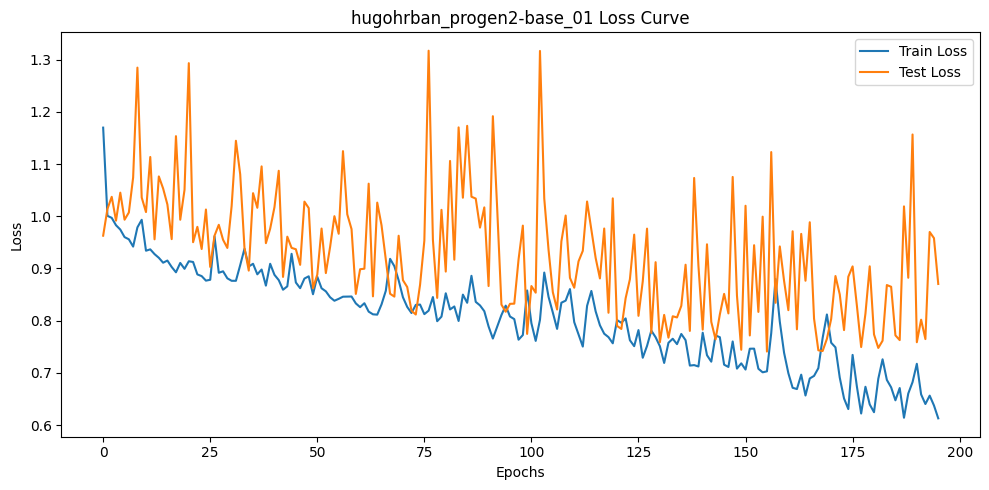

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-oas_01.pth


2025-07-16 14:19:03,316 - INFO - Epoch 1, train loss: 1.0904
2025-07-16 14:19:16,697 - INFO - valid loss: 0.9786


=> Saving checkpoint


2025-07-16 14:20:48,800 - INFO - Epoch 2, train loss: 0.9978
2025-07-16 14:21:02,210 - INFO - valid loss: 0.9821
2025-07-16 14:21:55,496 - INFO - Epoch 3, train loss: 0.9812
2025-07-16 14:22:08,874 - INFO - valid loss: 0.9691


=> Saving checkpoint


2025-07-16 14:23:33,280 - INFO - Epoch 4, train loss: 0.9742
2025-07-16 14:23:46,779 - INFO - valid loss: 0.9587


=> Saving checkpoint


2025-07-16 14:25:11,119 - INFO - Epoch 5, train loss: 0.9719
2025-07-16 14:25:24,517 - INFO - valid loss: 0.9768
2025-07-16 14:26:17,866 - INFO - Epoch 6, train loss: 0.9709
2025-07-16 14:26:31,377 - INFO - valid loss: 0.9487


=> Saving checkpoint


2025-07-16 14:27:55,702 - INFO - Epoch 7, train loss: 0.9854
2025-07-16 14:28:09,163 - INFO - valid loss: 1.0095
2025-07-16 14:29:02,448 - INFO - Epoch 8, train loss: 1.0060
2025-07-16 14:29:15,873 - INFO - valid loss: 1.0995
2025-07-16 14:30:09,266 - INFO - Epoch 9, train loss: 0.9822
2025-07-16 14:30:22,648 - INFO - valid loss: 0.9472


=> Saving checkpoint


2025-07-16 14:31:46,985 - INFO - Epoch 10, train loss: 0.9721
2025-07-16 14:32:00,384 - INFO - valid loss: 0.9297


=> Saving checkpoint


2025-07-16 14:33:24,630 - INFO - Epoch 11, train loss: 0.9727
2025-07-16 14:33:38,693 - INFO - valid loss: 1.0087
2025-07-16 14:34:31,993 - INFO - Epoch 12, train loss: 0.9590
2025-07-16 14:34:45,347 - INFO - valid loss: 0.9444
2025-07-16 14:35:38,694 - INFO - Epoch 13, train loss: 0.9633
2025-07-16 14:35:52,126 - INFO - valid loss: 1.0067
2025-07-16 14:36:45,413 - INFO - Epoch 14, train loss: 0.9509
2025-07-16 14:36:58,731 - INFO - valid loss: 0.9257


=> Saving checkpoint


2025-07-16 14:38:23,057 - INFO - Epoch 15, train loss: 0.9552
2025-07-16 14:38:36,443 - INFO - valid loss: 0.9736
2025-07-16 14:39:29,899 - INFO - Epoch 16, train loss: 0.9472
2025-07-16 14:39:44,664 - INFO - valid loss: 0.9273
2025-07-16 14:40:38,151 - INFO - Epoch 17, train loss: 0.9463
2025-07-16 14:40:51,552 - INFO - valid loss: 0.9598
2025-07-16 14:41:45,004 - INFO - Epoch 18, train loss: 0.9611
2025-07-16 14:41:58,370 - INFO - valid loss: 0.9347
2025-07-16 14:42:51,839 - INFO - Epoch 19, train loss: 0.9474
2025-07-16 14:43:05,354 - INFO - valid loss: 1.0297
2025-07-16 14:43:58,743 - INFO - Epoch 20, train loss: 0.9296
2025-07-16 14:44:12,098 - INFO - valid loss: 0.8927


=> Saving checkpoint


2025-07-16 14:45:36,446 - INFO - Epoch 21, train loss: 0.9658
2025-07-16 14:45:49,857 - INFO - valid loss: 0.8884


=> Saving checkpoint


2025-07-16 14:47:14,307 - INFO - Epoch 22, train loss: 0.9408
2025-07-16 14:47:27,832 - INFO - valid loss: 0.8598


=> Saving checkpoint


2025-07-16 14:48:52,299 - INFO - Epoch 23, train loss: 0.9689
2025-07-16 14:49:05,718 - INFO - valid loss: 0.9253
2025-07-16 14:49:58,991 - INFO - Epoch 24, train loss: 0.9345
2025-07-16 14:50:12,330 - INFO - valid loss: 0.9742
2025-07-16 14:51:05,687 - INFO - Epoch 25, train loss: 0.9315
2025-07-16 14:51:19,203 - INFO - valid loss: 1.1638
2025-07-16 14:52:12,633 - INFO - Epoch 26, train loss: 0.9394
2025-07-16 14:52:25,986 - INFO - valid loss: 0.9122
2025-07-16 14:53:19,306 - INFO - Epoch 27, train loss: 0.9686
2025-07-16 14:53:32,689 - INFO - valid loss: 0.9154
2025-07-16 14:54:26,050 - INFO - Epoch 28, train loss: 0.9269
2025-07-16 14:54:39,440 - INFO - valid loss: 0.8909
2025-07-16 14:55:32,832 - INFO - Epoch 29, train loss: 0.9655
2025-07-16 14:55:46,307 - INFO - valid loss: 0.8962
2025-07-16 14:56:39,691 - INFO - Epoch 30, train loss: 0.9175
2025-07-16 14:56:53,086 - INFO - valid loss: 1.1069
2025-07-16 14:57:46,506 - INFO - Epoch 31, train loss: 0.9401
2025-07-16 14:57:59,927 - 

=> Saving checkpoint


2025-07-16 15:03:52,008 - INFO - Epoch 36, train loss: 0.9050
2025-07-16 15:04:05,411 - INFO - valid loss: 1.0362
2025-07-16 15:04:58,811 - INFO - Epoch 37, train loss: 0.9245
2025-07-16 15:05:12,169 - INFO - valid loss: 1.1222
2025-07-16 15:06:05,465 - INFO - Epoch 38, train loss: 0.9130
2025-07-16 15:06:18,886 - INFO - valid loss: 0.9320
2025-07-16 15:07:12,389 - INFO - Epoch 39, train loss: 0.8802
2025-07-16 15:07:25,789 - INFO - valid loss: 0.8283


=> Saving checkpoint


2025-07-16 15:08:50,260 - INFO - Epoch 40, train loss: 0.8909
2025-07-16 15:09:03,658 - INFO - valid loss: 0.8414
2025-07-16 15:09:56,969 - INFO - Epoch 41, train loss: 0.9464
2025-07-16 15:10:10,479 - INFO - valid loss: 0.8323
2025-07-16 15:11:04,082 - INFO - Epoch 42, train loss: 0.9172
2025-07-16 15:11:17,416 - INFO - valid loss: 0.9767
2025-07-16 15:12:10,814 - INFO - Epoch 43, train loss: 0.8896
2025-07-16 15:12:24,489 - INFO - valid loss: 0.9219
2025-07-16 15:13:18,043 - INFO - Epoch 44, train loss: 0.8741
2025-07-16 15:13:31,453 - INFO - valid loss: 0.8554
2025-07-16 15:14:24,819 - INFO - Epoch 45, train loss: 0.8746
2025-07-16 15:14:38,153 - INFO - valid loss: 0.8472
2025-07-16 15:15:31,527 - INFO - Epoch 46, train loss: 0.8618
2025-07-16 15:15:44,942 - INFO - valid loss: 0.7989


=> Saving checkpoint


2025-07-16 15:17:09,326 - INFO - Epoch 47, train loss: 0.8966
2025-07-16 15:17:22,659 - INFO - valid loss: 1.0411
2025-07-16 15:18:16,048 - INFO - Epoch 48, train loss: 0.8944
2025-07-16 15:18:29,461 - INFO - valid loss: 1.0819
2025-07-16 15:19:22,804 - INFO - Epoch 49, train loss: 0.8946
2025-07-16 15:19:36,116 - INFO - valid loss: 1.0934
2025-07-16 15:20:29,552 - INFO - Epoch 50, train loss: 0.9499
2025-07-16 15:20:42,919 - INFO - valid loss: 1.1630
2025-07-16 15:21:36,276 - INFO - Epoch 51, train loss: 0.9234
2025-07-16 15:21:49,639 - INFO - valid loss: 0.8785
2025-07-16 15:22:43,028 - INFO - Epoch 52, train loss: 0.8979
2025-07-16 15:22:56,323 - INFO - valid loss: 0.8751
2025-07-16 15:23:49,722 - INFO - Epoch 53, train loss: 0.8766
2025-07-16 15:24:03,054 - INFO - valid loss: 0.9326
2025-07-16 15:24:56,463 - INFO - Epoch 54, train loss: 0.8573
2025-07-16 15:25:09,909 - INFO - valid loss: 0.8519
2025-07-16 15:26:03,259 - INFO - Epoch 55, train loss: 0.8805
2025-07-16 15:26:16,641 - 

=> Saving checkpoint


2025-07-16 15:34:21,758 - INFO - Epoch 62, train loss: 0.8150
2025-07-16 15:34:35,063 - INFO - valid loss: 0.7894
2025-07-16 15:35:28,406 - INFO - Epoch 63, train loss: 0.8198
2025-07-16 15:35:41,795 - INFO - valid loss: 0.7824
2025-07-16 15:36:35,286 - INFO - Epoch 64, train loss: 0.8223
2025-07-16 15:36:48,643 - INFO - valid loss: 0.8573
2025-07-16 15:37:42,000 - INFO - Epoch 65, train loss: 0.8163
2025-07-16 15:37:55,371 - INFO - valid loss: 0.8066
2025-07-16 15:38:48,732 - INFO - Epoch 66, train loss: 0.8017
2025-07-16 15:39:02,229 - INFO - valid loss: 0.7871
2025-07-16 15:39:55,615 - INFO - Epoch 67, train loss: 0.8456
2025-07-16 15:40:09,056 - INFO - valid loss: 1.0741
2025-07-16 15:41:02,523 - INFO - Epoch 68, train loss: 0.8660
2025-07-16 15:41:15,914 - INFO - valid loss: 0.8783
2025-07-16 15:42:09,358 - INFO - Epoch 69, train loss: 0.8600
2025-07-16 15:42:22,763 - INFO - valid loss: 0.8492
2025-07-16 15:43:16,165 - INFO - Epoch 70, train loss: 0.8431
2025-07-16 15:43:29,499 - 

=> Saving checkpoint


2025-07-16 15:46:00,584 - INFO - Epoch 72, train loss: 0.8909
2025-07-16 15:46:14,032 - INFO - valid loss: 0.8325
2025-07-16 15:47:07,486 - INFO - Epoch 73, train loss: 0.9086
2025-07-16 15:47:20,844 - INFO - valid loss: 0.8711
2025-07-16 15:48:14,204 - INFO - Epoch 74, train loss: 0.8625
2025-07-16 15:48:27,702 - INFO - valid loss: 0.9067
2025-07-16 15:49:21,227 - INFO - Epoch 75, train loss: 0.8331
2025-07-16 15:49:34,598 - INFO - valid loss: 0.8214
2025-07-16 15:50:28,021 - INFO - Epoch 76, train loss: 0.8431
2025-07-16 15:50:41,397 - INFO - valid loss: 0.8120
2025-07-16 15:51:34,840 - INFO - Epoch 77, train loss: 0.8123
2025-07-16 15:51:48,342 - INFO - valid loss: 0.8206
2025-07-16 15:52:41,737 - INFO - Epoch 78, train loss: 0.8220
2025-07-16 15:52:55,099 - INFO - valid loss: 0.7570
2025-07-16 15:53:48,503 - INFO - Epoch 79, train loss: 0.8372
2025-07-16 15:54:01,882 - INFO - valid loss: 0.7682
2025-07-16 15:54:55,370 - INFO - Epoch 80, train loss: 0.7947
2025-07-16 15:55:08,703 - 

=> Saving checkpoint


2025-07-16 16:04:20,929 - INFO - Epoch 88, train loss: 0.7842
2025-07-16 16:04:34,434 - INFO - valid loss: 0.7734
2025-07-16 16:05:27,773 - INFO - Epoch 89, train loss: 0.8180
2025-07-16 16:05:41,129 - INFO - valid loss: 0.9260
2025-07-16 16:06:34,538 - INFO - Epoch 90, train loss: 0.7618
2025-07-16 16:06:47,869 - INFO - valid loss: 0.7391


=> Saving checkpoint


2025-07-16 16:08:12,091 - INFO - Epoch 91, train loss: 0.7637
2025-07-16 16:08:25,431 - INFO - valid loss: 0.8299
2025-07-16 16:09:18,624 - INFO - Epoch 92, train loss: 0.7592
2025-07-16 16:09:31,992 - INFO - valid loss: 0.8026
2025-07-16 16:10:25,413 - INFO - Epoch 93, train loss: 0.8118
2025-07-16 16:10:38,765 - INFO - valid loss: 1.0611
2025-07-16 16:11:32,207 - INFO - Epoch 94, train loss: 0.8129
2025-07-16 16:11:45,635 - INFO - valid loss: 0.8735
2025-07-16 16:12:38,954 - INFO - Epoch 95, train loss: 0.7683
2025-07-16 16:12:52,333 - INFO - valid loss: 0.8045
2025-07-16 16:13:45,755 - INFO - Epoch 96, train loss: 0.7837
2025-07-16 16:13:59,110 - INFO - valid loss: 0.8588
2025-07-16 16:14:52,420 - INFO - Epoch 97, train loss: 0.7179
2025-07-16 16:15:05,833 - INFO - valid loss: 0.8938
2025-07-16 16:15:59,186 - INFO - Epoch 98, train loss: 0.7188
2025-07-16 16:16:12,693 - INFO - valid loss: 0.8529
2025-07-16 16:17:05,997 - INFO - Epoch 99, train loss: 0.7325
2025-07-16 16:17:19,456 - 

=> Saving checkpoint


2025-07-16 16:19:50,666 - INFO - Epoch 101, train loss: 0.7457
2025-07-16 16:20:04,097 - INFO - valid loss: 0.8803
2025-07-16 16:20:57,403 - INFO - Epoch 102, train loss: 0.7510
2025-07-16 16:21:10,834 - INFO - valid loss: 0.7586
2025-07-16 16:22:04,188 - INFO - Epoch 103, train loss: 0.7479
2025-07-16 16:22:17,586 - INFO - valid loss: 0.7291
2025-07-16 16:23:10,865 - INFO - Epoch 104, train loss: 0.7887
2025-07-16 16:23:24,245 - INFO - valid loss: 1.0722
2025-07-16 16:24:17,561 - INFO - Epoch 105, train loss: 0.7967
2025-07-16 16:24:31,044 - INFO - valid loss: 0.9150
2025-07-16 16:25:24,392 - INFO - Epoch 106, train loss: 0.7226
2025-07-16 16:25:37,770 - INFO - valid loss: 0.7592
2025-07-16 16:26:31,047 - INFO - Epoch 107, train loss: 0.7111
2025-07-16 16:26:44,460 - INFO - valid loss: 0.7765
2025-07-16 16:27:37,771 - INFO - Epoch 108, train loss: 0.7009
2025-07-16 16:27:51,030 - INFO - valid loss: 0.7201


=> Saving checkpoint


2025-07-16 16:29:15,352 - INFO - Epoch 109, train loss: 0.7771
2025-07-16 16:29:28,787 - INFO - valid loss: 1.0004
2025-07-16 16:30:22,189 - INFO - Epoch 110, train loss: 0.7193
2025-07-16 16:30:35,533 - INFO - valid loss: 0.7921
2025-07-16 16:31:28,912 - INFO - Epoch 111, train loss: 0.7529
2025-07-16 16:31:42,345 - INFO - valid loss: 0.7429
2025-07-16 16:32:35,703 - INFO - Epoch 112, train loss: 0.7304
2025-07-16 16:32:49,089 - INFO - valid loss: 0.9193
2025-07-16 16:33:42,547 - INFO - Epoch 113, train loss: 0.6934
2025-07-16 16:33:56,009 - INFO - valid loss: 1.0441
2025-07-16 16:34:49,329 - INFO - Epoch 114, train loss: 0.6918
2025-07-16 16:35:02,744 - INFO - valid loss: 0.7924
2025-07-16 16:35:56,092 - INFO - Epoch 115, train loss: 0.7014
2025-07-16 16:36:09,431 - INFO - valid loss: 0.7457
2025-07-16 16:37:02,872 - INFO - Epoch 116, train loss: 0.7757
2025-07-16 16:37:16,270 - INFO - valid loss: 0.7338
2025-07-16 16:38:09,661 - INFO - Epoch 117, train loss: 0.7068
2025-07-16 16:38:

=> Saving checkpoint


2025-07-16 16:48:42,225 - INFO - Epoch 126, train loss: 0.6364
2025-07-16 16:48:55,543 - INFO - valid loss: 0.7537
2025-07-16 16:49:48,803 - INFO - Epoch 127, train loss: 0.6633
2025-07-16 16:50:02,184 - INFO - valid loss: 0.7590
2025-07-16 16:50:55,492 - INFO - Epoch 128, train loss: 0.7101
2025-07-16 16:51:08,840 - INFO - valid loss: 0.7109


=> Saving checkpoint


2025-07-16 16:52:33,309 - INFO - Epoch 129, train loss: 0.7943
2025-07-16 16:52:46,694 - INFO - valid loss: 0.9555
2025-07-16 16:53:40,074 - INFO - Epoch 130, train loss: 0.7369
2025-07-16 16:53:53,419 - INFO - valid loss: 0.7157
2025-07-16 16:54:46,773 - INFO - Epoch 131, train loss: 0.7527
2025-07-16 16:55:00,091 - INFO - valid loss: 0.7352
2025-07-16 16:55:53,393 - INFO - Epoch 132, train loss: 0.7178
2025-07-16 16:56:06,806 - INFO - valid loss: 0.9501
2025-07-16 16:57:00,183 - INFO - Epoch 133, train loss: 0.6468
2025-07-16 16:57:13,558 - INFO - valid loss: 0.7336
2025-07-16 16:58:06,940 - INFO - Epoch 134, train loss: 0.6525
2025-07-16 16:58:20,213 - INFO - valid loss: 0.9746
2025-07-16 16:59:13,535 - INFO - Epoch 135, train loss: 0.7164
2025-07-16 16:59:26,907 - INFO - valid loss: 0.7190
2025-07-16 17:00:20,318 - INFO - Epoch 136, train loss: 0.7135
2025-07-16 17:00:33,663 - INFO - valid loss: 0.9195
2025-07-16 17:01:27,047 - INFO - Epoch 137, train loss: 0.6561
2025-07-16 17:01:

early stop at epoch 168
=> Training completed! Best loss is 0.7109 at epoch 128


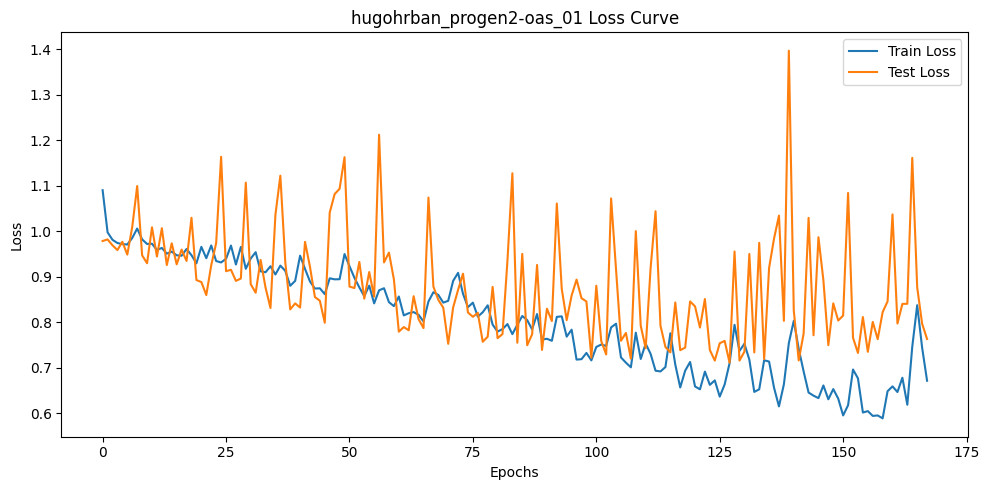

path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-BFD90_01.pth


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2025-07-16 17:39:02,776 - INFO - Epoch 1, train loss: 1.1187
2025-07-16 17:39:28,846 - INFO - valid loss: 1.0702


=> Saving checkpoint


2025-07-16 17:43:52,421 - INFO - Epoch 2, train loss: 0.9818
2025-07-16 17:44:18,527 - INFO - valid loss: 0.9902


=> Saving checkpoint


2025-07-16 17:48:40,607 - INFO - Epoch 3, train loss: 0.9644
2025-07-16 17:49:06,680 - INFO - valid loss: 0.9023


=> Saving checkpoint


2025-07-16 17:53:28,502 - INFO - Epoch 4, train loss: 0.9690
2025-07-16 17:53:54,654 - INFO - valid loss: 1.1003
2025-07-16 17:56:27,851 - INFO - Epoch 5, train loss: 0.9620
2025-07-16 17:56:53,947 - INFO - valid loss: 0.8825


=> Saving checkpoint


2025-07-16 18:01:15,597 - INFO - Epoch 6, train loss: 0.9392
2025-07-16 18:01:41,651 - INFO - valid loss: 0.9271
2025-07-16 18:04:15,000 - INFO - Epoch 7, train loss: 0.9487
2025-07-16 18:04:41,227 - INFO - valid loss: 0.9408
2025-07-16 18:07:14,519 - INFO - Epoch 8, train loss: 0.9207
2025-07-16 18:07:40,729 - INFO - valid loss: 0.9741
2025-07-16 18:10:13,950 - INFO - Epoch 9, train loss: 0.8776
2025-07-16 18:10:40,114 - INFO - valid loss: 0.9032
2025-07-16 18:13:13,492 - INFO - Epoch 10, train loss: 0.8718
2025-07-16 18:13:39,666 - INFO - valid loss: 1.0747
2025-07-16 18:16:12,852 - INFO - Epoch 11, train loss: 0.8670
2025-07-16 18:16:39,063 - INFO - valid loss: 0.8382


=> Saving checkpoint


2025-07-16 18:20:59,685 - INFO - Epoch 12, train loss: 0.8101
2025-07-16 18:21:25,807 - INFO - valid loss: 0.7409


=> Saving checkpoint


2025-07-16 18:25:46,779 - INFO - Epoch 13, train loss: 0.8111
2025-07-16 18:26:12,925 - INFO - valid loss: 0.8958
2025-07-16 18:28:45,958 - INFO - Epoch 14, train loss: 0.7748
2025-07-16 18:29:12,153 - INFO - valid loss: 0.7597
2025-07-16 18:31:45,253 - INFO - Epoch 15, train loss: 0.7736
2025-07-16 18:32:11,391 - INFO - valid loss: 0.9127
2025-07-16 18:34:44,776 - INFO - Epoch 16, train loss: 0.7583
2025-07-16 18:35:10,915 - INFO - valid loss: 0.7283


=> Saving checkpoint


2025-07-16 18:39:31,229 - INFO - Epoch 17, train loss: 0.7052
2025-07-16 18:39:57,592 - INFO - valid loss: 0.8322
2025-07-16 18:42:30,672 - INFO - Epoch 18, train loss: 0.7633
2025-07-16 18:42:56,760 - INFO - valid loss: 0.6977


=> Saving checkpoint


2025-07-16 18:47:15,656 - INFO - Epoch 19, train loss: 0.7093
2025-07-16 18:47:41,804 - INFO - valid loss: 0.9076
2025-07-16 18:50:14,796 - INFO - Epoch 20, train loss: 0.7879
2025-07-16 18:50:40,825 - INFO - valid loss: 0.7992
2025-07-16 18:53:14,002 - INFO - Epoch 21, train loss: 0.7455
2025-07-16 18:53:39,992 - INFO - valid loss: 0.8982
2025-07-16 18:56:13,080 - INFO - Epoch 22, train loss: 0.8145
2025-07-16 18:56:39,269 - INFO - valid loss: 0.7913
2025-07-16 18:59:12,482 - INFO - Epoch 23, train loss: 0.8916
2025-07-16 18:59:38,520 - INFO - valid loss: 1.0855
2025-07-16 19:02:11,619 - INFO - Epoch 24, train loss: 0.8387
2025-07-16 19:02:37,716 - INFO - valid loss: 0.7548
2025-07-16 19:05:10,833 - INFO - Epoch 25, train loss: 0.8008
2025-07-16 19:05:36,825 - INFO - valid loss: 0.7208
2025-07-16 19:08:09,948 - INFO - Epoch 26, train loss: 0.7535
2025-07-16 19:08:36,015 - INFO - valid loss: 0.7133
2025-07-16 19:11:09,056 - INFO - Epoch 27, train loss: 0.6943
2025-07-16 19:11:35,120 - 

=> Saving checkpoint


2025-07-16 19:18:55,627 - INFO - Epoch 29, train loss: 0.6414
2025-07-16 19:19:21,711 - INFO - valid loss: 0.8316
2025-07-16 19:21:54,725 - INFO - Epoch 30, train loss: 0.7430
2025-07-16 19:22:20,764 - INFO - valid loss: 0.6763


=> Saving checkpoint


2025-07-16 19:26:39,851 - INFO - Epoch 31, train loss: 0.6681
2025-07-16 19:27:06,011 - INFO - valid loss: 0.6676


=> Saving checkpoint


2025-07-16 19:31:25,005 - INFO - Epoch 32, train loss: 0.6402
2025-07-16 19:31:51,098 - INFO - valid loss: 0.7830
2025-07-16 19:34:24,284 - INFO - Epoch 33, train loss: 0.6028
2025-07-16 19:34:50,488 - INFO - valid loss: 0.7637
2025-07-16 19:37:23,572 - INFO - Epoch 34, train loss: 0.6000
2025-07-16 19:37:49,736 - INFO - valid loss: 0.6842
2025-07-16 19:40:23,102 - INFO - Epoch 35, train loss: 0.5921
2025-07-16 19:40:49,337 - INFO - valid loss: 0.7613
2025-07-16 19:43:22,611 - INFO - Epoch 36, train loss: 0.5944
2025-07-16 19:43:48,743 - INFO - valid loss: 0.7080
2025-07-16 19:46:21,840 - INFO - Epoch 37, train loss: 0.6782
2025-07-16 19:46:48,058 - INFO - valid loss: 0.7701
2025-07-16 19:49:21,201 - INFO - Epoch 38, train loss: 0.6198
2025-07-16 19:49:47,307 - INFO - valid loss: 0.7211
2025-07-16 19:52:20,348 - INFO - Epoch 39, train loss: 0.5703
2025-07-16 19:52:46,487 - INFO - valid loss: 0.7035
2025-07-16 19:55:19,546 - INFO - Epoch 40, train loss: 0.6321
2025-07-16 19:55:45,615 - 

early stop at epoch 71
=> Training completed! Best loss is 0.6676 at epoch 31


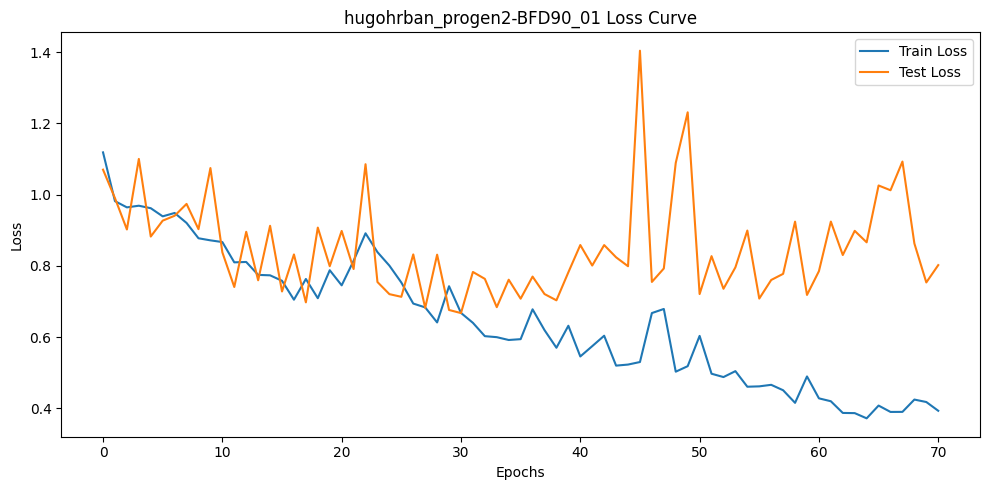

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-small-mix7_01.pth


2025-07-16 21:28:46,981 - INFO - Epoch 1, train loss: 1.1023
2025-07-16 21:28:56,311 - INFO - valid loss: 0.9067


=> Saving checkpoint


2025-07-16 21:29:31,522 - INFO - Epoch 2, train loss: 0.9829
2025-07-16 21:29:40,800 - INFO - valid loss: 1.0404
2025-07-16 21:29:59,119 - INFO - Epoch 3, train loss: 0.9865
2025-07-16 21:30:08,306 - INFO - valid loss: 0.9894
2025-07-16 21:30:26,709 - INFO - Epoch 4, train loss: 0.9649
2025-07-16 21:30:36,002 - INFO - valid loss: 0.9078
2025-07-16 21:30:54,529 - INFO - Epoch 5, train loss: 0.9705
2025-07-16 21:31:03,860 - INFO - valid loss: 0.9195
2025-07-16 21:31:22,156 - INFO - Epoch 6, train loss: 0.9486
2025-07-16 21:31:31,457 - INFO - valid loss: 0.9401
2025-07-16 21:31:49,908 - INFO - Epoch 7, train loss: 0.9355
2025-07-16 21:31:59,171 - INFO - valid loss: 1.0017
2025-07-16 21:32:17,661 - INFO - Epoch 8, train loss: 0.9166
2025-07-16 21:32:26,937 - INFO - valid loss: 0.8957


=> Saving checkpoint


2025-07-16 21:32:51,551 - INFO - Epoch 9, train loss: 0.9587
2025-07-16 21:33:00,751 - INFO - valid loss: 0.8193


=> Saving checkpoint


2025-07-16 21:33:25,508 - INFO - Epoch 10, train loss: 1.0045
2025-07-16 21:33:34,751 - INFO - valid loss: 0.8706
2025-07-16 21:33:53,152 - INFO - Epoch 11, train loss: 0.9548
2025-07-16 21:34:02,367 - INFO - valid loss: 1.0097
2025-07-16 21:34:20,755 - INFO - Epoch 12, train loss: 0.9294
2025-07-16 21:34:30,023 - INFO - valid loss: 0.8769
2025-07-16 21:34:48,338 - INFO - Epoch 13, train loss: 0.9248
2025-07-16 21:34:57,657 - INFO - valid loss: 0.9181
2025-07-16 21:35:16,083 - INFO - Epoch 14, train loss: 0.9153
2025-07-16 21:35:25,333 - INFO - valid loss: 0.8462
2025-07-16 21:35:43,777 - INFO - Epoch 15, train loss: 0.9100
2025-07-16 21:35:53,499 - INFO - valid loss: 0.8792
2025-07-16 21:36:11,854 - INFO - Epoch 16, train loss: 0.8931
2025-07-16 21:36:21,069 - INFO - valid loss: 0.9506
2025-07-16 21:36:39,376 - INFO - Epoch 17, train loss: 0.9570
2025-07-16 21:36:48,614 - INFO - valid loss: 1.0352
2025-07-16 21:37:07,059 - INFO - Epoch 18, train loss: 0.9028
2025-07-16 21:37:16,323 - 

=> Saving checkpoint


2025-07-16 21:47:56,855 - INFO - Epoch 41, train loss: 0.8661
2025-07-16 21:48:06,126 - INFO - valid loss: 0.8794
2025-07-16 21:48:24,533 - INFO - Epoch 42, train loss: 0.8026
2025-07-16 21:48:33,831 - INFO - valid loss: 0.9244
2025-07-16 21:48:52,287 - INFO - Epoch 43, train loss: 0.8227
2025-07-16 21:49:01,597 - INFO - valid loss: 0.8302
2025-07-16 21:49:19,944 - INFO - Epoch 44, train loss: 0.7953
2025-07-16 21:49:29,227 - INFO - valid loss: 0.9421
2025-07-16 21:49:47,688 - INFO - Epoch 45, train loss: 0.8151
2025-07-16 21:49:56,974 - INFO - valid loss: 1.0448
2025-07-16 21:50:15,407 - INFO - Epoch 46, train loss: 0.8250
2025-07-16 21:50:24,598 - INFO - valid loss: 0.8521
2025-07-16 21:50:42,996 - INFO - Epoch 47, train loss: 0.7993
2025-07-16 21:50:52,289 - INFO - valid loss: 0.7910


=> Saving checkpoint


2025-07-16 21:51:16,972 - INFO - Epoch 48, train loss: 0.8057
2025-07-16 21:51:26,188 - INFO - valid loss: 0.8507
2025-07-16 21:51:44,427 - INFO - Epoch 49, train loss: 0.8736
2025-07-16 21:51:53,797 - INFO - valid loss: 0.9250
2025-07-16 21:52:12,210 - INFO - Epoch 50, train loss: 0.8701
2025-07-16 21:52:21,526 - INFO - valid loss: 0.8628
2025-07-16 21:52:39,928 - INFO - Epoch 51, train loss: 0.8130
2025-07-16 21:52:49,118 - INFO - valid loss: 0.7833


=> Saving checkpoint


2025-07-16 21:53:13,836 - INFO - Epoch 52, train loss: 0.8149
2025-07-16 21:53:23,087 - INFO - valid loss: 0.8113
2025-07-16 21:53:41,458 - INFO - Epoch 53, train loss: 0.8169
2025-07-16 21:53:50,743 - INFO - valid loss: 0.8471
2025-07-16 21:54:09,171 - INFO - Epoch 54, train loss: 0.7870
2025-07-16 21:54:18,376 - INFO - valid loss: 0.7741


=> Saving checkpoint


2025-07-16 21:54:43,171 - INFO - Epoch 55, train loss: 0.8385
2025-07-16 21:54:52,376 - INFO - valid loss: 0.8801
2025-07-16 21:55:10,710 - INFO - Epoch 56, train loss: 0.7760
2025-07-16 21:55:19,954 - INFO - valid loss: 0.8808
2025-07-16 21:55:38,292 - INFO - Epoch 57, train loss: 0.7757
2025-07-16 21:55:47,539 - INFO - valid loss: 0.8234
2025-07-16 21:56:05,921 - INFO - Epoch 58, train loss: 0.8027
2025-07-16 21:56:15,127 - INFO - valid loss: 0.8253
2025-07-16 21:56:33,485 - INFO - Epoch 59, train loss: 0.7721
2025-07-16 21:56:42,722 - INFO - valid loss: 0.8256
2025-07-16 21:57:01,131 - INFO - Epoch 60, train loss: 0.7587
2025-07-16 21:57:10,958 - INFO - valid loss: 0.8478
2025-07-16 21:57:29,301 - INFO - Epoch 61, train loss: 0.7615
2025-07-16 21:57:38,612 - INFO - valid loss: 1.2046
2025-07-16 21:57:57,014 - INFO - Epoch 62, train loss: 0.7986
2025-07-16 21:58:06,300 - INFO - valid loss: 0.8833
2025-07-16 21:58:24,675 - INFO - Epoch 63, train loss: 0.7578
2025-07-16 21:58:33,952 - 

=> Saving checkpoint


2025-07-16 22:04:03,365 - INFO - Epoch 75, train loss: 0.8457
2025-07-16 22:04:12,695 - INFO - valid loss: 0.7520


=> Saving checkpoint


2025-07-16 22:04:37,439 - INFO - Epoch 76, train loss: 0.8133
2025-07-16 22:04:46,730 - INFO - valid loss: 1.0101
2025-07-16 22:05:05,143 - INFO - Epoch 77, train loss: 0.7838
2025-07-16 22:05:14,369 - INFO - valid loss: 1.0653
2025-07-16 22:05:32,769 - INFO - Epoch 78, train loss: 0.7414
2025-07-16 22:05:42,041 - INFO - valid loss: 0.8992
2025-07-16 22:06:00,424 - INFO - Epoch 79, train loss: 0.6983
2025-07-16 22:06:09,752 - INFO - valid loss: 1.0912
2025-07-16 22:06:28,249 - INFO - Epoch 80, train loss: 0.7444
2025-07-16 22:06:37,579 - INFO - valid loss: 1.1436
2025-07-16 22:06:55,961 - INFO - Epoch 81, train loss: 0.7125
2025-07-16 22:07:05,207 - INFO - valid loss: 1.4101
2025-07-16 22:07:23,648 - INFO - Epoch 82, train loss: 0.7589
2025-07-16 22:07:32,898 - INFO - valid loss: 0.7891
2025-07-16 22:07:51,319 - INFO - Epoch 83, train loss: 0.7182
2025-07-16 22:08:00,534 - INFO - valid loss: 0.8082
2025-07-16 22:08:18,884 - INFO - Epoch 84, train loss: 0.6545
2025-07-16 22:08:28,117 - 

=> Saving checkpoint


2025-07-16 22:11:38,875 - INFO - Epoch 91, train loss: 0.7293
2025-07-16 22:11:48,160 - INFO - valid loss: 0.7567
2025-07-16 22:12:06,629 - INFO - Epoch 92, train loss: 0.7306
2025-07-16 22:12:15,910 - INFO - valid loss: 0.7546
2025-07-16 22:12:34,300 - INFO - Epoch 93, train loss: 0.6974
2025-07-16 22:12:43,653 - INFO - valid loss: 0.8329
2025-07-16 22:13:02,123 - INFO - Epoch 94, train loss: 0.6405
2025-07-16 22:13:11,375 - INFO - valid loss: 0.7913
2025-07-16 22:13:29,830 - INFO - Epoch 95, train loss: 0.6349
2025-07-16 22:13:39,057 - INFO - valid loss: 0.9568
2025-07-16 22:13:57,522 - INFO - Epoch 96, train loss: 0.7078
2025-07-16 22:14:06,820 - INFO - valid loss: 1.0406
2025-07-16 22:14:25,289 - INFO - Epoch 97, train loss: 0.6850
2025-07-16 22:14:34,520 - INFO - valid loss: 0.7412
2025-07-16 22:14:52,947 - INFO - Epoch 98, train loss: 0.6140
2025-07-16 22:15:02,201 - INFO - valid loss: 0.9807
2025-07-16 22:15:20,600 - INFO - Epoch 99, train loss: 0.6190
2025-07-16 22:15:29,892 - 

=> Saving checkpoint


2025-07-16 22:18:40,525 - INFO - Epoch 106, train loss: 0.6345
2025-07-16 22:18:49,781 - INFO - valid loss: 1.2705
2025-07-16 22:19:08,161 - INFO - Epoch 107, train loss: 0.6190
2025-07-16 22:19:17,422 - INFO - valid loss: 0.7081


=> Saving checkpoint


2025-07-16 22:19:42,164 - INFO - Epoch 108, train loss: 0.5674
2025-07-16 22:19:51,474 - INFO - valid loss: 0.7857
2025-07-16 22:20:09,865 - INFO - Epoch 109, train loss: 0.5390
2025-07-16 22:20:19,174 - INFO - valid loss: 0.7286
2025-07-16 22:20:37,564 - INFO - Epoch 110, train loss: 0.6029
2025-07-16 22:20:46,826 - INFO - valid loss: 0.6951


=> Saving checkpoint


2025-07-16 22:21:11,617 - INFO - Epoch 111, train loss: 0.7357
2025-07-16 22:21:20,806 - INFO - valid loss: 0.6770


=> Saving checkpoint


2025-07-16 22:21:45,495 - INFO - Epoch 112, train loss: 0.6949
2025-07-16 22:21:54,831 - INFO - valid loss: 0.7001
2025-07-16 22:22:13,247 - INFO - Epoch 113, train loss: 0.6568
2025-07-16 22:22:22,462 - INFO - valid loss: 0.6689


=> Saving checkpoint


2025-07-16 22:22:47,155 - INFO - Epoch 114, train loss: 0.5926
2025-07-16 22:22:56,441 - INFO - valid loss: 0.7558
2025-07-16 22:23:14,894 - INFO - Epoch 115, train loss: 0.6267
2025-07-16 22:23:24,181 - INFO - valid loss: 0.7800
2025-07-16 22:23:42,551 - INFO - Epoch 116, train loss: 0.5476
2025-07-16 22:23:51,819 - INFO - valid loss: 0.8303
2025-07-16 22:24:10,328 - INFO - Epoch 117, train loss: 0.5418
2025-07-16 22:24:19,522 - INFO - valid loss: 0.7931
2025-07-16 22:24:37,973 - INFO - Epoch 118, train loss: 0.5685
2025-07-16 22:24:47,205 - INFO - valid loss: 0.7874
2025-07-16 22:25:05,605 - INFO - Epoch 119, train loss: 0.5611
2025-07-16 22:25:15,270 - INFO - valid loss: 1.0024
2025-07-16 22:25:33,591 - INFO - Epoch 120, train loss: 0.5343
2025-07-16 22:25:42,948 - INFO - valid loss: 0.7497
2025-07-16 22:26:01,387 - INFO - Epoch 121, train loss: 0.5222
2025-07-16 22:26:10,631 - INFO - valid loss: 0.7948
2025-07-16 22:26:29,046 - INFO - Epoch 122, train loss: 0.5480
2025-07-16 22:26:

=> Saving checkpoint


2025-07-16 22:29:21,497 - INFO - Epoch 128, train loss: 0.5720
2025-07-16 22:29:30,828 - INFO - valid loss: 0.7333
2025-07-16 22:29:49,187 - INFO - Epoch 129, train loss: 0.5355
2025-07-16 22:29:58,446 - INFO - valid loss: 0.7506
2025-07-16 22:30:16,893 - INFO - Epoch 130, train loss: 0.6205
2025-07-16 22:30:26,187 - INFO - valid loss: 0.9127
2025-07-16 22:30:44,596 - INFO - Epoch 131, train loss: 0.4854
2025-07-16 22:30:53,893 - INFO - valid loss: 0.7138
2025-07-16 22:31:12,528 - INFO - Epoch 132, train loss: 0.4943
2025-07-16 22:31:21,794 - INFO - valid loss: 0.8094
2025-07-16 22:31:40,279 - INFO - Epoch 133, train loss: 0.5799
2025-07-16 22:31:49,503 - INFO - valid loss: 0.7360
2025-07-16 22:32:07,929 - INFO - Epoch 134, train loss: 0.5344
2025-07-16 22:32:17,183 - INFO - valid loss: 0.7438
2025-07-16 22:32:35,701 - INFO - Epoch 135, train loss: 0.5157
2025-07-16 22:32:44,958 - INFO - valid loss: 0.9349
2025-07-16 22:33:03,404 - INFO - Epoch 136, train loss: 0.4882
2025-07-16 22:33:

=> Saving checkpoint


2025-07-16 22:40:04,645 - INFO - Epoch 151, train loss: 0.5212
2025-07-16 22:40:13,831 - INFO - valid loss: 0.8173
2025-07-16 22:40:32,228 - INFO - Epoch 152, train loss: 0.4642
2025-07-16 22:40:41,559 - INFO - valid loss: 0.7975
2025-07-16 22:41:00,017 - INFO - Epoch 153, train loss: 0.4405
2025-07-16 22:41:09,267 - INFO - valid loss: 0.8885
2025-07-16 22:41:27,635 - INFO - Epoch 154, train loss: 0.4902
2025-07-16 22:41:36,959 - INFO - valid loss: 0.8506
2025-07-16 22:41:55,328 - INFO - Epoch 155, train loss: 0.4097
2025-07-16 22:42:04,586 - INFO - valid loss: 0.7114
2025-07-16 22:42:22,950 - INFO - Epoch 156, train loss: 0.4236
2025-07-16 22:42:32,241 - INFO - valid loss: 0.6841
2025-07-16 22:42:50,594 - INFO - Epoch 157, train loss: 0.4420
2025-07-16 22:42:59,869 - INFO - valid loss: 0.8021
2025-07-16 22:43:18,291 - INFO - Epoch 158, train loss: 0.4478
2025-07-16 22:43:27,572 - INFO - valid loss: 0.6664
2025-07-16 22:43:45,979 - INFO - Epoch 159, train loss: 0.4840
2025-07-16 22:43:

early stop at epoch 190
=> Training completed! Best loss is 0.6373 at epoch 150


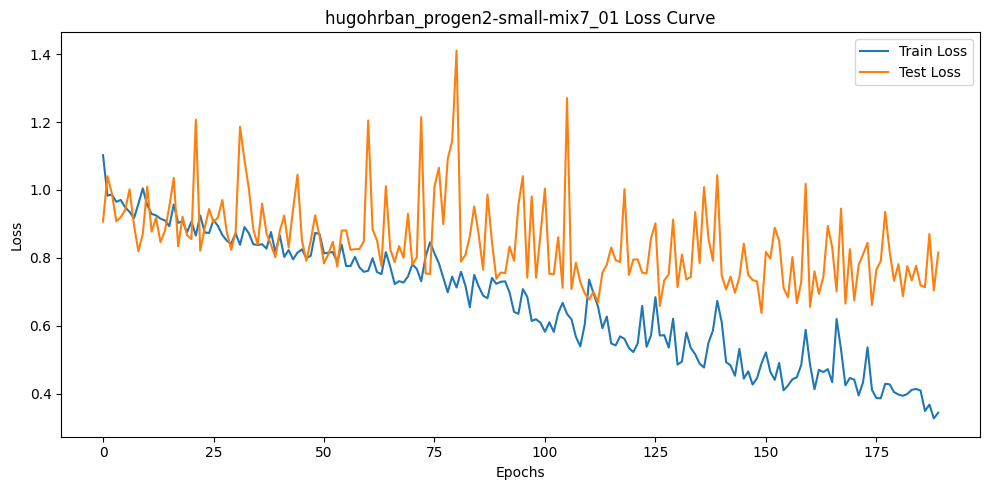

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


path_savemodel: /nas_data/mingxuan_model/hugohrban_progen2-small-mix7-bidi_01.pth


2025-07-16 22:58:31,039 - INFO - Epoch 1, train loss: 1.1439
2025-07-16 22:58:40,185 - INFO - valid loss: 0.8870


=> Saving checkpoint


2025-07-16 22:59:04,628 - INFO - Epoch 2, train loss: 1.0023
2025-07-16 22:59:13,797 - INFO - valid loss: 1.0128
2025-07-16 22:59:32,117 - INFO - Epoch 3, train loss: 0.9891
2025-07-16 22:59:41,313 - INFO - valid loss: 0.9516
2025-07-16 22:59:59,652 - INFO - Epoch 4, train loss: 0.9756
2025-07-16 23:00:08,933 - INFO - valid loss: 0.9648
2025-07-16 23:00:27,247 - INFO - Epoch 5, train loss: 0.9674
2025-07-16 23:00:36,424 - INFO - valid loss: 0.9659
2025-07-16 23:00:54,745 - INFO - Epoch 6, train loss: 0.9659
2025-07-16 23:01:03,887 - INFO - valid loss: 0.9010
2025-07-16 23:01:22,308 - INFO - Epoch 7, train loss: 0.9741
2025-07-16 23:01:31,598 - INFO - valid loss: 1.0139
2025-07-16 23:01:50,019 - INFO - Epoch 8, train loss: 0.9557
2025-07-16 23:01:59,214 - INFO - valid loss: 0.8961
2025-07-16 23:02:17,557 - INFO - Epoch 9, train loss: 0.9425
2025-07-16 23:02:26,719 - INFO - valid loss: 0.9861
2025-07-16 23:02:45,017 - INFO - Epoch 10, train loss: 0.9618
2025-07-16 23:02:54,274 - INFO - v

=> Saving checkpoint


2025-07-16 23:03:18,959 - INFO - Epoch 11, train loss: 0.9811
2025-07-16 23:03:28,233 - INFO - valid loss: 0.9040
2025-07-16 23:03:46,623 - INFO - Epoch 12, train loss: 0.9308
2025-07-16 23:03:55,816 - INFO - valid loss: 1.0751
2025-07-16 23:04:14,085 - INFO - Epoch 13, train loss: 0.9469
2025-07-16 23:04:23,298 - INFO - valid loss: 0.9428
2025-07-16 23:04:41,556 - INFO - Epoch 14, train loss: 0.9225
2025-07-16 23:04:50,631 - INFO - valid loss: 1.0749
2025-07-16 23:05:08,987 - INFO - Epoch 15, train loss: 0.9173
2025-07-16 23:05:18,133 - INFO - valid loss: 0.8999
2025-07-16 23:05:36,472 - INFO - Epoch 16, train loss: 0.9043
2025-07-16 23:05:45,618 - INFO - valid loss: 1.0333
2025-07-16 23:06:04,016 - INFO - Epoch 17, train loss: 0.8936
2025-07-16 23:06:13,157 - INFO - valid loss: 0.9186
2025-07-16 23:06:31,440 - INFO - Epoch 18, train loss: 0.9273
2025-07-16 23:06:40,599 - INFO - valid loss: 1.0344
2025-07-16 23:06:58,899 - INFO - Epoch 19, train loss: 0.9469
2025-07-16 23:07:08,011 - 

=> Saving checkpoint


2025-07-16 23:16:43,584 - INFO - Epoch 40, train loss: 0.8434
2025-07-16 23:16:52,699 - INFO - valid loss: 0.9108
2025-07-16 23:17:10,963 - INFO - Epoch 41, train loss: 0.8451
2025-07-16 23:17:20,161 - INFO - valid loss: 0.8526
2025-07-16 23:17:38,534 - INFO - Epoch 42, train loss: 0.8749
2025-07-16 23:17:47,718 - INFO - valid loss: 0.9075
2025-07-16 23:18:06,077 - INFO - Epoch 43, train loss: 0.9470
2025-07-16 23:18:15,275 - INFO - valid loss: 0.9403
2025-07-16 23:18:33,589 - INFO - Epoch 44, train loss: 0.8814
2025-07-16 23:18:42,819 - INFO - valid loss: 0.8593
2025-07-16 23:19:01,124 - INFO - Epoch 45, train loss: 0.8990
2025-07-16 23:19:10,320 - INFO - valid loss: 0.9145
2025-07-16 23:19:28,679 - INFO - Epoch 46, train loss: 0.8620
2025-07-16 23:19:37,848 - INFO - valid loss: 0.9801
2025-07-16 23:19:56,124 - INFO - Epoch 47, train loss: 0.8387
2025-07-16 23:20:05,344 - INFO - valid loss: 0.8872
2025-07-16 23:20:23,702 - INFO - Epoch 48, train loss: 0.8368
2025-07-16 23:20:32,916 - 

=> Saving checkpoint


2025-07-16 23:29:41,022 - INFO - Epoch 68, train loss: 0.8154
2025-07-16 23:29:50,291 - INFO - valid loss: 0.8634
2025-07-16 23:30:08,592 - INFO - Epoch 69, train loss: 0.8467
2025-07-16 23:30:17,787 - INFO - valid loss: 0.8483
2025-07-16 23:30:36,112 - INFO - Epoch 70, train loss: 0.8326
2025-07-16 23:30:45,343 - INFO - valid loss: 0.9975
2025-07-16 23:31:03,648 - INFO - Epoch 71, train loss: 0.8219
2025-07-16 23:31:12,805 - INFO - valid loss: 1.0004
2025-07-16 23:31:31,245 - INFO - Epoch 72, train loss: 0.8110
2025-07-16 23:31:40,453 - INFO - valid loss: 1.1166
2025-07-16 23:31:58,795 - INFO - Epoch 73, train loss: 0.7604
2025-07-16 23:32:07,999 - INFO - valid loss: 0.9921
2025-07-16 23:32:26,252 - INFO - Epoch 74, train loss: 0.7365
2025-07-16 23:32:35,410 - INFO - valid loss: 1.0145
2025-07-16 23:32:53,737 - INFO - Epoch 75, train loss: 0.7395
2025-07-16 23:33:02,941 - INFO - valid loss: 0.9746
2025-07-16 23:33:21,272 - INFO - Epoch 76, train loss: 0.7427
2025-07-16 23:33:30,462 - 

=> Saving checkpoint


2025-07-16 23:36:40,617 - INFO - Epoch 83, train loss: 0.9095
2025-07-16 23:36:49,747 - INFO - valid loss: 0.9993
2025-07-16 23:37:08,010 - INFO - Epoch 84, train loss: 0.8599
2025-07-16 23:37:17,343 - INFO - valid loss: 0.8686
2025-07-16 23:37:35,655 - INFO - Epoch 85, train loss: 0.8475
2025-07-16 23:37:44,798 - INFO - valid loss: 0.9014
2025-07-16 23:38:03,018 - INFO - Epoch 86, train loss: 0.8188
2025-07-16 23:38:12,216 - INFO - valid loss: 0.9433
2025-07-16 23:38:30,528 - INFO - Epoch 87, train loss: 0.8015
2025-07-16 23:38:39,736 - INFO - valid loss: 0.8098
2025-07-16 23:38:57,976 - INFO - Epoch 88, train loss: 0.8083
2025-07-16 23:39:07,231 - INFO - valid loss: 0.8059


=> Saving checkpoint


2025-07-16 23:39:32,118 - INFO - Epoch 89, train loss: 0.7564
2025-07-16 23:39:41,278 - INFO - valid loss: 0.8314
2025-07-16 23:39:59,608 - INFO - Epoch 90, train loss: 0.7391
2025-07-16 23:40:08,710 - INFO - valid loss: 0.8917
2025-07-16 23:40:27,015 - INFO - Epoch 91, train loss: 0.7117
2025-07-16 23:40:36,157 - INFO - valid loss: 1.0879
2025-07-16 23:40:54,540 - INFO - Epoch 92, train loss: 0.7298
2025-07-16 23:41:03,720 - INFO - valid loss: 0.7791


=> Saving checkpoint


2025-07-16 23:41:28,344 - INFO - Epoch 93, train loss: 0.7706
2025-07-16 23:41:37,543 - INFO - valid loss: 0.8803
2025-07-16 23:41:55,790 - INFO - Epoch 94, train loss: 0.7197
2025-07-16 23:42:04,954 - INFO - valid loss: 0.7994
2025-07-16 23:42:23,343 - INFO - Epoch 95, train loss: 0.7495
2025-07-16 23:42:32,535 - INFO - valid loss: 1.1386
2025-07-16 23:42:50,984 - INFO - Epoch 96, train loss: 0.7592
2025-07-16 23:43:00,188 - INFO - valid loss: 1.0716
2025-07-16 23:43:18,448 - INFO - Epoch 97, train loss: 0.7142
2025-07-16 23:43:27,650 - INFO - valid loss: 0.7960
2025-07-16 23:43:46,029 - INFO - Epoch 98, train loss: 0.7522
2025-07-16 23:43:55,172 - INFO - valid loss: 0.8866
2025-07-16 23:44:13,484 - INFO - Epoch 99, train loss: 0.6958
2025-07-16 23:44:22,708 - INFO - valid loss: 0.9166
2025-07-16 23:44:41,058 - INFO - Epoch 100, train loss: 0.6905
2025-07-16 23:44:50,246 - INFO - valid loss: 0.8653
2025-07-16 23:45:08,480 - INFO - Epoch 101, train loss: 0.6796
2025-07-16 23:45:17,684 

=> Saving checkpoint


2025-07-16 23:49:50,379 - INFO - Epoch 111, train loss: 0.7310
2025-07-16 23:49:59,651 - INFO - valid loss: 1.0940
2025-07-16 23:50:18,067 - INFO - Epoch 112, train loss: 0.7674
2025-07-16 23:50:27,301 - INFO - valid loss: 0.8375
2025-07-16 23:50:45,703 - INFO - Epoch 113, train loss: 0.7212
2025-07-16 23:50:54,914 - INFO - valid loss: 0.8022
2025-07-16 23:51:13,258 - INFO - Epoch 114, train loss: 0.6623
2025-07-16 23:51:22,439 - INFO - valid loss: 0.9675
2025-07-16 23:51:40,720 - INFO - Epoch 115, train loss: 0.6293
2025-07-16 23:51:49,902 - INFO - valid loss: 0.9342
2025-07-16 23:52:08,242 - INFO - Epoch 116, train loss: 0.6290
2025-07-16 23:52:17,508 - INFO - valid loss: 0.9934
2025-07-16 23:52:35,862 - INFO - Epoch 117, train loss: 0.6545
2025-07-16 23:52:45,066 - INFO - valid loss: 0.8169
2025-07-16 23:53:03,418 - INFO - Epoch 118, train loss: 0.6161
2025-07-16 23:53:12,653 - INFO - valid loss: 0.7647


=> Saving checkpoint


2025-07-16 23:53:37,324 - INFO - Epoch 119, train loss: 0.7578
2025-07-16 23:53:46,501 - INFO - valid loss: 0.8485
2025-07-16 23:54:04,771 - INFO - Epoch 120, train loss: 0.6915
2025-07-16 23:54:14,015 - INFO - valid loss: 0.7470


=> Saving checkpoint


2025-07-16 23:54:38,673 - INFO - Epoch 121, train loss: 0.7293
2025-07-16 23:54:47,947 - INFO - valid loss: 0.7674
2025-07-16 23:55:06,335 - INFO - Epoch 122, train loss: 0.7150
2025-07-16 23:55:15,526 - INFO - valid loss: 0.8068
2025-07-16 23:55:33,809 - INFO - Epoch 123, train loss: 0.6780
2025-07-16 23:55:43,000 - INFO - valid loss: 1.1981
2025-07-16 23:56:01,333 - INFO - Epoch 124, train loss: 0.6529
2025-07-16 23:56:10,591 - INFO - valid loss: 0.8409
2025-07-16 23:56:28,930 - INFO - Epoch 125, train loss: 0.6127
2025-07-16 23:56:38,079 - INFO - valid loss: 0.7950
2025-07-16 23:56:56,383 - INFO - Epoch 126, train loss: 0.5994
2025-07-16 23:57:05,672 - INFO - valid loss: 0.8884
2025-07-16 23:57:24,036 - INFO - Epoch 127, train loss: 0.6051
2025-07-16 23:57:33,264 - INFO - valid loss: 1.2082
2025-07-16 23:57:51,640 - INFO - Epoch 128, train loss: 0.7234
2025-07-16 23:58:00,900 - INFO - valid loss: 0.7444


=> Saving checkpoint


2025-07-16 23:58:25,552 - INFO - Epoch 129, train loss: 0.6401
2025-07-16 23:58:34,692 - INFO - valid loss: 0.7852
2025-07-16 23:58:52,896 - INFO - Epoch 130, train loss: 0.6363
2025-07-16 23:59:02,080 - INFO - valid loss: 1.2788
2025-07-16 23:59:20,428 - INFO - Epoch 131, train loss: 0.6465
2025-07-16 23:59:29,693 - INFO - valid loss: 0.7598
2025-07-16 23:59:48,304 - INFO - Epoch 132, train loss: 0.5694
2025-07-16 23:59:57,467 - INFO - valid loss: 0.9350
2025-07-17 00:00:15,710 - INFO - Epoch 133, train loss: 0.6739
2025-07-17 00:00:24,911 - INFO - valid loss: 1.2294
2025-07-17 00:00:43,304 - INFO - Epoch 134, train loss: 0.7439
2025-07-17 00:00:52,465 - INFO - valid loss: 0.8971
2025-07-17 00:01:10,871 - INFO - Epoch 135, train loss: 0.6765
2025-07-17 00:01:20,075 - INFO - valid loss: 0.9503
2025-07-17 00:01:38,393 - INFO - Epoch 136, train loss: 0.6078
2025-07-17 00:01:47,578 - INFO - valid loss: 0.8513
2025-07-17 00:02:05,938 - INFO - Epoch 137, train loss: 0.5670
2025-07-17 00:02:

=> Saving checkpoint


2025-07-17 00:08:37,607 - INFO - Epoch 151, train loss: 0.5320
2025-07-17 00:08:46,747 - INFO - valid loss: 0.7644
2025-07-17 00:09:04,940 - INFO - Epoch 152, train loss: 0.5333
2025-07-17 00:09:14,193 - INFO - valid loss: 0.7757
2025-07-17 00:09:32,552 - INFO - Epoch 153, train loss: 0.5324
2025-07-17 00:09:41,747 - INFO - valid loss: 1.1044
2025-07-17 00:10:00,067 - INFO - Epoch 154, train loss: 0.5749
2025-07-17 00:10:09,291 - INFO - valid loss: 0.6938


=> Saving checkpoint


2025-07-17 00:10:33,862 - INFO - Epoch 155, train loss: 0.5744
2025-07-17 00:10:43,161 - INFO - valid loss: 0.9004
2025-07-17 00:11:01,452 - INFO - Epoch 156, train loss: 0.5030
2025-07-17 00:11:11,030 - INFO - valid loss: 1.0555
2025-07-17 00:11:29,455 - INFO - Epoch 157, train loss: 0.5842
2025-07-17 00:11:38,703 - INFO - valid loss: 0.7402
2025-07-17 00:11:57,093 - INFO - Epoch 158, train loss: 0.4980
2025-07-17 00:12:06,217 - INFO - valid loss: 1.1784
2025-07-17 00:12:24,476 - INFO - Epoch 159, train loss: 0.4893
2025-07-17 00:12:33,721 - INFO - valid loss: 0.6601


=> Saving checkpoint


2025-07-17 00:12:58,487 - INFO - Epoch 160, train loss: 0.5298
2025-07-17 00:13:07,752 - INFO - valid loss: 0.9630
2025-07-17 00:13:26,104 - INFO - Epoch 161, train loss: 0.5005
2025-07-17 00:13:35,333 - INFO - valid loss: 0.7163
2025-07-17 00:13:53,615 - INFO - Epoch 162, train loss: 0.5043
2025-07-17 00:14:02,831 - INFO - valid loss: 0.7961
2025-07-17 00:14:21,069 - INFO - Epoch 163, train loss: 0.5290
2025-07-17 00:14:30,324 - INFO - valid loss: 0.7799
2025-07-17 00:14:48,662 - INFO - Epoch 164, train loss: 0.5504
2025-07-17 00:14:57,804 - INFO - valid loss: 0.8624
2025-07-17 00:15:16,121 - INFO - Epoch 165, train loss: 0.4797
2025-07-17 00:15:25,239 - INFO - valid loss: 0.8074
2025-07-17 00:15:43,580 - INFO - Epoch 166, train loss: 0.4863
2025-07-17 00:15:52,732 - INFO - valid loss: 0.8761
2025-07-17 00:16:11,089 - INFO - Epoch 167, train loss: 0.4772
2025-07-17 00:16:20,258 - INFO - valid loss: 0.7759
2025-07-17 00:16:38,492 - INFO - Epoch 168, train loss: 0.5605
2025-07-17 00:16:

early stop at epoch 199
=> Training completed! Best loss is 0.6601 at epoch 159


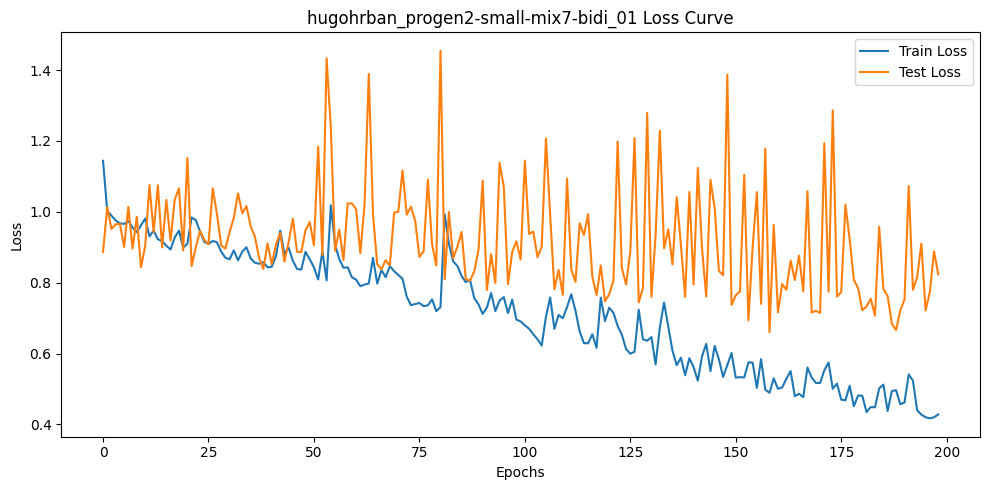

In [ ]:
# 遍历model_names, net_names, 训练模型{model_name}.pth
for model_name, net_name in zip(model_names, net_names):
    path_savemodel = os.path.join(MODEL_FOLDER, f'{model_name}.pth')
    print("path_savemodel:", path_savemodel)

    # 实例化模型
    net_name = instantiate_model(net_name)
    model01 = net_name.to(device)
    # model01 = nn.DataParallel(netesm05, device_ids=[0, 1, 2, 3]).to(device)

    # 调用训练函数，训练100个epoch
    train_losses, test_losses = train(
        train_data_scaler,
        valid_data_scaler,
        model01,
        path_savemodel=path_savemodel,
        epochs=200,
        patience=40,
        lr=1e-4,
        num_gpu=1,
    )
    # 保存训练和测试损失为json文件
    train_losses = train_losses.cpu().numpy()
    test_losses = test_losses.cpu().numpy()
    with open(os.path.join('./image', f'{model_name}_loss.json'), 'w') as f:
        json.dump({
            'model_name': model_name,
            'train_losses': train_losses.tolist(),
            'test_losses': test_losses.tolist()
        }, f)
    
    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join('./image', f'{model_name}_loss_curve.png'))
    plt.show()
    plt.close()
    # 释放显存
    del model01, train_losses, test_losses, net_name
    torch.cuda.empty_cache()

# 5.模型测试

In [ ]:
# 测试所有模型
test_accuracy = calculate_multi_model(test_data=test_data, model_names=model_names, net_names=net_names, scaler=scaler, device=device)

Testing model: prot_bert_01
Test MSE: 3.677214337803941, Spearman Correlation: 0.3665819982328631, p-value: 0.00751868847871475
Testing model: prot_bert_bfd_01


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Test MSE: 3.4278878681910525, Spearman Correlation: 0.4185361489082321, p-value: 0.0020161316832907022
Testing model: prot_t5_01
Test MSE: 3.338567262031498, Spearman Correlation: 0.4403082251978281, p-value: 0.0010886843334367545
Testing model: esm2_t30_150m_01


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 4.151960858122499, Spearman Correlation: 0.2908066346759361, p-value: 0.03648362825097779
Testing model: esm2_t33_650m_01


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 3.248610676340568, Spearman Correlation: 0.5029776526353317, p-value: 0.00014453920971575833
Testing model: esm2_t36_3b_01


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 3.420783287293301, Spearman Correlation: 0.4870541537019604, p-value: 0.0002505884911715061
Testing model: esmc_300m_01


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE: 4.173224510565328, Spearman Correlation: 0.3553544373227381, p-value: 0.009732654339158077
Testing model: esmc_600m_01


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE: 3.9378279990125824, Spearman Correlation: 0.401929604444207, p-value: 0.0031413427067173605
Testing model: ai4protein_prosst_1024_01
Test MSE: 4.88357968985987, Spearman Correlation: 0.20265107087590556, p-value: 0.14963780388959202
Testing model: ai4protein_prosst_2048_01
Test MSE: 3.9869717014955253, Spearman Correlation: 0.3483105302878688, p-value: 0.011392168951606935
Testing model: ai4protein_prosst_4096_01
Test MSE: 4.55642202437728, Spearman Correlation: 0.24431684824579894, p-value: 0.08089330648431674
Testing model: venusplm_300m_01
Test MSE: 3.636654623130719, Spearman Correlation: 0.4002219906175721, p-value: 0.003283795463496065
Testing model: protgpt2_01
Test MSE: 4.593377486089258, Spearman Correlation: 0.21797690496995442, p-value: 0.12057225446651376
Testing model: protein_binding_site_predictor_01


Some weights of RobertaModel were not initialized from the model checkpoint at jedwang/protein-binding-site-predictor and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 4.017195075138083, Spearman Correlation: 0.18211701461062, p-value: 0.19629570033638127
Testing model: roberta_mlm_for_protein_clustering_01


Some weights of RobertaModel were not initialized from the model checkpoint at shashwatsaini/RoBERTa-MLM-For-Protein-Clustering and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 3.542653833336966, Spearman Correlation: 0.39185468286706066, p-value: 0.004067487537943737
Testing model: saprot_1_3b_af2_01


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_1.3B_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 4.019889118585263, Spearman Correlation: 0.2752518786661298, p-value: 0.04827365314845716
Testing model: saprot_650m_pdb_01


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_PDB and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 3.9563224251836306, Spearman Correlation: 0.12745474738390547, p-value: 0.3678930820381705
Testing model: saprot_650m_af2_01


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test MSE: 4.013050678322938, Spearman Correlation: 0.1761227802151405, p-value: 0.2116811113188416
Testing model: saprot_35m_af2_01
Test MSE: 3.906785587913334, Spearman Correlation: 0.1663891736488935, p-value: 0.23842928078307843
Testing model: proteinglm_3b_mlm_01
[2025-07-21 06:20:43,564] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-07-21 06:20:43,649 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat -fno-strict-overflow -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -c /tmp/tmpysq9vs1q/test.c -o /tmp/tmpysq9vs1q/test.o
2025-07-21 06:20:43,680 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat /tmp/tmpysq9vs1q/test.o -laio -o /tmp/tmpysq9vs1q/a.out
2025-07-21 06:20:44,577 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat -fno-strict-overflow -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -O2 -isystem /home/mingxuan/miniconda3/envs/affinity/include -fPIC -c /tmp/tmpab5l_8bb/test.c -o /tmp/tmpab5l_8bb/test.o
2025-07-21 06:20:44,599 - INFO - gcc -pthread -B /home/mingxuan/miniconda3/envs/affinity/compiler_compat /tmp/tmpab5l_8bb/test.o -L

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Test MSE: 4.0680102462149454, Spearman Correlation: 0.15983265417303358, p-value: 0.2576989296667354
Testing model: proteinglm_3b_clm_01


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Test MSE: 4.040266699717852, Spearman Correlation: 0.33780870525406376, p-value: 0.01431622558967195
Testing model: aido_protein_16b_01


Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

Test MSE: 4.172482101934245, Spearman Correlation: 0.2309974603980461, p-value: 0.09943035785218256
Testing model: hugohrban_progen2-small_01
Test MSE: 3.917065351885736, Spearman Correlation: 0.3701679872687965, p-value: 0.006910707799232013
Testing model: hugohrban_progen2-medium_01
Test MSE: 3.6603965745524483, Spearman Correlation: 0.37938910193262537, p-value: 0.005539839749771601
Testing model: hugohrban_progen2-large_01


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test MSE: 3.231065098156894, Spearman Correlation: 0.41734081922958766, p-value: 0.0020830870193945176
Testing model: hugohrban_progen2-base_01
Test MSE: 4.094254657167362, Spearman Correlation: 0.2604111085618336, p-value: 0.062249498813509274
Testing model: hugohrban_progen2-oas_01
Test MSE: 4.0315286313951795, Spearman Correlation: 0.22002604156191644, p-value: 0.11703605809284079
Testing model: hugohrban_progen2-BFD90_01


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Test MSE: 3.659827299147238, Spearman Correlation: 0.3850669179061867, p-value: 0.004819644986145897
Testing model: hugohrban_progen2-small-mix7_01


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Test MSE: 3.5229041423623526, Spearman Correlation: 0.36764925687450994, p-value: 0.007333061396190793
Testing model: hugohrban_progen2-small-mix7-bidi_01
Test MSE: 3.544999177029782, Spearman Correlation: 0.3542871786810913, p-value: 0.009969804177638389


In [ ]:
# 保存test_accuracy到test_accuracy.pkl文件
path_test_accuracy = "./data/test_accuracy.pkl"
with open(path_test_accuracy, 'wb') as f:
    pickle.dump(test_accuracy, f)
# 读取test_accuracy.pkl文件
if os.path.exists(path_test_accuracy):
    with open(path_test_accuracy, 'rb') as f:
        test_accuracy = pickle.load(f)
else:
    test_accuracy = []
test_accuracy

[{'Rostlab/prot_bert': (3.677214337803941,
   0.3665819982328631,
   0.00751868847871475)},
 {'Rostlab/prot_bert_bfd': (3.4278878681910525,
   0.4185361489082321,
   0.0020161316832907022)},
 {'Rostlab/prot_t5_xl_uniref50': (3.338567262031498,
   0.4403082251978281,
   0.0010886843334367545)},
 {'facebook/esm2_t30_150M_UR50D': (4.151960858122499,
   0.2908066346759361,
   0.03648362825097779)},
 {'facebook/esm2_t33_650M_UR50D': (3.248610676340568,
   0.5029776526353317,
   0.00014453920971575833)},
 {'facebook/esm2_t36_3B_UR50D': (3.420783287293301,
   0.4870541537019604,
   0.0002505884911715061)},
 {'EvolutionaryScale/esmc-300m-2024-12': (4.173224510565328,
   0.3553544373227381,
   0.009732654339158077)},
 {'EvolutionaryScale/esmc-600m-2024-12': (3.9378279990125824,
   0.401929604444207,
   0.0031413427067173605)},
 {'AI4Protein/ProSST-1024': (4.88357968985987,
   0.20265107087590556,
   0.14963780388959202)},
 {'AI4Protein/ProSST-2048': (3.9869717014955253,
   0.3483105302878688,
 

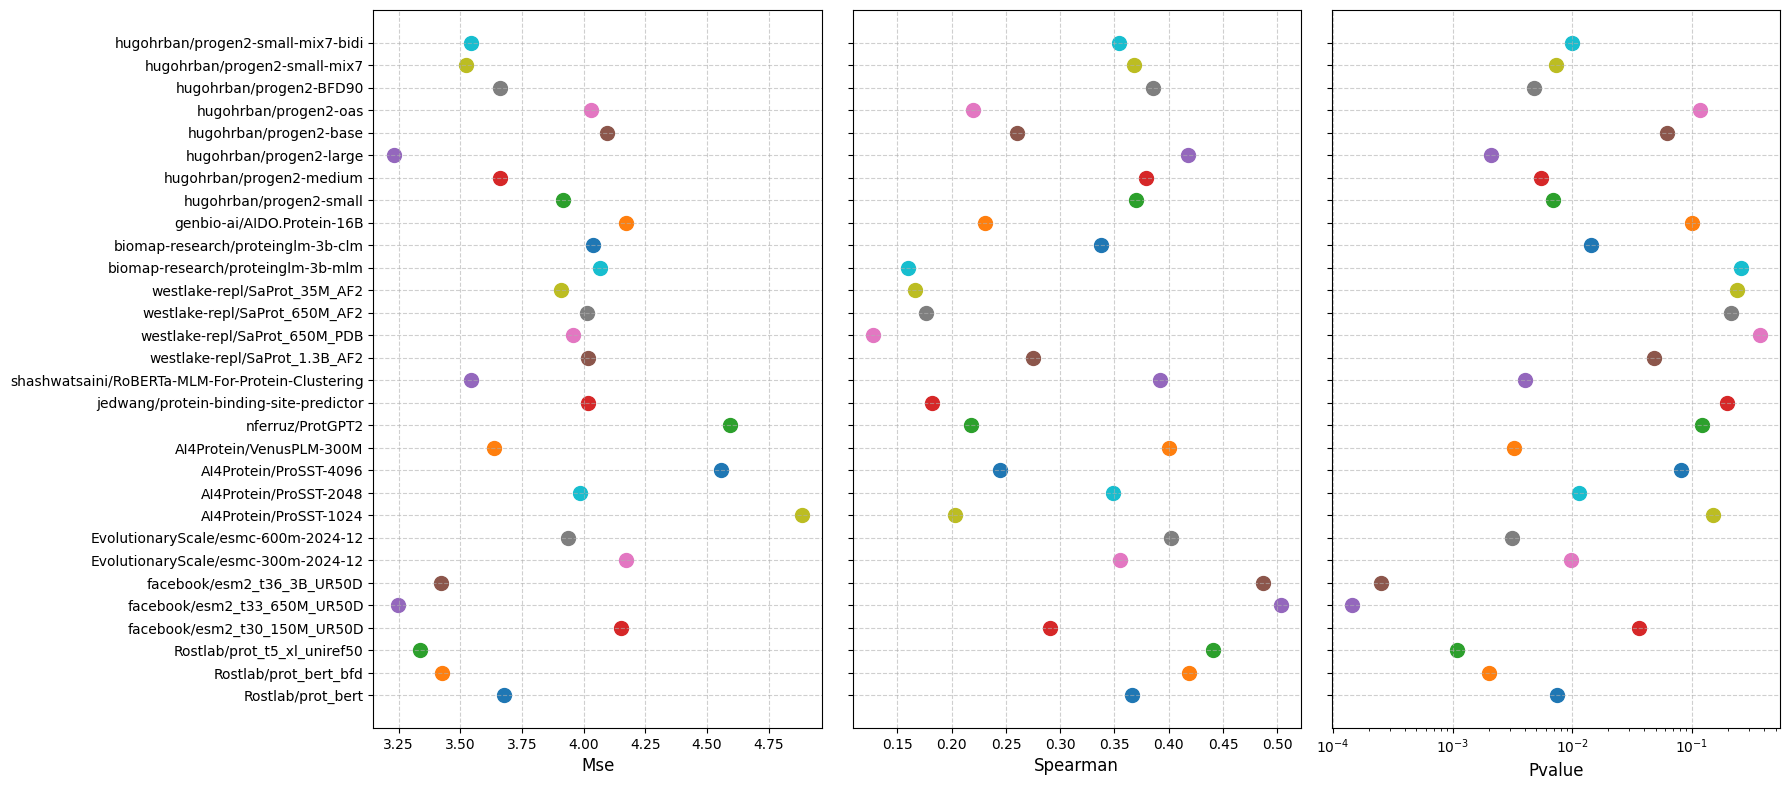

In [ ]:
# 获取模型名称
list_x = [list(model_dict.keys())[0] for model_dict in test_accuracy]

# 添加测试类别：mse, spearman, pvalue
list_title = ['mse', 'spearman', 'pvalue']
test_accuracy_np = np.array([test_accuracy[i][list(test_accuracy[i].keys())[0]] for i in range(len(test_accuracy))])
dict_arr_acc = {title: test_accuracy_np[:, i] for i, title in enumerate(list_title)}

# 绘制散点图
draw_acc_scatter_combined_horizontal(list_x=list_x, dict_arr_acc=dict_arr_acc)